In [492]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]
def get_contig_lengths(file):
    contig_len = {}
    for line in file:
        contig, length = line.split()
        length = int(length)
        if contig in contig_len:
            print("Error: double cont: " + contig + " | v1: " + str(contig_len[contig]) + " | v2: " + str(length))
        contig_len[contig] = length
    return contig_len

def read_file(file_name):
    """
    """
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            data.append([a, b, float(dist)])
    return data

def write_file(file_name, data):
    with open(file_name, 'w') as out:
        for a,b,dist in data:
            out.write(a +'\t'+ b +'\t'+str(dist) +'\n')
            
def write_sol(file_name, pos):
    pos = sorted(pos.items(), key = lambda x: x[1])
    with open(file_name, 'w') as out:
        for contig, position in pos:
            out.write(contig +'\t'+ str(position) + '\n')
            
def read_position(datei, ending = True):
    f = open(datei)
    
    position = {}
    contig_repeat = coll.defaultdict(list)
    
    for line in f:
        if ending:
            contig, pos = line.split()
            repeat = contig + '_' + str(len(contig_repeat[contig]))
        else:
            repeat, pos = line.split()
            contig = contig_name(repeat)
        
        position[repeat] = float(pos)
        contig_repeat[contig].append(repeat)
        
    return position, contig_repeat
            
def get_vars(data):
    contigs = set()
    for a, b, _ in data:
        contigs.add(a)
        contigs.add(b)
    return contigs

def find(x, i):
    
    l = [i]
    while i in x and i != x[i]:
        i = x[i]
        l += [i]
    
    for j in l:
        x[j] = i
        
    return i

def union(x,i,j):
    i = find(x,i)
    j = find(x,j)
    x[i] = j
        
def to_sets(struct):
    sets = coll.defaultdict(set)
    for element in struct:
        root = find(struct, element)
        sets[root].add(element)
    return sorted(sets.values(), key = lambda x: len(x), reverse = True)

def connected(data):
    struct = {}
    for a, b, _ in data:
        union(struct, a, b)
    sets = to_sets(struct)
    
    if len(sets) == 1:
        print('Die Daten sind zusammenhängend')
    else:
        print('Es gibt unzusammenhängende Regionen in den Daten')
        value = round(100 * len(sets[0]) / sum(len(x) for x in sets), 2)
        print(str(value) + '% der Contigs sind in der größten Komponente.')
       # print(sum(len(x) for x in sets[1:]))
       #print(sum(len(x) for x in sets[:]))
        
    return [constraint for constraint in data if constraint[0] in sets[0]]
#connected('my_apd200.lst')


def solve_LP(position, graph, folgende):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(folgende)
    
    contig.update(position)
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in graph.edges:
        eps = model.addVar()
       # faktor = (1000 + dist)/33942.74
        model.addConstr( contig[b] - contig[a] - dist <= eps ) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps ) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in folgende}


def entferne_sackgassen(graph, start = '2345APD_0', ziel = '2080APD_0'):
    änderungen = True
    while änderungen:
        änderungen = False
        for x in list(graph):
            if graph.in_degree[x] == 0 and x != start:
                graph.remove_node(x)
                änderungen = True
            elif graph.out_degree[x] == 0 and x != ziel:
                graph.remove_node(x)
                änderungen = True
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName


def sub(al, bl, dist, tol = 1000):
    k = iter(bl)
    for i in al:
        i += dist
        try:
            e = next(k)
            while e < i - tol:
                e = next(k)
            if e > i + tol:
                return True
        except:
            return True
    return False

def b_dom_a(aneig,bneig,abdist):
    for c, la in aneig.items():
        if sub(la, bneig[c],abdist):
            return False
    return True

def überdeckte(graph):
    neigh = {}
    for b in graph:
        neigh[b] = coll.defaultdict(list)
        for a, l in graph.pred[b].items():
            neigh[b][a] = sorted([-d for d in l])
        neigh[b][b].append(0)
        for c, l in graph.succ[b].items():
            neigh[b][c] += sorted([d for d in l])
        neigh[b] = dict(neigh[b])
        
        
    evil = set()
    
    for a, aneig in neigh.items():
        for b, l in aneig.items():
            
            if len(l) > 1 or a == b:
                continue
                
            bneig = neigh[b]
            if not set(aneig) <= set(bneig):
                continue
                
            abdist = l[0]
            if b_dom_a(aneig,bneig,abdist):
                evil.add(a)
    return evil


def mehrfach(adj):
    for b,l in adj.items():
        if len(l) > 1:
            return True
    return False

def singels(graph):
    evil = []
    for a in graph:
        if mehrfach(graph.succ[a]) or mehrfach(graph.pred[a]):
            continue
        evil.append(a)
    return evil


In [2]:
pos, rep = read_position('apdsolution_coords.lst')
intNameX = get_intName(pos)

In [419]:
for r in reps:
    r = contig_name(r)
    for s in rep[r]:
        intNameX[rep[r][0]] = min(intNameX[rep[r][0]], intNameX[s])

In [420]:
reps = {r+'_0' for r in rep if len(rep[r])>1}

In [4]:
def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups


def gruppiert2(werte, min_abstand):
    sorted_werte = sorted(werte) 
    
    previous = sorted_werte[0]
    current_group = []
    max_len = 0
    for current in sorted_werte:
        if current - previous > min_abstand:
            
            this_len = len(current_group)
            if this_len > max_len:
                max_group = current_group[this_len//2]
                max_len = this_len
                
            current_group = []
            
        current_group.append(current)
        previous = current
        
    this_len = len(current_group)
    if this_len > max_len:
        max_group = current_group[this_len//2]
        max_len = this_len
        
    return max_group

data2 = read_file('my_apd199.lst')
data2 = connected(data2)
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    else:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('len z[x] %6d'%sum(len(z[x]) for x in z))
print('len Z[x] %6d'%sum(len(Z[x]) for x in Z))
print('len C    %6d'%len(Z))
print('len Z-C  %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))
print('len z-Z  %6d'%(sum(len(z[x]) for x in z) - sum(len(Z[x]) for x in Z)))


data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
len(data3)


Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
len z[x] 122219
len Z[x]  55642
len C     49415
len Z-C    6227
len z-Z   66577


55642

In [ ]:
graph = nx.MultiDiGraph() 
for a, b, d in data2:
    if a != b:
        graph.add_edge(a,b,d)
        
aktuell = '2345APD_0'
position = {}
constr_pos = coll.defaultdict(list)
constr_pos[aktuell] = [0]
#besucht = []
def solve(graph, position, constr_pos):
    while constr_pos:
        pos, aktuell = min(
            (gruppiert2(constr_pos[contig], 500),contig) 
            for contig in constr_pos 
        )
        print(int(pos), aktuell)
        position[aktuell] = pos
        constr_pos.pop(aktuell)

        for contig in graph[aktuell]:
            for dist in graph[aktuell][contig]:
                constr_pos[contig].append(position[aktuell] + dist)
        graph.remove_node(aktuell)


        pre_position = {
            contig: gruppiert2(constr_pos[contig], 500)
            for contig in constr_pos 
        }
        
        subgraph = nx.DiGraph()
        for a,b,d in graph.subgraph(constr_pos).edges:
            if abs(pre_position[b] - pre_position[a] - d) < 5000:
                subgraph.add_edge(a,b)
                
        if subgraph and not nx.is_weakly_connected(subgraph):
        #    print(i)
            komponenten = nx.weakly_connected_components(subgraph)
            
            graph_save = graph.copy()
            erg = (0,0)
            for komponente in komponenten:
                constr_pos_komp = coll.defaultdict(list,{k: constr_pos[k].copy() for k in komponente})
                erg = max(erg, solve(graph.copy(),position.copy(),constr_pos_komp))
                
            return erg
            
    l = len(position)
    print('erg',l)
    return l, position
solve(graph, position, constr_pos)

In [64]:
graph.out_degree[x]

48

In [89]:


#ins,outs,len(graph)

11
31
1047APD_0 {17140.0: {}}
1598APD_0 {24761.0: {}}
1601APD_0 {22269.0: {}}
1787APD_0 {22640.0: {}}
1849APD_0 {10454.0: {}}
1868APD_0 {16338.0: {}}
1963APD_0 {14768.0: {}}
2042APD_0 {8085.0: {}}
215APD_0 {21206.0: {}}
2245APD_0 {15215.0: {}}
2283APD_0 {12412.0: {}}
449APD_0 {21819.0: {}}
538APD_0 {393.0: {}, 413.0: {}, 415.8350866186465: {}, 416.0: {}}
679APD_0 {9219.0: {}}
719APD_0 {20508.0: {}}
1053APD_0 1
1158APD_0 1
120APD_0 2
1763APD_0 1
1274APD_0 1
1630APD_0 1
382APD_0 2
2130APD_0 1
1058APD_0 1
1560APD_0 1
1608APD_0 1
1541APD_0 1
908APD_0 1
158APD_0 1
1707APD_0 1
1731APD_0 1
1833APD_0 1
621APD_0 1
1312APD_0 2
916APD_0 1
771APD_0 1
571APD_0 1
800APD_0 1
2033APD_0 4
2196APD_0 1
1584APD_0 1
2181APD_0 1
1360APD_0 1
1222APD_0 2
2188APD_0 1
2029APD_0 1
237APD_0 1
2382APD_0 1
2388APD_0 1
1121APD_0 1
1119APD_0 1
1263APD_0 1
334APD_0 1
372APD_0 1
1000APD_0 1
2261APD_0 1
495APD_0 1
589APD_0 2
1840APD_0 1
612APD_0 1
627APD_0 1
645APD_0 3
698APD_0 3
747APD_0 18
845APD_0 2
95APD_0 1
1282APD

In [90]:
graph = nx.MultiDiGraph() 
for a, b, d in data2:
    if a != b:
        graph.add_edge(a,b,d)

In [266]:
graph2 = nx.MultiDiGraph() 
for d, a, b, _ in data3:
    if a != b:
        graph2.add_edge(a,b,d)
#entferne_sackgassen(graph2)


In [298]:
a = set(graph2.neighbors('1001APD_0'))#set(graph2.adj['1001APD_0'])
b = set(graph2.pred['1001APD_0'])
c = set(graph2.succ['1001APD_0'])
c == a == set(graph2.adj['1001APD_0'])

True

In [369]:
d = coll.defaultdict(list)
for e,a in evil:
    d[e].append(a)
len(d)

291

In [373]:
d = coll.defaultdict(list)
for e,a in evil:
    d[e].append(a)
len(d)

274

In [374]:
len(graph2)-len(d)

1793

In [443]:
graph = nx.MultiDiGraph() 
for a, b, d in data2:
    if a != b:
        graph.add_edge(a,b,d)
entferne_sackgassen(graph)
graph2 = nx.MultiDiGraph() 
for d, a, b, _ in data3:
    if a != b:
        graph2.add_edge(a,b,d)
entferne_sackgassen(graph2)
print(len(graph))
#evil = singels(graph)
#graph.remove_nodes_from(evil)
#graph2.remove_nodes_from(evil)
print(len(graph))
evil = überdeckte(graph2)
graph.remove_nodes_from(evil)
graph2.remove_nodes_from(evil)
print(len(graph))
def mehrfach(adj):
    for b,l in adj.items():
        if len(l) > 1:
            return True
    return False

def singels(graph):
    evil = []
    for a in graph:
        if mehrfach(graph.succ[a]) or mehrfach(graph.pred[a]):
            continue
        evil.append(a)
    return evil


2067
2067
1793


In [513]:

def mehrfach(adj):
    for b,l in adj.items():
        if len(l) > 2:
            return True
    return False

def singels(graph):
    evil = []
    for a in graph:
        if mehrfach(graph.succ[a]) or mehrfach(graph.pred[a]):
            continue
        evil.append(a)
    return evil

In [514]:
graph = nx.MultiDiGraph() 
for a, b, d in data2:
    if a != b:
        graph.add_edge(a,b,d)
entferne_sackgassen(graph)
graph2 = nx.MultiDiGraph() 
for d, a, b, _ in data3:
    if a != b:
        graph2.add_edge(a,b,d)
entferne_sackgassen(graph2)

evil = singels(graph)
graph.remove_nodes_from(evil)
graph2.remove_nodes_from(evil)
evil = überdeckte(graph2)
graph.remove_nodes_from(evil)
graph2.remove_nodes_from(evil)

aktuell = '2345APD_0'
position = {}
pre_position = {'2345APD_0' : 0}
constr_pos = coll.defaultdict(list)
constr_pos[aktuell] = [0]
#besucht = []

def aa(constr_pos):
    return min(
        (gruppiert2(constr_pos[contig], 500),contig) 
        for contig in constr_pos 
    )

def bb (graph,position,constr_pos,aktuell):
    for contig, dists in graph.succ[aktuell].items():
        if not contig in position:
            for dist in dists:
                constr_pos[contig].append(position[aktuell] + dist)
                

def cc(constr_pos):
    return {
        contig: gruppiert2(constr_pos[contig], 500)
        for contig in constr_pos 
    }

def dd2(graph, pre_position):
    subgraph = nx.DiGraph()
    nahe = sorted(pre_position.items(),key = lambda x: x[1])[:7]
    nahe = {k for k,_ in nahe}
    subgraph.add_nodes_from(nahe)
    subgraph.add_edges_from({
            (a,b) 
            for a in nahe
            for b, l in graph.succ[a].items() if b in nahe and pre_position[b] > pre_position[a] 
            for d in l if abs(pre_position[b] - pre_position[a] - d) < 5000
        }
    )
    return subgraph

def dd3(graph, pre_position):
    subgraph = nx.DiGraph()
    subgraph.add_nodes_from(pre_position)
    subgraph.add_edges_from({
            (a,b) 
            for a, pa in pre_position.items()
            for b, l in graph.succ[a].items() if b in pre_position and pre_position[b] > pa
            for d in l if abs(pre_position[b] - pa - d) < 5000
        }
    )
    return subgraph

def solve(graph, graph2, position, constr_pos, rr = [], i=0):
    while constr_pos:
     #   aktuell, pos = min(pre_position.items(),key = lambda x: x[1])
        pos, aktuell = aa(constr_pos)
      #  print(int(pos), aktuell)
        position[aktuell] = pos
        constr_pos.pop(aktuell)
        
        bb(graph,position,constr_pos,aktuell)
        #graph.remove_node(aktuell)

        
        pre_position = cc(constr_pos)
        subgraph2 = dd3(graph2, pre_position)
        grad0 = [a for a in subgraph2 if subgraph2.in_degree[a] == 0]
        
        if len(grad0) > 1:
            rr.append(aktuell)
            
            komponenten = [set(nx.predecessor(subgraph2, start)) for start in grad0]
            count_nodes = sum((coll.Counter(kompon) for kompon in komponenten), coll.Counter())
            komponenten = [{a for a in kompon if count_nodes[a] == 1} for kompon in komponenten]
            
            komponenten = [
                    ({
                        a 
                        for b in komponente
                        for a,l in graph.pred[b].items() if a in position
                        for d in l if abs(pre_position[b] - position[a] - d) < 5000
                    }, komponente)
                    for komponente in komponenten
                ]
            s = komponenten[0][0].copy()
            for pro, _ in komponenten[1:]:
                s &= pro
            try:
                min_s = min(position[x] for x in s)
            except:
                print('kein Schnitt')
           #     print(aktuell)
            #    print(set(pre_position) - set(position))
            #    return pre_position, position, constr_pos, komponenten, subgraph
                min_s = 0
              
            komponenten = [[{p for p in pro if position[p] < min_s}, k] for pro, k in komponenten]
            komponenten = sorted([[len(pro),sorted([position[x] for x in pro]),k] for pro, k in komponenten],reverse=True)
            
            kk = [min(k,key = lambda x: pre_position[x]) for _,_,k in komponenten]
            G = graph.subgraph(set(graph)-set(position))
         #   evil = []
            for (a,ka), (b,kb) in it.combinations(zip(kk,komponenten),2):
                if ka in komponenten and kb in komponenten:
                    ab = nx.has_path(G,a,b)
                    ba = nx.has_path(G,b,a)
                    if ab and not ba:
                        komponenten.remove(kb)
                    elif ba and not ab:
                        komponenten.remove(ka)
                    
            if len(komponenten) == 1 or (komponenten[1][0] == 0 and  komponenten[0][0] > 0):
              #  or (komponenten[1][0]*5+2 < komponenten[0][0] and komponenten[1][1] > komponenten[0][1])):
                
                print('U',i,len(position),aktuell)#,intName[aktuell])
                komponente = komponenten[0][2]
                constr_pos_komp = coll.defaultdict(list,{k: constr_pos[k] for k in komponente})
                #for b in constr_pos:
                 #   for a in komponente:
                  #      if b in graph2[a]:
                   #         constr_pos_komp[b] = constr_pos[b]
                    #        break
                return solve(graph,graph2,position,constr_pos_komp,rr,i+1)
            #print('XXXX')
            #return position, pre_position, rr ,komponenten
            erg = ((0,0),0)
            for _,_, komponente in komponenten:
                print('T',i,)#intName[aktuell])
                constr_pos_komp = coll.defaultdict(list,{k: constr_pos[k].copy() for k in komponente})
                for b in constr_pos:
                    for a in komponente:
                        if b in graph2[a]:
                            constr_pos_komp[b] = constr_pos[b].copy()
                            break
               # return solve(graph,graph2,position.copy(),constr_pos_komp,pre_position,i+1)
                erg = max(erg, solve(graph,graph2,position.copy(),constr_pos_komp,rr,i+1), key = lambda x: x[0])
                
            return erg
    l = len(position)
    maxi = position[aktuell]
    print(i,'erg',l,'max',int(maxi))
    return (l,maxi), position, rr
subgraph = solve(graph, graph2, position, constr_pos, [], 0)
#cP.run('solve(graph, graph2, position, constr_pos, [], 0)',sort = 1)


U 0 116 157APD_0
U 1 217 58APD_0
U 2 224 462APD_0
U 3 320 399APD_0
U 4 366 2459APD_0
U 5 367 501APD_0
U 6 369 1693APD_0
U 7 370 909APD_0
U 8 373 1391APD_0
U 9 378 1379APD_0
U 10 381 2386APD_0
U 11 384 1769APD_0
U 12 389 1525APD_0
U 13 397 1874APD_0
U 14 400 1505APD_0
U 15 402 182APD_0
U 16 407 1011APD_0
U 17 409 2324APD_0
U 18 413 342APD_0
U 19 414 271APD_0
U 20 418 211APD_0
U 21 421 477APD_0
U 22 422 113APD_0
U 23 423 40APD_0
U 24 427 2043APD_0
U 25 429 64APD_0
U 26 431 658APD_0
U 27 432 1510APD_0
U 28 434 2278APD_0
U 29 514 2286APD_0
U 30 556 178APD_0
U 31 891 1021APD_0
U 32 924 1224APD_0
U 33 929 432APD_0
U 34 930 1923APD_0
U 35 956 72APD_0
U 36 966 411APD_0
U 37 1020 355APD_0
U 38 1130 74APD_0
U 39 1377 512APD_0
U 40 1382 214APD_0
U 41 1387 305APD_0
U 42 1393 2457APD_0
U 43 1423 388APD_0
U 44 1451 353APD_0
U 45 1491 25APD_0
46 erg 1532 max 4466705


In [507]:
position = subgraph[1]
max(position.values())

4467080.580096822

In [471]:
posi1 = {'2345APD_0': 0, '1483APD_0': 6662.0, '1395APD_0': 6985.0, '1596APD_0': 9952.629129467889, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16513.62912946789, '577APD_0': 19016.62912946789, '998APD_0': 32313.62912946789, '209APD_0': 34132.62912946789, '1635APD_0': 43535.62912946789, '2109APD_0': 45637.62912946789, '996APD_0': 47657.62912946789, '1481APD_0': 49144.62912946789, '2113APD_0': 55767.62912946789, '1332APD_0': 64494.62912946789, '1067APD_0': 67987.62912946788, '225APD_0': 68358.62912946788, '1894APD_0': 77426.62912946788, '2448APD_0': 80409.62912946788, '521APD_0': 80980.62912946788, '2319APD_0': 82897.62912946788, '1076APD_0': 83280.62912946788, '301APD_0': 86437.62912946788, '50APD_0': 88494.62912946788, '2396APD_0': 90521.56143478458, '1980APD_0': 92155.62912946788, '958APD_0': 93235.56143478458, '2050APD_0': 95049.56143478458, '1113APD_0': 99591.56143478458, '960APD_0': 101511.56143478458, '831APD_0': 103142.56143478458, '1877APD_0': 106374.56143478458, '1337APD_0': 107227.56143478458, '59APD_0': 114472.62912946788, '542APD_0': 120930.62912946788, '1631APD_0': 124900.62912946788, '176APD_0': 126116.62912946788, '567APD_0': 128319.56143478458, '776APD_0': 130184.56143478458, '86APD_0': 131471.56143478458, '71APD_0': 137924.10979978362, '1529APD_0': 138148.56143478458, '1057APD_0': 138833.56143478458, '1472APD_0': 141006.56143478458, '1714APD_0': 142756.56143478458, '1480APD_0': 145444.38413647152, '1400APD_0': 145965.56143478458, '2058APD_0': 149562.62912946788, '943APD_0': 151221.56143478458, '511APD_0': 151957.06031242787, '1698APD_0': 157348.62912946788, '1903APD_0': 158545.06031242787, '1625APD_0': 163515.06031242787, '2387APD_0': 164033.06031242787, '1317APD_0': 165634.56143478458, '212APD_0': 182585.84750133945, '1857APD_0': 182996.56143478458, '931APD_0': 185955.56143478458, '1771APD_0': 186475.4466261544, '1375APD_0': 186807.56143478458, '156APD_0': 187826.56143478458, '19APD_0': 190543.06031242787, '1252APD_0': 193631.5757946029, '772APD_0': 194366.62912946788, '896APD_0': 195077.5757946029, '2013APD_0': 196790.56143478458, '2322APD_0': 199594.56143478458, '439APD_0': 202519.5757946029, '906APD_0': 203082.54714176292, '948APD_0': 203464.62912946788, '1151APD_0': 205909.56143478458, '1904APD_0': 212303.56143478458, '945APD_0': 214348.56143478458, '2085APD_0': 215002.56143478458, '1779APD_0': 218409.64591132698, '1363APD_0': 219581.64591132698, '1380APD_0': 220367.56143478458, '1921APD_0': 222766.56143478458, '1465APD_0': 224855.56143478458, '579APD_0': 225615.56143478458, '876APD_0': 226065.56143478458, '793APD_0': 227243.06031242787, '1991APD_0': 229430.62912946788, '2003APD_0': 232852.62912946788, '1238APD_0': 233379.20667004058, '1397APD_0': 233520.62912946788, '885APD_0': 235084.56143478458, '205APD_0': 235899.62912946788, '2022APD_0': 238704.62912946788, '1409APD_0': 239081.70982165076, '1017APD_0': 239547.56143478458, '277APD_0': 241581.56143478458, '2312APD_0': 243347.70982165076, '444APD_0': 243683.1307718786, '374APD_0': 244148.81278358685, '1866APD_0': 246630.81278358685, '1514APD_0': 246997.81278358685, '2197APD_0': 251009.81278358685, '2088APD_0': 252301.9480208146, '580APD_0': 254768.9480208146, '506APD_0': 263986.94802081457, '2458APD_0': 267758.81278358685, '480APD_0': 268647.81278358685, '1246APD_0': 271620.81278358685, '1334APD_0': 272588.94802081457, '466APD_0': 274492.81278358685, '855APD_0': 279003.94802081457, '547APD_0': 279825.94802081457, '318APD_0': 280307.94802081457, '682APD_0': 282121.94802081457, '601APD_0': 282696.81278358685, '1939APD_0': 286023.94802081457, '789APD_0': 287050.94802081457, '242APD_0': 288264.7934906281, '1930APD_0': 288410.39067057613, '1543APD_0': 289308.94802081457, '88APD_0': 291671.94802081457, '1955APD_0': 295435.94802081457, '2380APD_0': 297187.94802081457, '1390APD_0': 298616.94802081457, '638APD_0': 300673.94802081457, '216APD_0': 302249.94802081457, '1701APD_0': 307483.94802081457, '684APD_0': 308984.94802081457, '2125APD_0': 310863.94802081457, '764APD_0': 311300.94802081457, '898APD_0': 312119.94802081457, '1966APD_0': 313344.94802081457, '1621APD_0': 313947.94802081457, '157APD_0': 314557.94802081457, '2122APD_0': 322054.94802081457, '261APD_0': 324279.26247274084, '1942APD_0': 324439.94802081457, '1586APD_0': 325118.94802081457, '1494APD_0': 326622.94802081457, '832APD_0': 327601.94802081457, '1590APD_0': 328906.94802081457, '1248APD_0': 330317.94802081457, '1889APD_0': 330994.94802081457, '1622APD_0': 331470.4009167654, '241APD_0': 332328.4009167654, '235APD_0': 340563.94802081457, '184APD_0': 343507.94802081457, '2296APD_0': 344487.94802081457, '593APD_0': 347292.94802081457, '2021APD_0': 347885.94802081457, '986APD_0': 352535.94802081457, '850APD_0': 355546.94802081457, '1986APD_0': 356947.94802081457, '35APD_0': 358715.94802081457, '1672APD_0': 363641.94802081457, '1445APD_0': 365261.94802081457, '1454APD_0': 367038.94802081457, '921APD_0': 367359.94802081457, '2032APD_0': 372117.94802081457, '1981APD_0': 374590.94802081457, '735APD_0': 376367.94802081457, '740APD_0': 379432.94802081457, '1850APD_0': 380821.94802081457, '1967APD_0': 382715.94802081457, '1675APD_0': 384526.42117333156, '1169APD_0': 385169.94802081457, '1268APD_0': 385920.94802081457, '208APD_0': 387437.94802081457, '2149APD_0': 389626.94802081457, '276APD_0': 392111.94802081457, '98APD_0': 399540.94802081457, '874APD_0': 400754.94802081457, '2068APD_0': 401540.94802081457, '1137APD_0': 401905.94802081457, '2071APD_0': 402662.94802081457, '1077APD_0': 403588.94802081457, '80APD_0': 404114.94802081457, '2011APD_0': 404884.94802081457, '379APD_0': 405494.94802081457, '1024APD_0': 405954.94802081457, '588APD_0': 407229.6942898433, '939APD_0': 410775.94802081457, '1433APD_0': 413558.94802081457, '1647APD_0': 413973.94802081457, '1467APD_0': 416832.94802081457, '1192APD_0': 418186.94802081457, '335APD_0': 419110.94802081457, '2256APD_0': 420293.94802081457, '1038APD_0': 421876.1863185468, '429APD_0': 422969.94802081457, '1595APD_0': 425389.94802081457, '2160APD_0': 425694.94802081457, '68APD_0': 426271.94802081457, '2390APD_0': 426726.94802081457, '1010APD_0': 429120.94802081457, '680APD_0': 432336.94802081457, '1185APD_0': 436139.94802081457, '1199APD_0': 436771.94802081457, '1574APD_0': 438606.94802081457, '2092APD_0': 439356.94802081457, '989APD_0': 439727.94802081457, '106APD_0': 443827.94802081457, '2423APD_0': 451599.94802081457, '2434APD_0': 452647.94802081457, '2461APD_0': 454203.94802081457, '1281APD_0': 456893.94802081457, '202APD_0': 461021.94802081457, '2350APD_0': 461871.94802081457, '90APD_0': 462307.94802081457, '2367APD_0': 467187.94802081457, '1661APD_0': 471178.94802081457, '569APD_0': 473631.94802081457, '690APD_0': 474287.2151818719, '1309APD_0': 474455.6668042047, '1665APD_0': 475417.6668042047, '153APD_0': 477711.6668042047, '1816APD_0': 478475.6668042047, '1330APD_0': 480744.6668042047, '2335APD_0': 482666.1770830945, '1751APD_0': 483729.6668042047, '904APD_0': 487741.6668042047, '548APD_0': 488642.6668042047, '811APD_0': 492183.6668042047, '2415APD_0': 494008.6668042047, '2204APD_0': 494941.6668042047, '196APD_0': 501271.6668042047, '714APD_0': 505018.6668042047, '31APD_0': 507035.6668042047, '656APD_0': 513334.6668042047, '1410APD_0': 522454.6668042047, '1852APD_0': 526719.6668042047, '151APD_0': 528718.6668042047, '978APD_0': 541705.6535842422, '861APD_0': 541882.3702607561, '187APD_0': 542570.3702607561, '1162APD_0': 551903.3702607561, '459APD_0': 552691.6668042047, '57APD_0': 556876.6668042047, '900APD_0': 557794.3702607561, '766APD_0': 558630.6668042047, '189APD_0': 559459.6668042047, '1815APD_0': 573134.3702607561, '2205APD_0': 575296.3702607561, '58APD_0': 580715.3702607561, '599APD_0': 588820.3702607561, '345APD_0': 593260.3702607561, '1463APD_0': 603910.6668042047, '865APD_0': 605099.6668042047, '615APD_0': 609538.6668042047, '407APD_0': 609955.6668042047, '2394APD_0': 611705.6668042047, '694APD_0': 613138.0649760086, '491APD_0': 613288.6668042047, '462APD_0': 613462.5515410006, '413APD_0': 613683.1686058405, '1500APD_0': 614237.6668042047, '1APD_0': 615014.5515410006, '1245APD_0': 623500.5515410006, '1423APD_0': 624829.5515410006, '2420APD_0': 632306.5515410006, '1439APD_0': 635441.5515410006, '703APD_0': 638030.5515410006, '421APD_0': 658113.6668042047, '37APD_0': 666727.6668042047, '44APD_0': 667985.6668042047, '11APD_0': 674205.6668042047, '1783APD_0': 680805.6668042047, '2075APD_0': 684357.6668042047, '69APD_0': 686389.6668042047, '1022APD_0': 687259.6668042047, '681APD_0': 691911.6668042047, '2110APD_0': 694896.6668042047, '1374APD_0': 697916.6668042047, '1773APD_0': 698267.6668042047, '94APD_0': 702581.6668042047, '1721APD_0': 711030.6668042047, '2410APD_0': 715848.6668042047, '89APD_0': 722877.6668042047, '1366APD_0': 726614.6668042047, '1651APD_0': 727155.6668042047, '119APD_0': 733342.6668042047, '572APD_0': 743663.6668042047, '2155APD_0': 753679.6668042047, '708APD_0': 759390.5051374797, '1522APD_0': 760921.5051374797, '134APD_0': 762303.5051374797, '525APD_0': 765209.5051374797, '1729APD_0': 765631.8659428308, '597APD_0': 768137.5051374797, '75APD_0': 776556.5051374797, '497APD_0': 788200.5051374797, '464APD_0': 789834.5051374797, '1474APD_0': 790585.5051374797, '565APD_0': 791518.5051374797, '653APD_0': 794428.5051374797, '391APD_0': 795039.5051374797, '1507APD_0': 807251.5051374797, '167APD_0': 807815.5051374797, '2337APD_0': 816211.5051374797, '385APD_0': 817320.5051374797, '307APD_0': 818766.5051374797, '1261APD_0': 829217.5051374797, '1691APD_0': 830532.9381836694, '452APD_0': 831205.9381836694, '781APD_0': 854289.9381836694, '1753APD_0': 855291.9381836694, '1523APD_0': 860701.9381836694, '995APD_0': 866729.9381836694, '2460APD_0': 871637.9381836694, '1033APD_0': 873742.9381836694, '568APD_0': 875184.9381836694, '1970APD_0': 882064.9381836694, '820APD_0': 889152.9381836694, '77APD_0': 889874.9381836694, '1258APD_0': 891512.9381836694, '1265APD_0': 897090.9381836694, '1253APD_0': 899509.9381836694, '73APD_0': 903347.9381836694, '1460APD_0': 911985.9381836694, '376APD_0': 917363.9381836694, '806APD_0': 932555.2063610648, '2250APD_0': 936590.2063610648, '2358APD_0': 944445.9381836694, '3APD_0': 944786.9381836694, '573APD_0': 948940.9381836694, '48APD_0': 957842.9381836694, '1055APD_0': 963251.6416924568, '117APD_0': 967976.6416924568, '639APD_0': 976821.0697132803, '2211APD_0': 981537.0697132803, '802APD_0': 984043.0697132803, '2077APD_0': 991417.0697132803, '1177APD_0': 1005168.0697132803, '1679APD_0': 1009131.0697132803, '1073APD_0': 1010576.0697132803, '1249APD_0': 1031450.0697132803, '1506APD_0': 1034128.0697132803, '783APD_0': 1035398.0697132803, '609APD_0': 1042482.5708155486, '1335APD_0': 1054024.0697132803, '742APD_0': 1056291.0697132803, '1835APD_0': 1057171.0697132803, '1837APD_0': 1058242.0697132803, '367APD_0': 1061297.3181317674, '2038APD_0': 1063979.3181317674, '398APD_0': 1075406.3181317674, '2275APD_0': 1081706.3181317674, '877APD_0': 1083290.3181317674, '2351APD_0': 1084449.855460968, '543APD_0': 1086923.855460968, '551APD_0': 1089808.855460968, '62APD_0': 1098945.855460968, '1048APD_0': 1101046.855460968, '2019APD_0': 1103841.8747521772, '2114APD_0': 1104163.855460968, '399APD_0': 1104498.855460968, '1147APD_0': 1105087.9297025793, '232APD_0': 1105244.855460968, '1145APD_0': 1105839.855460968, '1453APD_0': 1106153.855460968, '2412APD_0': 1109727.855460968, '1798APD_0': 1117761.855460968, '23APD_0': 1118545.855460968, '265APD_0': 1122055.855460968, '1063APD_0': 1122659.855460968, '1817APD_0': 1124497.855460968, '2112APD_0': 1127799.855460968, '1893APD_0': 1128953.8953183787, '2190APD_0': 1133186.8953183787, '1568APD_0': 1133681.8953183787, '337APD_0': 1134422.855460968, '980APD_0': 1137340.8953183787, '623APD_0': 1138095.8953183787, '745APD_0': 1140084.855460968, '351APD_0': 1141395.855460968, '2015APD_0': 1146227.855460968, '2339APD_0': 1149220.8953183787, '670APD_0': 1150304.8953183787, '1054APD_0': 1150958.8953183787, '1059APD_0': 1151422.8953183787, '2426APD_0': 1151728.855460968, '1990APD_0': 1152660.855460968, '410APD_0': 1153046.0419427212, '358APD_0': 1153534.7657852771, '195APD_0': 1157346.855460968, '1878APD_0': 1162498.8953183787, '788APD_0': 1163553.8953183787, '2223APD_0': 1164457.8953183787, '1935APD_0': 1164937.8953183787, '1583APD_0': 1166173.4903716438, '1785APD_0': 1169588.8755020099, '1789APD_0': 1170181.855460968, '596APD_0': 1171153.8939927393, '99APD_0': 1171679.065529254, '1097APD_0': 1171701.7657852771, '944APD_0': 1176090.7657852771, '1895APD_0': 1177548.7657852771, '1544APD_0': 1178673.7657852771, '2368APD_0': 1179954.855460968, '244APD_0': 1180840.245655363, '229APD_0': 1181149.855460968, '2331APD_0': 1181466.855460968, '414APD_0': 1182229.855460968, '2247APD_0': 1183764.855460968, '2173APD_0': 1185626.855460968, '1730APD_0': 1186305.855460968, '2249APD_0': 1186882.8046871386, '2142APD_0': 1187287.855460968, '219APD_0': 1188736.855460968, '1607APD_0': 1192052.855460968, '12APD_0': 1195683.855460968, '2459APD_0': 1196272.855460968, '501APD_0': 1196666.855460968, '1259APD_0': 1206663.855460968, '2440APD_0': 1208482.4976433567, '909APD_0': 1208802.6508797004, '486APD_0': 1209274.360186057, '640APD_0': 1209795.6508797004, '1049APD_0': 1216914.6508797004, '1391APD_0': 1220314.6508797004, '1495APD_0': 1220840.6508797004, '1974APD_0': 1222901.6508797004, '1430APD_0': 1232135.6508797004, '1284APD_0': 1232662.8039483668, '275APD_0': 1233126.072655168, '326APD_0': 1233392.6508797004, '1379APD_0': 1233691.6508797004, '584APD_0': 1234477.6508797004, '1969APD_0': 1234930.6508797004, '1396APD_0': 1236200.6508797004, '2386APD_0': 1240006.6508797004, '2214APD_0': 1241799.6508797004, '919APD_0': 1246641.6508797004, '1769APD_0': 1247795.6508797004, '1952APD_0': 1259412.6508797004, '198APD_0': 1264881.6508797004, '348APD_0': 1269359.6508797004, '829APD_0': 1270529.6508797004, '1525APD_0': 1272094.6508797004, '1295APD_0': 1277788.6508797004, '371APD_0': 1278355.6508797004, '1016APD_0': 1284685.6508797004, '1074APD_0': 1291905.6508797004, '145APD_0': 1315441.6508797004, '440APD_0': 1321044.6508797004, '290APD_0': 1328248.6508797004, '1874APD_0': 1331423.6508797004, '1015APD_0': 1340571.6508797004, '1813APD_0': 1342946.6508797004, '1505APD_0': 1343571.6508797004, '2034APD_0': 1345103.6508797004, '182APD_0': 1346846.6508797004, '332APD_0': 1357828.6508797004, '1742APD_0': 1358116.6508797004, '316APD_0': 1359217.9962274253, '131APD_0': 1363660.9962274253, '1011APD_0': 1363805.9962274253, '751APD_0': 1365210.9962274253, '2324APD_0': 1366045.9962274253, '84APD_0': 1366453.9962274253, '14APD_0': 1373377.9962274253, '2060APD_0': 1380512.0533605798, '1629APD_0': 1380839.0533605798, '970APD_0': 1381209.0533605798, '342APD_0': 1382795.9962274253, '271APD_0': 1385251.0533605798, '132APD_0': 1393095.0533605798, '279APD_0': 1397912.4024038452, '737APD_0': 1403785.4024038452, '211APD_0': 1405065.4024038452, '2195APD_0': 1409185.4024038452, '18APD_0': 1410883.4024038452, '477APD_0': 1418864.4024038452, '113APD_0': 1418891.4024038452, '40APD_0': 1429360.4024038452, '2066APD_0': 1441767.4024038452, '1285APD_0': 1443353.4024038452, '483APD_0': 1444430.4024038452, '2043APD_0': 1450049.4024038452, '300APD_0': 1452333.4024038452, '64APD_0': 1452771.4024038452, '1208APD_0': 1456094.4024038452, '658APD_0': 1457098.4024038452, '1510APD_0': 1458000.4024038452, '1114APD_0': 1460198.4024038452, '2278APD_0': 1463095.4024038452, '1948APD_0': 1491051.4024038452, '1822APD_0': 1492270.4024038452, '494APD_0': 1496119.215574714, '2455APD_0': 1497621.215574714, '2399APD_0': 1501577.215574714, '1572APD_0': 1502713.215574714, '999APD_0': 1504218.215574714, '2141APD_0': 1506252.215574714, '485APD_0': 1506966.215574714, '484APD_0': 1517975.215574714, '51APD_0': 1524827.215574714, '253APD_0': 1527010.4972286301, '454APD_0': 1527705.215574714, '2391APD_0': 1532110.215574714, '994APD_0': 1538051.215574714, '361APD_0': 1539547.215574714, '1599APD_0': 1546824.215574714, '2046APD_0': 1549899.6986204006, '891APD_0': 1550767.6986204006, '555APD_0': 1551075.6986204006, '1412APD_0': 1561255.6986204006, '1922APD_0': 1561734.357183312, '1750APD_0': 1563514.357183312, '903APD_0': 1567837.357183312, '724APD_0': 1569870.357183312, '1276APD_0': 1570291.357183312, '1634APD_0': 1571425.357183312, '2102APD_0': 1574136.357183312, '1747APD_0': 1581612.357183312, '1416APD_0': 1582383.357183312, '1191APD_0': 1583576.357183312, '1706APD_0': 1585022.357183312, '1941APD_0': 1586181.357183312, '2172APD_0': 1590046.357183312, '2004APD_0': 1591762.357183312, '210APD_0': 1595698.357183312, '2370APD_0': 1598079.357183312, '273APD_0': 1598841.357183312, '894APD_0': 1608041.357183312, '1908APD_0': 1610055.357183312, '1749APD_0': 1612887.357183312, '559APD_0': 1614173.357183312, '1441APD_0': 1618237.357183312, '350APD_0': 1619998.1119700682, '1240APD_0': 1624395.357183312, '2287APD_0': 1628204.1119700682, '1368APD_0': 1632388.357183312, '381APD_0': 1636967.357183312, '1181APD_0': 1646599.1119700682, '768APD_0': 1649522.1119700682, '2073APD_0': 1650591.1119700682, '722APD_0': 1653015.1119700682, '441APD_0': 1655157.357183312, '1386APD_0': 1657520.1119700682, '955APD_0': 1658559.357183312, '1812APD_0': 1661071.1119700682, '2269APD_0': 1662733.1119700682, '1002APD_0': 1665883.357183312, '1195APD_0': 1667658.1119700682, '2039APD_0': 1674098.1119700682, '1473APD_0': 1676286.357183312, '1003APD_0': 1677493.1119700682, '964APD_0': 1678229.1119700682, '902APD_0': 1679228.357183312, '1883APD_0': 1682970.357183312, '1440APD_0': 1683343.357183312, '1406APD_0': 1684636.2230089486, '1880APD_0': 1687359.2230089486, '859APD_0': 1690320.357183312, '2020APD_0': 1692169.357183312, '610APD_0': 1695401.357183312, '1035APD_0': 1696605.357183312, '975APD_0': 1697729.1119700682, '1491APD_0': 1699577.357183312, '2159APD_0': 1701414.2578708131, '1689APD_0': 1707069.357183312, '1417APD_0': 1709394.357183312, '755APD_0': 1710279.357183312, '1415APD_0': 1711410.357183312, '817APD_0': 1714564.357183312, '1223APD_0': 1714969.357183312, '1355APD_0': 1717937.357183312, '1823APD_0': 1718237.357183312, '2286APD_0': 1719929.357183312, '384APD_0': 1742953.357183312, '240APD_0': 1746883.357183312, '1508APD_0': 1753481.2230089486, '2212APD_0': 1753854.2230089486, '549APD_0': 1761115.2230089486, '777APD_0': 1766760.2688749868, '1006APD_0': 1767366.2230089486, '1978APD_0': 1769962.2230089486, '2037APD_0': 1772208.2230089486, '2182APD_0': 1778136.2230089486, '2395APD_0': 1780397.2230089486, '380APD_0': 1783325.2230089486, '510APD_0': 1785100.2230089486, '963APD_0': 1785652.2212448714, '2349APD_0': 1785701.2230089486, '147APD_0': 1793124.2230089486, '2323APD_0': 1797409.2230089486, '357APD_0': 1801507.2230089486, '1644APD_0': 1803507.2230089486, '1968APD_0': 1805543.2230089486, '676APD_0': 1807611.2230089486, '1030APD_0': 1813394.2230089486, '1354APD_0': 1815427.2230089486, '2157APD_0': 1819963.2230089486, '1977APD_0': 1822318.2230089486, '2056APD_0': 1825723.2230089486, '2148APD_0': 1828459.2230089486, '1451APD_0': 1829271.8978405993, '280APD_0': 1830298.8978405993, '1799APD_0': 1835180.8978405993, '743APD_0': 1838516.2230089486, '878APD_0': 1839363.8978405993, '1809APD_0': 1840491.2230089486, '1752APD_0': 1845337.2230089486, '1744APD_0': 1847704.2230089486, '1150APD_0': 1850375.2230089486, '2297APD_0': 1852083.2230089486, '2000APD_0': 1854706.2230089486, '1503APD_0': 1856637.2230089486, '476APD_0': 1858244.2230089486, '1405APD_0': 1874200.2230089486, '523APD_0': 1876338.2230089486, '394APD_0': 1894678.2230089486, '178APD_0': 1897344.2230089486, '498APD_0': 1898611.2230089486, '251APD_0': 1907087.2230089486, '2083APD_0': 1910574.2230089486, '1389APD_0': 1911966.2230089486, '1358APD_0': 1913930.2230089486, '2413APD_0': 1917997.2230089486, '779APD_0': 1918757.1032030068, '758APD_0': 1919300.6653110874, '325APD_0': 1919311.2230089486, '927APD_0': 1930601.2230089486, '365APD_0': 1933206.2230089486, '1096APD_0': 1946107.2230089486, '1704APD_0': 1946573.2230089486, '2118APD_0': 1947749.2230089486, '408APD_0': 1950077.2230089486, '936APD_0': 1950635.2230089486, '311APD_0': 1951150.2230089486, '1155APD_0': 1957369.2230089486, '1920APD_0': 1958787.2230089486, '1369APD_0': 1959189.2230089486, '1851APD_0': 1961091.2230089486, '1693APD_0': 1962579.2230089486, '1547APD_0': 1963956.2230089486, '1428APD_0': 1965696.2230089486, '892APD_0': 1968767.2230089486, '148APD_0': 1971890.2230089486, '2044APD_0': 1973151.2230089486, '2378APD_0': 1975416.2230089486, '827APD_0': 1975770.2230089486, '2227APD_0': 1976869.2230089486, '2429APD_0': 1977673.2230089486, '982APD_0': 1979142.2230089486, '2051APD_0': 1980340.2230089486, '835APD_0': 1980858.2230089486, '1404APD_0': 1982997.2230089486, '738APD_0': 1985752.2230089486, '720APD_0': 1986223.801735249, '1552APD_0': 1986465.6296797374, '727APD_0': 1989309.6296797374, '631APD_0': 1990321.6296797374, '748APD_0': 1993263.2230089486, '1347APD_0': 1994762.2230089486, '217APD_0': 1996670.6296797374, '527APD_0': 2001419.6296797374, '529APD_0': 2002273.6296797374, '1946APD_0': 2004926.6296797374, '1104APD_0': 2005617.6296797374, '759APD_0': 2006364.6296797374, '188APD_0': 2008833.6296797374, '1825APD_0': 2009871.6296797374, '320APD_0': 2010585.6296797374, '1860APD_0': 2013053.6296797374, '1926APD_0': 2013468.6296797374, '2398APD_0': 2014242.6296797374, '125APD_0': 2023150.6296797374, '1711APD_0': 2029598.6296797374, '1845APD_0': 2033091.9517210457, '1928APD_0': 2035093.9517210457, '2187APD_0': 2036924.6296797374, '1733APD_0': 2038556.6296797374, '1176APD_0': 2039723.6296797374, '55APD_0': 2040911.6296797374, '1157APD_0': 2042375.6296797374, '716APD_0': 2047326.6296797374, '1570APD_0': 2048538.6296797374, '6APD_0': 2049438.6296797374, '1436APD_0': 2052139.6296797374, '2326APD_0': 2052617.6296797374, '1535APD_0': 2053469.9517210457, '1143APD_0': 2054160.9517210457, '1171APD_0': 2054472.6296797374, '1408APD_0': 2055128.6296797374, '2379APD_0': 2060272.6296797374, '463APD_0': 2060948.6296797374, '1140APD_0': 2062662.1895998132, '2076APD_0': 2064620.6296797374, '1174APD_0': 2065058.1895998132, '347APD_0': 2066591.6296797374, '1283APD_0': 2067094.6296797374, '1649APD_0': 2068517.6296797374, '1413APD_0': 2069748.6296797374, '2099APD_0': 2071025.6296797374, '2409APD_0': 2072378.6296797374, '1103APD_0': 2073046.6296797374, '1088APD_0': 2073437.6296797374, '1036APD_0': 2078753.6296797374, '2255APD_0': 2080847.2515160078, '1485APD_0': 2081165.6296797374, '1819APD_0': 2087148.6296797374, '1456APD_0': 2088068.6296797374, '285APD_0': 2091075.6296797374, '2369APD_0': 2093737.6296797374, '1827APD_0': 2095557.6296797374, '2108APD_0': 2096305.6296797374, '2293APD_0': 2096751.6296797374, '168APD_0': 2099051.6296797376, '545APD_0': 2101878.6296797376, '1937APD_0': 2102204.6296797376, '2359APD_0': 2103872.6296797376, '1393APD_0': 2105201.6296797376, '356APD_0': 2105835.6296797376, '1385APD_0': 2107583.6296797376, '2APD_0': 2108439.6296797376, '1321APD_0': 2110200.1012294968, '109APD_0': 2110513.6296797376, '2145APD_0': 2111377.6296797376, '1776APD_0': 2112291.6296797376, '1717APD_0': 2112913.6296797376, '1886APD_0': 2113879.6296797376, '2203APD_0': 2114413.6296797376, '1458APD_0': 2115613.6296797376, '1457APD_0': 2117405.6296797376, '1746APD_0': 2117960.1310450477, '946APD_0': 2120154.6296797376, '1549APD_0': 2121418.6296797376, '1351APD_0': 2123113.6296797376, '988APD_0': 2123625.771882318, '518APD_0': 2124215.771882318, '1164APD_0': 2124937.771882318, '1132APD_0': 2130021.1310450477, '882APD_0': 2131237.1310450477, '778APD_0': 2133558.1310450477, '1696APD_0': 2136396.1310450477, '675APD_0': 2137147.1310450477, '590APD_0': 2140237.1310450477, '1197APD_0': 2142403.1310450477, '1009APD_0': 2144632.0398949394, '1764APD_0': 2144975.1310450477, '1756APD_0': 2146747.1310450477, '990APD_0': 2147364.1310450477, '683APD_0': 2148159.1310450477, '191APD_0': 2150991.1310450477, '1925APD_0': 2151682.1310450477, '785APD_0': 2152085.1310450477, '1479APD_0': 2153675.1310450477, '813APD_0': 2154336.1310450477, '519APD_0': 2156705.1310450477, '1031APD_0': 2157328.1310450477, '884APD_0': 2159746.1310450477, '1723APD_0': 2164678.1310450477, '1515APD_0': 2165643.1310450477, '308APD_0': 2165994.1310450477, '2305APD_0': 2166474.1310450477, '797APD_0': 2167843.1310450477, '1231APD_0': 2168403.1310450477, '2009APD_0': 2169833.1310450477, '331APD_0': 2170212.755668119, '1524APD_0': 2170608.1310450477, '1084APD_0': 2172160.1310450477, '2002APD_0': 2173493.1310450477, '1272APD_0': 2173803.1310450477, '104APD_0': 2174673.1310450477, '1992APD_0': 2177836.6443063323, '1826APD_0': 2178074.1310450477, '1255APD_0': 2178650.204223374, '1301APD_0': 2179011.1310450477, '478APD_0': 2181220.1310450477, '340APD_0': 2186785.1310450477, '2277APD_0': 2188493.1310450477, '315APD_0': 2191330.1310450477, '1528APD_0': 2194067.1310450477, '1256APD_0': 2198694.1310450477, '2404APD_0': 2199103.9278256344, '1356APD_0': 2200719.1310450477, '2193APD_0': 2201303.1310450477, '1499APD_0': 2203709.1310450477, '1090APD_0': 2204561.1310450477, '1957APD_0': 2206483.1310450477, '1210APD_0': 2207608.1310450477, '1443APD_0': 2208098.1310450477, '1106APD_0': 2208678.3430249714, '314APD_0': 2208686.1310450477, '1867APD_0': 2211497.1310450477, '1101APD_0': 2212977.10985413, '1117APD_0': 2214891.1310450477, '1862APD_0': 2216915.10985413, '79APD_0': 2218794.1310450477, '1228APD_0': 2225881.2839313517, '1025APD_0': 2226161.1310450477, '1487APD_0': 2226838.1310450477, '101APD_0': 2227910.1310450477, '389APD_0': 2229395.1310450477, '93APD_0': 2232032.1310450477, '403APD_0': 2235557.1310450477, '920APD_0': 2240086.1310450477, '857APD_0': 2243925.1310450477, '1179APD_0': 2245791.1310450477, '1149APD_0': 2247291.1310450477, '70APD_0': 2248402.1310450477, '61APD_0': 2253029.1310450477, '1934APD_0': 2256047.2759505124, '2435APD_0': 2256403.1310450477, '1600APD_0': 2257042.2759505124, '1242APD_0': 2257965.1310450477, '1578APD_0': 2258500.3970346344, '750APD_0': 2259386.7067514663, '1314APD_0': 2259653.2759505124, '856APD_0': 2260277.1310450477, '1189APD_0': 2261550.1310450477, '359APD_0': 2266580.1310450477, '1227APD_0': 2270051.1310450477, '1720APD_0': 2275043.1310450477, '1323APD_0': 2278825.1310450477, '846APD_0': 2282561.1310450477, '492APD_0': 2283753.1310450477, '1633APD_0': 2284817.1310450477, '226APD_0': 2285165.1310450477, '1213APD_0': 2287454.1310450477, '1876APD_0': 2288803.1310450477, '624APD_0': 2293106.1310450477, '2103APD_0': 2295357.1310450477, '2239APD_0': 2296266.04440315, '2140APD_0': 2296428.1310450477, '1085APD_0': 2297206.1310450477, '1007APD_0': 2298348.1310450477, '185APD_0': 2299828.4383444265, '1842APD_0': 2302796.1310450477, '1275APD_0': 2304029.1310450477, '2153APD_0': 2304721.1310450477, '312APD_0': 2305837.1310450477, '752APD_0': 2307816.1310450477, '2209APD_0': 2310165.1310450477, '1520APD_0': 2310854.1310450477, '2081APD_0': 2311964.1310450477, '1605APD_0': 2314099.1310450477, '536APD_0': 2316524.1310450477, '1551APD_0': 2318035.1310450477, '608APD_0': 2318517.6098727505, '2346APD_0': 2319106.6098727505, '666APD_0': 2324735.344611323, '668APD_0': 2325005.312854424, '1645APD_0': 2325699.6098727505, '286APD_0': 2330377.6098727505, '814APD_0': 2337301.6098727505, '138APD_0': 2338444.6098727505, '1148APD_0': 2341777.6098727505, '1641APD_0': 2343999.6098727505, '38APD_0': 2346231.648475716, '880APD_0': 2351486.6098727505, '2450APD_0': 2353828.6098727505, '177APD_0': 2354211.6098727505, '2316APD_0': 2356105.6098727505, '1498APD_0': 2360868.6098727505, '224APD_0': 2362823.6098727505, '976APD_0': 2368604.6098727505, '1954APD_0': 2373350.6098727505, '1341APD_0': 2374774.6098727505, '2052APD_0': 2375402.6098727505, '1770APD_0': 2376785.6098727505, '1289APD_0': 2377554.6098727505, '890APD_0': 2377957.049216974, '739APD_0': 2378277.6098727505, '1975APD_0': 2378760.6098727505, '1247APD_0': 2385545.6098727505, '950APD_0': 2387637.6098727505, '809APD_0': 2398424.6098727505, '1655APD_0': 2399210.6098727505, '2279APD_0': 2400777.6098727505, '2040APD_0': 2403750.6098727505, '1965APD_0': 2404865.6098727505, '438APD_0': 2406791.891932155, '2131APD_0': 2407174.706316538, '1122APD_0': 2410598.706316538, '602APD_0': 2412569.706316538, '1280APD_0': 2414956.706316538, '475APD_0': 2416583.706316538, '2230APD_0': 2420488.706316538, '436APD_0': 2421137.3146998473, '1387APD_0': 2421813.319128396, '873APD_0': 2422165.3853417872, '1262APD_0': 2422422.3853417872, '774APD_0': 2425507.3853417872, '1538APD_0': 2427678.3853417872, '556APD_0': 2430957.3853417872, '2406APD_0': 2432461.1226153686, '1671APD_0': 2434805.1226153686, '1938APD_0': 2435170.1226153686, '524APD_0': 2439636.1226153686, '1767APD_0': 2446124.1226153686, '193APD_0': 2448358.1226153686, '1636APD_0': 2452502.1226153686, '227APD_0': 2452821.1226153686, '528APD_0': 2460520.1226153686, '1079APD_0': 2463500.1226153686, '126APD_0': 2464314.1226153686, '368APD_0': 2465193.1226153686, '1836APD_0': 2466500.1226153686, '431APD_0': 2469792.1226153686, '2237APD_0': 2476931.1226153686, '1102APD_0': 2480310.1226153686, '566APD_0': 2482647.1226153686, '756APD_0': 2485151.1226153686, '1919APD_0': 2488116.1226153686, '1421APD_0': 2492437.1226153686, '1814APD_0': 2493433.1226153686, '1383APD_0': 2495149.7882278934, '2062APD_0': 2496861.1226153686, '2290APD_0': 2501670.1226153686, '973APD_0': 2502469.1226153686, '2023APD_0': 2507365.73002414, '1843APD_0': 2507716.73002414, '604APD_0': 2508484.73002414, '1099APD_0': 2512199.73002414, '2055APD_0': 2513814.73002414, '1871APD_0': 2517129.73002414, '826APD_0': 2518714.1226153686, '1732APD_0': 2523297.73002414, '1172APD_0': 2524442.73002414, '2192APD_0': 2525754.6022929014, '1971APD_0': 2527212.6022929014, '2219APD_0': 2529631.73002414, '1348APD_0': 2533522.73002414, '170APD_0': 2534209.73002414, '461APD_0': 2538121.73002414, '2432APD_0': 2539605.73002414, '127APD_0': 2541025.73002414, '2189APD_0': 2541713.73002414, '1532APD_0': 2542532.73002414, '1979APD_0': 2547810.73002414, '578APD_0': 2549415.73002414, '121APD_0': 2551449.8985443343, '1774APD_0': 2551954.839943099, '2327APD_0': 2552262.460986537, '1066APD_0': 2552761.460986537, '773APD_0': 2555063.460986537, '1502APD_0': 2555541.460986537, '1226APD_0': 2555916.951253555, '1091APD_0': 2556824.951253555, '2184APD_0': 2558118.951253555, '324APD_0': 2562607.951253555, '706APD_0': 2562958.460986537, '424APD_0': 2563341.951253555, '1563APD_0': 2563904.951253555, '910APD_0': 2567529.951253555, '929APD_0': 2570234.951253555, '1361APD_0': 2572155.460986537, '1993APD_0': 2576378.951253555, '2315APD_0': 2579938.951253555, '616APD_0': 2581210.951253555, '102APD_0': 2583718.951253555, '287APD_0': 2589380.951253555, '1204APD_0': 2593284.951253555, '1273APD_0': 2595603.951253555, '2454APD_0': 2599384.951253555, '1902APD_0': 2602220.951253555, '130APD_0': 2604681.951253555, '1205APD_0': 2605255.951253555, '1159APD_0': 2605986.951253555, '1349APD_0': 2607388.951253555, '619APD_0': 2610721.951253555, '1669APD_0': 2612677.951253555, '1620APD_0': 2614940.951253555, '360APD_0': 2615806.951253555, '1708APD_0': 2622658.951253555, '2330APD_0': 2623413.951253555, '313APD_0': 2626543.951253555, '1037APD_0': 2629841.951253555, '1562APD_0': 2632360.951253555, '2226APD_0': 2635377.951253555, '141APD_0': 2640851.951253555, '2438APD_0': 2642438.951253555, '1373APD_0': 2644869.951253555, '63APD_0': 2646084.951253555, '2320APD_0': 2651248.951253555, '888APD_0': 2653999.951253555, '917APD_0': 2655953.951253555, '1225APD_0': 2656638.951253555, '1142APD_0': 2659303.951253555, '824APD_0': 2661293.951253555, '2202APD_0': 2662484.951253555, '274APD_0': 2663997.951253555, '1021APD_0': 2664867.146095473, '526APD_0': 2665396.9008299005, '1290APD_0': 2666146.4654721017, '17APD_0': 2666476.6249580453, '1685APD_0': 2666935.2273489567, '522APD_0': 2670131.2273489567, '2174APD_0': 2672784.2273489567, '509APD_0': 2673176.2273489567, '1804APD_0': 2673535.2273489567, '2259APD_0': 2675898.2862927206, '1582APD_0': 2678450.2862927206, '844APD_0': 2680280.2273489567, '922APD_0': 2681138.2273489567, '2342APD_0': 2681897.2273489567, '795APD_0': 2684032.2273489567, '1830APD_0': 2684881.2862927206, '1536APD_0': 2687648.2862927206, '2225APD_0': 2689686.2273489567, '1207APD_0': 2690774.2273489567, '2036APD_0': 2691126.2273489567, '2340APD_0': 2692842.2273489567, '834APD_0': 2693378.2862927206, '563APD_0': 2695695.2862927206, '1699APD_0': 2696064.2862927206, '1748APD_0': 2697820.2862927206, '1475APD_0': 2699407.2862927206, '2200APD_0': 2700715.2862927206, '405APD_0': 2702437.2862927206, '1125APD_0': 2704007.2862927206, '1617APD_0': 2713959.2862927206, '1220APD_0': 2715105.2862927206, '862APD_0': 2715576.2862927206, '1640APD_0': 2721616.2862927206, '504APD_0': 2722280.2862927206, '49APD_0': 2728427.9888882735, '116APD_0': 2738839.9888882735, '150APD_0': 2738892.9888882735, '2236APD_0': 2740600.9888882735, '1224APD_0': 2741100.9888882735, '2123APD_0': 2741173.9888882735, '799APD_0': 2741690.9888882735, '1800APD_0': 2743875.453811116, '736APD_0': 2744381.5209448393, '230APD_0': 2744968.01401882, '432APD_0': 2746400.01401882, '1923APD_0': 2753834.01401882, '2169APD_0': 2754306.982200384, '1420APD_0': 2757776.982200384, '1657APD_0': 2759425.982200384, '849APD_0': 2763621.982200384, '1471APD_0': 2775121.982200384, '618APD_0': 2779942.982200384, '303APD_0': 2780490.982200384, '15APD_0': 2783204.982200384, '2210APD_0': 2787229.982200384, '430APD_0': 2789985.982200384, '319APD_0': 2801930.982200384, '1612APD_0': 2804893.982200384, '853APD_0': 2818201.982200384, '1160APD_0': 2818443.982200384, '428APD_0': 2821259.982200384, '1933APD_0': 2821717.4624333205, '1818APD_0': 2822001.982200384, '544APD_0': 2822583.982200384, '1449APD_0': 2823099.982200384, '2301APD_0': 2823639.982200384, '2048APD_0': 2825913.982200384, '672APD_0': 2833006.982200384, '2091APD_0': 2841500.982200384, '633APD_0': 2847649.982200384, '1768APD_0': 2851297.776034444, '221APD_0': 2851656.2267183727, '53APD_0': 2851974.2267183727, '1929APD_0': 2852280.2267183727, '72APD_0': 2852851.2267183727, '445APD_0': 2852862.2267183727, '2178APD_0': 2854101.2267183727, '1959APD_0': 2854964.2267183727, '346APD_0': 2857547.2267183727, '220APD_0': 2859207.2267183727, '744APD_0': 2862527.2267183727, '1211APD_0': 2862868.2267183727, '576APD_0': 2863685.2267183727, '1554APD_0': 2866262.2267183727, '411APD_0': 2866529.2267183727, '465APD_0': 2867083.2267183727, '159APD_0': 2871037.2267183727, '2007APD_0': 2877691.2267183727, '2243APD_0': 2879980.2267183727, '78APD_0': 2880538.2267183727, '655APD_0': 2881177.518875584, '1427APD_0': 2887375.518875584, '1316APD_0': 2900040.2267183727, '2086APD_0': 2903393.2737357165, '1338APD_0': 2904410.2267183727, '1611APD_0': 2905031.2267183727, '142APD_0': 2909141.2267183727, '1448APD_0': 2919422.2267183727, '1945APD_0': 2920606.2267183727, '390APD_0': 2922884.2267183727, '258APD_0': 2933787.2267183727, '1885APD_0': 2944211.2267183727, '1279APD_0': 2945587.2267183727, '650APD_0': 2946799.2267183727, '291APD_0': 2951412.2267183727, '369APD_0': 2959072.2267183727, '1064APD_0': 2960446.2267183727, '422APD_0': 2962114.2267183727, '20APD_0': 2966360.6693796567, '1296APD_0': 2973995.2267183727, '143APD_0': 2976096.2267183727, '887APD_0': 2978902.252296235, '249APD_0': 2980304.252296235, '2341APD_0': 2983924.252296235, '257APD_0': 2985821.2267183727, '246APD_0': 2986685.252296235, '201APD_0': 2987226.252296235, '1924APD_0': 2989944.252296235, '531APD_0': 2991227.252296235, '2422APD_0': 2992194.252296235, '2384APD_0': 2993263.252296235, '1762APD_0': 2994797.252296235, '136APD_0': 3002497.252296235, '1202APD_0': 3006210.252296235, '983APD_0': 3012019.252296235, '2264APD_0': 3014503.252296235, '1278APD_0': 3014852.252296235, '1116APD_0': 3017726.252296235, '1201APD_0': 3018920.252296235, '67APD_0': 3019822.252296235, '1264APD_0': 3023484.252296235, '1754APD_0': 3024665.252296235, '2428APD_0': 3026520.252296235, '575APD_0': 3027959.2797126416, '2244APD_0': 3028438.252296235, '1043APD_0': 3029444.2797126416, '1803APD_0': 3031557.252296235, '1909APD_0': 3032834.252296235, '733APD_0': 3034902.252296235, '1128APD_0': 3044192.252296235, '821APD_0': 3045470.252296235, '1960APD_0': 3046513.252296235, '36APD_0': 3050093.252296235, '1434APD_0': 3053996.252296235, '355APD_0': 3055011.252296235, '2360APD_0': 3055806.252296235, '133APD_0': 3056888.252296235, '1545APD_0': 3058163.252296235, '1327APD_0': 3059885.252296235, '600APD_0': 3060893.252296235, '972APD_0': 3061807.252296235, '352APD_0': 3062517.9983236752, '1927APD_0': 3062877.2748989067, '2098APD_0': 3063860.9983236752, '2082APD_0': 3064561.2748989067, '622APD_0': 3065843.2748989067, '1602APD_0': 3066662.2748989067, '1736APD_0': 3067812.2748989067, '328APD_0': 3068487.2748989067, '598APD_0': 3068830.2748989067, '2168APD_0': 3070882.2748989067, '2267APD_0': 3071225.2748989067, '1805APD_0': 3073281.2748989067, '1221APD_0': 3074984.2748989067, '1394APD_0': 3075660.2748989067, '1239APD_0': 3079248.2748989067, '363APD_0': 3079632.2748989067, '692APD_0': 3080217.2748989067, '652APD_0': 3080620.3945374307, '2318APD_0': 3080903.2748989067, '792APD_0': 3082986.2748989067, '1051APD_0': 3084773.2748989067, '1915APD_0': 3086291.2748989067, '895APD_0': 3088037.2748989067, '1333APD_0': 3091157.2748989067, '343APD_0': 3093301.2748989067, '1759APD_0': 3099147.2748989067, '697APD_0': 3100280.2748989067, '1112APD_0': 3103768.2748989067, '447APD_0': 3104624.2748989067, '1198APD_0': 3105088.2748989067, '1796APD_0': 3108133.2748989067, '282APD_0': 3109345.2748989067, '2416APD_0': 3111973.2748989067, '1336APD_0': 3113676.2748989067, '2163APD_0': 3115561.2748989067, '2053APD_0': 3118450.2748989067, '1917APD_0': 3120096.2748989067, '605APD_0': 3122078.2748989067, '1682APD_0': 3124475.2748989067, '2047APD_0': 3127491.2748989067, '336APD_0': 3131332.2748989067, '2436APD_0': 3135066.2748989067, '540APD_0': 3135869.2748989067, '1042APD_0': 3140098.2748989067, '702APD_0': 3142180.2748989067, '966APD_0': 3143984.2748989067, '842APD_0': 3145493.2748989067, '1565APD_0': 3146552.2748989067, '415APD_0': 3152736.2748989067, '515APD_0': 3155060.2748989067, '852APD_0': 3155382.2748989067, '2229APD_0': 3157301.2748989067, '1165APD_0': 3157593.2748989067, '1891APD_0': 3159358.2748989067, '1342APD_0': 3160349.2748989067, '1614APD_0': 3161055.0776939476, '283APD_0': 3161648.2748989067, '21APD_0': 3165094.2748989067, '2333APD_0': 3165652.2748989067, '2449APD_0': 3165933.2748989067, '1546APD_0': 3167175.2748989067, '1209APD_0': 3170123.2748989067, '1303APD_0': 3172690.2748989067, '1131APD_0': 3174016.2748989067, '1492APD_0': 3174590.2748989067, '1444APD_0': 3176804.2748989067, '1910APD_0': 3178098.2748989067, '662APD_0': 3183688.2748989067, '741APD_0': 3184137.2748989067, '1135APD_0': 3185700.2748989067, '2262APD_0': 3186121.2748989067, '1556APD_0': 3189228.2748989067, '1442APD_0': 3191012.2748989067, '1217APD_0': 3192044.2748989067, '2152APD_0': 3193868.2748989067, '2452APD_0': 3196564.2748989067, '2217APD_0': 3198137.2748989067, '1755APD_0': 3199828.2748989067, '333APD_0': 3200598.2748989067, '1126APD_0': 3202034.2748989067, '763APD_0': 3202406.2748989067, '754APD_0': 3205742.2748989067, '1869APD_0': 3206413.665075722, '981APD_0': 3206722.2748989067, '701APD_0': 3208630.2748989067, '1359APD_0': 3208992.2748989067, '1998APD_0': 3209568.2748989067, '1722APD_0': 3210148.2748989067, '1588APD_0': 3212239.2748989067, '2338APD_0': 3213316.2748989067, '172APD_0': 3214370.2748989067, '704APD_0': 3214776.2748989067, '4APD_0': 3215375.2748989067, '140APD_0': 3216654.2748989067, '1305APD_0': 3228758.2748989067, '686APD_0': 3229443.2748989067, '296APD_0': 3231182.2748989067, '1623APD_0': 3231621.2748989067, '204APD_0': 3232707.2748989067, '1446APD_0': 3233145.2748989067, '2027APD_0': 3234656.2748989067, '2421APD_0': 3237504.2748989067, '124APD_0': 3240221.2748989067, '1890APD_0': 3244122.2748989067, '848APD_0': 3246689.2748989067, '1949APD_0': 3247092.2748989067, '761APD_0': 3247473.1617335803, '1761APD_0': 3248042.1617335803, '386APD_0': 3248501.2748989067, '82APD_0': 3250213.5301560103, '1912APD_0': 3250479.2748989067, '263APD_0': 3250917.2748989067, '181APD_0': 3253812.2748989067, '1230APD_0': 3254270.2748989067, '1173APD_0': 3256055.2748989067, '2362APD_0': 3256890.2748989067, '1865APD_0': 3258190.2748989067, '1687APD_0': 3258854.2748989067, '1739APD_0': 3259754.2748989067, '932APD_0': 3261242.2748989067, '2006APD_0': 3263618.2748989067, '1882APD_0': 3264447.2748989067, '611APD_0': 3264876.2748989067, '1072APD_0': 3265372.2748989067, '1709APD_0': 3267575.2748989067, '732APD_0': 3268630.2748989067, '617APD_0': 3269072.2748989067, '243APD_0': 3269516.2748989067, '28APD_0': 3272156.2748989067, '1034APD_0': 3275083.2748989067, '74APD_0': 3275692.2748989067, '487APD_0': 3276736.2748989067, '2104APD_0': 3279687.2748989067, '2325APD_0': 3280576.2748989067, '2310APD_0': 3281548.2748989067, '317APD_0': 3282048.2748989067, '1183APD_0': 3284487.2748989067, '2357APD_0': 3284965.2748989067, '1872APD_0': 3285639.2748989067, '392APD_0': 3288965.2748989067, '255APD_0': 3290022.6037939875, '535APD_0': 3290463.2748989067, '1196APD_0': 3290838.1162214084, '2150APD_0': 3292046.2748989067, '1286APD_0': 3292553.2748989067, '1452APD_0': 3293361.2748989067, '289APD_0': 3293739.2748989067, '626APD_0': 3295732.2748989067, '1392APD_0': 3298708.2748989067, '1964APD_0': 3300277.2748989067, '798APD_0': 3302163.2748989067, '2427APD_0': 3303029.2748989067, '2271APD_0': 3303612.2748989067, '782APD_0': 3304826.2748989067, '534APD_0': 3307266.2748989067, '550APD_0': 3308779.2748989067, '231APD_0': 3309578.2748989067, '1425APD_0': 3310094.3075573016, '2132APD_0': 3310387.2748989067, '539APD_0': 3310830.2748989067, '1462APD_0': 3311767.2748989067, '1683APD_0': 3315020.2748989067, '1089APD_0': 3315661.2748989067, '913APD_0': 3316455.8598428057, '1616APD_0': 3316718.2748989067, '1461APD_0': 3317372.8057083758, '30APD_0': 3317581.2748989067, '456APD_0': 3318326.2748989067, '2274APD_0': 3323757.2748989067, '2238APD_0': 3324275.2748989067, '1581APD_0': 3326583.2748989067, '338APD_0': 3326987.2748989067, '2139APD_0': 3327500.2748989067, '949APD_0': 3329643.2748989067, '1724APD_0': 3332499.2748989067, '2268APD_0': 3333152.2748989067, '2005APD_0': 3333720.2748989067, '144APD_0': 3338618.2748989067, '2373APD_0': 3341660.2748989067, '174APD_0': 3342038.2748989067, '2199APD_0': 3344013.2748989067, '1775APD_0': 3344309.2748989067, '930APD_0': 3344743.2748989067, '1178APD_0': 3345603.2748989067, '513APD_0': 3349784.2748989067, '1654APD_0': 3350323.1540779285, '203APD_0': 3350449.2748989067, '1190APD_0': 3352997.2748989067, '2176APD_0': 3353648.2748989067, '1120APD_0': 3354885.2748989067, '2165APD_0': 3357130.2748989067, '66APD_0': 3358129.2748989067, '517APD_0': 3361817.2748989067, '1662APD_0': 3366497.4574935297, '354APD_0': 3366954.86863053, '796APD_0': 3367505.124641885, '710APD_0': 3368015.124641885, '804APD_0': 3368981.124641885, '2054APD_0': 3369535.909576753, '402APD_0': 3369697.124641885, '2447APD_0': 3371281.8520490206, '45APD_0': 3372386.8520490206, '1999APD_0': 3373299.8520490206, '270APD_0': 3373934.948660775, '1419APD_0': 3374134.8520490206, '557APD_0': 3376623.124641885, '252APD_0': 3378436.124641885, '2101APD_0': 3382914.124641885, '1690APD_0': 3385899.124641885, '2371APD_0': 3388989.124641885, '1214APD_0': 3389336.124641885, '647APD_0': 3391661.8520490206, '815APD_0': 3395549.124641885, '691APD_0': 3396204.124641885, '1790APD_0': 3396736.8520490206, '2115APD_0': 3397500.124641885, '967APD_0': 3398496.124641885, '2078APD_0': 3401085.124641885, '499APD_0': 3414751.124641885, '901APD_0': 3424910.124641885, '1810APD_0': 3426971.124641885, '26APD_0': 3427468.124641885, '1028APD_0': 3432881.124641885, '911APD_0': 3433776.124641885, '1961APD_0': 3436038.124641885, '907APD_0': 3436850.124641885, '607APD_0': 3437757.124641885, '1497APD_0': 3439236.124641885, '2328APD_0': 3443704.124641885, '2185APD_0': 3444670.124641885, '558APD_0': 3445259.124641885, '595APD_0': 3454930.824909108, '419APD_0': 3454966.9332787083, '1697APD_0': 3455899.9332787083, '52APD_0': 3463081.9332787083, '47APD_0': 3463732.9332787083, '162APD_0': 3465933.9332787083, '164APD_0': 3466934.9332787083, '108APD_0': 3467074.9332787083, '2213APD_0': 3467079.9332787083, '1004APD_0': 3467350.9332787083, '2374APD_0': 3469220.9332787083, '370APD_0': 3469610.9332787083, '8APD_0': 3471700.9332787083, '339APD_0': 3475712.9332787083, '1658APD_0': 3475866.159211309, '1426APD_0': 3476243.9332787083, '34APD_0': 3478150.9332787083, '22APD_0': 3479643.9332787083, '678APD_0': 3482775.9332787083, '2462APD_0': 3485157.9332787083, '135APD_0': 3485978.9332787083, '1294APD_0': 3489045.9332787083, '234APD_0': 3492783.9332787083, '847APD_0': 3497247.9332787083, '2028APD_0': 3500341.9332787083, '292APD_0': 3503958.9332787083, '442APD_0': 3513446.9332787083, '1832APD_0': 3518108.9332787083, '2129APD_0': 3519693.9332787083, '264APD_0': 3522119.9332787083, '2201APD_0': 3524594.9332787083, '1476APD_0': 3525332.827854453, '561APD_0': 3525451.9332787083, '453APD_0': 3526402.9332787083, '769APD_0': 3526905.9332787083, '2453APD_0': 3529035.9332787083, '115APD_0': 3531427.9332787083, '1372APD_0': 3533654.9332787083, '107APD_0': 3534974.9332787083, '1129APD_0': 3539886.9332787083, '1606APD_0': 3540542.9332787083, '1548APD_0': 3540863.9332787083, '1540APD_0': 3545561.9332787083, '1431APD_0': 3548012.9332787083, '2162APD_0': 3548316.9332787083, '1407APD_0': 3549921.9332787083, '1663APD_0': 3553274.9332787083, '1094APD_0': 3555353.9332787083, '643APD_0': 3555850.9332787083, '2251APD_0': 3556414.9332787083, '250APD_0': 3557124.9332787083, '1257APD_0': 3559813.9332787083, '2010APD_0': 3560340.9332787083, '807APD_0': 3562413.9332787083, '1592APD_0': 3563619.736087927, '1901APD_0': 3563911.9332787083, '197APD_0': 3564268.9332787083, '2317APD_0': 3566494.9332787083, '2093APD_0': 3568242.0862485766, '2303APD_0': 3568396.9332787083, '1726APD_0': 3569109.9332787083, '712APD_0': 3570029.9332787083, '1325APD_0': 3570377.4882648326, '489APD_0': 3573922.9332787083, '863APD_0': 3574694.209746597, '1521APD_0': 3575071.9332787083, '2111APD_0': 3575732.9332787083, '956APD_0': 3576910.9332787083, '60APD_0': 3577804.4882648326, '1801APD_0': 3578706.4882648326, '951APD_0': 3580468.9332787083, '111APD_0': 3580988.9332787083, '1095APD_0': 3582054.9332787083, '163APD_0': 3584492.9332787083, '1664APD_0': 3586418.9332787083, '417APD_0': 3590297.9332787083, '660APD_0': 3596969.9332787083, '129APD_0': 3600511.4882648326, '693APD_0': 3603959.4882648326, '268APD_0': 3606158.4882648326, '412APD_0': 3608392.9332787083, '1778APD_0': 3610169.9332787083, '1308APD_0': 3611761.9332787083, '1152APD_0': 3615097.4882648326, '92APD_0': 3616816.9332787083, '974APD_0': 3621535.9332787083, '1188APD_0': 3622503.4882648326, '2167APD_0': 3624360.9332787083, '458APD_0': 3629678.9332787083, '1597APD_0': 3630144.4882648326, '397APD_0': 3630986.9332787083, '2070APD_0': 3632103.4882648326, '1950APD_0': 3633967.4882648326, '860APD_0': 3635508.4882648326, '267APD_0': 3638703.4882648326, '1234APD_0': 3640108.9649461475, '1493APD_0': 3649507.9332787083, '2309APD_0': 3650221.9332787083, '962APD_0': 3652021.4882648326, '423APD_0': 3652847.4882648326, '1795APD_0': 3654964.4882648326, '1288APD_0': 3656233.4882648326, '914APD_0': 3656611.9332787083, '1328APD_0': 3657234.645853464, '718APD_0': 3657623.4882648326, '2240APD_0': 3657990.4882648326, '1123APD_0': 3658285.4882648326, '1019APD_0': 3659185.4882648326, '83APD_0': 3659904.282960258, '1864APD_0': 3660300.4882648326, '425APD_0': 3660795.4882648326, '420APD_0': 3662294.4882648326, '112APD_0': 3664123.4882648326, '1594APD_0': 3667394.4882648326, '828APD_0': 3668541.4882648326, '625APD_0': 3670523.4882648326, '2295APD_0': 3675471.4882648326, '709APD_0': 3677865.4882648326, '1531APD_0': 3679084.4882648326, '2407APD_0': 3680973.4882648326, '586APD_0': 3685640.4882648326, '5APD_0': 3687796.4882648326, '200APD_0': 3688963.4882648326, '905APD_0': 3691407.9332787083, '507APD_0': 3692501.9557215604, '1988APD_0': 3692699.645853464, '76APD_0': 3693256.4882648326, '161APD_0': 3694336.4882648326, '192APD_0': 3700211.282960258, '649APD_0': 3704311.4882648326, '256APD_0': 3710367.4882648326, '1464APD_0': 3719320.282960258, '554APD_0': 3719792.282960258, '1788APD_0': 3722522.282960258, '65APD_0': 3725488.4683122747, '1029APD_0': 3725913.295388697, '979APD_0': 3726155.0569355926, '765APD_0': 3727499.0569355926, '1639APD_0': 3731960.0569355926, '2365APD_0': 3732771.706599331, '288APD_0': 3733123.453814998, '1567APD_0': 3751807.383536357, '1569APD_0': 3751963.0569355926, '1881APD_0': 3752584.0569355926, '1027APD_0': 3757978.0569355926, '2260APD_0': 3759565.0569355926, '1855APD_0': 3764903.0569355926, '1490APD_0': 3766248.0569355926, '2233APD_0': 3768351.0569355926, '2144APD_0': 3769221.0569355926, '1377APD_0': 3769561.0569355926, '1045APD_0': 3770872.0569355926, '278APD_0': 3772888.0569355926, '2061APD_0': 3780391.0569355926, '16APD_0': 3782758.0569355926, '1905APD_0': 3785955.0569355926, '1899APD_0': 3788105.0569355926, '294APD_0': 3788730.0569355926, '207APD_0': 3790434.62457654, '613APD_0': 3790995.5761765735, '1758APD_0': 3791178.9012352424, '2045APD_0': 3793302.9012352424, '1576APD_0': 3794345.9012352424, '1642APD_0': 3798165.9012352424, '1080APD_0': 3809945.9012352424, '541APD_0': 3810752.9012352424, '1897APD_0': 3816307.9012352424, '1943APD_0': 3824957.9012352424, '1469APD_0': 3829518.7134873695, '114APD_0': 3830223.9012352424, '238APD_0': 3834552.9012352424, '2332APD_0': 3846308.9012352424, '688APD_0': 3847031.9012352424, '1784APD_0': 3850099.9012352424, '321APD_0': 3853440.9012352424, '1182APD_0': 3857998.9012352424, '1061APD_0': 3859253.9012352424, '1429APD_0': 3861947.0386473476, '1838APD_0': 3862728.9012352424, '2288APD_0': 3863952.401054582, '2376APD_0': 3865052.397998214, '2282APD_0': 3870585.9012352424, '1069APD_0': 3871916.9012352424, '925APD_0': 3872301.401054582, '651APD_0': 3872924.7906598165, '373APD_0': 3873336.1279059434, '512APD_0': 3879482.397998214, '245APD_0': 3885674.397998214, '105APD_0': 3891439.397998214, '508APD_0': 3893680.397998214, '418APD_0': 3898122.397998214, '214APD_0': 3901233.397998214, '869APD_0': 3909421.397998214, '302APD_0': 3914362.172268159, '401APD_0': 3915426.172268159, '259APD_0': 3918087.172268159, '305APD_0': 3920794.172268159, '2375APD_0': 3929871.172268159, '1139APD_0': 3931562.172268159, '160APD_0': 3937069.172268159, '687APD_0': 3945213.172268159, '473APD_0': 3946266.172268159, '2457APD_0': 3948135.172268159, '1859APD_0': 3955675.172268159, '574APD_0': 3957072.172268159, '393APD_0': 3962874.172268159, '457APD_0': 3971217.172268159, '137APD_0': 3977911.172268159, '537APD_0': 3984697.172268159, '236APD_0': 3990024.172268159, '298APD_0': 3994032.172268159, '2207APD_0': 3998042.172268159, '2302APD_0': 4000497.1254685833, '2012APD_0': 4000903.6559398794, '1298APD_0': 4001344.172268159, '2232APD_0': 4001948.172268159, '868APD_0': 4005989.172268159, '1001APD_0': 4011474.172268159, '416APD_0': 4015417.172268159, '2352APD_0': 4019339.172268159, '500APD_0': 4019792.542293481, '872APD_0': 4020467.172268159, '1656APD_0': 4021169.172268159, '1324APD_0': 4021792.8892535213, '1496APD_0': 4022299.172268159, '1573APD_0': 4022986.941164343, '1718APD_0': 4023594.172268159, '10APD_0': 4025979.172268159, '272APD_0': 4027186.172268159, '1559APD_0': 4028951.172268159, '1802APD_0': 4029570.172268159, '1700APD_0': 4030043.172268159, '1310APD_0': 4030667.671131514, '1418APD_0': 4031165.172268159, '532APD_0': 4034039.172268159, '2258APD_0': 4034866.172268159, '85APD_0': 4035196.572983291, '1488APD_0': 4037535.172268159, '2137APD_0': 4038572.7516283505, '169APD_0': 4038955.172268159, '530APD_0': 4039515.492770071, '388APD_0': 4039743.172268159, '1734APD_0': 4039970.9244169155, '2147APD_0': 4040402.110464784, '2273APD_0': 4041130.855221461, '1831APD_0': 4041427.0943703363, '1371APD_0': 4041908.528450069, '2018APD_0': 4042438.4675877094, '1501APD_0': 4042906.40258202, '985APD_0': 4043543.40258202, '7APD_0': 4044260.40258202, '582APD_0': 4045447.5016807057, '297APD_0': 4046673.5016807057, '1648APD_0': 4050311.40258202, '1331APD_0': 4050992.736426595, '749APD_0': 4052993.736426595, '2403APD_0': 4053730.40258202, '496APD_0': 4054312.7357299183, '426APD_0': 4055530.40258202, '493APD_0': 4057768.40258202, '695APD_0': 4063749.40258202, '100APD_0': 4066022.40258202, '2246APD_0': 4084443.40258202, '940APD_0': 4089389.40258202, '1561APD_0': 4089920.40258202, '851APD_0': 4098206.40258202, '2241APD_0': 4099794.40258202, '2067APD_0': 4100826.40258202, '1666APD_0': 4102717.40258202, '1558APD_0': 4107432.40258202, '721APD_0': 4110520.40258202, '552APD_0': 4113803.40258202, '2451APD_0': 4117927.40258202, '330APD_0': 4119344.40258202, '353APD_0': 4127372.40258202, '2443APD_0': 4135981.40258202, '1130APD_0': 4138750.40258202, '1553APD_0': 4141327.40258202, '912APD_0': 4145615.40258202, '1133APD_0': 4147779.40258202, '635APD_0': 4149166.40258202, '323APD_0': 4155446.40258202, '1046APD_0': 4163655.40258202, '1550APD_0': 4164361.40258202, '2270APD_0': 4166542.40258202, '262APD_0': 4169522.40258202, '437APD_0': 4171281.40258202, '479APD_0': 4175154.40258202, '2234APD_0': 4194322.40258202, '2208APD_0': 4198538.40258202, '587APD_0': 4200083.40258202, '1603APD_0': 4203792.40258202, '39APD_0': 4208478.084566027, '606APD_0': 4220185.084566027, '1951APD_0': 4220695.084566027, '2347APD_0': 4222389.084566027, '81APD_0': 4225787.084566027, '923APD_0': 4235913.084566027, '1715APD_0': 4236479.084566027, '634APD_0': 4243893.029009945, '803APD_0': 4246662.45008823, '1735APD_0': 4248999.45008823, '2215APD_0': 4252767.45008823, '965APD_0': 4254284.45008823, '1760APD_0': 4256140.45008823, '1824APD_0': 4257489.45008823, '1203APD_0': 4259100.45008823, '987APD_0': 4259823.45008823, '1896APD_0': 4264359.45008823, '1384APD_0': 4269336.45008823, '46APD_0': 4270232.45008823, '349APD_0': 4272929.45008823, '1564APD_0': 4274869.45008823, '2313APD_0': 4275463.159528523, '585APD_0': 4275925.45008823, '2424APD_0': 4278536.45008823, '1526APD_0': 4279513.45008823, '25APD_0': 4282008.45008823, '801APD_0': 4294409.45008823, '2116APD_0': 4295791.45008823, '1339APD_0': 4297886.45008823, '926APD_0': 4302043.45008823, '1887APD_0': 4303272.45008823, '1791APD_0': 4305547.45008823, '1304APD_0': 4307258.45008823, '663APD_0': 4312605.45008823, '2441APD_0': 4316957.45008823, '213APD_0': 4324018.153913698, '443APD_0': 4328944.45008823, '1447APD_0': 4329651.45008823, '467APD_0': 4337063.45008823, '2198APD_0': 4339994.45008823, '1364APD_0': 4340966.45008823, '1032APD_0': 4352172.45008823, '488APD_0': 4353130.45008823, '570APD_0': 4354874.45008823, '470APD_0': 4357950.45008823, '56APD_0': 4363062.45008823, '310APD_0': 4366600.45008823, '2418APD_0': 4368261.45008823, '1489APD_0': 4369306.45008823, '451APD_0': 4372457.45008823, '2120APD_0': 4378342.45008823, '2281APD_0': 4379145.45008823, '2343APD_0': 4384416.45008823, '2030APD_0': 4387726.45008823, '1352APD_0': 4389632.45008823, '2314APD_0': 4390293.45008823, '514APD_0': 4391105.45008823, '1985APD_0': 4392184.636032451, '1727APD_0': 4392298.45008823, '1110APD_0': 4392985.45008823, '953APD_0': 4394545.45008823, '2311APD_0': 4399717.45008823, '375APD_0': 4409722.45008823, '2017APD_0': 4420659.45008823, '1455APD_0': 4424697.45008823, '2444APD_0': 4426212.45008823, '1673APD_0': 4429823.45008823, '1484APD_0': 4438874.888621733}
posi2 = {'2345APD_0': 0, '1483APD_0': 6662.0, '1395APD_0': 6985.0, '1596APD_0': 9952.629129467889, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16513.62912946789, '577APD_0': 19016.62912946789, '998APD_0': 32313.62912946789, '209APD_0': 34132.62912946789, '1635APD_0': 43535.62912946789, '2109APD_0': 45637.62912946789, '996APD_0': 47657.62912946789, '1481APD_0': 49144.62912946789, '2113APD_0': 55767.62912946789, '1332APD_0': 64494.62912946789, '1067APD_0': 67987.62912946788, '225APD_0': 68358.62912946788, '1894APD_0': 77426.62912946788, '2448APD_0': 80409.62912946788, '521APD_0': 80980.62912946788, '2319APD_0': 82897.62912946788, '1076APD_0': 83280.62912946788, '301APD_0': 86437.62912946788, '50APD_0': 88494.62912946788, '2396APD_0': 90521.56143478458, '1980APD_0': 92155.62912946788, '958APD_0': 93235.56143478458, '2050APD_0': 95049.56143478458, '1113APD_0': 99591.56143478458, '960APD_0': 101511.56143478458, '831APD_0': 103142.56143478458, '1877APD_0': 106374.56143478458, '1337APD_0': 107227.56143478458, '59APD_0': 114472.62912946788, '542APD_0': 120930.62912946788, '1631APD_0': 124900.62912946788, '176APD_0': 126116.62912946788, '567APD_0': 128319.56143478458, '776APD_0': 130184.56143478458, '86APD_0': 131471.56143478458, '71APD_0': 137924.10979978362, '1529APD_0': 138148.56143478458, '1057APD_0': 138833.56143478458, '1472APD_0': 141006.56143478458, '1714APD_0': 142756.56143478458, '1480APD_0': 145444.38413647152, '1400APD_0': 145965.56143478458, '2058APD_0': 149562.62912946788, '943APD_0': 151221.56143478458, '511APD_0': 151957.06031242787, '1698APD_0': 157348.62912946788, '1903APD_0': 158545.06031242787, '1625APD_0': 163515.06031242787, '2387APD_0': 164033.06031242787, '1317APD_0': 165634.56143478458, '212APD_0': 182585.84750133945, '1857APD_0': 182996.56143478458, '931APD_0': 185955.56143478458, '1771APD_0': 186475.4466261544, '1375APD_0': 186807.56143478458, '156APD_0': 187826.56143478458, '19APD_0': 190543.06031242787, '1252APD_0': 193631.5757946029, '772APD_0': 194366.62912946788, '896APD_0': 195077.5757946029, '2013APD_0': 196790.56143478458, '2322APD_0': 199594.56143478458, '439APD_0': 202519.5757946029, '906APD_0': 203082.54714176292, '948APD_0': 203464.62912946788, '1151APD_0': 205909.56143478458, '1904APD_0': 212303.56143478458, '945APD_0': 214348.56143478458, '2085APD_0': 215002.56143478458, '1779APD_0': 218409.64591132698, '1363APD_0': 219581.64591132698, '1380APD_0': 220367.56143478458, '1921APD_0': 222766.56143478458, '1465APD_0': 224855.56143478458, '579APD_0': 225615.56143478458, '876APD_0': 226065.56143478458, '793APD_0': 227243.06031242787, '1991APD_0': 229430.62912946788, '2003APD_0': 232852.62912946788, '1238APD_0': 233379.20667004058, '1397APD_0': 233520.62912946788, '885APD_0': 235084.56143478458, '205APD_0': 235899.62912946788, '2022APD_0': 238704.62912946788, '1409APD_0': 239081.70982165076, '1017APD_0': 239547.56143478458, '277APD_0': 241581.56143478458, '2312APD_0': 243347.70982165076, '444APD_0': 243683.1307718786, '374APD_0': 244148.81278358685, '1866APD_0': 246630.81278358685, '1514APD_0': 246997.81278358685, '2197APD_0': 251009.81278358685, '2088APD_0': 252301.9480208146, '580APD_0': 254768.9480208146, '506APD_0': 263986.94802081457, '2458APD_0': 267758.81278358685, '480APD_0': 268647.81278358685, '1246APD_0': 271620.81278358685, '1334APD_0': 272588.94802081457, '466APD_0': 274492.81278358685, '855APD_0': 279003.94802081457, '547APD_0': 279825.94802081457, '318APD_0': 280307.94802081457, '682APD_0': 282121.94802081457, '601APD_0': 282696.81278358685, '1939APD_0': 286023.94802081457, '789APD_0': 287050.94802081457, '242APD_0': 288264.7934906281, '1930APD_0': 288410.39067057613, '1543APD_0': 289308.94802081457, '88APD_0': 291671.94802081457, '1955APD_0': 295435.94802081457, '2380APD_0': 297187.94802081457, '1390APD_0': 298616.94802081457, '638APD_0': 300673.94802081457, '216APD_0': 302249.94802081457, '1701APD_0': 307483.94802081457, '684APD_0': 308984.94802081457, '2125APD_0': 310863.94802081457, '764APD_0': 311300.94802081457, '898APD_0': 312119.94802081457, '1966APD_0': 313344.94802081457, '1621APD_0': 313947.94802081457, '157APD_0': 314557.94802081457, '2122APD_0': 322054.94802081457, '261APD_0': 324279.26247274084, '1942APD_0': 324439.94802081457, '1586APD_0': 325118.94802081457, '1494APD_0': 326622.94802081457, '832APD_0': 327601.94802081457, '1590APD_0': 328906.94802081457, '1248APD_0': 330317.94802081457, '1889APD_0': 330994.94802081457, '1622APD_0': 331470.4009167654, '241APD_0': 332328.4009167654, '235APD_0': 340563.94802081457, '184APD_0': 343507.94802081457, '2296APD_0': 344487.94802081457, '593APD_0': 347292.94802081457, '2021APD_0': 347885.94802081457, '986APD_0': 352535.94802081457, '850APD_0': 355546.94802081457, '1986APD_0': 356947.94802081457, '35APD_0': 358715.94802081457, '1672APD_0': 363641.94802081457, '1445APD_0': 365261.94802081457, '1454APD_0': 367038.94802081457, '921APD_0': 367359.94802081457, '2032APD_0': 372117.94802081457, '1981APD_0': 374590.94802081457, '735APD_0': 376367.94802081457, '740APD_0': 379432.94802081457, '1850APD_0': 380821.94802081457, '1967APD_0': 382715.94802081457, '1675APD_0': 384526.42117333156, '1169APD_0': 385169.94802081457, '1268APD_0': 385920.94802081457, '208APD_0': 387437.94802081457, '2149APD_0': 389626.94802081457, '276APD_0': 392111.94802081457, '98APD_0': 399540.94802081457, '874APD_0': 400754.94802081457, '2068APD_0': 401540.94802081457, '1137APD_0': 401905.94802081457, '2071APD_0': 402662.94802081457, '1077APD_0': 403588.94802081457, '80APD_0': 404114.94802081457, '2011APD_0': 404884.94802081457, '379APD_0': 405494.94802081457, '1024APD_0': 405954.94802081457, '588APD_0': 407229.6942898433, '939APD_0': 410775.94802081457, '1433APD_0': 413558.94802081457, '1647APD_0': 413973.94802081457, '1467APD_0': 416832.94802081457, '1192APD_0': 418186.94802081457, '335APD_0': 419110.94802081457, '2256APD_0': 420293.94802081457, '1038APD_0': 421876.1863185468, '429APD_0': 422969.94802081457, '1595APD_0': 425389.94802081457, '2160APD_0': 425694.94802081457, '68APD_0': 426271.94802081457, '2390APD_0': 426726.94802081457, '1010APD_0': 429120.94802081457, '680APD_0': 432336.94802081457, '1185APD_0': 436139.94802081457, '1199APD_0': 436771.94802081457, '1574APD_0': 438606.94802081457, '2092APD_0': 439356.94802081457, '989APD_0': 439727.94802081457, '106APD_0': 443827.94802081457, '2423APD_0': 451599.94802081457, '2434APD_0': 452647.94802081457, '2461APD_0': 454203.94802081457, '1281APD_0': 456893.94802081457, '202APD_0': 461021.94802081457, '2350APD_0': 461871.94802081457, '90APD_0': 462307.94802081457, '2367APD_0': 467187.94802081457, '1661APD_0': 471178.94802081457, '569APD_0': 473631.94802081457, '690APD_0': 474287.2151818719, '1309APD_0': 474455.6668042047, '1665APD_0': 475417.6668042047, '153APD_0': 477711.6668042047, '1816APD_0': 478475.6668042047, '1330APD_0': 480744.6668042047, '2335APD_0': 482666.1770830945, '1751APD_0': 483729.6668042047, '904APD_0': 487741.6668042047, '548APD_0': 488642.6668042047, '811APD_0': 492183.6668042047, '2415APD_0': 494008.6668042047, '2204APD_0': 494941.6668042047, '196APD_0': 501271.6668042047, '714APD_0': 505018.6668042047, '31APD_0': 507035.6668042047, '656APD_0': 513334.6668042047, '1410APD_0': 522454.6668042047, '1852APD_0': 526719.6668042047, '151APD_0': 528718.6668042047, '978APD_0': 541705.6535842422, '861APD_0': 541882.3702607561, '187APD_0': 542570.3702607561, '1162APD_0': 551903.3702607561, '459APD_0': 552691.6668042047, '57APD_0': 556876.6668042047, '900APD_0': 557794.3702607561, '766APD_0': 558630.6668042047, '189APD_0': 559459.6668042047, '1815APD_0': 573134.3702607561, '2205APD_0': 575296.3702607561, '58APD_0': 580715.3702607561, '599APD_0': 588820.3702607561, '345APD_0': 593260.3702607561, '1463APD_0': 603910.6668042047, '865APD_0': 605099.6668042047, '615APD_0': 609538.6668042047, '407APD_0': 609955.6668042047, '2394APD_0': 611705.6668042047, '694APD_0': 613138.0649760086, '491APD_0': 613288.6668042047, '462APD_0': 613462.5515410006, '413APD_0': 613683.1686058405, '1500APD_0': 614237.6668042047, '1APD_0': 615014.5515410006, '1245APD_0': 623500.5515410006, '1423APD_0': 624829.5515410006, '2420APD_0': 632306.5515410006, '1439APD_0': 635441.5515410006, '703APD_0': 638030.5515410006, '421APD_0': 658113.6668042047, '37APD_0': 666727.6668042047, '44APD_0': 667985.6668042047, '11APD_0': 674205.6668042047, '1783APD_0': 680805.6668042047, '2075APD_0': 684357.6668042047, '69APD_0': 686389.6668042047, '1022APD_0': 687259.6668042047, '681APD_0': 691911.6668042047, '2110APD_0': 694896.6668042047, '1374APD_0': 697916.6668042047, '1773APD_0': 698267.6668042047, '94APD_0': 702581.6668042047, '1721APD_0': 711030.6668042047, '2410APD_0': 715848.6668042047, '89APD_0': 722877.6668042047, '1366APD_0': 726614.6668042047, '1651APD_0': 727155.6668042047, '119APD_0': 733342.6668042047, '572APD_0': 743663.6668042047, '2155APD_0': 753679.6668042047, '708APD_0': 759390.5051374797, '1522APD_0': 760921.5051374797, '134APD_0': 762303.5051374797, '525APD_0': 765209.5051374797, '1729APD_0': 765631.8659428308, '597APD_0': 768137.5051374797, '75APD_0': 776556.5051374797, '497APD_0': 788200.5051374797, '464APD_0': 789834.5051374797, '1474APD_0': 790585.5051374797, '565APD_0': 791518.5051374797, '653APD_0': 794428.5051374797, '391APD_0': 795039.5051374797, '1507APD_0': 807251.5051374797, '167APD_0': 807815.5051374797, '2337APD_0': 816211.5051374797, '385APD_0': 817320.5051374797, '307APD_0': 818766.5051374797, '1261APD_0': 829217.5051374797, '1691APD_0': 830532.9381836694, '452APD_0': 831205.9381836694, '781APD_0': 854289.9381836694, '1753APD_0': 855291.9381836694, '1523APD_0': 860701.9381836694, '995APD_0': 866729.9381836694, '2460APD_0': 871637.9381836694, '1033APD_0': 873742.9381836694, '568APD_0': 875184.9381836694, '1970APD_0': 882064.9381836694, '820APD_0': 889152.9381836694, '77APD_0': 889874.9381836694, '1258APD_0': 891512.9381836694, '1265APD_0': 897090.9381836694, '1253APD_0': 899509.9381836694, '73APD_0': 903347.9381836694, '1460APD_0': 911985.9381836694, '376APD_0': 917363.9381836694, '806APD_0': 932555.2063610648, '2250APD_0': 936590.2063610648, '2358APD_0': 944445.9381836694, '3APD_0': 944786.9381836694, '573APD_0': 948940.9381836694, '48APD_0': 957842.9381836694, '1055APD_0': 963251.6416924568, '117APD_0': 967976.6416924568, '639APD_0': 976821.0697132803, '2211APD_0': 981537.0697132803, '802APD_0': 984043.0697132803, '2077APD_0': 991417.0697132803, '1177APD_0': 1005168.0697132803, '1679APD_0': 1009131.0697132803, '1073APD_0': 1010576.0697132803, '1249APD_0': 1031450.0697132803, '1506APD_0': 1034128.0697132803, '783APD_0': 1035398.0697132803, '609APD_0': 1042482.5708155486, '1335APD_0': 1054024.0697132803, '742APD_0': 1056291.0697132803, '1835APD_0': 1057171.0697132803, '1837APD_0': 1058242.0697132803, '367APD_0': 1061297.3181317674, '2038APD_0': 1063979.3181317674, '398APD_0': 1075406.3181317674, '2275APD_0': 1081706.3181317674, '877APD_0': 1083290.3181317674, '2351APD_0': 1084449.855460968, '543APD_0': 1086923.855460968, '551APD_0': 1089808.855460968, '62APD_0': 1098945.855460968, '1048APD_0': 1101046.855460968, '2019APD_0': 1103841.8747521772, '2114APD_0': 1104163.855460968, '399APD_0': 1104498.855460968, '1147APD_0': 1105087.9297025793, '232APD_0': 1105244.855460968, '1145APD_0': 1105839.855460968, '1453APD_0': 1106153.855460968, '2412APD_0': 1109727.855460968, '1798APD_0': 1117761.855460968, '23APD_0': 1118545.855460968, '265APD_0': 1122055.855460968, '1063APD_0': 1122659.855460968, '1817APD_0': 1124497.855460968, '2112APD_0': 1127799.855460968, '1893APD_0': 1128953.8953183787, '2190APD_0': 1133186.8953183787, '1568APD_0': 1133681.8953183787, '337APD_0': 1134422.855460968, '980APD_0': 1137340.8953183787, '623APD_0': 1138095.8953183787, '745APD_0': 1140084.855460968, '351APD_0': 1141395.855460968, '2015APD_0': 1146227.855460968, '2339APD_0': 1149220.8953183787, '670APD_0': 1150304.8953183787, '1054APD_0': 1150958.8953183787, '1059APD_0': 1151422.8953183787, '2426APD_0': 1151728.855460968, '1990APD_0': 1152660.855460968, '410APD_0': 1153046.0419427212, '358APD_0': 1153534.7657852771, '195APD_0': 1157346.855460968, '1878APD_0': 1162498.8953183787, '788APD_0': 1163553.8953183787, '2223APD_0': 1164457.8953183787, '1935APD_0': 1164937.8953183787, '1583APD_0': 1166173.4903716438, '1785APD_0': 1169588.8755020099, '1789APD_0': 1170181.855460968, '596APD_0': 1171153.8939927393, '99APD_0': 1171679.065529254, '1097APD_0': 1171701.7657852771, '944APD_0': 1176090.7657852771, '1895APD_0': 1177548.7657852771, '1544APD_0': 1178673.7657852771, '2368APD_0': 1179954.855460968, '244APD_0': 1180840.245655363, '229APD_0': 1181149.855460968, '2331APD_0': 1181466.855460968, '414APD_0': 1182229.855460968, '2247APD_0': 1183764.855460968, '2173APD_0': 1185626.855460968, '1730APD_0': 1186305.855460968, '2249APD_0': 1186882.8046871386, '2142APD_0': 1187287.855460968, '219APD_0': 1188736.855460968, '1607APD_0': 1192052.855460968, '12APD_0': 1195683.855460968, '2459APD_0': 1196272.855460968, '501APD_0': 1196666.855460968, '1259APD_0': 1206663.855460968, '2440APD_0': 1208482.4976433567, '909APD_0': 1208802.6508797004, '486APD_0': 1209274.360186057, '640APD_0': 1209795.6508797004, '1049APD_0': 1216914.6508797004, '1391APD_0': 1220314.6508797004, '1495APD_0': 1220840.6508797004, '1974APD_0': 1222901.6508797004, '1430APD_0': 1232135.6508797004, '1284APD_0': 1232662.8039483668, '275APD_0': 1233126.072655168, '326APD_0': 1233392.6508797004, '1379APD_0': 1233691.6508797004, '584APD_0': 1234477.6508797004, '1969APD_0': 1234930.6508797004, '1396APD_0': 1236200.6508797004, '2386APD_0': 1240006.6508797004, '2214APD_0': 1241799.6508797004, '919APD_0': 1246641.6508797004, '1769APD_0': 1247795.6508797004, '1952APD_0': 1259412.6508797004, '198APD_0': 1264881.6508797004, '348APD_0': 1269359.6508797004, '829APD_0': 1270529.6508797004, '1525APD_0': 1272094.6508797004, '1295APD_0': 1277788.6508797004, '371APD_0': 1278355.6508797004, '1016APD_0': 1284685.6508797004, '1074APD_0': 1291905.6508797004, '145APD_0': 1315441.6508797004, '440APD_0': 1321044.6508797004, '290APD_0': 1328248.6508797004, '1874APD_0': 1331423.6508797004, '1015APD_0': 1340571.6508797004, '1813APD_0': 1342946.6508797004, '1505APD_0': 1343571.6508797004, '2034APD_0': 1345103.6508797004, '182APD_0': 1346846.6508797004, '332APD_0': 1357828.6508797004, '1742APD_0': 1358116.6508797004, '316APD_0': 1359217.9962274253, '131APD_0': 1363660.9962274253, '1011APD_0': 1363805.9962274253, '751APD_0': 1365210.9962274253, '2324APD_0': 1366045.9962274253, '84APD_0': 1366453.9962274253, '14APD_0': 1373377.9962274253, '2060APD_0': 1380512.0533605798, '1629APD_0': 1380839.0533605798, '970APD_0': 1381209.0533605798, '342APD_0': 1382795.9962274253, '271APD_0': 1385251.0533605798, '132APD_0': 1393095.0533605798, '279APD_0': 1397912.4024038452, '737APD_0': 1403785.4024038452, '211APD_0': 1405065.4024038452, '2195APD_0': 1409185.4024038452, '18APD_0': 1410883.4024038452, '477APD_0': 1418864.4024038452, '113APD_0': 1418891.4024038452, '40APD_0': 1429360.4024038452, '2066APD_0': 1441767.4024038452, '1285APD_0': 1443353.4024038452, '483APD_0': 1444430.4024038452, '2043APD_0': 1450049.4024038452, '300APD_0': 1452333.4024038452, '64APD_0': 1452771.4024038452, '1208APD_0': 1456094.4024038452, '658APD_0': 1457098.4024038452, '1510APD_0': 1458000.4024038452, '1114APD_0': 1460198.4024038452, '2278APD_0': 1463095.4024038452, '1948APD_0': 1491051.4024038452, '1822APD_0': 1492270.4024038452, '494APD_0': 1496119.215574714, '2455APD_0': 1497621.215574714, '2399APD_0': 1501577.215574714, '1572APD_0': 1502713.215574714, '999APD_0': 1504218.215574714, '2141APD_0': 1506252.215574714, '485APD_0': 1506966.215574714, '484APD_0': 1517975.215574714, '51APD_0': 1524827.215574714, '253APD_0': 1527010.4972286301, '454APD_0': 1527705.215574714, '2391APD_0': 1532110.215574714, '994APD_0': 1538051.215574714, '361APD_0': 1539547.215574714, '1599APD_0': 1546824.215574714, '2046APD_0': 1549899.6986204006, '891APD_0': 1550767.6986204006, '555APD_0': 1551075.6986204006, '1412APD_0': 1561255.6986204006, '1922APD_0': 1561734.357183312, '1750APD_0': 1563514.357183312, '903APD_0': 1567837.357183312, '724APD_0': 1569870.357183312, '1276APD_0': 1570291.357183312, '1634APD_0': 1571425.357183312, '2102APD_0': 1574136.357183312, '1747APD_0': 1581612.357183312, '1416APD_0': 1582383.357183312, '1191APD_0': 1583576.357183312, '1706APD_0': 1585022.357183312, '1941APD_0': 1586181.357183312, '2172APD_0': 1590046.357183312, '2004APD_0': 1591762.357183312, '210APD_0': 1595698.357183312, '2370APD_0': 1598079.357183312, '273APD_0': 1598841.357183312, '894APD_0': 1608041.357183312, '1908APD_0': 1610055.357183312, '1749APD_0': 1612887.357183312, '559APD_0': 1614173.357183312, '1441APD_0': 1618237.357183312, '350APD_0': 1619998.1119700682, '1240APD_0': 1624395.357183312, '2287APD_0': 1628204.1119700682, '1368APD_0': 1632388.357183312, '381APD_0': 1636967.357183312, '1181APD_0': 1646599.1119700682, '768APD_0': 1649522.1119700682, '2073APD_0': 1650591.1119700682, '722APD_0': 1653015.1119700682, '441APD_0': 1655157.357183312, '1386APD_0': 1657520.1119700682, '955APD_0': 1658559.357183312, '1812APD_0': 1661071.1119700682, '2269APD_0': 1662733.1119700682, '1002APD_0': 1665883.357183312, '1195APD_0': 1667658.1119700682, '2039APD_0': 1674098.1119700682, '1473APD_0': 1676286.357183312, '1003APD_0': 1677493.1119700682, '964APD_0': 1678229.1119700682, '902APD_0': 1679228.357183312, '1883APD_0': 1682970.357183312, '1440APD_0': 1683343.357183312, '1406APD_0': 1684636.2230089486, '1880APD_0': 1687359.2230089486, '859APD_0': 1690320.357183312, '2020APD_0': 1692169.357183312, '610APD_0': 1695401.357183312, '1035APD_0': 1696605.357183312, '975APD_0': 1697729.1119700682, '1491APD_0': 1699577.357183312, '2159APD_0': 1701414.2578708131, '1689APD_0': 1707069.357183312, '1417APD_0': 1709394.357183312, '755APD_0': 1710279.357183312, '1415APD_0': 1711410.357183312, '817APD_0': 1714564.357183312, '1223APD_0': 1714969.357183312, '1355APD_0': 1717937.357183312, '1823APD_0': 1718237.357183312, '2286APD_0': 1719929.357183312, '384APD_0': 1742953.357183312, '240APD_0': 1746883.357183312, '1508APD_0': 1753481.2230089486, '2212APD_0': 1753854.2230089486, '549APD_0': 1761115.2230089486, '777APD_0': 1766760.2688749868, '1006APD_0': 1767366.2230089486, '1978APD_0': 1769962.2230089486, '2037APD_0': 1772208.2230089486, '2182APD_0': 1778136.2230089486, '2395APD_0': 1780397.2230089486, '380APD_0': 1783325.2230089486, '510APD_0': 1785100.2230089486, '963APD_0': 1785652.2212448714, '2349APD_0': 1785701.2230089486, '147APD_0': 1793124.2230089486, '2323APD_0': 1797409.2230089486, '357APD_0': 1801507.2230089486, '1644APD_0': 1803507.2230089486, '1968APD_0': 1805543.2230089486, '676APD_0': 1807611.2230089486, '1030APD_0': 1813394.2230089486, '1354APD_0': 1815427.2230089486, '2157APD_0': 1819963.2230089486, '1977APD_0': 1822318.2230089486, '2056APD_0': 1825723.2230089486, '2148APD_0': 1828459.2230089486, '1451APD_0': 1829271.8978405993, '280APD_0': 1830298.8978405993, '1799APD_0': 1835180.8978405993, '743APD_0': 1838516.2230089486, '878APD_0': 1839363.8978405993, '1809APD_0': 1840491.2230089486, '1752APD_0': 1845337.2230089486, '1744APD_0': 1847704.2230089486, '1150APD_0': 1850375.2230089486, '2297APD_0': 1852083.2230089486, '2000APD_0': 1854706.2230089486, '1503APD_0': 1856637.2230089486, '476APD_0': 1858244.2230089486, '1405APD_0': 1874200.2230089486, '523APD_0': 1876338.2230089486, '394APD_0': 1894678.2230089486, '178APD_0': 1897344.2230089486, '498APD_0': 1898611.2230089486, '251APD_0': 1907087.2230089486, '2083APD_0': 1910574.2230089486, '1389APD_0': 1911966.2230089486, '1358APD_0': 1913930.2230089486, '2413APD_0': 1917997.2230089486, '779APD_0': 1918757.1032030068, '758APD_0': 1919300.6653110874, '325APD_0': 1919311.2230089486, '927APD_0': 1930601.2230089486, '365APD_0': 1933206.2230089486, '1096APD_0': 1946107.2230089486, '1704APD_0': 1946573.2230089486, '2118APD_0': 1947749.2230089486, '408APD_0': 1950077.2230089486, '936APD_0': 1950635.2230089486, '311APD_0': 1951150.2230089486, '1155APD_0': 1957369.2230089486, '1920APD_0': 1958787.2230089486, '1369APD_0': 1959189.2230089486, '1851APD_0': 1961091.2230089486, '1693APD_0': 1962579.2230089486, '1547APD_0': 1963956.2230089486, '1428APD_0': 1965696.2230089486, '892APD_0': 1968767.2230089486, '148APD_0': 1971890.2230089486, '2044APD_0': 1973151.2230089486, '2378APD_0': 1975416.2230089486, '827APD_0': 1975770.2230089486, '2227APD_0': 1976869.2230089486, '2429APD_0': 1977673.2230089486, '982APD_0': 1979142.2230089486, '2051APD_0': 1980340.2230089486, '835APD_0': 1980858.2230089486, '1404APD_0': 1982997.2230089486, '738APD_0': 1985752.2230089486, '720APD_0': 1986223.801735249, '1552APD_0': 1986465.6296797374, '727APD_0': 1989309.6296797374, '631APD_0': 1990321.6296797374, '748APD_0': 1993263.2230089486, '1347APD_0': 1994762.2230089486, '217APD_0': 1996670.6296797374, '527APD_0': 2001419.6296797374, '529APD_0': 2002273.6296797374, '1946APD_0': 2004926.6296797374, '1104APD_0': 2005617.6296797374, '759APD_0': 2006364.6296797374, '188APD_0': 2008833.6296797374, '1825APD_0': 2009871.6296797374, '320APD_0': 2010585.6296797374, '1860APD_0': 2013053.6296797374, '1926APD_0': 2013468.6296797374, '2398APD_0': 2014242.6296797374, '125APD_0': 2023150.6296797374, '1711APD_0': 2029598.6296797374, '1845APD_0': 2033091.9517210457, '1928APD_0': 2035093.9517210457, '2187APD_0': 2036924.6296797374, '1733APD_0': 2038556.6296797374, '1176APD_0': 2039723.6296797374, '55APD_0': 2040911.6296797374, '1157APD_0': 2042375.6296797374, '716APD_0': 2047326.6296797374, '1570APD_0': 2048538.6296797374, '6APD_0': 2049438.6296797374, '1436APD_0': 2052139.6296797374, '2326APD_0': 2052617.6296797374, '1535APD_0': 2053469.9517210457, '1143APD_0': 2054160.9517210457, '1171APD_0': 2054472.6296797374, '1408APD_0': 2055128.6296797374, '2379APD_0': 2060272.6296797374, '463APD_0': 2060948.6296797374, '1140APD_0': 2062662.1895998132, '2076APD_0': 2064620.6296797374, '1174APD_0': 2065058.1895998132, '347APD_0': 2066591.6296797374, '1283APD_0': 2067094.6296797374, '1649APD_0': 2068517.6296797374, '1413APD_0': 2069748.6296797374, '2099APD_0': 2071025.6296797374, '2409APD_0': 2072378.6296797374, '1103APD_0': 2073046.6296797374, '1088APD_0': 2073437.6296797374, '1036APD_0': 2078753.6296797374, '2255APD_0': 2080847.2515160078, '1485APD_0': 2081165.6296797374, '1819APD_0': 2087148.6296797374, '1456APD_0': 2088068.6296797374, '285APD_0': 2091075.6296797374, '2369APD_0': 2093737.6296797374, '1827APD_0': 2095557.6296797374, '2108APD_0': 2096305.6296797374, '2293APD_0': 2096751.6296797374, '168APD_0': 2099051.6296797376, '545APD_0': 2101878.6296797376, '1937APD_0': 2102204.6296797376, '2359APD_0': 2103872.6296797376, '1393APD_0': 2105201.6296797376, '356APD_0': 2105835.6296797376, '1385APD_0': 2107583.6296797376, '2APD_0': 2108439.6296797376, '1321APD_0': 2110200.1012294968, '109APD_0': 2110513.6296797376, '2145APD_0': 2111377.6296797376, '1776APD_0': 2112291.6296797376, '1717APD_0': 2112913.6296797376, '1886APD_0': 2113879.6296797376, '2203APD_0': 2114413.6296797376, '1458APD_0': 2115613.6296797376, '1457APD_0': 2117405.6296797376, '1746APD_0': 2117960.1310450477, '946APD_0': 2120154.6296797376, '1549APD_0': 2121418.6296797376, '1351APD_0': 2123113.6296797376, '988APD_0': 2123625.771882318, '518APD_0': 2124215.771882318, '1164APD_0': 2124937.771882318, '1132APD_0': 2130021.1310450477, '882APD_0': 2131237.1310450477, '778APD_0': 2133558.1310450477, '1696APD_0': 2136396.1310450477, '675APD_0': 2137147.1310450477, '590APD_0': 2140237.1310450477, '1197APD_0': 2142403.1310450477, '1009APD_0': 2144632.0398949394, '1764APD_0': 2144975.1310450477, '1756APD_0': 2146747.1310450477, '990APD_0': 2147364.1310450477, '683APD_0': 2148159.1310450477, '191APD_0': 2150991.1310450477, '1925APD_0': 2151682.1310450477, '785APD_0': 2152085.1310450477, '1479APD_0': 2153675.1310450477, '813APD_0': 2154336.1310450477, '519APD_0': 2156705.1310450477, '1031APD_0': 2157328.1310450477, '884APD_0': 2159746.1310450477, '1723APD_0': 2164678.1310450477, '1515APD_0': 2165643.1310450477, '308APD_0': 2165994.1310450477, '2305APD_0': 2166474.1310450477, '797APD_0': 2167843.1310450477, '1231APD_0': 2168403.1310450477, '2009APD_0': 2169833.1310450477, '331APD_0': 2170212.755668119, '1524APD_0': 2170608.1310450477, '1084APD_0': 2172160.1310450477, '2002APD_0': 2173493.1310450477, '1272APD_0': 2173803.1310450477, '104APD_0': 2174673.1310450477, '1992APD_0': 2177836.6443063323, '1826APD_0': 2178074.1310450477, '1255APD_0': 2178650.204223374, '1301APD_0': 2179011.1310450477, '478APD_0': 2181220.1310450477, '340APD_0': 2186785.1310450477, '2277APD_0': 2188493.1310450477, '315APD_0': 2191330.1310450477, '1528APD_0': 2194067.1310450477, '1256APD_0': 2198694.1310450477, '2404APD_0': 2199103.9278256344, '1356APD_0': 2200719.1310450477, '2193APD_0': 2201303.1310450477, '1499APD_0': 2203709.1310450477, '1090APD_0': 2204561.1310450477, '1957APD_0': 2206483.1310450477, '1210APD_0': 2207608.1310450477, '1443APD_0': 2208098.1310450477, '1106APD_0': 2208678.3430249714, '314APD_0': 2208686.1310450477, '1867APD_0': 2211497.1310450477, '1101APD_0': 2212977.10985413, '1117APD_0': 2214891.1310450477, '1862APD_0': 2216915.10985413, '79APD_0': 2218794.1310450477, '1228APD_0': 2225881.2839313517, '1025APD_0': 2226161.1310450477, '1487APD_0': 2226838.1310450477, '101APD_0': 2227910.1310450477, '389APD_0': 2229395.1310450477, '93APD_0': 2232032.1310450477, '403APD_0': 2235557.1310450477, '920APD_0': 2240086.1310450477, '857APD_0': 2243925.1310450477, '1179APD_0': 2245791.1310450477, '1149APD_0': 2247291.1310450477, '70APD_0': 2248402.1310450477, '61APD_0': 2253029.1310450477, '1934APD_0': 2256047.2759505124, '2435APD_0': 2256403.1310450477, '1600APD_0': 2257042.2759505124, '1242APD_0': 2257965.1310450477, '1578APD_0': 2258500.3970346344, '750APD_0': 2259386.7067514663, '1314APD_0': 2259653.2759505124, '856APD_0': 2260277.1310450477, '1189APD_0': 2261550.1310450477, '359APD_0': 2266580.1310450477, '1227APD_0': 2270051.1310450477, '1720APD_0': 2275043.1310450477, '1323APD_0': 2278825.1310450477, '846APD_0': 2282561.1310450477, '492APD_0': 2283753.1310450477, '1633APD_0': 2284817.1310450477, '226APD_0': 2285165.1310450477, '1213APD_0': 2287454.1310450477, '1876APD_0': 2288803.1310450477, '624APD_0': 2293106.1310450477, '2103APD_0': 2295357.1310450477, '2239APD_0': 2296266.04440315, '2140APD_0': 2296428.1310450477, '1085APD_0': 2297206.1310450477, '1007APD_0': 2298348.1310450477, '185APD_0': 2299828.4383444265, '1842APD_0': 2302796.1310450477, '1275APD_0': 2304029.1310450477, '2153APD_0': 2304721.1310450477, '312APD_0': 2305837.1310450477, '752APD_0': 2307816.1310450477, '2209APD_0': 2310165.1310450477, '1520APD_0': 2310854.1310450477, '2081APD_0': 2311964.1310450477, '1605APD_0': 2314099.1310450477, '536APD_0': 2316524.1310450477, '1551APD_0': 2318035.1310450477, '608APD_0': 2318517.6098727505, '2346APD_0': 2319106.6098727505, '666APD_0': 2324735.344611323, '668APD_0': 2325005.312854424, '1645APD_0': 2325699.6098727505, '286APD_0': 2330377.6098727505, '814APD_0': 2337301.6098727505, '138APD_0': 2338444.6098727505, '1148APD_0': 2341777.6098727505, '1641APD_0': 2343999.6098727505, '38APD_0': 2346231.648475716, '880APD_0': 2351486.6098727505, '2450APD_0': 2353828.6098727505, '177APD_0': 2354211.6098727505, '2316APD_0': 2356105.6098727505, '1498APD_0': 2360868.6098727505, '224APD_0': 2362823.6098727505, '976APD_0': 2368604.6098727505, '1954APD_0': 2373350.6098727505, '1341APD_0': 2374774.6098727505, '2052APD_0': 2375402.6098727505, '1770APD_0': 2376785.6098727505, '1289APD_0': 2377554.6098727505, '890APD_0': 2377957.049216974, '739APD_0': 2378277.6098727505, '1975APD_0': 2378760.6098727505, '1247APD_0': 2385545.6098727505, '950APD_0': 2387637.6098727505, '809APD_0': 2398424.6098727505, '1655APD_0': 2399210.6098727505, '2279APD_0': 2400777.6098727505, '2040APD_0': 2403750.6098727505, '1965APD_0': 2404865.6098727505, '438APD_0': 2406791.891932155, '2131APD_0': 2407174.706316538, '1122APD_0': 2410598.706316538, '602APD_0': 2412569.706316538, '1280APD_0': 2414956.706316538, '475APD_0': 2416583.706316538, '2230APD_0': 2420488.706316538, '436APD_0': 2421137.3146998473, '1387APD_0': 2421813.319128396, '873APD_0': 2422165.3853417872, '1262APD_0': 2422422.3853417872, '774APD_0': 2425507.3853417872, '1538APD_0': 2427678.3853417872, '556APD_0': 2430957.3853417872, '2406APD_0': 2432461.1226153686, '1671APD_0': 2434805.1226153686, '1938APD_0': 2435170.1226153686, '524APD_0': 2439636.1226153686, '1767APD_0': 2446124.1226153686, '193APD_0': 2448358.1226153686, '1636APD_0': 2452502.1226153686, '227APD_0': 2452821.1226153686, '528APD_0': 2460520.1226153686, '1079APD_0': 2463500.1226153686, '126APD_0': 2464314.1226153686, '368APD_0': 2465193.1226153686, '1836APD_0': 2466500.1226153686, '431APD_0': 2469792.1226153686, '2237APD_0': 2476931.1226153686, '1102APD_0': 2480310.1226153686, '566APD_0': 2482647.1226153686, '756APD_0': 2485151.1226153686, '1919APD_0': 2488116.1226153686, '1421APD_0': 2492437.1226153686, '1814APD_0': 2493433.1226153686, '1383APD_0': 2495149.7882278934, '2062APD_0': 2496861.1226153686, '2290APD_0': 2501670.1226153686, '973APD_0': 2502469.1226153686, '2023APD_0': 2507365.73002414, '1843APD_0': 2507716.73002414, '604APD_0': 2508484.73002414, '1099APD_0': 2512199.73002414, '2055APD_0': 2513814.73002414, '1871APD_0': 2517129.73002414, '826APD_0': 2518714.1226153686, '1732APD_0': 2523297.73002414, '1172APD_0': 2524442.73002414, '2192APD_0': 2525754.6022929014, '1971APD_0': 2527212.6022929014, '2219APD_0': 2529631.73002414, '1348APD_0': 2533522.73002414, '170APD_0': 2534209.73002414, '461APD_0': 2538121.73002414, '2432APD_0': 2539605.73002414, '127APD_0': 2541025.73002414, '2189APD_0': 2541713.73002414, '1532APD_0': 2542532.73002414, '1979APD_0': 2547810.73002414, '578APD_0': 2549415.73002414, '121APD_0': 2551449.8985443343, '1774APD_0': 2551954.839943099, '2327APD_0': 2552262.460986537, '1066APD_0': 2552761.460986537, '773APD_0': 2555063.460986537, '1502APD_0': 2555541.460986537, '1226APD_0': 2555916.951253555, '1091APD_0': 2556824.951253555, '2184APD_0': 2558118.951253555, '324APD_0': 2562607.951253555, '706APD_0': 2562958.460986537, '424APD_0': 2563341.951253555, '1563APD_0': 2563904.951253555, '910APD_0': 2567529.951253555, '929APD_0': 2570234.951253555, '1361APD_0': 2572155.460986537, '1993APD_0': 2576378.951253555, '2315APD_0': 2579938.951253555, '616APD_0': 2581210.951253555, '102APD_0': 2583718.951253555, '287APD_0': 2589380.951253555, '1204APD_0': 2593284.951253555, '1273APD_0': 2595603.951253555, '2454APD_0': 2599384.951253555, '1902APD_0': 2602220.951253555, '130APD_0': 2604681.951253555, '1205APD_0': 2605255.951253555, '1159APD_0': 2605986.951253555, '1349APD_0': 2607388.951253555, '619APD_0': 2610721.951253555, '1669APD_0': 2612677.951253555, '1620APD_0': 2614940.951253555, '360APD_0': 2615806.951253555, '1708APD_0': 2622658.951253555, '2330APD_0': 2623413.951253555, '313APD_0': 2626543.951253555, '1037APD_0': 2629841.951253555, '1562APD_0': 2632360.951253555, '2226APD_0': 2635377.951253555, '141APD_0': 2640851.951253555, '2438APD_0': 2642438.951253555, '1373APD_0': 2644869.951253555, '63APD_0': 2646084.951253555, '2320APD_0': 2651248.951253555, '888APD_0': 2653999.951253555, '917APD_0': 2655953.951253555, '1225APD_0': 2656638.951253555, '1142APD_0': 2659303.951253555, '824APD_0': 2661293.951253555, '2202APD_0': 2662484.951253555, '274APD_0': 2663997.951253555, '1021APD_0': 2664867.146095473, '526APD_0': 2665396.9008299005, '1290APD_0': 2666146.4654721017, '17APD_0': 2666476.6249580453, '1685APD_0': 2666935.2273489567, '522APD_0': 2670131.2273489567, '2174APD_0': 2672784.2273489567, '509APD_0': 2673176.2273489567, '1804APD_0': 2673535.2273489567, '2259APD_0': 2675898.2862927206, '1582APD_0': 2678450.2862927206, '844APD_0': 2680280.2273489567, '922APD_0': 2681138.2273489567, '2342APD_0': 2681897.2273489567, '795APD_0': 2684032.2273489567, '1830APD_0': 2684881.2862927206, '1536APD_0': 2687648.2862927206, '2225APD_0': 2689686.2273489567, '1207APD_0': 2690774.2273489567, '2036APD_0': 2691126.2273489567, '2340APD_0': 2692842.2273489567, '834APD_0': 2693378.2862927206, '563APD_0': 2695695.2862927206, '1699APD_0': 2696064.2862927206, '1748APD_0': 2697820.2862927206, '1475APD_0': 2699407.2862927206, '2200APD_0': 2700715.2862927206, '405APD_0': 2702437.2862927206, '1125APD_0': 2704007.2862927206, '1617APD_0': 2713959.2862927206, '1220APD_0': 2715105.2862927206, '862APD_0': 2715576.2862927206, '1640APD_0': 2721616.2862927206, '504APD_0': 2722280.2862927206, '49APD_0': 2728427.9888882735, '116APD_0': 2738839.9888882735, '150APD_0': 2738892.9888882735, '2236APD_0': 2740600.9888882735, '1224APD_0': 2741100.9888882735, '2123APD_0': 2741173.9888882735, '799APD_0': 2741690.9888882735, '1800APD_0': 2743875.453811116, '736APD_0': 2744381.5209448393, '230APD_0': 2744968.01401882, '432APD_0': 2746400.01401882, '1923APD_0': 2753834.01401882, '2169APD_0': 2754306.982200384, '1420APD_0': 2757776.982200384, '1657APD_0': 2759425.982200384, '849APD_0': 2763621.982200384, '1471APD_0': 2775121.982200384, '618APD_0': 2779942.982200384, '303APD_0': 2780490.982200384, '15APD_0': 2783204.982200384, '2210APD_0': 2787229.982200384, '430APD_0': 2789985.982200384, '319APD_0': 2801930.982200384, '1612APD_0': 2804893.982200384, '853APD_0': 2818201.982200384, '1160APD_0': 2818443.982200384, '428APD_0': 2821259.982200384, '1933APD_0': 2821717.4624333205, '1818APD_0': 2822001.982200384, '544APD_0': 2822583.982200384, '1449APD_0': 2823099.982200384, '2301APD_0': 2823639.982200384, '2048APD_0': 2825913.982200384, '672APD_0': 2833006.982200384, '2091APD_0': 2841500.982200384, '633APD_0': 2847649.982200384, '1768APD_0': 2851297.776034444, '221APD_0': 2851656.2267183727, '53APD_0': 2851974.2267183727, '1929APD_0': 2852280.2267183727, '72APD_0': 2852851.2267183727, '445APD_0': 2852862.2267183727, '2178APD_0': 2854101.2267183727, '1959APD_0': 2854964.2267183727, '346APD_0': 2857547.2267183727, '220APD_0': 2859207.2267183727, '744APD_0': 2862527.2267183727, '1211APD_0': 2862868.2267183727, '576APD_0': 2863685.2267183727, '1554APD_0': 2866262.2267183727, '411APD_0': 2866529.2267183727, '465APD_0': 2867083.2267183727, '159APD_0': 2871037.2267183727, '2007APD_0': 2877691.2267183727, '2243APD_0': 2879980.2267183727, '78APD_0': 2880538.2267183727, '655APD_0': 2881177.518875584, '1427APD_0': 2887375.518875584, '1316APD_0': 2900040.2267183727, '2086APD_0': 2903393.2737357165, '1338APD_0': 2904410.2267183727, '1611APD_0': 2905031.2267183727, '142APD_0': 2909141.2267183727, '1448APD_0': 2919422.2267183727, '1945APD_0': 2920606.2267183727, '390APD_0': 2922884.2267183727, '258APD_0': 2933787.2267183727, '1885APD_0': 2944211.2267183727, '1279APD_0': 2945587.2267183727, '650APD_0': 2946799.2267183727, '291APD_0': 2951412.2267183727, '369APD_0': 2959072.2267183727, '1064APD_0': 2960446.2267183727, '422APD_0': 2962114.2267183727, '20APD_0': 2966360.6693796567, '1296APD_0': 2973995.2267183727, '143APD_0': 2976096.2267183727, '887APD_0': 2978902.252296235, '249APD_0': 2980304.252296235, '2341APD_0': 2983924.252296235, '257APD_0': 2985821.2267183727, '246APD_0': 2986685.252296235, '201APD_0': 2987226.252296235, '1924APD_0': 2989944.252296235, '531APD_0': 2991227.252296235, '2422APD_0': 2992194.252296235, '2384APD_0': 2993263.252296235, '1762APD_0': 2994797.252296235, '136APD_0': 3002497.252296235, '1202APD_0': 3006210.252296235, '983APD_0': 3012019.252296235, '2264APD_0': 3014503.252296235, '1278APD_0': 3014852.252296235, '1116APD_0': 3017726.252296235, '1201APD_0': 3018920.252296235, '67APD_0': 3019822.252296235, '1264APD_0': 3023484.252296235, '1754APD_0': 3024665.252296235, '2428APD_0': 3026520.252296235, '575APD_0': 3027959.2797126416, '2244APD_0': 3028438.252296235, '1043APD_0': 3029444.2797126416, '1803APD_0': 3031557.252296235, '1909APD_0': 3032834.252296235, '733APD_0': 3034902.252296235, '1128APD_0': 3044192.252296235, '821APD_0': 3045470.252296235, '1960APD_0': 3046513.252296235, '36APD_0': 3050093.252296235, '1434APD_0': 3053996.252296235, '355APD_0': 3055011.252296235, '2360APD_0': 3055806.252296235, '133APD_0': 3056888.252296235, '1545APD_0': 3058163.252296235, '1327APD_0': 3059885.252296235, '600APD_0': 3060893.252296235, '972APD_0': 3061807.252296235, '352APD_0': 3062517.9983236752, '1927APD_0': 3062877.2748989067, '2098APD_0': 3063860.9983236752, '2082APD_0': 3064561.2748989067, '622APD_0': 3065843.2748989067, '1602APD_0': 3066662.2748989067, '1736APD_0': 3067812.2748989067, '328APD_0': 3068487.2748989067, '598APD_0': 3068830.2748989067, '2168APD_0': 3070882.2748989067, '2267APD_0': 3071225.2748989067, '1805APD_0': 3073281.2748989067, '1221APD_0': 3074984.2748989067, '1394APD_0': 3075660.2748989067, '1239APD_0': 3079248.2748989067, '363APD_0': 3079632.2748989067, '692APD_0': 3080217.2748989067, '652APD_0': 3080620.3945374307, '2318APD_0': 3080903.2748989067, '792APD_0': 3082986.2748989067, '1051APD_0': 3084773.2748989067, '1915APD_0': 3086291.2748989067, '895APD_0': 3088037.2748989067, '1333APD_0': 3091157.2748989067, '343APD_0': 3093301.2748989067, '1759APD_0': 3099147.2748989067, '697APD_0': 3100280.2748989067, '1112APD_0': 3103768.2748989067, '447APD_0': 3104624.2748989067, '1198APD_0': 3105088.2748989067, '1796APD_0': 3108133.2748989067, '282APD_0': 3109345.2748989067, '2416APD_0': 3111973.2748989067, '1336APD_0': 3113676.2748989067, '2163APD_0': 3115561.2748989067, '2053APD_0': 3118450.2748989067, '1917APD_0': 3120096.2748989067, '605APD_0': 3122078.2748989067, '1682APD_0': 3124475.2748989067, '2047APD_0': 3127491.2748989067, '336APD_0': 3131332.2748989067, '2436APD_0': 3135066.2748989067, '540APD_0': 3135869.2748989067, '1042APD_0': 3140098.2748989067, '702APD_0': 3142180.2748989067, '966APD_0': 3143984.2748989067, '842APD_0': 3145493.2748989067, '1565APD_0': 3146552.2748989067, '415APD_0': 3152736.2748989067, '515APD_0': 3155060.2748989067, '852APD_0': 3155382.2748989067, '2229APD_0': 3157301.2748989067, '1165APD_0': 3157593.2748989067, '1891APD_0': 3159358.2748989067, '1342APD_0': 3160349.2748989067, '1614APD_0': 3161055.0776939476, '283APD_0': 3161648.2748989067, '21APD_0': 3165094.2748989067, '2333APD_0': 3165652.2748989067, '2449APD_0': 3165933.2748989067, '1546APD_0': 3167175.2748989067, '1209APD_0': 3170123.2748989067, '1303APD_0': 3172690.2748989067, '1131APD_0': 3174016.2748989067, '1492APD_0': 3174590.2748989067, '1444APD_0': 3176804.2748989067, '1910APD_0': 3178098.2748989067, '662APD_0': 3183688.2748989067, '741APD_0': 3184137.2748989067, '1135APD_0': 3185700.2748989067, '2262APD_0': 3186121.2748989067, '1556APD_0': 3189228.2748989067, '1442APD_0': 3191012.2748989067, '1217APD_0': 3192044.2748989067, '2152APD_0': 3193868.2748989067, '2452APD_0': 3196564.2748989067, '2217APD_0': 3198137.2748989067, '1755APD_0': 3199828.2748989067, '333APD_0': 3200598.2748989067, '1126APD_0': 3202034.2748989067, '763APD_0': 3202406.2748989067, '754APD_0': 3205742.2748989067, '1869APD_0': 3206413.665075722, '981APD_0': 3206722.2748989067, '701APD_0': 3208630.2748989067, '1359APD_0': 3208992.2748989067, '1998APD_0': 3209568.2748989067, '1722APD_0': 3210148.2748989067, '1588APD_0': 3212239.2748989067, '2338APD_0': 3213316.2748989067, '172APD_0': 3214370.2748989067, '704APD_0': 3214776.2748989067, '4APD_0': 3215375.2748989067, '140APD_0': 3216654.2748989067, '1305APD_0': 3228758.2748989067, '686APD_0': 3229443.2748989067, '296APD_0': 3231182.2748989067, '1623APD_0': 3231621.2748989067, '204APD_0': 3232707.2748989067, '1446APD_0': 3233145.2748989067, '2027APD_0': 3234656.2748989067, '2421APD_0': 3237504.2748989067, '124APD_0': 3240221.2748989067, '1890APD_0': 3244122.2748989067, '848APD_0': 3246689.2748989067, '1949APD_0': 3247092.2748989067, '761APD_0': 3247473.1617335803, '1761APD_0': 3248042.1617335803, '386APD_0': 3248501.2748989067, '82APD_0': 3250213.5301560103, '1912APD_0': 3250479.2748989067, '263APD_0': 3250917.2748989067, '181APD_0': 3253812.2748989067, '1230APD_0': 3254270.2748989067, '1173APD_0': 3256055.2748989067, '2362APD_0': 3256890.2748989067, '1865APD_0': 3258190.2748989067, '1687APD_0': 3258854.2748989067, '1739APD_0': 3259754.2748989067, '932APD_0': 3261242.2748989067, '2006APD_0': 3263618.2748989067, '1882APD_0': 3264447.2748989067, '611APD_0': 3264876.2748989067, '1072APD_0': 3265372.2748989067, '1709APD_0': 3267575.2748989067, '732APD_0': 3268630.2748989067, '617APD_0': 3269072.2748989067, '243APD_0': 3269516.2748989067, '28APD_0': 3272156.2748989067, '1034APD_0': 3275083.2748989067, '74APD_0': 3275692.2748989067, '487APD_0': 3276736.2748989067, '2104APD_0': 3279687.2748989067, '2325APD_0': 3280576.2748989067, '2310APD_0': 3281548.2748989067, '317APD_0': 3282048.2748989067, '1183APD_0': 3284487.2748989067, '2357APD_0': 3284965.2748989067, '1872APD_0': 3285639.2748989067, '392APD_0': 3288965.2748989067, '255APD_0': 3290022.6037939875, '535APD_0': 3290463.2748989067, '1196APD_0': 3290838.1162214084, '2150APD_0': 3292046.2748989067, '1286APD_0': 3292553.2748989067, '1452APD_0': 3293361.2748989067, '289APD_0': 3293739.2748989067, '626APD_0': 3295732.2748989067, '1392APD_0': 3298708.2748989067, '1964APD_0': 3300277.2748989067, '798APD_0': 3302163.2748989067, '2427APD_0': 3303029.2748989067, '2271APD_0': 3303612.2748989067, '782APD_0': 3304826.2748989067, '534APD_0': 3307266.2748989067, '550APD_0': 3308779.2748989067, '231APD_0': 3309578.2748989067, '1425APD_0': 3310094.3075573016, '2132APD_0': 3310387.2748989067, '539APD_0': 3310830.2748989067, '1462APD_0': 3311767.2748989067, '1683APD_0': 3315020.2748989067, '1089APD_0': 3315661.2748989067, '199APD_0': 3316302.6029512524, '1616APD_0': 3316718.2748989067, '1461APD_0': 3317372.8057083758, '30APD_0': 3317581.2748989067, '456APD_0': 3318326.2748989067, '2274APD_0': 3323757.2748989067, '2238APD_0': 3324275.2748989067, '1581APD_0': 3326583.2748989067, '338APD_0': 3326987.2748989067, '2139APD_0': 3327500.2748989067, '949APD_0': 3329643.2748989067, '1724APD_0': 3332499.2748989067, '2268APD_0': 3333152.2748989067, '2005APD_0': 3333720.2748989067, '144APD_0': 3338618.2748989067, '2373APD_0': 3341660.2748989067, '174APD_0': 3342038.2748989067, '2199APD_0': 3344013.2748989067, '1775APD_0': 3344309.2748989067, '930APD_0': 3344743.2748989067, '1178APD_0': 3345603.2748989067, '513APD_0': 3349784.2748989067, '1654APD_0': 3350323.1540779285, '203APD_0': 3350449.2748989067, '1190APD_0': 3352997.2748989067, '2176APD_0': 3353648.2748989067, '1120APD_0': 3354885.2748989067, '2165APD_0': 3357130.2748989067, '66APD_0': 3358129.2748989067, '517APD_0': 3361817.2748989067, '1662APD_0': 3366497.4574935297, '354APD_0': 3366954.86863053, '796APD_0': 3367505.124641885, '710APD_0': 3368015.124641885, '804APD_0': 3368981.124641885, '2054APD_0': 3369535.909576753, '402APD_0': 3369697.124641885, '2447APD_0': 3371281.8520490206, '45APD_0': 3372386.8520490206, '1999APD_0': 3373299.8520490206, '270APD_0': 3373934.948660775, '1419APD_0': 3374134.8520490206, '557APD_0': 3376623.124641885, '252APD_0': 3378436.124641885, '2101APD_0': 3382914.124641885, '1690APD_0': 3385899.124641885, '2371APD_0': 3388989.124641885, '1214APD_0': 3389336.124641885, '647APD_0': 3391661.8520490206, '815APD_0': 3395549.124641885, '691APD_0': 3396204.124641885, '1790APD_0': 3396736.8520490206, '2115APD_0': 3397500.124641885, '967APD_0': 3398496.124641885, '2078APD_0': 3401085.124641885, '499APD_0': 3414751.124641885, '901APD_0': 3424910.124641885, '1810APD_0': 3426971.124641885, '26APD_0': 3427468.124641885, '1028APD_0': 3432881.124641885, '911APD_0': 3433776.124641885, '1961APD_0': 3436038.124641885, '907APD_0': 3436850.124641885, '607APD_0': 3437757.124641885, '1497APD_0': 3439236.124641885, '2328APD_0': 3443704.124641885, '2185APD_0': 3444670.124641885, '558APD_0': 3445259.124641885, '595APD_0': 3454930.824909108, '419APD_0': 3454966.9332787083, '1697APD_0': 3455899.9332787083, '52APD_0': 3463081.9332787083, '47APD_0': 3463732.9332787083, '162APD_0': 3465933.9332787083, '164APD_0': 3466934.9332787083, '108APD_0': 3467074.9332787083, '2213APD_0': 3467079.9332787083, '1004APD_0': 3467350.9332787083, '2374APD_0': 3469220.9332787083, '370APD_0': 3469610.9332787083, '8APD_0': 3471700.9332787083, '339APD_0': 3475712.9332787083, '1658APD_0': 3475866.159211309, '1426APD_0': 3476243.9332787083, '34APD_0': 3478150.9332787083, '22APD_0': 3479643.9332787083, '678APD_0': 3482775.9332787083, '2462APD_0': 3485157.9332787083, '135APD_0': 3485978.9332787083, '1294APD_0': 3489045.9332787083, '234APD_0': 3492783.9332787083, '847APD_0': 3497247.9332787083, '2028APD_0': 3500341.9332787083, '292APD_0': 3503958.9332787083, '442APD_0': 3513446.9332787083, '1832APD_0': 3518108.9332787083, '2129APD_0': 3519693.9332787083, '264APD_0': 3522119.9332787083, '2201APD_0': 3524594.9332787083, '1476APD_0': 3525332.827854453, '561APD_0': 3525451.9332787083, '453APD_0': 3526402.9332787083, '769APD_0': 3526905.9332787083, '2453APD_0': 3529035.9332787083, '115APD_0': 3531427.9332787083, '1372APD_0': 3533654.9332787083, '107APD_0': 3534974.9332787083, '1129APD_0': 3539886.9332787083, '1606APD_0': 3540542.9332787083, '1548APD_0': 3540863.9332787083, '1540APD_0': 3545561.9332787083, '1431APD_0': 3548012.9332787083, '2162APD_0': 3548316.9332787083, '1407APD_0': 3549921.9332787083, '1663APD_0': 3553274.9332787083, '1094APD_0': 3555353.9332787083, '643APD_0': 3555850.9332787083, '2251APD_0': 3556414.9332787083, '250APD_0': 3557124.9332787083, '1257APD_0': 3559813.9332787083, '2010APD_0': 3560340.9332787083, '807APD_0': 3562413.9332787083, '1592APD_0': 3563619.736087927, '1901APD_0': 3563911.9332787083, '197APD_0': 3564268.9332787083, '2317APD_0': 3566494.9332787083, '2093APD_0': 3568242.0862485766, '2303APD_0': 3568396.9332787083, '1726APD_0': 3569109.9332787083, '712APD_0': 3570029.9332787083, '1325APD_0': 3570377.4882648326, '489APD_0': 3573922.9332787083, '863APD_0': 3574694.209746597, '1521APD_0': 3575071.9332787083, '2111APD_0': 3575732.9332787083, '956APD_0': 3576910.9332787083, '60APD_0': 3577804.4882648326, '1801APD_0': 3578706.4882648326, '951APD_0': 3580468.9332787083, '111APD_0': 3580988.9332787083, '1095APD_0': 3582054.9332787083, '163APD_0': 3584492.9332787083, '1664APD_0': 3586418.9332787083, '417APD_0': 3590297.9332787083, '660APD_0': 3596969.9332787083, '129APD_0': 3600511.4882648326, '693APD_0': 3603959.4882648326, '268APD_0': 3606158.4882648326, '412APD_0': 3608392.9332787083, '1778APD_0': 3610169.9332787083, '1308APD_0': 3611761.9332787083, '1152APD_0': 3615097.4882648326, '92APD_0': 3616816.9332787083, '974APD_0': 3621535.9332787083, '1188APD_0': 3622503.4882648326, '2167APD_0': 3624360.9332787083, '458APD_0': 3629678.9332787083, '1597APD_0': 3630144.4882648326, '397APD_0': 3630986.9332787083, '2070APD_0': 3632103.4882648326, '1950APD_0': 3633967.4882648326, '860APD_0': 3635508.4882648326, '267APD_0': 3638703.4882648326, '1234APD_0': 3640108.9649461475, '1493APD_0': 3649507.9332787083, '2309APD_0': 3650221.9332787083, '962APD_0': 3652021.4882648326, '423APD_0': 3652847.4882648326, '1795APD_0': 3654964.4882648326, '1288APD_0': 3656233.4882648326, '914APD_0': 3656611.9332787083, '1328APD_0': 3657234.645853464, '718APD_0': 3657623.4882648326, '2240APD_0': 3657990.4882648326, '1123APD_0': 3658285.4882648326, '1019APD_0': 3659185.4882648326, '83APD_0': 3659904.282960258, '1864APD_0': 3660300.4882648326, '425APD_0': 3660795.4882648326, '420APD_0': 3662294.4882648326, '112APD_0': 3664123.4882648326, '1594APD_0': 3667394.4882648326, '828APD_0': 3668541.4882648326, '625APD_0': 3670523.4882648326, '2295APD_0': 3675471.4882648326, '709APD_0': 3677865.4882648326, '1531APD_0': 3679084.4882648326, '2407APD_0': 3680973.4882648326, '586APD_0': 3685640.4882648326, '5APD_0': 3687796.4882648326, '200APD_0': 3688963.4882648326, '905APD_0': 3691407.9332787083, '507APD_0': 3692501.9557215604, '1988APD_0': 3692699.645853464, '76APD_0': 3693256.4882648326, '161APD_0': 3694336.4882648326, '192APD_0': 3700211.282960258, '649APD_0': 3704311.4882648326, '256APD_0': 3710367.4882648326, '1464APD_0': 3719320.282960258, '554APD_0': 3719792.282960258, '1788APD_0': 3722522.282960258, '65APD_0': 3725488.4683122747, '1029APD_0': 3725913.295388697, '979APD_0': 3726155.0569355926, '765APD_0': 3727499.0569355926, '1639APD_0': 3731960.0569355926, '2365APD_0': 3732771.706599331, '288APD_0': 3733123.453814998, '1567APD_0': 3751807.383536357, '1569APD_0': 3751963.0569355926, '1881APD_0': 3752584.0569355926, '1027APD_0': 3757978.0569355926, '2260APD_0': 3759565.0569355926, '1855APD_0': 3764903.0569355926, '1490APD_0': 3766248.0569355926, '2233APD_0': 3768351.0569355926, '2144APD_0': 3769221.0569355926, '1377APD_0': 3769561.0569355926, '1045APD_0': 3770872.0569355926, '278APD_0': 3772888.0569355926, '2061APD_0': 3780391.0569355926, '16APD_0': 3782758.0569355926, '1905APD_0': 3785955.0569355926, '1899APD_0': 3788105.0569355926, '294APD_0': 3788730.0569355926, '207APD_0': 3790434.62457654, '613APD_0': 3790995.5761765735, '1758APD_0': 3791178.9012352424, '2045APD_0': 3793302.9012352424, '1576APD_0': 3794345.9012352424, '1642APD_0': 3798165.9012352424, '1080APD_0': 3809945.9012352424, '541APD_0': 3810752.9012352424, '1897APD_0': 3816307.9012352424, '1943APD_0': 3824957.9012352424, '1469APD_0': 3829518.7134873695, '114APD_0': 3830223.9012352424, '238APD_0': 3834552.9012352424, '2332APD_0': 3846308.9012352424, '688APD_0': 3847031.9012352424, '1784APD_0': 3850099.9012352424, '321APD_0': 3853440.9012352424, '1182APD_0': 3857998.9012352424, '1061APD_0': 3859253.9012352424, '1429APD_0': 3861947.0386473476, '1838APD_0': 3862728.9012352424, '2288APD_0': 3863952.401054582, '2376APD_0': 3865052.397998214, '2282APD_0': 3870585.9012352424, '1069APD_0': 3871916.9012352424, '925APD_0': 3872301.401054582, '651APD_0': 3872924.7906598165, '373APD_0': 3873336.1279059434, '512APD_0': 3879482.397998214, '245APD_0': 3885674.397998214, '105APD_0': 3891439.397998214, '508APD_0': 3893680.397998214, '418APD_0': 3898122.397998214, '214APD_0': 3901233.397998214, '869APD_0': 3909421.397998214, '302APD_0': 3914362.172268159, '401APD_0': 3915426.172268159, '259APD_0': 3918087.172268159, '305APD_0': 3920794.172268159, '2375APD_0': 3929871.172268159, '1139APD_0': 3931562.172268159, '160APD_0': 3937069.172268159, '687APD_0': 3945213.172268159, '473APD_0': 3946266.172268159, '2457APD_0': 3948135.172268159, '1859APD_0': 3955675.172268159, '574APD_0': 3957072.172268159, '393APD_0': 3962874.172268159, '457APD_0': 3971217.172268159, '137APD_0': 3977911.172268159, '537APD_0': 3984697.172268159, '236APD_0': 3990024.172268159, '298APD_0': 3994032.172268159, '2207APD_0': 3998042.172268159, '2302APD_0': 4000497.1254685833, '2012APD_0': 4000903.6559398794, '1298APD_0': 4001344.172268159, '2232APD_0': 4001948.172268159, '868APD_0': 4005989.172268159, '1001APD_0': 4011474.172268159, '416APD_0': 4015417.172268159, '2352APD_0': 4019339.172268159, '500APD_0': 4019792.542293481, '872APD_0': 4020467.172268159, '1656APD_0': 4021169.172268159, '1324APD_0': 4021792.8892535213, '1496APD_0': 4022299.172268159, '1573APD_0': 4022986.941164343, '1718APD_0': 4023594.172268159, '10APD_0': 4025979.172268159, '272APD_0': 4027186.172268159, '1559APD_0': 4028951.172268159, '1802APD_0': 4029570.172268159, '1700APD_0': 4030043.172268159, '1310APD_0': 4030667.671131514, '1418APD_0': 4031165.172268159, '532APD_0': 4034039.172268159, '2258APD_0': 4034866.172268159, '85APD_0': 4035196.572983291, '1488APD_0': 4037535.172268159, '2137APD_0': 4038572.7516283505, '169APD_0': 4038955.172268159, '530APD_0': 4039515.492770071, '388APD_0': 4039743.172268159, '1734APD_0': 4039970.9244169155, '2147APD_0': 4040402.110464784, '2273APD_0': 4041130.855221461, '1831APD_0': 4041427.0943703363, '1371APD_0': 4041908.528450069, '2018APD_0': 4042438.4675877094, '1501APD_0': 4042906.40258202, '985APD_0': 4043543.40258202, '7APD_0': 4044260.40258202, '582APD_0': 4045447.5016807057, '297APD_0': 4046673.5016807057, '1648APD_0': 4050311.40258202, '1331APD_0': 4050992.736426595, '749APD_0': 4052993.736426595, '2403APD_0': 4053730.40258202, '496APD_0': 4054312.7357299183, '426APD_0': 4055530.40258202, '493APD_0': 4057768.40258202, '695APD_0': 4063749.40258202, '100APD_0': 4066022.40258202, '2246APD_0': 4084443.40258202, '940APD_0': 4089389.40258202, '1561APD_0': 4089920.40258202, '851APD_0': 4098206.40258202, '2241APD_0': 4099794.40258202, '2067APD_0': 4100826.40258202, '1666APD_0': 4102717.40258202, '1558APD_0': 4107432.40258202, '721APD_0': 4110520.40258202, '552APD_0': 4113803.40258202, '2451APD_0': 4117927.40258202, '330APD_0': 4119344.40258202, '353APD_0': 4127372.40258202, '2443APD_0': 4135981.40258202, '1130APD_0': 4138750.40258202, '1553APD_0': 4141327.40258202, '912APD_0': 4145615.40258202, '1133APD_0': 4147779.40258202, '635APD_0': 4149166.40258202, '323APD_0': 4155446.40258202, '1046APD_0': 4163655.40258202, '1550APD_0': 4164361.40258202, '2270APD_0': 4166542.40258202, '262APD_0': 4169522.40258202, '437APD_0': 4171281.40258202, '479APD_0': 4175154.40258202, '2234APD_0': 4194322.40258202, '2208APD_0': 4198538.40258202, '587APD_0': 4200083.40258202, '1603APD_0': 4203792.40258202, '39APD_0': 4208478.084566027, '606APD_0': 4220185.084566027, '1951APD_0': 4220695.084566027, '2347APD_0': 4222389.084566027, '81APD_0': 4225787.084566027, '923APD_0': 4235913.084566027, '1715APD_0': 4236479.084566027, '634APD_0': 4243893.029009945, '803APD_0': 4246662.45008823, '1735APD_0': 4248999.45008823, '2215APD_0': 4252767.45008823, '965APD_0': 4254284.45008823, '1760APD_0': 4256140.45008823, '1824APD_0': 4257489.45008823, '1203APD_0': 4259100.45008823, '987APD_0': 4259823.45008823, '1896APD_0': 4264359.45008823, '1384APD_0': 4269336.45008823, '46APD_0': 4270232.45008823, '349APD_0': 4272929.45008823, '1564APD_0': 4274869.45008823, '2313APD_0': 4275463.159528523, '585APD_0': 4275925.45008823, '2424APD_0': 4278536.45008823, '1526APD_0': 4279513.45008823, '25APD_0': 4282008.45008823, '801APD_0': 4294409.45008823, '2116APD_0': 4295791.45008823, '1339APD_0': 4297886.45008823, '926APD_0': 4302043.45008823, '1887APD_0': 4303272.45008823, '1791APD_0': 4305547.45008823, '1304APD_0': 4307258.45008823, '663APD_0': 4312605.45008823, '2441APD_0': 4316957.45008823, '213APD_0': 4324018.153913698, '443APD_0': 4328944.45008823, '1447APD_0': 4329651.45008823, '467APD_0': 4337063.45008823, '2198APD_0': 4339994.45008823, '1364APD_0': 4340966.45008823, '1032APD_0': 4352172.45008823, '488APD_0': 4353130.45008823, '570APD_0': 4354874.45008823, '470APD_0': 4357950.45008823, '56APD_0': 4363062.45008823, '310APD_0': 4366600.45008823, '2418APD_0': 4368261.45008823, '1489APD_0': 4369306.45008823, '451APD_0': 4372457.45008823, '2120APD_0': 4378342.45008823, '2281APD_0': 4379145.45008823, '2343APD_0': 4384416.45008823, '2030APD_0': 4387726.45008823, '1352APD_0': 4389632.45008823, '2314APD_0': 4390293.45008823, '514APD_0': 4391105.45008823, '1985APD_0': 4392184.636032451, '1727APD_0': 4392298.45008823, '1110APD_0': 4392985.45008823, '953APD_0': 4394545.45008823, '2311APD_0': 4399717.45008823, '375APD_0': 4409722.45008823, '2017APD_0': 4420659.45008823, '1455APD_0': 4424697.45008823, '2444APD_0': 4426212.45008823, '1673APD_0': 4429823.45008823, '1484APD_0': 4438874.888621733}

set(posi1) - set(posi2)

{'913APD_0'}

In [476]:
for i,p in posi1.items():
    if i == '913APD_0':
        continue
    if p != posi2[i]:
        print(i)
        print(p)
        print(posi2[i])
set(posi2) - set(posi1)

{'199APD_0'}

In [496]:
for c,p in position.items():
    if p != posi2[c]:
        print(c)

1395APD_0
1596APD_0
2235APD_0
1534APD_0
546APD_0
577APD_0
998APD_0
209APD_0
1635APD_0
2109APD_0
996APD_0
1481APD_0
2113APD_0
1332APD_0
225APD_0
1894APD_0
2448APD_0
521APD_0
1076APD_0
301APD_0
50APD_0
2396APD_0
1980APD_0
958APD_0
2050APD_0
1113APD_0
960APD_0
831APD_0
1877APD_0
1337APD_0
59APD_0
542APD_0
1631APD_0
176APD_0
567APD_0
776APD_0
86APD_0
1529APD_0
1057APD_0
1472APD_0
1714APD_0
1400APD_0
2058APD_0
943APD_0
511APD_0
1698APD_0
1903APD_0
1625APD_0
2387APD_0
1317APD_0
1857APD_0
931APD_0
1375APD_0
156APD_0
19APD_0
1252APD_0
772APD_0
896APD_0
2013APD_0
2322APD_0
439APD_0
948APD_0
1151APD_0
1904APD_0
945APD_0
2085APD_0
1779APD_0
1363APD_0
1380APD_0
1921APD_0
1465APD_0
876APD_0
793APD_0
1991APD_0
2003APD_0
1397APD_0
885APD_0
205APD_0
1017APD_0
277APD_0
444APD_0
374APD_0
1866APD_0
1514APD_0
2197APD_0
2088APD_0
580APD_0
506APD_0
2458APD_0
480APD_0
1246APD_0
1334APD_0
466APD_0
855APD_0
547APD_0
318APD_0
682APD_0
601APD_0
1939APD_0
789APD_0
1930APD_0
1543APD_0
88APD_0
1955APD_0
2380APD_0
1

KeyError: '830APD_0'

In [263]:
intNameX[446]#,intName[464]
for i in range(447):
    try:
        for x,l in graph2[intNameX[i]].items():
         #   print(x,list(l))
            if x in intNameX:
                if intNameX[x] == 447 or intNameX[x] == 448:
                    print('YYYYYYY')
                    print(i)
                   # print()
                    break
             #   print(intNameX[x])
    except:
        pass
    
graph2.pred[intNameX[449]]

AdjacencyView({'1015APD_0': {16408.0: {}, 18616.0: {}, 28293.0: {}}, '131APD_0': {1732.0: {}, 50569.0: {}}, '1742APD_0': {1103.0: {}, 44601.0: {}}, '1813APD_0': {14211.0: {}, 16243.0: {}, 30649.0: {}}, '182APD_0': {12369.0: {}, 43549.0: {}}, '1874APD_0': {25162.0: {}, 27788.0: {}, 29577.0: {}}, '18APD_0': {1117.0: {}}, '2034APD_0': {12789.0: {}, 14078.0: {}, 32337.0: {}}, '290APD_0': {30985.0: {}}, '501APD_0': {46278.0: {}, 5642.0: {}, 4699.0: {}}, '332APD_0': {1233.0: {}}, '342APD_0': {8368.0: {}}, '440APD_0': {38184.0: {}}})

In [427]:
X = set(subgraph[2])
position = subgraph[0].copy()

len(position)

1258

In [428]:
position.update(subgraph[1].copy())
intName = get_intName(position)
len(position)

1320

In [515]:

position = subgraph[1].copy()
intName = get_intName(position)
len(position)

1532

372
377
399
428
430
555
1019
1450


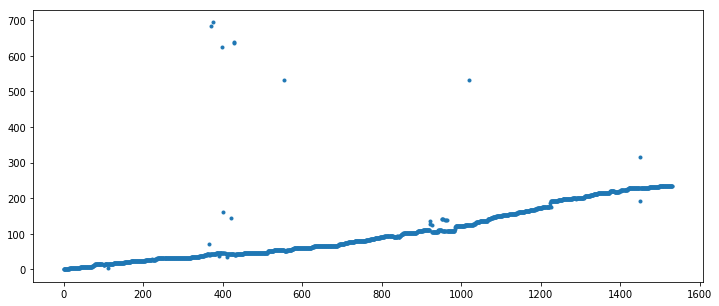

In [516]:
x = []
a = []
for i in range(2000):
    if not i in intName:
        break
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(intNameX[intName[i]] - i)
    if intNameX[intName[i]] - i >300:
        print(i)
plt.plot(x,a,'.')

(-5000, 5000)

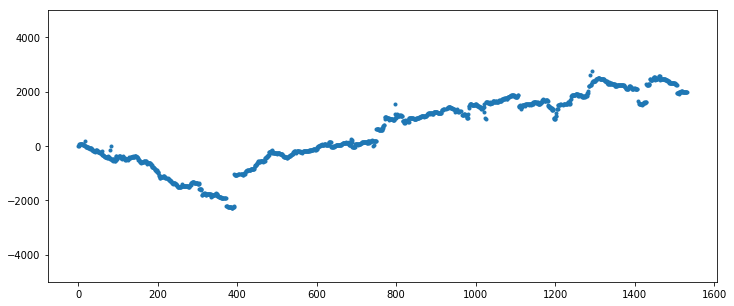

In [517]:
x = []
a = []
for i in range(2000):
    if not i in intName:
        break
    if not intName[i] in intNameX:
        continue
    x.append(i)
    a.append(pos[intName[i]] - position[intName[i]])
plt.plot(x,a,'.')
plt.ylim(-5000,5000)

In [461]:
unvollständiger_graph_plot(
    position, 
    [[a,b,d] for a,b,d in data2 if a in position and b in position],
    von = 380, 
    bis = 410, 
    kantenanzahl=2,
    fehler = 1000)

LP
graph
save


In [462]:
intNameX[438]

'501APD_0'

In [463]:
intName['501APD_0']

370

In [10]:

dataX = [[a,b,d] for a,b,d in data2 if a in position and (b in pre_position or b in position)]
dataY = [[a,b,d] for a,b,d in data2 if a in pre_position and b in pre_position]
unvollständiger_graph_plot(position.copy(),dataX,dataY,von = 36, kantenanzahl=5, fehler = 10000)

{'2341APD_0', '2168APD_0', '692APD_0', '821APD_0', '2098APD_0', '363APD_0', '136APD_0', '1278APD_0', '1754APD_0', '1201APD_0', '575APD_0', '246APD_0', '64APD_0', '1394APD_0', '1448APD_0', '1202APD_0', '1264APD_0', '258APD_0', '1960APD_0', '1611APD_0', '1805APD_0', '1239APD_0', '1434APD_0', '1316APD_0', '2267APD_0', '895APD_0', '1945APD_0', '792APD_0', '2318APD_0', '2360APD_0', '1279APD_0', '1762APD_0', '2384APD_0', '142APD_0', '2264APD_0', '483APD_0', '1064APD_0', '650APD_0', '1221APD_0', '2428APD_0', '1545APD_0', '1736APD_0', '1427APD_0', '1915APD_0', '1116APD_0', '598APD_0', '2082APD_0', '1043APD_0', '1927APD_0', '2278APD_0', '887APD_0', '1769APD_0', '1114APD_0', '390APD_0', '1208APD_0', '1885APD_0', '300APD_0', '983APD_0', '328APD_0', '2007APD_0', '159APD_0', '20APD_0', '655APD_0', '622APD_0', '1602APD_0', '1051APD_0', '1296APD_0', '143APD_0', '257APD_0', '221APD_0', '531APD_0', '2243APD_0', '78APD_0', '1924APD_0', '1510APD_0', '67APD_0', '36APD_0', '733APD_0', '1128APD_0', '2422APD

In [139]:
a = subgraph
gra = nx.DiGraph()
X={143,145,146,147,149,151,152,153,156,157,158,159}
X = set()
for x,y in a.edges:
  #  if intName[x] > 167 or intName[y] > 167:
   #     continue
    if intName[x] in X and intName[y] in X or not intName[x] in X and not intName[y] in X :
        if intName[x] > intName[y]:
            gra.add_edge(intName[y],intName[x],color = 'red')
        else:
            gra.add_edge(intName[x],intName[y])
            
            
#gra = nx.transitive_reduction(gra)
for x,y in a.edges:
   # if intName[x] > 167 or intName[y] > 167:
    #    continue
    if intName[x] in X and intName[y] in X or not intName[x] in X and not intName[y] in X :
        pass
    else:
        if intName[x] > intName[y]:
            gra.add_edge(intName[y],intName[x],color = 'blue')
        else:
            gra.add_edge(intName[x],intName[y],color = 'green')
pydot = nx.nx_pydot.to_pydot(gra)
pydot.set_rankdir('LR')

pydot.write_png('t.png')

In [27]:
gra = nx.DiGraph()
for x,y in a.edges:
    if intName[x] > intName[y]:
        gra.add_edge(intName[y],intName[x],color = 'red')
    else:
        gra.add_edge(intName[x],intName[y])
pydot = nx.nx_pydot.to_pydot(gra)
pydot.set_rankdir('LR')

pydot.write_png('t.png')

KeyboardInterrupt: 

In [74]:
p1 = {'2345APD_0': 0, '1483APD_0': 6662.0, '1395APD_0': 6985.0, '1596APD_0': 9952.629129467889, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16513.62912946789, '577APD_0': 19016.62912946789, '998APD_0': 32313.62912946789, '209APD_0': 34132.62912946789, '1635APD_0': 43535.62912946789, '1911APD_0': 45500.974360969696, '2109APD_0': 45639.62912946789, '996APD_0': 47659.62912946789, '1907APD_0': 48897.97919173, '1481APD_0': 49148.62912946789, '2113APD_0': 55769.62912946789, '1402APD_0': 64348.99773653042, '1332APD_0': 64492.62912946789, '1067APD_0': 67989.62912946788, '225APD_0': 68360.62912946788, '1894APD_0': 77428.62912946788, '2448APD_0': 80411.62912946788, '521APD_0': 80982.62912946788, '2319APD_0': 82899.62912946788, '1076APD_0': 83282.62912946788, '301APD_0': 86439.62912946788, '50APD_0': 88496.62912946788, '2396APD_0': 90523.56143478458, '1980APD_0': 92157.62912946788, '958APD_0': 93237.56143478458, '2050APD_0': 95051.56143478458, '1113APD_0': 99593.56143478458, '960APD_0': 101513.56143478458, '831APD_0': 103144.56143478458, '1877APD_0': 106376.56143478458, '1337APD_0': 107229.56143478458, '1630APD_0': 109233.51166166992, '59APD_0': 114474.62912946788, '542APD_0': 120932.62912946788, '1631APD_0': 124902.62912946788, '176APD_0': 126118.62912946788, '567APD_0': 128321.56143478458, '776APD_0': 130186.56143478458, '86APD_0': 131473.56143478458, '71APD_0': 137926.10979978362, '1529APD_0': 138150.56143478458, '1057APD_0': 138835.56143478458, '1472APD_0': 141008.56143478458, '1714APD_0': 142758.56143478458, '1480APD_0': 145446.38413647152, '1400APD_0': 145967.56143478458, '2058APD_0': 149564.62912946788, '943APD_0': 151223.56143478458, '511APD_0': 151959.06031242787, '1698APD_0': 157350.62912946788, '1903APD_0': 158547.06031242787, '1625APD_0': 163517.06031242787, '2387APD_0': 164035.06031242787, '1317APD_0': 165636.56143478458, '212APD_0': 182587.84750133945, '1857APD_0': 182998.56143478458, '931APD_0': 185957.56143478458, '1771APD_0': 186477.4466261544, '1375APD_0': 186809.56143478458, '156APD_0': 187828.56143478458, '19APD_0': 190545.06031242787, '1252APD_0': 193633.5757946029, '772APD_0': 194368.62912946788, '896APD_0': 195079.5757946029, '2013APD_0': 196792.56143478458, '2322APD_0': 199596.56143478458, '439APD_0': 202521.5757946029, '906APD_0': 203084.54714176292, '948APD_0': 203466.62912946788, '1151APD_0': 205911.56143478458, '1904APD_0': 212305.56143478458, '945APD_0': 214350.56143478458, '2085APD_0': 215004.56143478458, '1779APD_0': 218411.64591132698, '1363APD_0': 219583.64591132698, '1380APD_0': 220369.56143478458, '1921APD_0': 222768.56143478458, '1465APD_0': 224857.56143478458, '579APD_0': 225617.56143478458, '876APD_0': 226067.56143478458, '793APD_0': 227245.06031242787, '1991APD_0': 229432.62912946788, '800APD_0': 232413.1163875288, '571APD_0': 232645.1871288064, '2003APD_0': 232854.62912946788, '1238APD_0': 233381.20667004058, '1397APD_0': 233522.62912946788, '885APD_0': 235086.56143478458, '205APD_0': 235901.62912946788, '2022APD_0': 238706.62912946788, '1409APD_0': 239083.70982165076, '1017APD_0': 239549.56143478458, '277APD_0': 241583.56143478458, '444APD_0': 243331.62912946788, '2312APD_0': 243349.70982165076, '374APD_0': 244130.56143478458, '1866APD_0': 246336.56143478458, '1514APD_0': 246978.56143478458, '1608APD_0': 250780.98135782086, '2197APD_0': 251031.56143478458, '2088APD_0': 252341.62912946788, '580APD_0': 254822.56143478458, '506APD_0': 263994.56143478455, '2458APD_0': 267823.56143478455, '480APD_0': 268700.56143478455, '1246APD_0': 271709.56143478455, '1334APD_0': 272688.56143478455, '466APD_0': 274587.56143478455, '855APD_0': 278921.6291294679, '547APD_0': 279855.6291294679, '318APD_0': 280231.6291294679, '682APD_0': 282074.8637956767, '601APD_0': 282700.6291294679, '1939APD_0': 286055.56143478455, '789APD_0': 287084.56143478455, '242APD_0': 288298.40690459806, '1930APD_0': 288444.0040845461, '1543APD_0': 289302.56143478455, '88APD_0': 291691.6291294679, '1955APD_0': 295392.6291294679, '2380APD_0': 297144.6291294679, '1626APD_0': 298319.6914581534, '1390APD_0': 298580.56143478455, '638APD_0': 300634.56143478455, '216APD_0': 302234.56143478455, '1701APD_0': 307510.6291294679, '684APD_0': 309010.6291294679, '2125APD_0': 310881.56143478455, '764APD_0': 311323.6291294679, '898APD_0': 312138.56143478455, '1966APD_0': 313369.56143478455, '1621APD_0': 313961.56143478455, '157APD_0': 314593.6291294679, '235APD_0': 317903.6291294679, '2029APD_0': 320233.9687087228, '641APD_0': 320542.881663575, '184APD_0': 320859.6291294679, '908APD_0': 321293.84850803536, '2296APD_0': 321826.6291294679, '2122APD_0': 322087.56143478455, '261APD_0': 324311.8758867108, '1942APD_0': 324484.56143478455, '593APD_0': 324630.257171333, '1586APD_0': 325169.6291294679, '2021APD_0': 325220.257171333, '1156APD_0': 329689.1413352799, '986APD_0': 329870.257171333, '850APD_0': 332904.257171333, '1986APD_0': 334310.257171333, '35APD_0': 336076.257171333, '1672APD_0': 341000.257171333, '1445APD_0': 342619.257171333, '1454APD_0': 344388.257171333, '921APD_0': 344716.257171333, '2032APD_0': 349474.08043138386, '1981APD_0': 351947.08043138386, '735APD_0': 353724.08043138386, '740APD_0': 356789.08043138386, '1850APD_0': 358177.257171333, '1967APD_0': 360073.257171333, '1675APD_0': 361884.257171333, '1169APD_0': 362529.08043138386, '1268APD_0': 363278.257171333, '208APD_0': 364794.257171333, '2149APD_0': 366986.257171333, '276APD_0': 369471.08043138386, '98APD_0': 376899.257171333, '874APD_0': 378113.08043138386, '2068APD_0': 378899.257171333, '1137APD_0': 379267.257171333, '2071APD_0': 380021.257171333, '1077APD_0': 380947.257171333, '80APD_0': 381473.257171333, '2011APD_0': 382243.257171333, '379APD_0': 382853.257171333, '1024APD_0': 383316.257171333, '266APD_0': 384358.8434842759, '588APD_0': 384590.257171333, '939APD_0': 388137.257171333, '1433APD_0': 390920.257171333, '1647APD_0': 391335.257171333, '1467APD_0': 394191.257171333, '1192APD_0': 395546.257171333, '335APD_0': 396473.257171333, '2256APD_0': 397654.27528419724, '1038APD_0': 399237.27528419724, '429APD_0': 400330.27528419724, '1595APD_0': 402749.257171333, '2160APD_0': 403054.257171333, '68APD_0': 403631.257171333, '2390APD_0': 404086.6291921967, '1010APD_0': 406481.27528419724, '680APD_0': 409697.27528419724, '1185APD_0': 413498.257171333, '1199APD_0': 414130.257171333, '1574APD_0': 415968.257171333, '2092APD_0': 416715.257171333, '989APD_0': 417086.257171333, '106APD_0': 421188.257171333, '2423APD_0': 428958.257171333, '2434APD_0': 430007.257171333, '2461APD_0': 431566.257171333, '1281APD_0': 434252.257171333, '202APD_0': 438383.257171333, '2350APD_0': 439230.257171333, '90APD_0': 439666.257171333, '2367APD_0': 444548.257171333, '1661APD_0': 448537.257171333, '569APD_0': 450991.257171333, '1309APD_0': 451546.257171333, '690APD_0': 451646.52433239034, '1665APD_0': 452507.257171333, '153APD_0': 454819.27528419724, '1816APD_0': 455597.257171333, '1330APD_0': 457880.27528419724, '2335APD_0': 459802.257171333, '1751APD_0': 460868.257171333, '904APD_0': 464926.257171333, '548APD_0': 465834.257171333, '811APD_0': 469382.257171333, '2415APD_0': 471197.08043138386, '2204APD_0': 472133.08043138386, '196APD_0': 478500.257171333, '714APD_0': 482275.257171333, '31APD_0': 484293.257171333, '656APD_0': 490619.27528419724, '1410APD_0': 499803.27528419724, '1852APD_0': 504119.27528419724, '151APD_0': 506115.27528419724, '978APD_0': 519102.2620642347, '861APD_0': 519315.08043138386, '187APD_0': 520003.08043138386, '1162APD_0': 529280.2571713331, '459APD_0': 530061.2571713331, '2261APD_0': 533311.5978892214, '57APD_0': 534263.2571713331, '900APD_0': 535181.0804313838, '766APD_0': 536021.2571713331, '189APD_0': 536849.2571713331, '1815APD_0': 550518.2571713331, '2205APD_0': 552679.2752841972, '58APD_0': 558103.2752841972, '11APD_0': 588106.2752841972, '1783APD_0': 594705.2752841972, '407APD_0': 594905.2752841972, '2394APD_0': 596659.2752841972, '694APD_0': 598091.6734560011, '491APD_0': 598242.2752841972, '2075APD_0': 598245.2752841972, '462APD_0': 598412.2752841972, '69APD_0': 600273.2752841972, '1022APD_0': 601145.2752841972, '681APD_0': 605795.2752841972, '2110APD_0': 608773.2752841972, '1374APD_0': 611794.2752841972, '1773APD_0': 612135.2752841972, '94APD_0': 616451.2752841972, '1721APD_0': 624903.2752841972, '2410APD_0': 629742.2752841972, '89APD_0': 636772.2752841972, '1366APD_0': 640543.2752841972, '1651APD_0': 641082.2358741795, '119APD_0': 647267.2358741795, '572APD_0': 657587.2358741795, '2155APD_0': 667591.2752841972, '708APD_0': 673302.2752841972, '1522APD_0': 674833.2752841972, '134APD_0': 676216.2752841972, '525APD_0': 679121.2752841972, '1729APD_0': 679543.6360895482, '597APD_0': 682050.2752841972, '2134APD_0': 690301.5484197811, '75APD_0': 690468.2752841972, '497APD_0': 702112.2752841972, '589APD_0': 702819.3738567417, '464APD_0': 703746.2752841972, '1474APD_0': 704497.2752841972, '565APD_0': 705430.2752841972, '653APD_0': 708340.2752841972, '391APD_0': 708951.2752841972, '1507APD_0': 721163.2752841972, '167APD_0': 721727.2752841972, '2337APD_0': 730123.2752841972, '385APD_0': 731232.2752841972, '307APD_0': 732678.2752841972, '1261APD_0': 743129.2752841972, '1691APD_0': 744444.7083303868, '452APD_0': 745117.7083303868, '781APD_0': 768201.7083303868, '1753APD_0': 769203.7083303868, '1523APD_0': 774613.7083303868, '995APD_0': 780641.7083303868, '2460APD_0': 785549.7083303868, '1033APD_0': 787654.7083303868, '568APD_0': 789096.7083303868, '1970APD_0': 795976.7083303868, '820APD_0': 803064.7083303868, '77APD_0': 803786.7083303868, '1258APD_0': 805424.7083303868, '1265APD_0': 811002.7083303868, '1253APD_0': 813421.7083303868, '73APD_0': 817259.7083303868, '1460APD_0': 825897.7083303868, '376APD_0': 831275.7083303868, '806APD_0': 846466.9765077822, '2250APD_0': 850501.9765077822, '2358APD_0': 858357.7083303868, '3APD_0': 858698.7083303868, '573APD_0': 862852.7083303868, '48APD_0': 871754.7083303868, '1055APD_0': 877163.4118391742, '117APD_0': 881888.4118391742, '639APD_0': 890732.8398599977, '2211APD_0': 895448.8398599977, '802APD_0': 897954.8398599977, '2077APD_0': 905328.8398599977, '1177APD_0': 919079.8398599977, '1679APD_0': 923042.8398599977, '1073APD_0': 924487.8398599977, '1249APD_0': 945361.8398599977, '1506APD_0': 948039.8398599977, '783APD_0': 949309.8398599977, '609APD_0': 956394.3409622661, '1335APD_0': 967935.8398599977, '742APD_0': 970202.8398599977, '1835APD_0': 971082.8398599977, '1837APD_0': 972153.8398599977, '367APD_0': 975209.0882784848, '2038APD_0': 977891.0882784848, '398APD_0': 989318.0882784848, '2275APD_0': 995618.0882784848, '877APD_0': 997202.0882784848, '2351APD_0': 998361.6256076854, '543APD_0': 1000835.6256076854, '551APD_0': 1003720.6256076854, '62APD_0': 1012857.6256076854, '1048APD_0': 1014958.6256076854, '2019APD_0': 1017753.6448988944, '2114APD_0': 1018075.6256076854, '399APD_0': 1018410.6256076854, '1147APD_0': 1018999.6998492965, '1286APD_0': 1019011.0021129163, '232APD_0': 1019156.6256076854, '1145APD_0': 1019751.6256076854, '1453APD_0': 1020065.6256076854, '2412APD_0': 1023639.6256076854, '1798APD_0': 1031673.6256076854, '23APD_0': 1032457.6256076854, '1121APD_0': 1034946.2285192271, '265APD_0': 1035967.6256076854, '1063APD_0': 1036571.6256076854, '1817APD_0': 1038409.6256076854, '2112APD_0': 1041711.6256076854, '1893APD_0': 1042865.665465096, '2190APD_0': 1047098.665465096, '1568APD_0': 1047593.665465096, '337APD_0': 1048334.6256076854, '980APD_0': 1051252.665465096, '623APD_0': 1052007.665465096, '2001APD_0': 1053717.9322083036, '745APD_0': 1053997.3151978015, '881APD_0': 1055040.4673684714, '351APD_0': 1055308.665465096, '1692APD_0': 1059992.0727523186, '2015APD_0': 1060145.665465096, '2339APD_0': 1063132.665465096, '670APD_0': 1064216.665465096, '1054APD_0': 1064870.665465096, '1059APD_0': 1065334.665465096, '2426APD_0': 1065640.6256076854, '1990APD_0': 1066572.6256076854, '410APD_0': 1066958.3151978015, '358APD_0': 1067447.3151978015, '195APD_0': 1071262.3151978015, '1878APD_0': 1076413.665465096, '788APD_0': 1077468.665465096, '2223APD_0': 1078373.665465096, '1935APD_0': 1078852.665465096, '1583APD_0': 1080088.260518361, '1785APD_0': 1083503.6456487272, '1789APD_0': 1084097.3151978015, '596APD_0': 1085069.3537295726, '99APD_0': 1085594.5252660874, '1097APD_0': 1085614.3151978015, '944APD_0': 1090003.3151978015, '516APD_0': 1091214.0154590919, '1895APD_0': 1091461.3151978015, '654APD_0': 1092251.2584726217, '1544APD_0': 1092586.3151978015, '2368APD_0': 1093870.3151978015, '244APD_0': 1094755.7053921963, '229APD_0': 1095065.3151978015, '2331APD_0': 1095382.3151978015, '414APD_0': 1096145.3151978015, '2247APD_0': 1097680.3151978015, '2173APD_0': 1099541.665465096, '1730APD_0': 1100221.3151978015, '2249APD_0': 1100798.264423972, '2142APD_0': 1101202.665465096, '219APD_0': 1102652.3151978015, '1607APD_0': 1105968.3151978015, '12APD_0': 1109599.3151978015, '2459APD_0': 1110188.3151978015, '501APD_0': 1110582.3151978015, '182APD_0': 1113423.3151978015, '2195APD_0': 1113661.3151978015, '1742APD_0': 1115320.9942401303, '18APD_0': 1115373.3151978015, '316APD_0': 1116423.9942401303, '1259APD_0': 1120579.3151978015, '2356APD_0': 1120825.6766530469, '131APD_0': 1120866.9942401303, '1011APD_0': 1120989.2727934518, '1693APD_0': 1122335.3151978015, '2440APD_0': 1122397.95738019, '751APD_0': 1122416.9942401303, '909APD_0': 1122714.3151978015, '1160APD_0': 1122745.3151978015, '853APD_0': 1123137.3151978015, '486APD_0': 1123183.3151978015, '2324APD_0': 1123262.9942401303, '477APD_0': 1123614.2727934518, '113APD_0': 1123641.2727934518, '640APD_0': 1123700.3151978015, '230APD_0': 1123836.3151978015, '432APD_0': 1125260.3151978015, '428APD_0': 1125560.3151978015, '1933APD_0': 1126017.7954307378, '1818APD_0': 1126312.3151978015, '145APD_0': 1126627.3151978015, '544APD_0': 1126889.3151978015, '1449APD_0': 1127405.3151978015, '1923APD_0': 1127544.593649632, '2301APD_0': 1127947.3151978015, '2048APD_0': 1130220.3151978015, '1049APD_0': 1130823.3151978015, '1391APD_0': 1131566.3151978015, '440APD_0': 1132228.2760649142, '40APD_0': 1134104.2727934518, '672APD_0': 1137338.3151978015, '290APD_0': 1139419.3151978015, '1874APD_0': 1142604.3065601313, '2091APD_0': 1145804.3151978015, '2066APD_0': 1146508.2727934518, '1885APD_0': 1147093.3065601313, '1224APD_0': 1147792.7909218983, '1285APD_0': 1148090.1685180257, '1279APD_0': 1148467.3065601313, '483APD_0': 1149169.2727934518, '650APD_0': 1149679.3065601313, '221APD_0': 1151883.8910015253, '633APD_0': 1152029.0568729816, '53APD_0': 1152196.3065601313, '1929APD_0': 1152497.8910015253, '445APD_0': 1153069.8910015253, '72APD_0': 1153072.8910015253, '291APD_0': 1154295.3065601313, '2043APD_0': 1154785.1685180257, '1768APD_0': 1155676.8507070413, '220APD_0': 1156998.3065601313, '300APD_0': 1157071.2727934518, '2178APD_0': 1157786.3151978015, '1959APD_0': 1158600.7909218983, '658APD_0': 1159246.3151978015, '1263APD_0': 1159805.8989148864, '744APD_0': 1160023.3065601313, '1208APD_0': 1160817.1685180257, '576APD_0': 1161204.3065601313, '346APD_0': 1161219.3151978015, '1811APD_0': 1161697.4081315424, '369APD_0': 1161965.3065601313, '1510APD_0': 1162723.2727934518, '1114APD_0': 1164919.2727934518, '2278APD_0': 1167812.1685180257, '326APD_0': 1182778.1685180257, '1379APD_0': 1183151.1685180257, '1554APD_0': 1184152.1685180257, '411APD_0': 1184415.1685180257, '422APD_0': 1185038.1685180257, '560APD_0': 1188990.8112885284, '20APD_0': 1189291.1685180257, '1296APD_0': 1197094.1685180257, '143APD_0': 1199191.1685180257, '887APD_0': 1201992.1685180257, '249APD_0': 1203388.7375073894, '2341APD_0': 1207010.1685180257, '257APD_0': 1208906.1685180257, '246APD_0': 1209769.7375073894, '201APD_0': 1210310.7375073894, '1924APD_0': 1213032.7375073894, '1769APD_0': 1213098.7375073894, '271APD_0': 1213497.7375073894, '342APD_0': 1217477.7375073894, '84APD_0': 1233241.7375073894, '14APD_0': 1240163.7375073894, '2060APD_0': 1247297.7946405439, '1629APD_0': 1247624.7946405439, '970APD_0': 1247994.7946405439, '132APD_0': 1259847.7946405439, '279APD_0': 1264669.7946405439, '737APD_0': 1270542.7946405439, '211APD_0': 1271822.7946405439, '1948APD_0': 1357547.7946405439, '1822APD_0': 1358767.7946405439, '494APD_0': 1362624.7946405439, '2455APD_0': 1364127.4020261494, '2399APD_0': 1368090.4020261494, '1572APD_0': 1369226.4020261494, '999APD_0': 1370728.7946405439, '2141APD_0': 1372771.4020261494, '485APD_0': 1373483.7946405439, '484APD_0': 1384599.7946405439, '51APD_0': 1391355.7946405439, '253APD_0': 1393549.7946405439, '454APD_0': 1394239.7946405439, '2391APD_0': 1398655.67079865, '994APD_0': 1404606.7946405439, '361APD_0': 1406102.7946405439, '1599APD_0': 1413390.67079865, '2046APD_0': 1416466.1538443367, '2231APD_0': 1416871.8018440905, '891APD_0': 1417284.67079865, '555APD_0': 1417579.67079865, '1412APD_0': 1427760.67079865, '1922APD_0': 1428198.67079865, '1750APD_0': 1429960.67079865, '903APD_0': 1434273.67079865, '724APD_0': 1436266.7946405439, '1276APD_0': 1436703.67079865, '1634APD_0': 1437835.67079865, '2102APD_0': 1440544.67079865, '1747APD_0': 1448014.7946405439, '1416APD_0': 1448782.7946405439, '1191APD_0': 1449975.7946405439, '1706APD_0': 1451420.7946405439, '1941APD_0': 1452584.7946405439, '2172APD_0': 1456421.7946405439, '2004APD_0': 1458140.776255187, '210APD_0': 1462068.67079865, '2370APD_0': 1464444.776255187, '273APD_0': 1465205.776255187, '553APD_0': 1474179.5144219385, '894APD_0': 1474320.7946405439, '1908APD_0': 1476334.7946405439, '1749APD_0': 1479170.3895348292, '559APD_0': 1480457.3895348292, '1441APD_0': 1484488.3895348292, '350APD_0': 1486241.3895348292, '1240APD_0': 1490630.3895348292, '2287APD_0': 1494420.7946405439, '1368APD_0': 1498603.3895348292, '381APD_0': 1503163.3895348292, '1181APD_0': 1512723.3895348292, '768APD_0': 1515647.3895348292, '2073APD_0': 1516719.3895348292, '722APD_0': 1519147.3895348292, '441APD_0': 1521267.3895348292, '1386APD_0': 1523633.3895348292, '955APD_0': 1524686.3895348292, '1812APD_0': 1527176.3895348292, '2269APD_0': 1528853.3895348292, '1002APD_0': 1531980.3895348292, '1195APD_0': 1533757.3895348292, '2039APD_0': 1540208.3895348292, '1473APD_0': 1542398.3895348292, '1003APD_0': 1543606.3895348292, '964APD_0': 1544343.3895348292, '902APD_0': 1545340.3895348292, '1883APD_0': 1549081.3895348292, '1440APD_0': 1549455.3895348292, '1406APD_0': 1550748.3895348292, '1880APD_0': 1553471.3895348292, '859APD_0': 1556439.3895348292, '2020APD_0': 1558285.3895348292, '610APD_0': 1561514.3895348292, '1035APD_0': 1562720.3895348292, '975APD_0': 1563851.3895348292, '1491APD_0': 1565697.3895348292, '2159APD_0': 1567535.3895348292, '1689APD_0': 1573189.3895348292, '1417APD_0': 1575514.3895348292, '755APD_0': 1576398.3895348292, '1415APD_0': 1577529.3895348292, '817APD_0': 1580684.3895348292, '1223APD_0': 1581087.3895348292, '1355APD_0': 1584053.3895348292, '1823APD_0': 1584354.3895348292, '2286APD_0': 1586046.3895348292, '564APD_0': 1588472.3895348292, '1346APD_0': 1591622.3895348292, '332APD_0': 1592369.3895348292, '384APD_0': 1609065.3895348292, '240APD_0': 1612994.3895348292, '1508APD_0': 1619593.3895348292, '2212APD_0': 1619968.3895348292, '549APD_0': 1627228.3895348292, '777APD_0': 1632873.4354008674, '1006APD_0': 1633479.3895348292, '1978APD_0': 1636075.3895348292, '2037APD_0': 1638321.3895348292, '2182APD_0': 1644249.3895348292, '2395APD_0': 1646510.3895348292, '1828APD_0': 1649150.7024242864, '380APD_0': 1649437.8656787337, '510APD_0': 1651212.8656787337, '963APD_0': 1651764.8639146565, '2349APD_0': 1651813.8656787337, '147APD_0': 1659237.3895348292, '149APD_0': 1663359.5477789494, '2323APD_0': 1663522.3895348292, '2188APD_0': 1667030.9326679835, '357APD_0': 1667620.3895348292, '1644APD_0': 1669619.8656787337, '1968APD_0': 1671655.8656787337, '676APD_0': 1673723.8656787337, '1030APD_0': 1679506.8656787337, '1354APD_0': 1681539.8656787337, '2157APD_0': 1686075.8656787337, '1977APD_0': 1688430.8656787337, '2056APD_0': 1691835.8656787337, '2148APD_0': 1694571.8656787337, '1451APD_0': 1695384.5405103844, '280APD_0': 1696411.5405103844, '1799APD_0': 1701293.5405103844, '743APD_0': 1704628.8656787337, '878APD_0': 1705476.5405103844, '1809APD_0': 1706603.8656787337, '1752APD_0': 1711449.8656787337, '1744APD_0': 1713816.8656787337, '1150APD_0': 1716487.8656787337, '2297APD_0': 1718195.8656787337, '2000APD_0': 1720818.8656787337, '1503APD_0': 1722749.8656787337, '476APD_0': 1724356.8656787337, '1405APD_0': 1740312.8656787337, '523APD_0': 1742450.8656787337, '394APD_0': 1760790.8656787337, '1000APD_0': 1763075.5002178012, '178APD_0': 1763456.8656787337, '498APD_0': 1764723.8656787337, '251APD_0': 1773199.8656787337, '2083APD_0': 1776686.8656787337, '1389APD_0': 1778078.8656787337, '1358APD_0': 1780042.8656787337, '2413APD_0': 1784109.8656787337, '779APD_0': 1784869.7458727919, '758APD_0': 1785413.3079808725, '325APD_0': 1785423.8656787337, '927APD_0': 1796713.8656787337, '365APD_0': 1799318.8656787337, '1096APD_0': 1812219.8656787337, '1704APD_0': 1812685.8656787337, '2118APD_0': 1813861.8656787337, '408APD_0': 1816189.8656787337, '936APD_0': 1816747.8656787337, '311APD_0': 1817262.8656787337, '1155APD_0': 1823481.8656787337, '1920APD_0': 1824899.8656787337, '1369APD_0': 1825301.8656787337, '1851APD_0': 1827203.8656787337, '1547APD_0': 1830062.8656787337, '1428APD_0': 1831803.8656787337, '892APD_0': 1834876.8656787337, '148APD_0': 1838002.8656787337, '2044APD_0': 1839262.8656787337, '2378APD_0': 1841528.8656787337, '827APD_0': 1841882.8656787337, '2227APD_0': 1842982.8656787337, '2429APD_0': 1843783.8656787337, '982APD_0': 1845258.4225328036, '2051APD_0': 1846456.4225328036, '835APD_0': 1846971.4225328036, '1404APD_0': 1849110.8656787337, '738APD_0': 1851867.4225328036, '720APD_0': 1852339.001259104, '1552APD_0': 1852580.4225328036, '727APD_0': 1855422.8656787337, '631APD_0': 1856434.8656787337, '748APD_0': 1859376.8656787337, '1347APD_0': 1860875.8656787337, '217APD_0': 1862782.8656787337, '527APD_0': 1867531.8656787337, '529APD_0': 1868385.8656787337, '1946APD_0': 1871038.8656787337, '1104APD_0': 1871729.8656787337, '759APD_0': 1872476.8656787337, '188APD_0': 1874945.8656787337, '1825APD_0': 1875983.8656787337, '320APD_0': 1876697.8656787337, '1860APD_0': 1879165.8656787337, '1926APD_0': 1879580.8656787337, '2398APD_0': 1880355.8656787337, '125APD_0': 1889262.8656787337, '1711APD_0': 1895710.8656787337, '1845APD_0': 1899204.187720042, '1928APD_0': 1901206.187720042, '2187APD_0': 1903036.8656787337, '1733APD_0': 1904668.8656787337, '1176APD_0': 1905835.8656787337, '55APD_0': 1907023.8656787337, '1157APD_0': 1908487.8656787337, '716APD_0': 1913438.8656787337, '1870APD_0': 1914361.703219165, '1570APD_0': 1914650.8656787337, '6APD_0': 1915550.8656787337, '1436APD_0': 1918251.8656787337, '2326APD_0': 1918729.8656787337, '1535APD_0': 1919582.187720042, '1143APD_0': 1920273.187720042, '1171APD_0': 1920584.8656787337, '1408APD_0': 1921240.8656787337, '2379APD_0': 1926384.8656787337, '463APD_0': 1927060.8656787337, '1140APD_0': 1928774.4255988095, '2076APD_0': 1930732.8656787337, '1174APD_0': 1931170.4255988095, '347APD_0': 1932703.8656787337, '1283APD_0': 1933206.8656787337, '1649APD_0': 1934629.8656787337, '2164APD_0': 1935370.4033982917, '1241APD_0': 1935690.6335232467, '1413APD_0': 1935860.8656787337, '2099APD_0': 1937137.8656787337, '2409APD_0': 1938490.8656787337, '1103APD_0': 1939158.8656787337, '1088APD_0': 1939549.8656787337, '1036APD_0': 1944865.8656787337, '2255APD_0': 1946959.4875150041, '1485APD_0': 1947277.8656787337, '1819APD_0': 1953260.8656787337, '1456APD_0': 1954180.8656787337, '285APD_0': 1957187.8656787337, '2369APD_0': 1959849.8656787337, '1827APD_0': 1961669.8656787337, '2108APD_0': 1962417.8656787337, '2293APD_0': 1962863.8656787337, '168APD_0': 1965163.8656787337, '545APD_0': 1967990.8656787337, '1937APD_0': 1968316.8656787337, '2359APD_0': 1969984.8656787337, '1393APD_0': 1971313.8656787337, '356APD_0': 1971947.8656787337, '1385APD_0': 1973695.8656787337, '2APD_0': 1974551.8656787337, '1321APD_0': 1976312.337228493, '109APD_0': 1976625.8656787337, '2145APD_0': 1977489.8656787337, '1776APD_0': 1978403.8656787337, '1717APD_0': 1979025.8656787337, '1886APD_0': 1979991.8656787337, '2203APD_0': 1980525.8656787337, '1458APD_0': 1981725.8656787337, '1457APD_0': 1983517.8656787337, '1746APD_0': 1984072.3670440437, '946APD_0': 1986266.8656787337, '1716APD_0': 1987270.3637718277, '1549APD_0': 1987532.8656787337, '1351APD_0': 1989227.8656787337, '988APD_0': 1989740.0078813138, '518APD_0': 1990330.0078813138, '1164APD_0': 1991052.0078813138, '1132APD_0': 1996133.3670440437, '882APD_0': 1997349.3670440437, '778APD_0': 1999671.3670440437, '1696APD_0': 2002508.3670440437, '675APD_0': 2003260.3670440437, '590APD_0': 2006351.0078813138, '1197APD_0': 2008515.3670440437, '1009APD_0': 2010744.2758939357, '1764APD_0': 2011089.0078813138, '1756APD_0': 2012860.3670440437, '990APD_0': 2013478.0078813138, '683APD_0': 2014273.0078813138, '191APD_0': 2017103.3670440437, '1925APD_0': 2017794.3670440437, '785APD_0': 2018197.3670440437, '1479APD_0': 2019787.3670440437, '813APD_0': 2020448.3670440437, '519APD_0': 2022817.3670440437, '1031APD_0': 2023440.3670440437, '884APD_0': 2025858.3670440437, '1723APD_0': 2030790.3670440437, '1515APD_0': 2031755.3670440437, '308APD_0': 2032106.3670440437, '2305APD_0': 2032586.3670440437, '797APD_0': 2033955.3670440437, '1231APD_0': 2034515.3670440437, '2009APD_0': 2035945.3670440437, '331APD_0': 2036324.9916671154, '1524APD_0': 2036720.3670440437, '1084APD_0': 2038272.3670440437, '2002APD_0': 2039605.3670440437, '1272APD_0': 2039915.3670440437, '104APD_0': 2040785.3670440437, '1992APD_0': 2043948.8803053282, '1826APD_0': 2044186.3670440437, '1255APD_0': 2044762.4402223702, '1301APD_0': 2045123.3670440437, '478APD_0': 2047332.3670440437, '340APD_0': 2052897.3670440437, '2277APD_0': 2054605.3670440437, '315APD_0': 2057442.3670440437, '1528APD_0': 2060179.3670440437, '1256APD_0': 2064806.3670440437, '2404APD_0': 2065216.1638246302, '1356APD_0': 2066831.3670440437, '1065APD_0': 2067129.4820184188, '2193APD_0': 2067415.3670440437, '1499APD_0': 2069821.3670440437, '1090APD_0': 2070673.3670440437, '1136APD_0': 2072090.917897817, '1244APD_0': 2072377.7903695449, '1957APD_0': 2072595.3670440437, '1210APD_0': 2073720.3670440437, '1443APD_0': 2074210.3670440437, '1106APD_0': 2074790.5790239677, '314APD_0': 2074798.3670440437, '1867APD_0': 2077609.3670440437, '1101APD_0': 2079089.345853126, '1117APD_0': 2081003.3670440437, '1862APD_0': 2083027.345853126, '621APD_0': 2084546.1319722782, '79APD_0': 2084906.3670440437, '1228APD_0': 2091993.519930348, '1025APD_0': 2092273.3670440437, '1487APD_0': 2092950.3670440437, '101APD_0': 2094022.3670440437, '389APD_0': 2095507.3670440437, '93APD_0': 2098144.3670440437, '1781APD_0': 2101134.8517980087, '1858APD_0': 2101456.424889537, '403APD_0': 2101669.3670440437, '920APD_0': 2106198.3670440437, '857APD_0': 2110037.3670440437, '1179APD_0': 2111903.3670440437, '1149APD_0': 2113403.3670440437, '2097APD_0': 2114201.952880123, '70APD_0': 2114517.3670440437, '61APD_0': 2119143.3670440437, '1934APD_0': 2122161.5119495085, '2435APD_0': 2122517.3670440437, '1600APD_0': 2123156.5119495085, '1242APD_0': 2124080.3670440437, '1578APD_0': 2124614.6330336304, '750APD_0': 2125500.9427504623, '1314APD_0': 2125767.5119495085, '856APD_0': 2126392.3670440437, '1189APD_0': 2127665.3670440437, '359APD_0': 2132695.3670440437, '1227APD_0': 2136166.3670440437, '1720APD_0': 2141158.3670440437, '1646APD_0': 2144753.9500553603, '1323APD_0': 2144945.3670440437, '846APD_0': 2148676.3670440437, '492APD_0': 2149868.3670440437, '1633APD_0': 2150932.3670440437, '226APD_0': 2151280.4563134015, '1213APD_0': 2153569.3670440437, '1876APD_0': 2154918.3670440437, '624APD_0': 2159221.3670440437, '2103APD_0': 2161472.3670440437, '2239APD_0': 2162381.2804021463, '2140APD_0': 2162543.3670440437, '1085APD_0': 2163321.3670440437, '1007APD_0': 2164463.3670440437, '185APD_0': 2165943.6743434225, '1842APD_0': 2168911.3670440437, '1275APD_0': 2170146.3670440437, '2153APD_0': 2170838.3670440437, '312APD_0': 2171955.4563134015, '752APD_0': 2173933.4563134015, '2209APD_0': 2176282.4563134015, '1520APD_0': 2176971.4563134015, '2081APD_0': 2178081.4563134015, '1605APD_0': 2180216.4563134015, '536APD_0': 2182641.4563134015, '1551APD_0': 2184150.3670440437, '1847APD_0': 2184480.49678819, '608APD_0': 2184650.4563134015, '2089APD_0': 2185107.534981286, '2346APD_0': 2185244.4563134015, '666APD_0': 2190873.191051974, '668APD_0': 2191130.1947437446, '1645APD_0': 2191826.1947437446, '286APD_0': 2196399.4563134015, '814APD_0': 2203325.1947437446, '138APD_0': 2204411.4563134015, '1148APD_0': 2207729.4563134015, '1641APD_0': 2209911.1947437446, '38APD_0': 2212149.4563134015, '880APD_0': 2217340.4563134015, '2450APD_0': 2219708.4563134015, '177APD_0': 2220050.4563134015, '2316APD_0': 2221926.4563134015, '1498APD_0': 2226689.4563134015, '224APD_0': 2228644.4563134015, '976APD_0': 2234425.4563134015, '1954APD_0': 2239171.4563134015, '1341APD_0': 2240595.4563134015, '2052APD_0': 2241223.4563134015, '1770APD_0': 2242606.4563134015, '1289APD_0': 2243375.4563134015, '890APD_0': 2243777.895657625, '739APD_0': 2244098.4563134015, '1975APD_0': 2244581.4563134015, '916APD_0': 2251009.357057508, '1247APD_0': 2251366.4563134015, '950APD_0': 2253458.4563134015, '809APD_0': 2264245.4563134015, '1655APD_0': 2265031.4563134015, '2279APD_0': 2266598.4563134015, '2040APD_0': 2269571.4563134015, '1965APD_0': 2270686.4563134015, '438APD_0': 2272612.738372806, '2131APD_0': 2272995.552757189, '1122APD_0': 2276419.552757189, '602APD_0': 2278390.552757189, '1280APD_0': 2280777.552757189, '475APD_0': 2282404.552757189, '2230APD_0': 2286309.552757189, '1387APD_0': 2286860.8621521834, '1262APD_0': 2286903.4563134015, '436APD_0': 2286958.1611404982, '873APD_0': 2287206.552757189, '128APD_0': 2287573.384496199, '774APD_0': 2290510.552757189, '1538APD_0': 2292675.552757189, '556APD_0': 2295865.552757189, '2406APD_0': 2297372.552757189, '1671APD_0': 2299637.552757189, '1938APD_0': 2300081.552757189, '524APD_0': 2304547.552757189, '1767APD_0': 2311036.552757189, '193APD_0': 2313272.552757189, '1636APD_0': 2317415.552757189, '227APD_0': 2317737.552757189, '1360APD_0': 2323653.396569276, '528APD_0': 2325433.552757189, '1146APD_0': 2328143.790635954, '1079APD_0': 2328413.552757189, '126APD_0': 2329227.552757189, '368APD_0': 2330106.552757189, '1836APD_0': 2331413.552757189, '431APD_0': 2334705.552757189, '2237APD_0': 2341844.552757189, '1102APD_0': 2345223.552757189, '566APD_0': 2347560.552757189, '756APD_0': 2350064.552757189, '1919APD_0': 2353029.552757189, '1421APD_0': 2357350.552757189, '1814APD_0': 2358346.552757189, '1383APD_0': 2360063.218369714, '2062APD_0': 2361774.552757189, '2290APD_0': 2366583.552757189, '973APD_0': 2367382.552757189, '2023APD_0': 2372279.1601659604, '1843APD_0': 2372630.1601659604, '604APD_0': 2373398.1601659604, '1099APD_0': 2377113.1601659604, '2055APD_0': 2378728.1601659604, '1871APD_0': 2382043.1601659604, '826APD_0': 2383627.552757189, '1732APD_0': 2388211.1601659604, '1172APD_0': 2389356.1601659604, '2192APD_0': 2390668.032434722, '1971APD_0': 2392126.032434722, '2219APD_0': 2394545.1601659604, '1348APD_0': 2398436.1601659604, '170APD_0': 2399123.1601659604, '461APD_0': 2403035.1601659604, '96APD_0': 2404264.1830212045, '2432APD_0': 2404519.1601659604, '127APD_0': 2405939.1601659604, '2189APD_0': 2406627.1601659604, '1532APD_0': 2407446.1601659604, '1979APD_0': 2412724.1601659604, '578APD_0': 2414329.1601659604, '121APD_0': 2416363.328686155, '2327APD_0': 2416765.1601659604, '1774APD_0': 2416868.2700849194, '1066APD_0': 2417265.1601659604, '773APD_0': 2419566.1601659604, '1502APD_0': 2420043.1601659604, '1226APD_0': 2420414.1601659604, '1091APD_0': 2421316.1601659604, '1362APD_0': 2422227.3316506543, '2184APD_0': 2422605.1601659604, '324APD_0': 2427110.1601659604, '706APD_0': 2427461.1601659604, '424APD_0': 2427848.470492531, '1563APD_0': 2428396.1601659604, '910APD_0': 2432023.1601659604, '929APD_0': 2434726.1601659604, '1361APD_0': 2436639.1601659604, '780APD_0': 2440695.619448097, '1993APD_0': 2440842.1601659604, '2315APD_0': 2444421.1601659604, '616APD_0': 2445690.2574312687, '102APD_0': 2448201.1601659604, '287APD_0': 2453860.2574312687, '1204APD_0': 2457767.1601659604, '1273APD_0': 2460086.1601659604, '2454APD_0': 2463867.1601659604, '1902APD_0': 2466703.1601659604, '130APD_0': 2469164.1601659604, '1205APD_0': 2469738.1601659604, '1159APD_0': 2470469.1601659604, '1349APD_0': 2471871.1601659604, '619APD_0': 2475204.1601659604, '1669APD_0': 2477160.1601659604, '1620APD_0': 2479423.1601659604, '360APD_0': 2480289.1601659604, '1708APD_0': 2487141.1601659604, '2330APD_0': 2487896.1601659604, '313APD_0': 2491026.1601659604, '1037APD_0': 2494324.1601659604, '1562APD_0': 2496843.1601659604, '2226APD_0': 2499860.1601659604, '141APD_0': 2505334.1601659604, '2438APD_0': 2506921.1601659604, '1373APD_0': 2509352.1601659604, '382APD_0': 2510025.7363465196, '63APD_0': 2510567.1601659604, '2320APD_0': 2515731.1601659604, '888APD_0': 2518482.1601659604, '917APD_0': 2520436.1601659604, '1225APD_0': 2521121.1601659604, '1040APD_0': 2523542.219887649, '1142APD_0': 2523783.1601659604, '824APD_0': 2525773.1601659604, '2285APD_0': 2526659.8752621002, '2202APD_0': 2526964.1601659604, '274APD_0': 2528477.1601659604, '2400APD_0': 2529125.808173614, '1021APD_0': 2529346.3550078785, '526APD_0': 2529879.1601659604, '1290APD_0': 2530628.7248081616, '17APD_0': 2530896.3550078785, '1685APD_0': 2531375.1601659604, '522APD_0': 2534552.1601659604, '2174APD_0': 2537205.1601659604, '509APD_0': 2537597.1601659604, '1804APD_0': 2537943.1601659604, '2259APD_0': 2540300.1601659604, '1582APD_0': 2542860.1601659604, '844APD_0': 2544688.1601659604, '922APD_0': 2545548.1601659604, '2342APD_0': 2546308.1601659604, '795APD_0': 2548441.1601659604, '1830APD_0': 2549289.1601659604, '1580APD_0': 2551743.725373424, '1536APD_0': 2552059.1601659604, '2225APD_0': 2554094.1601659604, '1207APD_0': 2555182.1601659604, '2036APD_0': 2555537.1601659604, '2340APD_0': 2557250.1601659604, '834APD_0': 2557789.1601659604, '563APD_0': 2560104.1601659604, '1699APD_0': 2560475.1601659604, '1748APD_0': 2562231.1601659604, '1475APD_0': 2563818.1601659604, '433APD_0': 2564813.0553585133, '2200APD_0': 2565126.1601659604, '405APD_0': 2566848.1601659604, '1125APD_0': 2568417.1601659604, '1505APD_0': 2575499.1601659604, '2034APD_0': 2577034.1601659604, '1617APD_0': 2578393.1601659604, '1220APD_0': 2579530.1601659604, '862APD_0': 2580003.1601659604, '1640APD_0': 2586028.1601659604, '504APD_0': 2586699.1601659604, '49APD_0': 2592846.8627615133, '116APD_0': 2603258.8627615133, '2169APD_0': 2618614.8627615133, '1420APD_0': 2622084.8627615133, '1657APD_0': 2623733.8627615133, '849APD_0': 2627929.8627615133, '1471APD_0': 2639429.8627615133, '1560APD_0': 2643824.7858176967, '618APD_0': 2644250.8627615133, '303APD_0': 2644798.8627615133, '15APD_0': 2647512.8627615133, '2210APD_0': 2651537.8627615133, '430APD_0': 2654293.8627615133, '319APD_0': 2666238.8627615133, '1612APD_0': 2669201.8627615133, '64APD_0': 2725297.8627615133, '1211APD_0': 2726616.5969145456, '465APD_0': 2730786.8627615133, '159APD_0': 2734735.8627615133, '2007APD_0': 2741390.8627615133, '2243APD_0': 2743682.8627615133, '78APD_0': 2744238.8627615133, '655APD_0': 2744877.8627615133, '1427APD_0': 2751075.8627615133, '1316APD_0': 2763739.8627615133, '2086APD_0': 2767092.909778857, '1338APD_0': 2768109.8627615133, '1611APD_0': 2768730.8627615133, '142APD_0': 2772840.8627615133, '1448APD_0': 2783121.8627615133, '1945APD_0': 2784305.8627615133, '390APD_0': 2786583.8627615133, '258APD_0': 2797486.8627615133, '1064APD_0': 2824034.8627615133, '816APD_0': 2824528.099297564, '531APD_0': 2854876.8627615133, '2422APD_0': 2855845.8627615133, '2384APD_0': 2856930.8627615133, '1762APD_0': 2858464.8627615133, '136APD_0': 2866147.8627615133, '1202APD_0': 2869863.8627615133, '983APD_0': 2875670.8627615133, '2264APD_0': 2878154.8627615133, '1278APD_0': 2878504.8627615133, '1020APD_0': 2880687.889284966, '2100APD_0': 2881090.6854352984, '1116APD_0': 2881378.8627615133, '1201APD_0': 2882572.8627615133, '67APD_0': 2883472.8627615133, '1264APD_0': 2887134.8627615133, '1754APD_0': 2888316.8627615133, '1300APD_0': 2889962.818807119, '2428APD_0': 2890169.8627615133, '575APD_0': 2891609.8627615133, '2244APD_0': 2892087.8627615133, '1043APD_0': 2893091.8627615133, '1803APD_0': 2895206.8627615133, '1909APD_0': 2896482.8627615133, '733APD_0': 2898550.8627615133, '1128APD_0': 2907836.8627615133, '821APD_0': 2909118.8627615133, '1960APD_0': 2910161.8627615133, '36APD_0': 2913741.8627615133, '1434APD_0': 2917640.8627615133, '355APD_0': 2918659.8627615133, '2360APD_0': 2919471.8627615133, '133APD_0': 2920536.8627615133, '1545APD_0': 2921819.8627615133, '1327APD_0': 2923533.8627615133, '600APD_0': 2924541.8627615133, '972APD_0': 2925455.8627615133, '1927APD_0': 2925768.8627615133, '352APD_0': 2926166.6087889536, '2098APD_0': 2926750.8627615133, '2082APD_0': 2927444.8627615133, '622APD_0': 2928726.8627615133, '1602APD_0': 2929542.8627615133, '1566APD_0': 2930422.3963579764, '1736APD_0': 2930541.8627615133, '2180APD_0': 2931022.875712395, '328APD_0': 2931220.8627615133, '598APD_0': 2931695.8627615133, '2168APD_0': 2933621.8627615133, '2267APD_0': 2934088.8627615133, '1805APD_0': 2936139.8627615133, '1221APD_0': 2937789.8627615133, '1394APD_0': 2938509.8627615133, '1239APD_0': 2942011.8627615133, '363APD_0': 2942386.8627615133, '591APD_0': 2942847.3266196274, '692APD_0': 2942975.8627615133, '652APD_0': 2943380.9824000373, '2318APD_0': 2943714.8627615133, '792APD_0': 2945792.8627615133, '1051APD_0': 2947578.8627615133, '1915APD_0': 2949096.8627615133, '1388APD_0': 2950691.369350575, '895APD_0': 2950842.8627615133, '1333APD_0': 2953962.8627615133, '343APD_0': 2956115.8627615133, '1759APD_0': 2961960.8627615133, '697APD_0': 2963094.8627615133, '1112APD_0': 2966582.8627615133, '447APD_0': 2967438.8627615133, '1198APD_0': 2967900.8627615133, '1796APD_0': 2970946.8627615133, '282APD_0': 2972159.8627615133, '2416APD_0': 2974787.8627615133, '1336APD_0': 2976488.8627615133, '2163APD_0': 2978375.8627615133, '2053APD_0': 2981263.8627615133, '1917APD_0': 2982908.8627615133, '605APD_0': 2984890.8627615133, '2177APD_0': 2987055.6477809004, '1682APD_0': 2987287.8627615133, '1707APD_0': 2989637.7938775094, '2047APD_0': 2990303.8627615133, '336APD_0': 2994144.8627615133, '2436APD_0': 2997878.8627615133, '540APD_0': 2998681.8627615133, '1042APD_0': 3002910.8627615133, '702APD_0': 3004992.8627615133, '966APD_0': 3006796.8627615133, '842APD_0': 3008305.8627615133, '1565APD_0': 3009364.8627615133, '415APD_0': 3015548.8627615133, '515APD_0': 3017872.8627615133, '852APD_0': 3018194.8627615133, '1797APD_0': 3019970.1059959983, '2229APD_0': 3020113.8627615133, '1165APD_0': 3020405.8627615133, '1891APD_0': 3022170.8627615133, '1342APD_0': 3023161.8627615133, '1614APD_0': 3023867.665556554, '283APD_0': 3024460.8627615133, '21APD_0': 3027906.8627615133, '2333APD_0': 3028464.8627615133, '2449APD_0': 3028745.8627615133, '1546APD_0': 3029987.8627615133, '2393APD_0': 3032633.792557638, '1322APD_0': 3032791.86533903, '1209APD_0': 3032935.8627615133, '1303APD_0': 3035502.8627615133, '1131APD_0': 3036828.8627615133, '1492APD_0': 3037402.8627615133, '1444APD_0': 3039616.8627615133, '1910APD_0': 3040910.8627615133, '662APD_0': 3046500.8627615133, '741APD_0': 3046949.8627615133, '1135APD_0': 3048512.8627615133, '2262APD_0': 3048933.8627615133, '1556APD_0': 3052040.8627615133, '2059APD_0': 3053684.7029157733, '1442APD_0': 3053824.8627615133, '1217APD_0': 3054856.8627615133, '2152APD_0': 3056680.8627615133, '2452APD_0': 3059376.8627615133, '2217APD_0': 3060949.8627615133, '1755APD_0': 3062640.8627615133, '333APD_0': 3063410.8627615133, '1126APD_0': 3064846.8627615133, '763APD_0': 3065218.8627615133, '754APD_0': 3068554.8627615133, '1869APD_0': 3069226.252938329, '981APD_0': 3069534.8627615133, '701APD_0': 3071442.8627615133, '1359APD_0': 3071804.8627615133, '1998APD_0': 3072380.8627615133, '1722APD_0': 3072960.8627615133, '1588APD_0': 3075051.8627615133, '2338APD_0': 3076128.8627615133, '172APD_0': 3077182.8627615133, '704APD_0': 3077588.8627615133, '4APD_0': 3078187.8627615133, '140APD_0': 3079466.8627615133, '1305APD_0': 3091570.8627615133, '686APD_0': 3092255.8627615133, '296APD_0': 3093994.8627615133, '1623APD_0': 3094433.8627615133, '204APD_0': 3095519.8627615133, '1446APD_0': 3095957.8627615133, '2027APD_0': 3097468.8627615133, '2421APD_0': 3100316.8627615133, '1624APD_0': 3102882.8533874378, '124APD_0': 3103037.8627615133, '1890APD_0': 3106935.8627615133, '848APD_0': 3109501.8627615133, '1949APD_0': 3109908.8627615133, '761APD_0': 3110285.8627615133, '1761APD_0': 3110854.8627615133, '386APD_0': 3111314.8627615133, '82APD_0': 3113027.118018617, '1912APD_0': 3113292.8627615133, '263APD_0': 3113730.8627615133, '181APD_0': 3116625.8627615133, '1230APD_0': 3117083.8627615133, '1173APD_0': 3118869.8627615133, '2362APD_0': 3119703.8627615133, '1865APD_0': 3121002.8627615133, '1687APD_0': 3121666.8627615133, '1739APD_0': 3122567.8627615133, '1702APD_0': 3123552.984884827, '1906APD_0': 3123877.6357677313, '932APD_0': 3124060.8627615133, '2006APD_0': 3126431.8627615133, '1882APD_0': 3127260.8627615133, '611APD_0': 3127689.8627615133, '1072APD_0': 3128184.8627615133, '1709APD_0': 3130387.8627615133, '732APD_0': 3131443.8627615133, '617APD_0': 3131885.8627615133, '243APD_0': 3132329.8627615133, '28APD_0': 3134969.8627615133, '1034APD_0': 3137897.8627615133, '74APD_0': 3138506.8627615133, '487APD_0': 3139549.8627615133, '2104APD_0': 3142501.8627615133, '2325APD_0': 3143389.8627615133, '2310APD_0': 3144361.8627615133, '317APD_0': 3144861.8627615133, '1183APD_0': 3147300.8627615133, '2357APD_0': 3147778.8627615133, '1872APD_0': 3148452.8627615133, '392APD_0': 3151778.8627615133, '255APD_0': 3152836.191656594, '535APD_0': 3153276.8627615133, '1196APD_0': 3153651.704084015, '2150APD_0': 3154859.8627615133, '1452APD_0': 3156174.704084015, '289APD_0': 3156559.8627615133, '746APD_0': 3158168.17081259, '626APD_0': 3158557.704084015, '1392APD_0': 3161521.704084015, '1964APD_0': 3163092.704084015, '798APD_0': 3164980.704084015, '2427APD_0': 3165846.704084015, '2271APD_0': 3166426.704084015, '782APD_0': 3167641.704084015, '534APD_0': 3170084.704084015, '550APD_0': 3171597.704084015, '231APD_0': 3172395.704084015, '1425APD_0': 3172911.73674241, '2132APD_0': 3173205.704084015, '539APD_0': 3173647.704084015, '1462APD_0': 3174584.704084015, '1683APD_0': 3177837.704084015, '1089APD_0': 3178478.704084015, '199APD_0': 3179120.0321363606, '913APD_0': 3179273.289027914, '1616APD_0': 3179537.704084015, '1461APD_0': 3180192.234893484, '30APD_0': 3180395.704084015, '456APD_0': 3181141.704084015, '2274APD_0': 3186559.704084015, '2238APD_0': 3187072.704084015, '1581APD_0': 3189364.704084015, '338APD_0': 3189772.0983139747, '2139APD_0': 3190248.704084015, '949APD_0': 3192391.704084015, '1724APD_0': 3195208.704084015, '2268APD_0': 3195932.704084015, '2005APD_0': 3196433.704084015, '144APD_0': 3201388.704084015, '2373APD_0': 3204433.704084015, '174APD_0': 3204807.704084015, '2199APD_0': 3206793.704084015, '1775APD_0': 3207087.704084015, '930APD_0': 3207515.704084015, '1178APD_0': 3208379.704084015, '513APD_0': 3212562.704084015, '1654APD_0': 3213101.583263037, '203APD_0': 3213224.704084015, '1190APD_0': 3215772.704084015, '2176APD_0': 3216423.704084015, '1120APD_0': 3217661.704084015, '2165APD_0': 3219905.704084015, '66APD_0': 3220904.704084015, '1435APD_0': 3221470.6706510903, '1058APD_0': 3222177.5901771937, '517APD_0': 3224592.704084015, '1662APD_0': 3229272.886678638, '354APD_0': 3229730.297815638, '961APD_0': 3229982.5201591123, '796APD_0': 3230188.704084015, '710APD_0': 3230735.704084015, '804APD_0': 3231674.704084015, '2054APD_0': 3232230.314383163, '402APD_0': 3232413.704084015, '2228APD_0': 3233703.44277613, '2447APD_0': 3233998.704084015, '2248APD_0': 3234908.248632728, '45APD_0': 3235103.704084015, '1999APD_0': 3236015.704084015, '270APD_0': 3236650.8006957695, '1419APD_0': 3236849.704084015, '665APD_0': 3238956.4432673506, '557APD_0': 3239332.704084015, '377APD_0': 3240937.125198322, '252APD_0': 3241144.704084015, '1319APD_0': 3245508.5062833917, '2101APD_0': 3245608.704084015, '1932APD_0': 3248289.604510711, '1690APD_0': 3248592.704084015, '2371APD_0': 3251610.704084015, '1214APD_0': 3252032.704084015, '120APD_0': 3253375.905376504, '647APD_0': 3254346.704084015, '1438APD_0': 3255189.5296068643, '815APD_0': 3258220.704084015, '691APD_0': 3258882.704084015, '1790APD_0': 3259425.704084015, '2115APD_0': 3260189.704084015, '967APD_0': 3260949.704084015, '2257APD_0': 3263286.1327603837, '2078APD_0': 3263538.704084015, '499APD_0': 3277254.704084015, '901APD_0': 3287369.704084015, '1013APD_0': 3287422.3034675405, '1810APD_0': 3289432.704084015, '26APD_0': 3289932.704084015, '1028APD_0': 3295256.704084015, '911APD_0': 3296140.704084015, '1961APD_0': 3298405.704084015, '907APD_0': 3299220.02092847, '607APD_0': 3300125.704084015, '1497APD_0': 3301606.02092847, '2328APD_0': 3306074.02092847, '2185APD_0': 3307038.02092847, '558APD_0': 3307628.02092847, '419APD_0': 3317280.704084015, '595APD_0': 3317299.721195693, '1697APD_0': 3318213.704084015, '52APD_0': 3325397.704084015, '47APD_0': 3326048.704084015, '1840APD_0': 3326761.371285253, '460APD_0': 3327778.2637424604, '383APD_0': 3327796.222321233, '1806APD_0': 3327941.6297620176, '162APD_0': 3328254.704084015, '164APD_0': 3329248.704084015, '108APD_0': 3329399.704084015, '1004APD_0': 3329669.704084015, '520APD_0': 3331397.154270143, '674APD_0': 3331412.6259418954, '2414APD_0': 3331663.426425774, '370APD_0': 3331903.704084015, '2213APD_0': 3362133.704084015, '2374APD_0': 3364264.704084015, '8APD_0': 3366745.704084015, '339APD_0': 3370750.704084015, '1658APD_0': 3370910.930016616, '1426APD_0': 3371287.704084015, '34APD_0': 3373188.704084015, '22APD_0': 3374685.704084015, '678APD_0': 3377811.704084015, '2462APD_0': 3380163.704084015, '135APD_0': 3380997.704084015, '1294APD_0': 3384096.704084015, '234APD_0': 3387860.704084015, '847APD_0': 3392315.704084015, '2028APD_0': 3395393.704084015, '292APD_0': 3398991.704084015, '442APD_0': 3408462.02092847, '1832APD_0': 3413072.02092847, '2129APD_0': 3414650.02092847, '1584APD_0': 3416620.0309022386, '264APD_0': 3417057.704084015, '2201APD_0': 3419531.704084015, '1476APD_0': 3420269.59865976, '561APD_0': 3420382.660928766, '453APD_0': 3421336.704084015, '769APD_0': 3421835.02092847, '1940APD_0': 3423657.6832911433, '2453APD_0': 3423965.02092847, '115APD_0': 3426358.02092847, '1372APD_0': 3428598.704084015, '107APD_0': 3429942.704084015, '1129APD_0': 3434839.02092847, '1606APD_0': 3435495.704084015, '1548APD_0': 3435818.704084015, '1540APD_0': 3440587.704084015, '843APD_0': 3442782.62935301, '1431APD_0': 3443015.704084015, '2162APD_0': 3443346.704084015, '1407APD_0': 3444953.704084015, '1663APD_0': 3448319.704084015, '1094APD_0': 3450399.704084015, '643APD_0': 3450882.704084015, '2251APD_0': 3451460.704084015, '250APD_0': 3452179.704084015, '1257APD_0': 3454860.704084015, '2010APD_0': 3455387.704084015, '807APD_0': 3457429.02092847, '1592APD_0': 3458634.823737689, '1901APD_0': 3458925.02092847, '197APD_0': 3459287.704084015, '2317APD_0': 3461533.704084015, '2093APD_0': 3463280.8570538834, '2303APD_0': 3463439.704084015, '1726APD_0': 3464155.704084015, '712APD_0': 3465072.704084015, '1325APD_0': 3465420.704084015, '489APD_0': 3468967.704084015, '863APD_0': 3469738.9805519036, '1521APD_0': 3470109.704084015, '2111APD_0': 3470777.704084015, '956APD_0': 3471954.704084015, '60APD_0': 3472849.704084015, '1801APD_0': 3473751.704084015, '951APD_0': 3475504.704084015, '111APD_0': 3476030.704084015, '1095APD_0': 3477098.704084015, '186APD_0': 3479384.535648835, '163APD_0': 3479538.704084015, '1664APD_0': 3481478.704084015, '2292APD_0': 3485054.5298342397, '417APD_0': 3485343.704084015, '660APD_0': 3492012.704084015, '129APD_0': 3495556.704084015, '693APD_0': 3499004.704084015, '268APD_0': 3501203.704084015, '412APD_0': 3503437.704084015, '1778APD_0': 3505211.704084015, '1308APD_0': 3506803.704084015, '1152APD_0': 3510142.704084015, '92APD_0': 3511855.704084015, '974APD_0': 3516581.704084015, '1188APD_0': 3517545.704084015, '2167APD_0': 3519402.704084015, '458APD_0': 3524718.704084015, '1597APD_0': 3525185.704084015, '397APD_0': 3526028.704084015, '2070APD_0': 3527148.704084015, '1950APD_0': 3529012.704084015, '860APD_0': 3530553.704084015, '267APD_0': 3533748.704084015, '1234APD_0': 3535154.18076533, '1493APD_0': 3544549.704084015, '2309APD_0': 3545261.5454434385, '962APD_0': 3547066.704084015, '423APD_0': 3547887.5454434385, '1795APD_0': 3550005.704084015, '1288APD_0': 3551274.704084015, '914APD_0': 3551653.704084015, '1328APD_0': 3552276.4166587708, '718APD_0': 3552664.704084015, '2240APD_0': 3553031.704084015, '1123APD_0': 3553326.704084015, '1019APD_0': 3554226.704084015, '83APD_0': 3554945.4987794403, '1864APD_0': 3555341.704084015, '425APD_0': 3555837.4166587708, '420APD_0': 3557336.4166587708, '112APD_0': 3559165.4166587708, '1594APD_0': 3562436.4166587708, '828APD_0': 3563583.4166587708, '625APD_0': 3565565.4166587708, '2295APD_0': 3570513.4166587708, '709APD_0': 3572907.4166587708, '1531APD_0': 3574126.4166587708, '2407APD_0': 3576015.4166587708, '586APD_0': 3580681.704084015, '5APD_0': 3582838.4166587708, '200APD_0': 3584004.704084015, '1008APD_0': 3586196.2855978915, '905APD_0': 3586450.704084015, '507APD_0': 3587544.726526867, '1988APD_0': 3587741.4166587708, '76APD_0': 3588297.704084015, '161APD_0': 3589377.704084015, '192APD_0': 3595252.4987794403, '649APD_0': 3599352.704084015, '256APD_0': 3605409.4166587708, '1464APD_0': 3614361.4987794403, '554APD_0': 3614833.4987794403, '1788APD_0': 3617563.4987794403, '65APD_0': 3620529.684131457, '979APD_0': 3620946.4987794403, '1029APD_0': 3620954.5112078795, '765APD_0': 3622297.704084015, '1639APD_0': 3626671.4987794403, '2365APD_0': 3627496.4987794403, '288APD_0': 3627882.4166587708, '1567APD_0': 3646566.34638013, '1569APD_0': 3646722.4987794403, '1881APD_0': 3647339.4166587708, '1027APD_0': 3652730.704084015, '2260APD_0': 3654336.4166587708, '1855APD_0': 3659693.4987794403, '1490APD_0': 3661068.4166587708, '2233APD_0': 3663180.4166587708, '2144APD_0': 3664045.4166587708, '1377APD_0': 3664390.4166587708, '1045APD_0': 3665692.4166587708, '278APD_0': 3667705.4987794403, '2061APD_0': 3675230.4166587708, '16APD_0': 3677605.4166587708, '1905APD_0': 3680817.4166587708, '1899APD_0': 3682996.4166587708, '294APD_0': 3683618.4166587708, '207APD_0': 3685322.9842997184, '1758APD_0': 3685791.4166587708, '613APD_0': 3685883.9358997517, '2045APD_0': 3687905.4166587708, '1576APD_0': 3688940.4166587708, '1642APD_0': 3692770.270049343, '1080APD_0': 3704548.270049343, '541APD_0': 3705349.270049343, '1897APD_0': 3710903.4166587708, '661APD_0': 3719300.117343355, '1943APD_0': 3719579.4166587708, '1469APD_0': 3724132.704084015, '114APD_0': 3724835.704084015, '238APD_0': 3729177.4987794403, '2332APD_0': 3740945.4987794403, '688APD_0': 3741667.1348613473, '1784APD_0': 3744735.1348613473, '321APD_0': 3748075.1348613473, '1182APD_0': 3752632.1348613473, '1061APD_0': 3753887.1348613473, '1429APD_0': 3756581.1348613473, '1838APD_0': 3757362.1348613473, '2288APD_0': 3758586.1348613473, '2376APD_0': 3759686.131804979, '2175APD_0': 3764711.306983787, '2282APD_0': 3765219.917752452, '1069APD_0': 3766550.917752452, '925APD_0': 3766935.1348613473, '651APD_0': 3767558.5244665816, '2136APD_0': 3767677.075385352, '373APD_0': 3767969.8617127086, '512APD_0': 3774116.131804979, '537APD_0': 3778452.131804979, '214APD_0': 3781913.131804979, '457APD_0': 3788719.131804979, '869APD_0': 3790101.131804979, '2457APD_0': 3791574.131804979, '137APD_0': 3795413.131804979, '302APD_0': 3795419.131804979, '401APD_0': 3796467.131804979, '259APD_0': 3799142.131804979, '305APD_0': 3801839.131804979, '2375APD_0': 3810912.346170262, '1139APD_0': 3812597.346170262, '160APD_0': 3818102.346170262, '687APD_0': 3826250.346170262, '473APD_0': 3827300.346170262, '1859APD_0': 3836694.346170262, '574APD_0': 3838097.346170262, '393APD_0': 3843899.346170262, '236APD_0': 3869282.346170262, '298APD_0': 3873315.346170262, '2207APD_0': 3877324.346170262, '2302APD_0': 3879779.299370686, '2090APD_0': 3879921.365284714, '2012APD_0': 3880184.346170262, '1298APD_0': 3880624.346170262, '2232APD_0': 3881229.346170262, '868APD_0': 3885271.346170262, '1001APD_0': 3890756.346170262, '416APD_0': 3894698.346170262, '2352APD_0': 3898621.346170262, '500APD_0': 3899074.716195584, '872APD_0': 3899750.346170262, '1656APD_0': 3900452.346170262, '1324APD_0': 3901076.063155624, '1496APD_0': 3901581.346170262, '1573APD_0': 3902269.115066446, '1718APD_0': 3902876.346170262, '10APD_0': 3905265.346170262, '272APD_0': 3906480.346170262, '1559APD_0': 3908245.346170262, '1802APD_0': 3908860.269366604, '1700APD_0': 3909333.346170262, '1310APD_0': 3909957.8450336168, '1418APD_0': 3910455.346170262, '532APD_0': 3913326.346170262, '2258APD_0': 3914153.346170262, '85APD_0': 3914483.7468853937, '1488APD_0': 3916823.346170262, '2137APD_0': 3917860.925530453, '169APD_0': 3918245.346170262, '530APD_0': 3918805.666672174, '388APD_0': 3919030.3551062164, '1734APD_0': 3919261.0983190183, '912APD_0': 3921541.3551062164, '2018APD_0': 3921624.346170262, '1501APD_0': 3922087.346170262, '985APD_0': 3922728.346170262, '7APD_0': 3923437.346170262, '1133APD_0': 3923710.3551062164, '582APD_0': 3924616.346170262, '635APD_0': 3925097.3551062164, '323APD_0': 3931381.3551062164, '1046APD_0': 3939616.3551062164, '1550APD_0': 3940319.3551062164, '2270APD_0': 3942501.3551062164, '262APD_0': 3945496.3551062164, '437APD_0': 3947255.3551062164, '479APD_0': 3951129.3551062164, '2234APD_0': 3970284.3551062164, '2208APD_0': 3974500.3551062164, '587APD_0': 3976045.3551062164, '1603APD_0': 3979754.3551062164, '39APD_0': 3984440.0370902237, '606APD_0': 3996147.0370902237, '1951APD_0': 3996657.0370902237, '2347APD_0': 3998351.0370902237, '81APD_0': 4001749.0370902237, '923APD_0': 4011875.0370902237, '1715APD_0': 4012441.0370902237, '634APD_0': 4019854.981534142, '803APD_0': 4022624.4026124272, '1735APD_0': 4024961.4026124272, '2215APD_0': 4028729.4026124272, '965APD_0': 4030246.4026124272, '1760APD_0': 4032102.4026124272, '1824APD_0': 4033451.4026124272, '1203APD_0': 4035062.4026124272, '987APD_0': 4035785.4026124272, '1896APD_0': 4040321.4026124272, '1384APD_0': 4045298.4026124272, '46APD_0': 4046194.4026124272, '349APD_0': 4048891.4026124272, '1564APD_0': 4050831.4026124272, '2313APD_0': 4051425.11205272, '585APD_0': 4051887.4026124272, '2424APD_0': 4054498.4026124272, '1526APD_0': 4055475.4026124272, '25APD_0': 4057970.4026124272, '801APD_0': 4070371.4026124272, '482APD_0': 4071453.8368960773, '2116APD_0': 4071752.4026124272, '1339APD_0': 4073848.4026124272, '926APD_0': 4078005.4026124272, '1887APD_0': 4079234.4026124272, '1791APD_0': 4081509.4026124272, '1304APD_0': 4083220.4026124272, '2266APD_0': 4088328.416199307, '663APD_0': 4088569.4026124272, '2441APD_0': 4092921.4026124272, '213APD_0': 4099982.106437896, '443APD_0': 4104908.4026124272, '1447APD_0': 4105615.4026124272, '467APD_0': 4113027.4026124272, '2198APD_0': 4115958.4026124272, '1364APD_0': 4116930.4026124272, '1032APD_0': 4128136.4026124272, '488APD_0': 4129094.4026124272, '570APD_0': 4130838.4026124272, '470APD_0': 4133914.4026124272, '56APD_0': 4139026.4026124272, '310APD_0': 4142564.4026124272, '2418APD_0': 4144225.4026124272, '1489APD_0': 4145270.4026124272, '451APD_0': 4148421.4026124272, '2120APD_0': 4154306.4026124272, '2281APD_0': 4155109.4026124272, '2343APD_0': 4160380.4026124272, '2030APD_0': 4163690.4026124272, '1352APD_0': 4165596.4026124272, '2314APD_0': 4166257.4026124272, '514APD_0': 4167069.4026124272, '1985APD_0': 4168148.588556648, '1727APD_0': 4168262.4026124272, '1110APD_0': 4168949.4026124272, '953APD_0': 4170509.4026124272, '2311APD_0': 4175681.4026124272, '375APD_0': 4185686.4026124272, '2017APD_0': 4196623.402612427, '1455APD_0': 4200661.402612427, '2444APD_0': 4202176.402612427, '1673APD_0': 4205787.402612427, '1484APD_0': 4214838.84114593, '353APD_0': 4216873.402612427, '175APD_0': 4223772.402612427, '2443APD_0': 4225479.402612427, '400APD_0': 4233452.402612427, '1638APD_0': 4236241.982522955, '233APD_0': 4249846.982522955, '952APD_0': 4252542.402612427, '146APD_0': 4252832.402612427, '870APD_0': 4262177.402612427, '1650APD_0': 4263665.231842629, '341APD_0': 4268025.402612427, '1972APD_0': 4268363.402612427, '875APD_0': 4271171.678917482, '396APD_0': 4272031.678917482, '1684APD_0': 4273148.678917482, '2433APD_0': 4273581.678917482, '819APD_0': 4274230.509961935, '1792APD_0': 4274660.678917482, '378APD_0': 4275049.678917482, '247APD_0': 4279225.678917482, '839APD_0': 4280632.678917482, '329APD_0': 4282200.678917482, '2300APD_0': 4283220.678917482, '628APD_0': 4285117.678917482, '1115APD_0': 4289919.678917482, '689APD_0': 4291155.931074353, '2254APD_0': 4291493.678917482, '2372APD_0': 4292430.782003093, '971APD_0': 4292585.509961935, '1587APD_0': 4296263.509961935, '897APD_0': 4298538.509961935, '1984APD_0': 4300362.678917482, '1659APD_0': 4302938.509961935, '1381APD_0': 4303807.509961935, '734APD_0': 4304239.678917482, '1643APD_0': 4305858.678917482, '1728APD_0': 4307052.260181457, '685APD_0': 4307346.630983485, '1670APD_0': 4307634.75384543, '155APD_0': 4307861.509961935, '1307APD_0': 4308918.509961935, '2402APD_0': 4309371.509961935, '2186APD_0': 4317411.509961935, '2084APD_0': 4317960.509961935, '790APD_0': 4319143.509961935, '1166APD_0': 4319772.678917482, '899APD_0': 4320411.509961935, '2355APD_0': 4320736.678917482, '2442APD_0': 4321033.678917482, '450APD_0': 4323079.678917482, '784APD_0': 4325385.678917482, '636APD_0': 4328558.678917482, '1821APD_0': 4334143.678917482, '854APD_0': 4334565.678917482, '2392APD_0': 4335405.816093594, '409APD_0': 4335579.678917482, '1401APD_0': 4341062.678917482, '2130APD_0': 4342005.564398381, '1686APD_0': 4343476.678917482, '1144APD_0': 4345330.678917482, '538APD_0': 4346608.678917482, '2042APD_0': 4354320.678917482, '679APD_0': 4355433.678917482, '1849APD_0': 4356665.678917482, '2283APD_0': 4358640.678917482, '1963APD_0': 4361004.678917482, '2245APD_0': 4361448.678917482, '1868APD_0': 4362574.678917482, '1047APD_0': 4363381.678917482, '719APD_0': 4366770.678917482, '215APD_0': 4367454.678917482, '449APD_0': 4368064.678917482, '1601APD_0': 4368509.678917482, '1787APD_0': 4368882.678917482, '646APD_0': 4370706.363822225, '1598APD_0': 4370988.678917482, '2216APD_0': 4371609.678917482, '2031APD_0': 4373258.678917482, '1780APD_0': 4373866.678917482, '2105APD_0': 4375357.678917482, '1875APD_0': 4375842.678917482, '2294APD_0': 4378533.678917482, '812APD_0': 4379053.678917482, '1509APD_0': 4379423.678917482, '1519APD_0': 4380554.678917482, '1056APD_0': 4381894.678917482, '1437APD_0': 4382525.678917482, '474APD_0': 4382990.678917482, '642APD_0': 4387211.678917482, '729APD_0': 4388117.678917482, '194APD_0': 4389294.678917482, '1052APD_0': 4390007.678917482, '41APD_0': 4390411.678917482, '997APD_0': 4390965.678917482, '730APD_0': 4391392.355220667, '1615APD_0': 4391946.07957644, '2405APD_0': 4392211.678917482, '841APD_0': 4393014.355220667, '1382APD_0': 4393455.678917482, '2065APD_0': 4394306.678917482, '1180APD_0': 4394888.678917482, '2191APD_0': 4395522.678917482, '2127APD_0': 4395989.678917482, '723APD_0': 4396575.678917482, '469APD_0': 4397966.678917482, '753APD_0': 4400712.678917482, '1376APD_0': 4405479.678917482, '1936APD_0': 4407901.678917482, '1743APD_0': 4411915.678917482, '1848APD_0': 4417680.678917482, '767APD_0': 4418732.678917482, '33APD_0': 4419688.678917482, '505APD_0': 4420279.678917482, '2095APD_0': 4429203.678917482, '1367APD_0': 4431973.678917482, '42APD_0': 4433309.678917482, '2397APD_0': 4435292.678917482, '1973APD_0': 4435916.678917482, '659APD_0': 4436450.678917482, '1087APD_0': 4436929.678917482, '787APD_0': 4441269.678917482, '13APD_0': 4441683.678917482, '2306APD_0': 4442447.678917482, '1757APD_0': 4442983.678917482, '309APD_0': 4443347.678917482, '762APD_0': 4443948.678917482, '1050APD_0': 4444713.678917482, '97APD_0': 4447205.678917482, '1082APD_0': 4448132.678917482, '1557APD_0': 4448560.678917482, '1267APD_0': 4449882.678917482, '1766APD_0': 4451117.678917482, '937APD_0': 4451905.678917482, '1512APD_0': 4452428.308269338, '87APD_0': 4452736.678917482, '794APD_0': 4456898.678917482, '2263APD_0': 4458625.678917482, '1235APD_0': 4458957.678917482, '434APD_0': 4459395.678917482, '1109APD_0': 4459906.678917482, '893APD_0': 4460344.678917482, '1619APD_0': 4460556.55588072, '1175APD_0': 4462309.678917482, '977APD_0': 4462867.678917482, '2035APD_0': 4464413.678917482, '166APD_0': 4464961.678917482, '455APD_0': 4466015.678917482, '2383APD_0': 4467066.678917482, '1200APD_0': 4467406.678917482, '1533APD_0': 4468487.678917482, '427APD_0': 4468829.678917482, '43APD_0': 4469126.678917482, '1345APD_0': 4469447.678917482, '614APD_0': 4469912.678917482, '118APD_0': 4473928.678917482, '1676APD_0': 4474198.678917482, '705APD_0': 4474699.678917482, '1888APD_0': 4475183.678917482, '1834APD_0': 4475783.678917482, '1138APD_0': 4476103.678917482, '637APD_0': 4476454.678917482, '1575APD_0': 4476957.2233237, '671APD_0': 4477201.678917482, '1070APD_0': 4477879.678917482, '2344APD_0': 4478829.678917482, '696APD_0': 4479527.678917482, '29APD_0': 4484804.678917482, '1994APD_0': 4487831.678917482, '1424APD_0': 4488029.678917482, '1652APD_0': 4489284.678917482, '293APD_0': 4491071.678917482, '122APD_0': 4492046.678917482, '1014APD_0': 4492517.313355326, '1340APD_0': 4492807.678917482, '1953APD_0': 4496379.678917482, '592APD_0': 4497903.678917482, '2063APD_0': 4498355.678917482, '1350APD_0': 4501650.678917482, '2194APD_0': 4504009.678917482, '1365APD_0': 4505596.678917482, '1918APD_0': 4505970.678917482, '1710APD_0': 4507425.3268918805, '957APD_0': 4507664.678917482, '1667APD_0': 4508207.678917482, '1186APD_0': 4508862.678917482, '632APD_0': 4510858.678917482, '179APD_0': 4513025.678917482, '1931APD_0': 4513574.491570748, '1218APD_0': 4513753.678917482, '248APD_0': 4514757.678917482, '165APD_0': 4516444.678917482, '707APD_0': 4516952.678917482, '2146APD_0': 4518101.678917482, '304APD_0': 4518424.678917482, '32APD_0': 4521807.678917482, '657APD_0': 4522167.678917482, '2222APD_0': 4522535.678917482, '1504APD_0': 4523015.678917482, '2072APD_0': 4526913.678917482, '2348APD_0': 4527208.678917482, '1898APD_0': 4529891.334251168, '387APD_0': 4530125.826177033, '2299APD_0': 4530457.831107326, '1660APD_0': 4530731.678917482, '1378APD_0': 4532114.678917482, '468APD_0': 4532795.678917482, '2298APD_0': 4535118.678917482, '446APD_0': 4535967.678917482, '123APD_0': 4543058.678917482, '2218APD_0': 4544623.678917482, '2385APD_0': 4545493.678917482, '1078APD_0': 4548223.678917482, '1705APD_0': 4554357.678917482, '1997APD_0': 4558499.678917482, '938APD_0': 4560231.678917482, '1260APD_0': 4561467.678917482, '1763APD_0': 4564651.652830961, '2280APD_0': 4565800.678917482, '1222APD_0': 4566444.202694929, '1100APD_0': 4566851.678917482, '2025APD_0': 4567535.431307281, '1212APD_0': 4567631.678917482, '1807APD_0': 4568197.678917482, '1786APD_0': 4569428.678917482, '2456APD_0': 4571148.678917482, '1311APD_0': 4572218.678917482, '837APD_0': 4572953.678917482, '2041APD_0': 4574207.678917482, '2008APD_0': 4575433.249708215, '2276APD_0': 4575780.098684429, '2057APD_0': 4575989.678917482, '825APD_0': 4576429.678917482, '2014APD_0': 4576985.678917482, '2401APD_0': 4578518.678917482, '2133APD_0': 4578853.678917482, '594APD_0': 4579538.678917482, '2304APD_0': 4581772.678917482, '472APD_0': 4586353.678917482, '947APD_0': 4593333.594629628, '2445APD_0': 4593830.678917482, '2124APD_0': 4596804.678917482, '1962APD_0': 4597190.678917482, '2329APD_0': 4597692.678917482, '1470APD_0': 4601383.678917482, '2049APD_0': 4603671.678917482, '1668APD_0': 4605770.5480671255, '954APD_0': 4605856.678917482, '1215APD_0': 4606922.678917482, '223APD_0': 4608513.678917482, '269APD_0': 4609041.678917482, '2080APD_0': 4609735.678917482}
p2 = {'2345APD_0': 0, '1483APD_0': 6662.0, '1395APD_0': 6985.0, '1596APD_0': 9952.629129467889, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16513.62912946789, '577APD_0': 19016.62912946789, '998APD_0': 32313.62912946789, '209APD_0': 34132.62912946789, '1635APD_0': 43535.62912946789, '1911APD_0': 45500.974360969696, '2109APD_0': 45639.62912946789, '996APD_0': 47659.62912946789, '1907APD_0': 48897.97919173, '1481APD_0': 49148.62912946789, '2113APD_0': 55769.62912946789, '1402APD_0': 64348.99773653042, '1332APD_0': 64492.62912946789, '1067APD_0': 67989.62912946788, '225APD_0': 68360.62912946788, '1894APD_0': 77428.62912946788, '2448APD_0': 80411.62912946788, '521APD_0': 80982.62912946788, '2319APD_0': 82899.62912946788, '1076APD_0': 83282.62912946788, '301APD_0': 86439.62912946788, '50APD_0': 88496.62912946788, '2396APD_0': 90523.56143478458, '1980APD_0': 92157.62912946788, '958APD_0': 93237.56143478458, '2050APD_0': 95051.56143478458, '1113APD_0': 99593.56143478458, '960APD_0': 101513.56143478458, '831APD_0': 103144.56143478458, '1877APD_0': 106376.56143478458, '1337APD_0': 107229.56143478458, '1630APD_0': 109233.51166166992, '59APD_0': 114474.62912946788, '542APD_0': 120932.62912946788, '1631APD_0': 124902.62912946788, '176APD_0': 126118.62912946788, '567APD_0': 128321.56143478458, '776APD_0': 130186.56143478458, '86APD_0': 131473.56143478458, '71APD_0': 137926.10979978362, '1529APD_0': 138150.56143478458, '1057APD_0': 138835.56143478458, '1472APD_0': 141008.56143478458, '1714APD_0': 142758.56143478458, '1480APD_0': 145446.38413647152, '1400APD_0': 145967.56143478458, '2058APD_0': 149564.62912946788, '943APD_0': 151223.56143478458, '511APD_0': 151959.06031242787, '1698APD_0': 157350.62912946788, '1903APD_0': 158547.06031242787, '1625APD_0': 163517.06031242787, '2387APD_0': 164035.06031242787, '1317APD_0': 165636.56143478458, '212APD_0': 182587.84750133945, '1857APD_0': 182998.56143478458, '931APD_0': 185957.56143478458, '1771APD_0': 186477.4466261544, '1375APD_0': 186809.56143478458, '156APD_0': 187828.56143478458, '19APD_0': 190545.06031242787, '1252APD_0': 193633.5757946029, '772APD_0': 194368.62912946788, '896APD_0': 195079.5757946029, '2013APD_0': 196792.56143478458, '2322APD_0': 199596.56143478458, '439APD_0': 202521.5757946029, '906APD_0': 203084.54714176292, '948APD_0': 203466.62912946788, '1151APD_0': 205911.56143478458, '1904APD_0': 212305.56143478458, '945APD_0': 214350.56143478458, '2085APD_0': 215004.56143478458, '1779APD_0': 218411.64591132698, '1363APD_0': 219583.64591132698, '1380APD_0': 220369.56143478458, '1921APD_0': 222768.56143478458, '1465APD_0': 224857.56143478458, '579APD_0': 225617.56143478458, '876APD_0': 226067.56143478458, '793APD_0': 227245.06031242787, '1991APD_0': 229432.62912946788, '800APD_0': 232413.1163875288, '571APD_0': 232645.1871288064, '2003APD_0': 232854.62912946788, '1238APD_0': 233381.20667004058, '1397APD_0': 233522.62912946788, '885APD_0': 235086.56143478458, '205APD_0': 235901.62912946788, '2022APD_0': 238706.62912946788, '1409APD_0': 239083.70982165076, '1017APD_0': 239549.56143478458, '277APD_0': 241583.56143478458, '444APD_0': 243331.62912946788, '2312APD_0': 243349.70982165076, '374APD_0': 244130.56143478458, '1866APD_0': 246336.56143478458, '1514APD_0': 246978.56143478458, '1608APD_0': 250780.98135782086, '2197APD_0': 251031.56143478458, '2088APD_0': 252341.62912946788, '580APD_0': 254822.56143478458, '506APD_0': 263994.56143478455, '2458APD_0': 267823.56143478455, '480APD_0': 268700.56143478455, '1246APD_0': 271709.56143478455, '1334APD_0': 272688.56143478455, '466APD_0': 274587.56143478455, '855APD_0': 278921.6291294679, '547APD_0': 279855.6291294679, '318APD_0': 280231.6291294679, '682APD_0': 282074.8637956767, '601APD_0': 282700.6291294679, '1939APD_0': 286055.56143478455, '789APD_0': 287084.56143478455, '242APD_0': 288298.40690459806, '1930APD_0': 288444.0040845461, '1543APD_0': 289302.56143478455, '88APD_0': 291691.6291294679, '1955APD_0': 295392.6291294679, '2380APD_0': 297144.6291294679, '1626APD_0': 298319.6914581534, '1390APD_0': 298580.56143478455, '638APD_0': 300634.56143478455, '216APD_0': 302234.56143478455, '1701APD_0': 307510.6291294679, '684APD_0': 309010.6291294679, '2125APD_0': 310881.56143478455, '764APD_0': 311323.6291294679, '898APD_0': 312138.56143478455, '1966APD_0': 313369.56143478455, '1621APD_0': 313961.56143478455, '157APD_0': 314593.6291294679, '235APD_0': 317903.6291294679, '2029APD_0': 320233.9687087228, '641APD_0': 320542.881663575, '184APD_0': 320859.6291294679, '908APD_0': 321293.84850803536, '2296APD_0': 321826.6291294679, '2122APD_0': 322087.56143478455, '261APD_0': 324311.8758867108, '1942APD_0': 324484.56143478455, '593APD_0': 324630.257171333, '1586APD_0': 325169.6291294679, '2021APD_0': 325220.257171333, '1156APD_0': 329689.1413352799, '986APD_0': 329870.257171333, '850APD_0': 332904.257171333, '1986APD_0': 334310.257171333, '35APD_0': 336076.257171333, '1672APD_0': 341000.257171333, '1445APD_0': 342619.257171333, '1454APD_0': 344388.257171333, '921APD_0': 344716.257171333, '2032APD_0': 349474.08043138386, '1981APD_0': 351947.08043138386, '735APD_0': 353724.08043138386, '740APD_0': 356789.08043138386, '1850APD_0': 358177.257171333, '1967APD_0': 360073.257171333, '1675APD_0': 361884.257171333, '1169APD_0': 362529.08043138386, '1268APD_0': 363278.257171333, '208APD_0': 364794.257171333, '2149APD_0': 366986.257171333, '276APD_0': 369471.08043138386, '98APD_0': 376899.257171333, '874APD_0': 378113.08043138386, '2068APD_0': 378899.257171333, '1137APD_0': 379267.257171333, '2071APD_0': 380021.257171333, '1077APD_0': 380947.257171333, '80APD_0': 381473.257171333, '2011APD_0': 382243.257171333, '379APD_0': 382853.257171333, '1024APD_0': 383316.257171333, '266APD_0': 384358.8434842759, '588APD_0': 384590.257171333, '939APD_0': 388137.257171333, '1433APD_0': 390920.257171333, '1647APD_0': 391335.257171333, '1467APD_0': 394191.257171333, '1192APD_0': 395546.257171333, '335APD_0': 396473.257171333, '2256APD_0': 397654.27528419724, '1038APD_0': 399237.27528419724, '429APD_0': 400330.27528419724, '1595APD_0': 402749.257171333, '2160APD_0': 403054.257171333, '68APD_0': 403631.257171333, '2390APD_0': 404086.6291921967, '1010APD_0': 406481.27528419724, '680APD_0': 409697.27528419724, '1185APD_0': 413498.257171333, '1199APD_0': 414130.257171333, '1574APD_0': 415968.257171333, '2092APD_0': 416715.257171333, '989APD_0': 417086.257171333, '106APD_0': 421188.257171333, '2423APD_0': 428958.257171333, '2434APD_0': 430007.257171333, '2461APD_0': 431566.257171333, '1281APD_0': 434252.257171333, '202APD_0': 438383.257171333, '2350APD_0': 439230.257171333, '90APD_0': 439666.257171333, '2367APD_0': 444548.257171333, '1661APD_0': 448537.257171333, '569APD_0': 450991.257171333, '1309APD_0': 451546.257171333, '690APD_0': 451646.52433239034, '1665APD_0': 452507.257171333, '153APD_0': 454819.27528419724, '1816APD_0': 455597.257171333, '1330APD_0': 457880.27528419724, '2335APD_0': 459802.257171333, '1751APD_0': 460868.257171333, '904APD_0': 464926.257171333, '548APD_0': 465834.257171333, '811APD_0': 469382.257171333, '2415APD_0': 471197.08043138386, '2204APD_0': 472133.08043138386, '196APD_0': 478500.257171333, '714APD_0': 482275.257171333, '31APD_0': 484293.257171333, '656APD_0': 490619.27528419724, '1410APD_0': 499803.27528419724, '1852APD_0': 504119.27528419724, '151APD_0': 506115.27528419724, '978APD_0': 519102.2620642347, '861APD_0': 519315.08043138386, '187APD_0': 520003.08043138386, '1162APD_0': 529280.2571713331, '459APD_0': 530061.2571713331, '2261APD_0': 533311.5978892214, '57APD_0': 534263.2571713331, '900APD_0': 535181.0804313838, '766APD_0': 536021.2571713331, '189APD_0': 536849.2571713331, '1815APD_0': 550518.2571713331, '2205APD_0': 552679.2752841972, '58APD_0': 558103.2752841972, '11APD_0': 588106.2752841972, '1783APD_0': 594705.2752841972, '407APD_0': 594905.2752841972, '2394APD_0': 596659.2752841972, '694APD_0': 598091.6734560011, '491APD_0': 598242.2752841972, '2075APD_0': 598245.2752841972, '462APD_0': 598412.2752841972, '69APD_0': 600273.2752841972, '1022APD_0': 601145.2752841972, '681APD_0': 605795.2752841972, '2110APD_0': 608773.2752841972, '1374APD_0': 611794.2752841972, '1773APD_0': 612135.2752841972, '94APD_0': 616451.2752841972, '1721APD_0': 624903.2752841972, '2410APD_0': 629742.2752841972, '89APD_0': 636772.2752841972, '1366APD_0': 640543.2752841972, '1651APD_0': 641082.2358741795, '119APD_0': 647267.2358741795, '572APD_0': 657587.2358741795, '2155APD_0': 667591.2752841972, '708APD_0': 673302.2752841972, '1522APD_0': 674833.2752841972, '134APD_0': 676216.2752841972, '525APD_0': 679121.2752841972, '1729APD_0': 679543.6360895482, '597APD_0': 682050.2752841972, '2134APD_0': 690301.5484197811, '75APD_0': 690468.2752841972, '497APD_0': 702112.2752841972, '589APD_0': 702819.3738567417, '464APD_0': 703746.2752841972, '1474APD_0': 704497.2752841972, '565APD_0': 705430.2752841972, '653APD_0': 708340.2752841972, '391APD_0': 708951.2752841972, '1507APD_0': 721163.2752841972, '167APD_0': 721727.2752841972, '2337APD_0': 730123.2752841972, '385APD_0': 731232.2752841972, '307APD_0': 732678.2752841972, '1261APD_0': 743129.2752841972, '1691APD_0': 744444.7083303868, '452APD_0': 745117.7083303868, '781APD_0': 768201.7083303868, '1753APD_0': 769203.7083303868, '1523APD_0': 774613.7083303868, '995APD_0': 780641.7083303868, '2460APD_0': 785549.7083303868, '1033APD_0': 787654.7083303868, '568APD_0': 789096.7083303868, '1970APD_0': 795976.7083303868, '820APD_0': 803064.7083303868, '77APD_0': 803786.7083303868, '1258APD_0': 805424.7083303868, '1265APD_0': 811002.7083303868, '1253APD_0': 813421.7083303868, '73APD_0': 817259.7083303868, '1460APD_0': 825897.7083303868, '376APD_0': 831275.7083303868, '806APD_0': 846466.9765077822, '2250APD_0': 850501.9765077822, '2358APD_0': 858357.7083303868, '3APD_0': 858698.7083303868, '573APD_0': 862852.7083303868, '48APD_0': 871754.7083303868, '1055APD_0': 877163.4118391742, '117APD_0': 881888.4118391742, '639APD_0': 890732.8398599977, '2211APD_0': 895448.8398599977, '802APD_0': 897954.8398599977, '2077APD_0': 905328.8398599977, '1177APD_0': 919079.8398599977, '1679APD_0': 923042.8398599977, '1073APD_0': 924487.8398599977, '1249APD_0': 945361.8398599977, '1506APD_0': 948039.8398599977, '783APD_0': 949309.8398599977, '609APD_0': 956394.3409622661, '1335APD_0': 967935.8398599977, '742APD_0': 970202.8398599977, '1835APD_0': 971082.8398599977, '1837APD_0': 972153.8398599977, '367APD_0': 975209.0882784848, '2038APD_0': 977891.0882784848, '398APD_0': 989318.0882784848, '2275APD_0': 995618.0882784848, '877APD_0': 997202.0882784848, '2351APD_0': 998361.6256076854, '543APD_0': 1000835.6256076854, '551APD_0': 1003720.6256076854, '62APD_0': 1012857.6256076854, '1048APD_0': 1014958.6256076854, '2019APD_0': 1017753.6448988944, '2114APD_0': 1018075.6256076854, '399APD_0': 1018410.6256076854, '1147APD_0': 1018999.6998492965, '1286APD_0': 1019011.0021129163, '232APD_0': 1019156.6256076854, '1145APD_0': 1019751.6256076854, '1453APD_0': 1020065.6256076854, '2412APD_0': 1023639.6256076854, '1798APD_0': 1031673.6256076854, '23APD_0': 1032457.6256076854, '1121APD_0': 1034946.2285192271, '265APD_0': 1035967.6256076854, '1063APD_0': 1036571.6256076854, '1817APD_0': 1038409.6256076854, '2112APD_0': 1041711.6256076854, '1893APD_0': 1042865.665465096, '2190APD_0': 1047098.665465096, '1568APD_0': 1047593.665465096, '337APD_0': 1048334.6256076854, '980APD_0': 1051252.665465096, '623APD_0': 1052007.665465096, '2001APD_0': 1053717.9322083036, '745APD_0': 1053997.3151978015, '881APD_0': 1055040.4673684714, '351APD_0': 1055308.665465096, '1692APD_0': 1059992.0727523186, '2015APD_0': 1060145.665465096, '2339APD_0': 1063132.665465096, '670APD_0': 1064216.665465096, '1054APD_0': 1064870.665465096, '1059APD_0': 1065334.665465096, '2426APD_0': 1065640.6256076854, '1990APD_0': 1066572.6256076854, '410APD_0': 1066958.3151978015, '358APD_0': 1067447.3151978015, '195APD_0': 1071262.3151978015, '1878APD_0': 1076413.665465096, '788APD_0': 1077468.665465096, '2223APD_0': 1078373.665465096, '1935APD_0': 1078852.665465096, '1583APD_0': 1080088.260518361, '1785APD_0': 1083503.6456487272, '1789APD_0': 1084097.3151978015, '596APD_0': 1085069.3537295726, '99APD_0': 1085594.5252660874, '1097APD_0': 1085614.3151978015, '944APD_0': 1090003.3151978015, '516APD_0': 1091214.0154590919, '1895APD_0': 1091461.3151978015, '654APD_0': 1092251.2584726217, '1544APD_0': 1092586.3151978015, '2368APD_0': 1093870.3151978015, '244APD_0': 1094755.7053921963, '229APD_0': 1095065.3151978015, '2331APD_0': 1095382.3151978015, '414APD_0': 1096145.3151978015, '2247APD_0': 1097680.3151978015, '2173APD_0': 1099541.665465096, '1730APD_0': 1100221.3151978015, '2249APD_0': 1100798.264423972, '2142APD_0': 1101202.665465096, '219APD_0': 1102652.3151978015, '1607APD_0': 1105968.3151978015, '12APD_0': 1109599.3151978015, '2459APD_0': 1110188.3151978015, '501APD_0': 1110582.3151978015, '182APD_0': 1113423.3151978015, '2195APD_0': 1113661.3151978015, '1742APD_0': 1115320.9942401303, '18APD_0': 1115373.3151978015, '316APD_0': 1116423.9942401303, '1259APD_0': 1120579.3151978015, '2356APD_0': 1120825.6766530469, '131APD_0': 1120866.9942401303, '1011APD_0': 1120989.2727934518, '1693APD_0': 1122335.3151978015, '2440APD_0': 1122397.95738019, '751APD_0': 1122416.9942401303, '909APD_0': 1122714.3151978015, '1160APD_0': 1122745.3151978015, '853APD_0': 1123137.3151978015, '486APD_0': 1123183.3151978015, '2324APD_0': 1123262.9942401303, '477APD_0': 1123614.2727934518, '113APD_0': 1123641.2727934518, '640APD_0': 1123700.3151978015, '230APD_0': 1123836.3151978015, '432APD_0': 1125260.3151978015, '428APD_0': 1125560.3151978015, '1933APD_0': 1126017.7954307378, '1818APD_0': 1126312.3151978015, '145APD_0': 1126627.3151978015, '544APD_0': 1126889.3151978015, '1449APD_0': 1127405.3151978015, '1923APD_0': 1127544.593649632, '2301APD_0': 1127947.3151978015, '2048APD_0': 1130220.3151978015, '1049APD_0': 1130823.3151978015, '1391APD_0': 1131566.3151978015, '440APD_0': 1132228.2760649142, '40APD_0': 1134104.2727934518, '672APD_0': 1137338.3151978015, '290APD_0': 1139419.3151978015, '1874APD_0': 1142604.3065601313, '2091APD_0': 1145804.3151978015, '2066APD_0': 1146508.2727934518, '1885APD_0': 1147093.3065601313, '1224APD_0': 1147792.7909218983, '1285APD_0': 1148090.1685180257, '1279APD_0': 1148467.3065601313, '483APD_0': 1149169.2727934518, '650APD_0': 1149679.3065601313, '221APD_0': 1151883.8910015253, '633APD_0': 1152029.0568729816, '53APD_0': 1152196.3065601313, '1929APD_0': 1152497.8910015253, '445APD_0': 1153069.8910015253, '72APD_0': 1153072.8910015253, '291APD_0': 1154295.3065601313, '2043APD_0': 1154785.1685180257, '1768APD_0': 1155676.8507070413, '220APD_0': 1156998.3065601313, '300APD_0': 1157071.2727934518, '2178APD_0': 1157786.3151978015, '1959APD_0': 1158600.7909218983, '658APD_0': 1159246.3151978015, '1263APD_0': 1159805.8989148864, '744APD_0': 1160023.3065601313, '1208APD_0': 1160817.1685180257, '576APD_0': 1161204.3065601313, '346APD_0': 1161219.3151978015, '1811APD_0': 1161697.4081315424, '369APD_0': 1161965.3065601313, '1510APD_0': 1162723.2727934518, '1114APD_0': 1164919.2727934518, '2278APD_0': 1167812.1685180257, '326APD_0': 1182778.1685180257, '1379APD_0': 1183151.1685180257, '584APD_0': 1183872.1685180257, '1969APD_0': 1184319.1685180257, '1396APD_0': 1185594.1685180257, '2128APD_0': 1189078.774791598, '2386APD_0': 1189403.1685180257, '2206APD_0': 1191006.2806195205, '2214APD_0': 1191196.1685180257, '919APD_0': 1196038.1685180257, '1769APD_0': 1197192.1685180257, '271APD_0': 1197635.1685180257, '342APD_0': 1201615.1685180257, '84APD_0': 1217379.1685180257, '14APD_0': 1224301.1685180257, '2060APD_0': 1231435.2256511801, '1629APD_0': 1231762.2256511801, '970APD_0': 1232132.2256511801, '132APD_0': 1243985.2256511801, '279APD_0': 1248807.2256511801, '737APD_0': 1254680.2256511801, '211APD_0': 1255960.2256511801, '1948APD_0': 1341685.2256511801, '1822APD_0': 1342905.2256511801, '494APD_0': 1346762.2256511801, '2455APD_0': 1348264.8330367857, '2399APD_0': 1352227.8330367857, '1572APD_0': 1353363.8330367857, '999APD_0': 1354866.2256511801, '2141APD_0': 1356908.8330367857, '485APD_0': 1357621.2256511801, '484APD_0': 1368737.2256511801, '51APD_0': 1375493.2256511801, '253APD_0': 1377687.2256511801, '454APD_0': 1378377.2256511801, '2391APD_0': 1382793.1018092863, '994APD_0': 1388744.2256511801, '361APD_0': 1390240.2256511801, '1599APD_0': 1397528.1018092863, '2046APD_0': 1400603.584854973, '2231APD_0': 1401009.2328547267, '891APD_0': 1401422.1018092863, '555APD_0': 1401717.1018092863, '1412APD_0': 1411898.1018092863, '1922APD_0': 1412336.1018092863, '1750APD_0': 1414098.1018092863, '903APD_0': 1418411.1018092863, '724APD_0': 1420404.2256511801, '1276APD_0': 1420841.1018092863, '1634APD_0': 1421973.1018092863, '2102APD_0': 1424682.1018092863, '1747APD_0': 1432152.2256511801, '1416APD_0': 1432920.2256511801, '1191APD_0': 1434113.2256511801, '1706APD_0': 1435558.2256511801, '1941APD_0': 1436722.2256511801, '2172APD_0': 1440559.2256511801, '2004APD_0': 1442278.2072658234, '210APD_0': 1446206.1018092863, '2370APD_0': 1448582.2072658234, '273APD_0': 1449343.2072658234, '553APD_0': 1458316.9454325747, '894APD_0': 1458458.2256511801, '1908APD_0': 1460472.2256511801, '1749APD_0': 1463307.8205454655, '559APD_0': 1464594.8205454655, '1441APD_0': 1468625.8205454655, '350APD_0': 1470378.8205454655, '1240APD_0': 1474767.8205454655, '2287APD_0': 1478558.2256511801, '1368APD_0': 1482740.8205454655, '381APD_0': 1487300.8205454655, '1181APD_0': 1496860.8205454655, '768APD_0': 1499784.8205454655, '2073APD_0': 1500856.8205454655, '722APD_0': 1503284.8205454655, '441APD_0': 1505404.8205454655, '1386APD_0': 1507770.8205454655, '955APD_0': 1508823.8205454655, '1812APD_0': 1511313.8205454655, '2269APD_0': 1512990.8205454655, '1002APD_0': 1516117.8205454655, '1195APD_0': 1517894.8205454655, '2039APD_0': 1524345.8205454655, '1473APD_0': 1526535.8205454655, '1003APD_0': 1527743.8205454655, '964APD_0': 1528480.8205454655, '902APD_0': 1529477.8205454655, '1883APD_0': 1533218.8205454655, '1440APD_0': 1533592.8205454655, '1406APD_0': 1534885.8205454655, '1880APD_0': 1537608.8205454655, '859APD_0': 1540576.8205454655, '2020APD_0': 1542422.8205454655, '610APD_0': 1545651.8205454655, '1035APD_0': 1546857.8205454655, '975APD_0': 1547988.8205454655, '1491APD_0': 1549834.8205454655, '2159APD_0': 1551672.8205454655, '1689APD_0': 1557326.8205454655, '1417APD_0': 1559651.8205454655, '755APD_0': 1560535.8205454655, '1415APD_0': 1561666.8205454655, '817APD_0': 1564821.8205454655, '1223APD_0': 1565224.8205454655, '1355APD_0': 1568190.8205454655, '1823APD_0': 1568491.8205454655, '2286APD_0': 1570183.8205454655, '564APD_0': 1572609.8205454655, '1346APD_0': 1575759.8205454655, '332APD_0': 1576506.8205454655, '384APD_0': 1593202.8205454655, '240APD_0': 1597131.8205454655, '1508APD_0': 1603730.8205454655, '2212APD_0': 1604105.8205454655, '549APD_0': 1611365.8205454655, '777APD_0': 1617010.8664115036, '1006APD_0': 1617616.8205454655, '1978APD_0': 1620212.8205454655, '2037APD_0': 1622458.8205454655, '2182APD_0': 1628386.8205454655, '2395APD_0': 1630647.8205454655, '1828APD_0': 1633288.1334349227, '380APD_0': 1633575.29668937, '510APD_0': 1635350.29668937, '963APD_0': 1635902.2949252927, '2349APD_0': 1635951.29668937, '147APD_0': 1643374.8205454655, '149APD_0': 1647496.9787895856, '2323APD_0': 1647659.8205454655, '2188APD_0': 1651168.3636786197, '357APD_0': 1651757.8205454655, '1644APD_0': 1653757.29668937, '1968APD_0': 1655793.29668937, '676APD_0': 1657861.29668937, '1030APD_0': 1663644.29668937, '1354APD_0': 1665677.29668937, '2157APD_0': 1670213.29668937, '1977APD_0': 1672568.29668937, '2056APD_0': 1675973.29668937, '2148APD_0': 1678709.29668937, '1451APD_0': 1679521.9715210206, '280APD_0': 1680548.9715210206, '1799APD_0': 1685430.9715210206, '743APD_0': 1688766.29668937, '878APD_0': 1689613.9715210206, '1809APD_0': 1690741.29668937, '1752APD_0': 1695587.29668937, '1744APD_0': 1697954.29668937, '1150APD_0': 1700625.29668937, '2297APD_0': 1702333.29668937, '2000APD_0': 1704956.29668937, '1503APD_0': 1706887.29668937, '476APD_0': 1708494.29668937, '1405APD_0': 1724450.29668937, '523APD_0': 1726588.29668937, '394APD_0': 1744928.29668937, '1000APD_0': 1747212.9312284375, '178APD_0': 1747594.29668937, '498APD_0': 1748861.29668937, '251APD_0': 1757337.29668937, '2083APD_0': 1760824.29668937, '1389APD_0': 1762216.29668937, '1358APD_0': 1764180.29668937, '2413APD_0': 1768247.29668937, '779APD_0': 1769007.1768834281, '758APD_0': 1769550.7389915087, '325APD_0': 1769561.29668937, '927APD_0': 1780851.29668937, '365APD_0': 1783456.29668937, '1096APD_0': 1796357.29668937, '1704APD_0': 1796823.29668937, '2118APD_0': 1797999.29668937, '408APD_0': 1800327.29668937, '936APD_0': 1800885.29668937, '311APD_0': 1801400.29668937, '1155APD_0': 1807619.29668937, '1920APD_0': 1809037.29668937, '1369APD_0': 1809439.29668937, '1851APD_0': 1811341.29668937, '1547APD_0': 1814200.29668937, '1428APD_0': 1815941.29668937, '892APD_0': 1819014.29668937, '148APD_0': 1822140.29668937, '2044APD_0': 1823400.29668937, '2378APD_0': 1825666.29668937, '827APD_0': 1826020.29668937, '2227APD_0': 1827120.29668937, '2429APD_0': 1827921.29668937, '982APD_0': 1829395.8535434399, '2051APD_0': 1830593.8535434399, '835APD_0': 1831108.8535434399, '1404APD_0': 1833248.29668937, '738APD_0': 1836004.8535434399, '720APD_0': 1836476.4322697404, '1552APD_0': 1836717.8535434399, '727APD_0': 1839560.29668937, '631APD_0': 1840572.29668937, '748APD_0': 1843514.29668937, '1347APD_0': 1845013.29668937, '217APD_0': 1846920.29668937, '527APD_0': 1851669.29668937, '529APD_0': 1852523.29668937, '1946APD_0': 1855176.29668937, '1104APD_0': 1855867.29668937, '759APD_0': 1856614.29668937, '188APD_0': 1859083.29668937, '1825APD_0': 1860121.29668937, '320APD_0': 1860835.29668937, '1860APD_0': 1863303.29668937, '1926APD_0': 1863718.29668937, '2398APD_0': 1864493.29668937, '125APD_0': 1873400.29668937, '1711APD_0': 1879848.29668937, '1845APD_0': 1883341.6187306782, '1928APD_0': 1885343.6187306782, '2187APD_0': 1887174.29668937, '1733APD_0': 1888806.29668937, '1176APD_0': 1889973.29668937, '55APD_0': 1891161.29668937, '1157APD_0': 1892625.29668937, '716APD_0': 1897576.29668937, '1870APD_0': 1898499.1342298014, '1570APD_0': 1898788.29668937, '6APD_0': 1899688.29668937, '1436APD_0': 1902389.29668937, '2326APD_0': 1902867.29668937, '1535APD_0': 1903719.6187306782, '1143APD_0': 1904410.6187306782, '1171APD_0': 1904722.29668937, '1408APD_0': 1905378.29668937, '2379APD_0': 1910522.29668937, '463APD_0': 1911198.29668937, '1140APD_0': 1912911.8566094458, '2076APD_0': 1914870.29668937, '1174APD_0': 1915307.8566094458, '347APD_0': 1916841.29668937, '1283APD_0': 1917344.29668937, '1649APD_0': 1918767.29668937, '2164APD_0': 1919507.834408928, '1241APD_0': 1919828.064533883, '1413APD_0': 1919998.29668937, '2099APD_0': 1921275.29668937, '2409APD_0': 1922628.29668937, '1103APD_0': 1923296.29668937, '1088APD_0': 1923687.29668937, '1036APD_0': 1929003.29668937, '2255APD_0': 1931096.9185256404, '1485APD_0': 1931415.29668937, '1819APD_0': 1937398.29668937, '1456APD_0': 1938318.29668937, '285APD_0': 1941325.29668937, '2369APD_0': 1943987.29668937, '1827APD_0': 1945807.29668937, '2108APD_0': 1946555.29668937, '2293APD_0': 1947001.29668937, '168APD_0': 1949301.29668937, '545APD_0': 1952128.29668937, '1937APD_0': 1952454.29668937, '2359APD_0': 1954122.29668937, '1393APD_0': 1955451.29668937, '356APD_0': 1956085.29668937, '1385APD_0': 1957833.29668937, '2APD_0': 1958689.29668937, '1321APD_0': 1960449.7682391293, '109APD_0': 1960763.29668937, '2145APD_0': 1961627.29668937, '1776APD_0': 1962541.29668937, '1717APD_0': 1963163.29668937, '1886APD_0': 1964129.29668937, '2203APD_0': 1964663.29668937, '1458APD_0': 1965863.29668937, '1457APD_0': 1967655.29668937, '1746APD_0': 1968209.79805468, '946APD_0': 1970404.29668937, '1716APD_0': 1971407.794782464, '1549APD_0': 1971670.29668937, '1351APD_0': 1973365.29668937, '988APD_0': 1973877.43889195, '518APD_0': 1974467.43889195, '1164APD_0': 1975189.43889195, '1132APD_0': 1980270.79805468, '882APD_0': 1981486.79805468, '778APD_0': 1983808.79805468, '1696APD_0': 1986645.79805468, '675APD_0': 1987397.79805468, '590APD_0': 1990488.43889195, '1197APD_0': 1992652.79805468, '1009APD_0': 1994881.706904572, '1764APD_0': 1995226.43889195, '1756APD_0': 1996997.79805468, '990APD_0': 1997615.43889195, '683APD_0': 1998410.43889195, '191APD_0': 2001240.79805468, '1925APD_0': 2001931.79805468, '785APD_0': 2002334.79805468, '1479APD_0': 2003924.79805468, '813APD_0': 2004585.79805468, '519APD_0': 2006954.79805468, '1031APD_0': 2007577.79805468, '884APD_0': 2009995.79805468, '1723APD_0': 2014927.79805468, '1515APD_0': 2015892.79805468, '308APD_0': 2016243.79805468, '2305APD_0': 2016723.79805468, '797APD_0': 2018092.79805468, '1231APD_0': 2018652.79805468, '2009APD_0': 2020082.79805468, '331APD_0': 2020462.4226777516, '1524APD_0': 2020857.79805468, '1084APD_0': 2022409.79805468, '2002APD_0': 2023742.79805468, '1272APD_0': 2024052.79805468, '104APD_0': 2024922.79805468, '1992APD_0': 2028086.3113159644, '1826APD_0': 2028323.79805468, '1255APD_0': 2028899.8712330065, '1301APD_0': 2029260.79805468, '478APD_0': 2031469.79805468, '340APD_0': 2037034.79805468, '2277APD_0': 2038742.79805468, '315APD_0': 2041579.79805468, '1528APD_0': 2044316.79805468, '1256APD_0': 2048943.79805468, '2404APD_0': 2049353.5948352665, '1356APD_0': 2050968.79805468, '1065APD_0': 2051266.913029055, '2193APD_0': 2051552.79805468, '1499APD_0': 2053958.79805468, '1090APD_0': 2054810.79805468, '1136APD_0': 2056228.3489084532, '1244APD_0': 2056515.2213801811, '1957APD_0': 2056732.79805468, '1210APD_0': 2057857.79805468, '1443APD_0': 2058347.79805468, '1106APD_0': 2058928.010034604, '314APD_0': 2058935.79805468, '1867APD_0': 2061746.79805468, '1101APD_0': 2063226.7768637622, '1117APD_0': 2065140.79805468, '1862APD_0': 2067164.7768637622, '621APD_0': 2068683.5629829145, '79APD_0': 2069043.79805468, '1228APD_0': 2076130.9509409843, '1025APD_0': 2076410.79805468, '1487APD_0': 2077087.79805468, '101APD_0': 2078159.79805468, '389APD_0': 2079644.79805468, '93APD_0': 2082281.79805468, '1781APD_0': 2085272.282808645, '1858APD_0': 2085593.8559001733, '403APD_0': 2085806.79805468, '920APD_0': 2090335.79805468, '857APD_0': 2094174.79805468, '1179APD_0': 2096040.79805468, '1149APD_0': 2097540.79805468, '2097APD_0': 2098339.3838907597, '70APD_0': 2098654.79805468, '61APD_0': 2103280.79805468, '1934APD_0': 2106298.942960145, '2435APD_0': 2106654.79805468, '1600APD_0': 2107293.942960145, '1242APD_0': 2108217.79805468, '1578APD_0': 2108752.064044267, '750APD_0': 2109638.373761099, '1314APD_0': 2109904.942960145, '856APD_0': 2110529.79805468, '1189APD_0': 2111802.79805468, '359APD_0': 2116832.79805468, '1227APD_0': 2120303.79805468, '1720APD_0': 2125295.79805468, '1646APD_0': 2128891.381065997, '1323APD_0': 2129082.79805468, '846APD_0': 2132813.79805468, '492APD_0': 2134005.79805468, '1633APD_0': 2135069.79805468, '226APD_0': 2135417.887324038, '1213APD_0': 2137706.79805468, '1876APD_0': 2139055.79805468, '624APD_0': 2143358.79805468, '2103APD_0': 2145609.79805468, '2239APD_0': 2146518.711412783, '2140APD_0': 2146680.79805468, '1085APD_0': 2147458.79805468, '1007APD_0': 2148600.79805468, '185APD_0': 2150081.105354059, '1842APD_0': 2153048.79805468, '1275APD_0': 2154283.79805468, '2153APD_0': 2154975.79805468, '312APD_0': 2156092.887324038, '752APD_0': 2158070.887324038, '2209APD_0': 2160419.887324038, '1520APD_0': 2161108.887324038, '2081APD_0': 2162218.887324038, '1605APD_0': 2164353.887324038, '536APD_0': 2166778.887324038, '1551APD_0': 2168287.79805468, '1847APD_0': 2168617.9277988267, '608APD_0': 2168787.887324038, '2089APD_0': 2169244.9659919227, '2346APD_0': 2169381.887324038, '666APD_0': 2175010.6220626105, '668APD_0': 2175267.625754381, '1645APD_0': 2175963.625754381, '286APD_0': 2180536.887324038, '814APD_0': 2187462.625754381, '138APD_0': 2188548.887324038, '1148APD_0': 2191866.887324038, '1641APD_0': 2194048.625754381, '38APD_0': 2196286.887324038, '880APD_0': 2201477.887324038, '2450APD_0': 2203845.887324038, '177APD_0': 2204187.887324038, '2316APD_0': 2206063.887324038, '1498APD_0': 2210826.887324038, '224APD_0': 2212781.887324038, '976APD_0': 2218562.887324038, '1954APD_0': 2223308.887324038, '1341APD_0': 2224732.887324038, '2052APD_0': 2225360.887324038, '1770APD_0': 2226743.887324038, '1289APD_0': 2227512.887324038, '890APD_0': 2227915.3266682616, '739APD_0': 2228235.887324038, '1975APD_0': 2228718.887324038, '916APD_0': 2235146.7880681446, '1247APD_0': 2235503.887324038, '950APD_0': 2237595.887324038, '809APD_0': 2248382.887324038, '1655APD_0': 2249168.887324038, '2279APD_0': 2250735.887324038, '2040APD_0': 2253708.887324038, '1965APD_0': 2254823.887324038, '438APD_0': 2256750.1693834425, '2131APD_0': 2257132.9837678256, '1122APD_0': 2260556.9837678256, '602APD_0': 2262527.9837678256, '1280APD_0': 2264914.9837678256, '475APD_0': 2266541.9837678256, '2230APD_0': 2270446.9837678256, '1387APD_0': 2270998.29316282, '1262APD_0': 2271040.887324038, '436APD_0': 2271095.5921511347, '873APD_0': 2271343.9837678256, '128APD_0': 2271710.8155068355, '774APD_0': 2274647.9837678256, '1538APD_0': 2276812.9837678256, '556APD_0': 2280002.9837678256, '2406APD_0': 2281509.9837678256, '1671APD_0': 2283774.9837678256, '1938APD_0': 2284218.9837678256, '524APD_0': 2288684.9837678256, '1767APD_0': 2295173.9837678256, '193APD_0': 2297409.9837678256, '1636APD_0': 2301552.9837678256, '227APD_0': 2301874.9837678256, '1360APD_0': 2307790.8275799127, '528APD_0': 2309570.9837678256, '1146APD_0': 2312281.2216465906, '1079APD_0': 2312550.9837678256, '126APD_0': 2313364.9837678256, '368APD_0': 2314243.9837678256, '1836APD_0': 2315550.9837678256, '431APD_0': 2318842.9837678256, '2237APD_0': 2325981.9837678256, '1102APD_0': 2329360.9837678256, '566APD_0': 2331697.9837678256, '756APD_0': 2334201.9837678256, '1919APD_0': 2337166.9837678256, '1421APD_0': 2341487.9837678256, '1814APD_0': 2342483.9837678256, '1383APD_0': 2344200.6493803505, '2062APD_0': 2345911.9837678256, '2290APD_0': 2350720.9837678256, '973APD_0': 2351519.9837678256, '2023APD_0': 2356416.591176597, '1843APD_0': 2356767.591176597, '604APD_0': 2357535.591176597, '1099APD_0': 2361250.591176597, '2055APD_0': 2362865.591176597, '1871APD_0': 2366180.591176597, '826APD_0': 2367764.9837678256, '1732APD_0': 2372348.591176597, '1172APD_0': 2373493.591176597, '2192APD_0': 2374805.4634453584, '1971APD_0': 2376263.4634453584, '2219APD_0': 2378682.591176597, '1348APD_0': 2382573.591176597, '170APD_0': 2383260.591176597, '461APD_0': 2387172.591176597, '96APD_0': 2388401.614031841, '2432APD_0': 2388656.591176597, '127APD_0': 2390076.591176597, '2189APD_0': 2390764.591176597, '1532APD_0': 2391583.591176597, '1979APD_0': 2396861.591176597, '578APD_0': 2398466.591176597, '121APD_0': 2400500.7596967914, '2327APD_0': 2400902.591176597, '1774APD_0': 2401005.701095556, '1066APD_0': 2401402.591176597, '773APD_0': 2403703.591176597, '1502APD_0': 2404180.591176597, '1226APD_0': 2404551.591176597, '1091APD_0': 2405453.591176597, '1362APD_0': 2406364.762661291, '2184APD_0': 2406742.591176597, '324APD_0': 2411247.591176597, '706APD_0': 2411598.591176597, '424APD_0': 2411985.9015031676, '1563APD_0': 2412533.591176597, '910APD_0': 2416160.591176597, '929APD_0': 2418863.591176597, '1361APD_0': 2420776.591176597, '780APD_0': 2424833.0504587335, '1993APD_0': 2424979.591176597, '2315APD_0': 2428558.591176597, '616APD_0': 2429827.688441905, '102APD_0': 2432338.591176597, '287APD_0': 2437997.688441905, '1204APD_0': 2441904.591176597, '1273APD_0': 2444223.591176597, '2454APD_0': 2448004.591176597, '1902APD_0': 2450840.591176597, '130APD_0': 2453301.591176597, '1205APD_0': 2453875.591176597, '1159APD_0': 2454606.591176597, '1349APD_0': 2456008.591176597, '619APD_0': 2459341.591176597, '1669APD_0': 2461297.591176597, '1620APD_0': 2463560.591176597, '360APD_0': 2464426.591176597, '1708APD_0': 2471278.591176597, '2330APD_0': 2472033.591176597, '313APD_0': 2475163.591176597, '1037APD_0': 2478461.591176597, '1562APD_0': 2480980.591176597, '2226APD_0': 2483997.591176597, '141APD_0': 2489471.591176597, '2438APD_0': 2491058.591176597, '1373APD_0': 2493489.591176597, '382APD_0': 2494163.167357156, '63APD_0': 2494704.591176597, '2320APD_0': 2499868.591176597, '888APD_0': 2502619.591176597, '917APD_0': 2504573.591176597, '1225APD_0': 2505258.591176597, '1040APD_0': 2507679.6508982857, '1142APD_0': 2507920.591176597, '824APD_0': 2509910.591176597, '2285APD_0': 2510797.3062727368, '2202APD_0': 2511101.591176597, '274APD_0': 2512614.591176597, '2400APD_0': 2513263.2391842506, '1021APD_0': 2513483.786018515, '526APD_0': 2514016.591176597, '1290APD_0': 2514766.155818798, '17APD_0': 2515033.786018515, '1685APD_0': 2515512.591176597, '522APD_0': 2518689.591176597, '2174APD_0': 2521342.591176597, '509APD_0': 2521734.591176597, '1804APD_0': 2522080.591176597, '2259APD_0': 2524437.591176597, '1582APD_0': 2526997.591176597, '844APD_0': 2528825.591176597, '922APD_0': 2529685.591176597, '2342APD_0': 2530445.591176597, '795APD_0': 2532578.591176597, '1830APD_0': 2533426.591176597, '1580APD_0': 2535881.1563840606, '1536APD_0': 2536196.591176597, '2225APD_0': 2538231.591176597, '1207APD_0': 2539319.591176597, '2036APD_0': 2539674.591176597, '2340APD_0': 2541387.591176597, '834APD_0': 2541926.591176597, '563APD_0': 2544241.591176597, '1699APD_0': 2544612.591176597, '1748APD_0': 2546368.591176597, '1475APD_0': 2547955.591176597, '433APD_0': 2548950.4863691498, '2200APD_0': 2549263.591176597, '405APD_0': 2550985.591176597, '1125APD_0': 2552554.591176597, '1505APD_0': 2559636.591176597, '2034APD_0': 2561171.591176597, '1617APD_0': 2562530.591176597, '1220APD_0': 2563667.591176597, '862APD_0': 2564140.591176597, '1640APD_0': 2570165.591176597, '504APD_0': 2570836.591176597, '49APD_0': 2576984.29377215, '116APD_0': 2587396.29377215, '2169APD_0': 2602752.29377215, '1420APD_0': 2606222.29377215, '1657APD_0': 2607871.29377215, '849APD_0': 2612067.29377215, '1471APD_0': 2623567.29377215, '1560APD_0': 2627962.216828333, '618APD_0': 2628388.29377215, '303APD_0': 2628936.29377215, '15APD_0': 2631650.29377215, '2210APD_0': 2635675.29377215, '430APD_0': 2638431.29377215, '319APD_0': 2650376.29377215, '1612APD_0': 2653339.29377215, '64APD_0': 2709435.29377215, '1211APD_0': 2710754.027925182, '1554APD_0': 2714149.29377215, '411APD_0': 2714413.29377215, '465APD_0': 2714958.29377215, '159APD_0': 2718907.29377215, '2007APD_0': 2725561.29377215, '2243APD_0': 2727850.29377215, '78APD_0': 2728407.29377215, '655APD_0': 2729043.29377215, '1427APD_0': 2735241.29377215, '1316APD_0': 2747910.29377215, '2086APD_0': 2751263.3407894936, '1338APD_0': 2752280.29377215, '1611APD_0': 2752901.29377215, '142APD_0': 2757011.29377215, '1448APD_0': 2767292.29377215, '1945APD_0': 2768475.3407894936, '390APD_0': 2770752.730089984, '258APD_0': 2781657.29377215, '1064APD_0': 2808200.29377215, '816APD_0': 2808693.5303082005, '422APD_0': 2809559.29377215, '560APD_0': 2813511.9365426525, '20APD_0': 2813834.29377215, '1296APD_0': 2821686.29377215, '143APD_0': 2823784.29377215, '887APD_0': 2826588.29377215, '249APD_0': 2827990.29377215, '2341APD_0': 2831620.29377215, '257APD_0': 2833530.29377215, '246APD_0': 2834402.29377215, '201APD_0': 2834933.29377215, '1924APD_0': 2837661.29377215, '1312APD_0': 2838345.3695877767, '531APD_0': 2838953.29377215, '2422APD_0': 2839920.29377215, '2384APD_0': 2841005.29377215, '1762APD_0': 2842537.29377215, '136APD_0': 2850224.29377215, '1202APD_0': 2853937.29377215, '983APD_0': 2859749.29377215, '2264APD_0': 2862233.29377215, '1278APD_0': 2862582.29377215, '1020APD_0': 2864765.3202956025, '2100APD_0': 2865168.116445935, '1116APD_0': 2865455.29377215, '1201APD_0': 2866652.29377215, '67APD_0': 2867552.29377215, '1264APD_0': 2871214.29377215, '1754APD_0': 2872395.29377215, '1300APD_0': 2874041.2498177555, '2428APD_0': 2874250.29377215, '575APD_0': 2875689.3211885565, '2244APD_0': 2876168.29377215, '1043APD_0': 2877174.3211885565, '1803APD_0': 2879288.29377215, '1909APD_0': 2880564.29377215, '733APD_0': 2882632.29377215, '1128APD_0': 2891920.29377215, '821APD_0': 2893200.29377215, '1960APD_0': 2894246.29377215, '36APD_0': 2897826.29377215, '1434APD_0': 2901723.3211885565, '355APD_0': 2902743.29377215, '2360APD_0': 2903555.29377215, '133APD_0': 2904618.29377215, '1545APD_0': 2905905.29377215, '1327APD_0': 2907617.29377215, '600APD_0': 2908625.29377215, '972APD_0': 2909537.29377215, '1927APD_0': 2909849.730089984, '352APD_0': 2910248.03979959, '2098APD_0': 2910807.730089984, '2082APD_0': 2911501.730089984, '622APD_0': 2912784.730089984, '1602APD_0': 2913600.504676962, '1566APD_0': 2914480.038273425, '1736APD_0': 2914627.3211885565, '2180APD_0': 2915080.5176278437, '328APD_0': 2915306.3211885565, '598APD_0': 2915753.504676962, '2168APD_0': 2917704.3211885565, '2267APD_0': 2918145.730089984, '1805APD_0': 2920198.504676962, '1221APD_0': 2921868.29377215, '1394APD_0': 2922565.730089984, '1239APD_0': 2926095.29377215, '363APD_0': 2926472.29377215, '591APD_0': 2926930.757630264, '692APD_0': 2927061.255783838, '652APD_0': 2927465.2490708274, '2318APD_0': 2927777.504676962, '792APD_0': 2929856.504676962, '1051APD_0': 2931644.504676962, '1915APD_0': 2933164.504676962, '1388APD_0': 2934759.0112660234, '895APD_0': 2934914.504676962, '1333APD_0': 2938027.504676962, '343APD_0': 2940175.504676962, '1759APD_0': 2946021.504676962, '697APD_0': 2947155.504676962, '1112APD_0': 2950644.504676962, '447APD_0': 2951500.504676962, '1198APD_0': 2951962.504676962, '1796APD_0': 2955008.504676962, '282APD_0': 2956220.504676962, '2416APD_0': 2958848.504676962, '1336APD_0': 2960550.504676962, '2163APD_0': 2962436.504676962, '2053APD_0': 2965325.504676962, '1917APD_0': 2966970.504676962, '605APD_0': 2968952.504676962, '2177APD_0': 2971117.289696349, '1682APD_0': 2971349.504676962, '1707APD_0': 2973699.435792958, '2047APD_0': 2974365.504676962, '336APD_0': 2978206.504676962, '2436APD_0': 2981940.504676962, '540APD_0': 2982743.504676962, '1042APD_0': 2986972.504676962, '702APD_0': 2989054.504676962, '966APD_0': 2990858.504676962, '842APD_0': 2992367.504676962, '1565APD_0': 2993426.504676962, '415APD_0': 2999610.504676962, '515APD_0': 3001934.504676962, '852APD_0': 3002256.504676962, '1797APD_0': 3004031.7479114467, '2229APD_0': 3004175.504676962, '1165APD_0': 3004467.504676962, '1891APD_0': 3006232.504676962, '1342APD_0': 3007223.504676962, '1614APD_0': 3007929.3074720027, '283APD_0': 3008522.504676962, '21APD_0': 3011968.504676962, '2333APD_0': 3012526.504676962, '2449APD_0': 3012807.504676962, '1546APD_0': 3014049.504676962, '2393APD_0': 3016695.4344730866, '1322APD_0': 3016853.5072544785, '1209APD_0': 3016997.504676962, '1303APD_0': 3019564.504676962, '1131APD_0': 3020890.504676962, '1492APD_0': 3021464.504676962, '1444APD_0': 3023678.504676962, '1910APD_0': 3024972.504676962, '662APD_0': 3030562.504676962, '741APD_0': 3031011.504676962, '1135APD_0': 3032574.504676962, '2262APD_0': 3032995.504676962, '1556APD_0': 3036102.504676962, '2059APD_0': 3037746.3448312217, '1442APD_0': 3037886.504676962, '1217APD_0': 3038918.504676962, '2152APD_0': 3040742.504676962, '2452APD_0': 3043438.504676962, '2217APD_0': 3045011.504676962, '1755APD_0': 3046702.504676962, '333APD_0': 3047472.504676962, '1126APD_0': 3048908.504676962, '763APD_0': 3049280.504676962, '754APD_0': 3052616.504676962, '1869APD_0': 3053287.8948537773, '981APD_0': 3053596.504676962, '701APD_0': 3055504.504676962, '1359APD_0': 3055866.504676962, '1998APD_0': 3056442.504676962, '1722APD_0': 3057022.504676962, '1588APD_0': 3059113.504676962, '2338APD_0': 3060190.504676962, '172APD_0': 3061244.504676962, '704APD_0': 3061650.504676962, '4APD_0': 3062249.504676962, '140APD_0': 3063528.504676962, '1305APD_0': 3075632.504676962, '686APD_0': 3076317.504676962, '296APD_0': 3078056.504676962, '1623APD_0': 3078495.504676962, '204APD_0': 3079581.504676962, '1446APD_0': 3080019.504676962, '2027APD_0': 3081530.504676962, '2421APD_0': 3084378.504676962, '1624APD_0': 3086944.4953028862, '124APD_0': 3087099.504676962, '1890APD_0': 3090997.504676962, '848APD_0': 3093563.504676962, '1949APD_0': 3093970.504676962, '761APD_0': 3094347.504676962, '1761APD_0': 3094916.504676962, '386APD_0': 3095376.504676962, '82APD_0': 3097088.7599340654, '1912APD_0': 3097354.504676962, '263APD_0': 3097792.504676962, '181APD_0': 3100687.504676962, '1230APD_0': 3101145.504676962, '1173APD_0': 3102931.504676962, '2362APD_0': 3103765.504676962, '1865APD_0': 3105064.504676962, '1687APD_0': 3105728.504676962, '1739APD_0': 3106629.504676962, '1702APD_0': 3107614.6268002754, '1906APD_0': 3107939.27768318, '932APD_0': 3108122.504676962, '2006APD_0': 3110493.504676962, '1882APD_0': 3111322.504676962, '611APD_0': 3111751.504676962, '1072APD_0': 3112246.504676962, '1709APD_0': 3114449.504676962, '732APD_0': 3115505.504676962, '617APD_0': 3115947.504676962, '243APD_0': 3116391.504676962, '28APD_0': 3119031.504676962, '1034APD_0': 3121959.504676962, '74APD_0': 3122568.504676962, '487APD_0': 3123611.504676962, '2104APD_0': 3126563.504676962, '2325APD_0': 3127451.504676962, '2310APD_0': 3128423.504676962, '317APD_0': 3128923.504676962, '1183APD_0': 3131362.504676962, '2357APD_0': 3131840.504676962, '1872APD_0': 3132514.504676962, '392APD_0': 3135840.504676962, '255APD_0': 3136897.8335720426, '535APD_0': 3137338.504676962, '1196APD_0': 3137713.3459994635, '2150APD_0': 3138921.504676962, '1452APD_0': 3140236.3459994635, '289APD_0': 3140621.504676962, '746APD_0': 3142229.8127280385, '626APD_0': 3142619.3459994635, '1392APD_0': 3145583.3459994635, '1964APD_0': 3147154.3459994635, '798APD_0': 3149042.3459994635, '2427APD_0': 3149908.3459994635, '2271APD_0': 3150488.3459994635, '782APD_0': 3151703.3459994635, '534APD_0': 3154146.3459994635, '550APD_0': 3155659.3459994635, '231APD_0': 3156457.3459994635, '1425APD_0': 3156973.3786578584, '2132APD_0': 3157267.3459994635, '539APD_0': 3157709.3459994635, '1462APD_0': 3158646.3459994635, '1683APD_0': 3161899.3459994635, '1089APD_0': 3162540.3459994635, '199APD_0': 3163181.674051809, '913APD_0': 3163334.9309433624, '1616APD_0': 3163599.3459994635, '1461APD_0': 3164253.8768089325, '30APD_0': 3164457.3459994635, '456APD_0': 3165203.3459994635, '2274APD_0': 3170621.3459994635, '2238APD_0': 3171134.3459994635, '1581APD_0': 3173426.3459994635, '338APD_0': 3173833.740229423, '2139APD_0': 3174310.3459994635, '949APD_0': 3176453.3459994635, '1724APD_0': 3179270.3459994635, '2268APD_0': 3179994.3459994635, '2005APD_0': 3180495.3459994635, '144APD_0': 3185450.3459994635, '2373APD_0': 3188495.3459994635, '174APD_0': 3188869.3459994635, '2199APD_0': 3190855.3459994635, '1775APD_0': 3191149.3459994635, '930APD_0': 3191577.3459994635, '1178APD_0': 3192441.3459994635, '513APD_0': 3196624.3459994635, '1654APD_0': 3197163.2251784853, '203APD_0': 3197286.3459994635, '1190APD_0': 3199834.3459994635, '2176APD_0': 3200485.3459994635, '1120APD_0': 3201723.3459994635, '2165APD_0': 3203967.3459994635, '66APD_0': 3204966.3459994635, '1435APD_0': 3205532.312566539, '1058APD_0': 3206239.232092642, '517APD_0': 3208654.3459994635, '1662APD_0': 3213334.5285940864, '354APD_0': 3213791.9397310866, '961APD_0': 3214044.1620745608, '796APD_0': 3214250.3459994635, '710APD_0': 3214797.3459994635, '804APD_0': 3215736.3459994635, '2054APD_0': 3216291.9562986116, '402APD_0': 3216475.3459994635, '2228APD_0': 3217765.0846915785, '2447APD_0': 3218060.3459994635, '2248APD_0': 3218969.8905481766, '45APD_0': 3219165.3459994635, '1999APD_0': 3220077.3459994635, '270APD_0': 3220712.442611218, '1419APD_0': 3220911.3459994635, '665APD_0': 3223018.085182799, '557APD_0': 3223394.3459994635, '377APD_0': 3224998.7671137704, '252APD_0': 3225206.3459994635, '1319APD_0': 3229570.14819884, '2101APD_0': 3229670.3459994635, '1932APD_0': 3232351.2464261595, '1690APD_0': 3232654.3459994635, '2371APD_0': 3235672.3459994635, '1214APD_0': 3236094.3459994635, '120APD_0': 3237437.5472919527, '647APD_0': 3238408.3459994635, '1438APD_0': 3239251.171522313, '815APD_0': 3242282.3459994635, '691APD_0': 3242944.3459994635, '1790APD_0': 3243487.3459994635, '2115APD_0': 3244251.3459994635, '967APD_0': 3245011.3459994635, '2257APD_0': 3247347.774675832, '2078APD_0': 3247600.3459994635, '499APD_0': 3261316.3459994635, '901APD_0': 3271431.3459994635, '1013APD_0': 3271483.945382989, '1810APD_0': 3273494.3459994635, '26APD_0': 3273994.3459994635, '1028APD_0': 3279318.3459994635, '911APD_0': 3280202.3459994635, '1961APD_0': 3282467.3459994635, '907APD_0': 3283281.6628439184, '607APD_0': 3284187.3459994635, '1497APD_0': 3285667.6628439184, '2328APD_0': 3290135.6628439184, '2185APD_0': 3291099.6628439184, '558APD_0': 3291689.6628439184, '419APD_0': 3301342.3459994635, '595APD_0': 3301361.3631111416, '1697APD_0': 3302275.3459994635, '52APD_0': 3309459.3459994635, '47APD_0': 3310110.3459994635, '1840APD_0': 3310823.0132007017, '460APD_0': 3311839.905657909, '383APD_0': 3311857.8642366813, '1806APD_0': 3312003.271677466, '162APD_0': 3312316.3459994635, '164APD_0': 3313310.3459994635, '108APD_0': 3313461.3459994635, '1004APD_0': 3313731.3459994635, '520APD_0': 3315458.7961855913, '674APD_0': 3315474.267857344, '2414APD_0': 3315725.0683412226, '370APD_0': 3315965.3459994635, '2213APD_0': 3346195.3459994635, '2374APD_0': 3348326.3459994635, '8APD_0': 3350807.3459994635, '339APD_0': 3354812.3459994635, '1658APD_0': 3354972.5719320644, '1426APD_0': 3355349.3459994635, '34APD_0': 3357250.3459994635, '22APD_0': 3358747.3459994635, '678APD_0': 3361873.3459994635, '2462APD_0': 3364225.3459994635, '135APD_0': 3365059.3459994635, '1294APD_0': 3368158.3459994635, '234APD_0': 3371922.3459994635, '847APD_0': 3376377.3459994635, '2028APD_0': 3379455.3459994635, '292APD_0': 3383053.3459994635, '442APD_0': 3392523.6628439184, '1832APD_0': 3397133.6628439184, '2129APD_0': 3398711.6628439184, '1584APD_0': 3400681.672817687, '264APD_0': 3401119.3459994635, '2201APD_0': 3403593.3459994635, '1476APD_0': 3404331.2405752083, '561APD_0': 3404444.3028442143, '453APD_0': 3405398.3459994635, '769APD_0': 3405896.6628439184, '1940APD_0': 3407719.3252065917, '2453APD_0': 3408026.6628439184, '115APD_0': 3410419.6628439184, '1372APD_0': 3412660.3459994635, '107APD_0': 3414004.3459994635, '1129APD_0': 3418900.6628439184, '1606APD_0': 3419557.3459994635, '1548APD_0': 3419880.3459994635, '1540APD_0': 3424649.3459994635, '843APD_0': 3426844.2712684586, '1431APD_0': 3427077.3459994635, '2162APD_0': 3427408.3459994635, '1407APD_0': 3429015.3459994635, '1663APD_0': 3432381.3459994635, '1094APD_0': 3434461.3459994635, '643APD_0': 3434944.3459994635, '2251APD_0': 3435522.3459994635, '250APD_0': 3436241.3459994635, '1257APD_0': 3438922.3459994635, '2010APD_0': 3439449.3459994635, '807APD_0': 3441490.6628439184, '1592APD_0': 3442696.4656531373, '1901APD_0': 3442986.6628439184, '197APD_0': 3443349.3459994635, '2317APD_0': 3445595.3459994635, '2093APD_0': 3447342.498969332, '2303APD_0': 3447501.3459994635, '1726APD_0': 3448217.3459994635, '712APD_0': 3449134.3459994635, '1325APD_0': 3449482.3459994635, '489APD_0': 3453029.3459994635, '863APD_0': 3453800.622467352, '1521APD_0': 3454171.3459994635, '2111APD_0': 3454839.3459994635, '956APD_0': 3456016.3459994635, '60APD_0': 3456911.3459994635, '1801APD_0': 3457813.3459994635, '951APD_0': 3459566.3459994635, '111APD_0': 3460092.3459994635, '1095APD_0': 3461160.3459994635, '186APD_0': 3463446.1775642834, '163APD_0': 3463600.3459994635, '1664APD_0': 3465540.3459994635, '2292APD_0': 3469116.171749688, '417APD_0': 3469405.3459994635, '660APD_0': 3476074.3459994635, '129APD_0': 3479618.3459994635, '693APD_0': 3483066.3459994635, '268APD_0': 3485265.3459994635, '412APD_0': 3487499.3459994635, '1778APD_0': 3489273.3459994635, '1308APD_0': 3490865.3459994635, '1152APD_0': 3494204.3459994635, '92APD_0': 3495917.3459994635, '974APD_0': 3500643.3459994635, '1188APD_0': 3501607.3459994635, '2167APD_0': 3503464.3459994635, '458APD_0': 3508780.3459994635, '1597APD_0': 3509247.3459994635, '397APD_0': 3510090.3459994635, '2070APD_0': 3511210.3459994635, '1950APD_0': 3513074.3459994635, '860APD_0': 3514615.3459994635, '267APD_0': 3517810.3459994635, '1234APD_0': 3519215.8226807783, '1493APD_0': 3528611.3459994635, '2309APD_0': 3529323.187358887, '962APD_0': 3531128.3459994635, '423APD_0': 3531949.187358887, '1795APD_0': 3534067.3459994635, '1288APD_0': 3535336.3459994635, '914APD_0': 3535715.3459994635, '1328APD_0': 3536338.0585742192, '718APD_0': 3536726.3459994635, '2240APD_0': 3537093.3459994635, '1123APD_0': 3537388.3459994635, '1019APD_0': 3538288.3459994635, '83APD_0': 3539007.140694889, '1864APD_0': 3539403.3459994635, '425APD_0': 3539899.0585742192, '420APD_0': 3541398.0585742192, '112APD_0': 3543227.0585742192, '1594APD_0': 3546498.0585742192, '828APD_0': 3547645.0585742192, '625APD_0': 3549627.0585742192, '2295APD_0': 3554575.0585742192, '709APD_0': 3556969.0585742192, '1531APD_0': 3558188.0585742192, '2407APD_0': 3560077.0585742192, '586APD_0': 3564743.3459994635, '5APD_0': 3566900.0585742192, '200APD_0': 3568066.3459994635, '1008APD_0': 3570257.92751334, '905APD_0': 3570512.3459994635, '507APD_0': 3571606.3684423156, '1988APD_0': 3571803.0585742192, '76APD_0': 3572359.3459994635, '161APD_0': 3573439.3459994635, '192APD_0': 3579314.140694889, '649APD_0': 3583414.3459994635, '256APD_0': 3589471.0585742192, '1464APD_0': 3598423.140694889, '554APD_0': 3598895.140694889, '1788APD_0': 3601625.140694889, '65APD_0': 3604591.3260469055, '979APD_0': 3605008.140694889, '1029APD_0': 3605016.153123328, '765APD_0': 3606359.3459994635, '1639APD_0': 3610733.140694889, '2365APD_0': 3611558.140694889, '288APD_0': 3611944.0585742192, '1567APD_0': 3630627.9882955784, '1569APD_0': 3630784.140694889, '1881APD_0': 3631401.0585742192, '1027APD_0': 3636792.3459994635, '2260APD_0': 3638398.0585742192, '1855APD_0': 3643755.140694889, '1490APD_0': 3645130.0585742192, '2233APD_0': 3647242.0585742192, '2144APD_0': 3648107.0585742192, '1377APD_0': 3648452.0585742192, '1045APD_0': 3649754.0585742192, '278APD_0': 3651767.140694889, '2061APD_0': 3659292.0585742192, '16APD_0': 3661667.0585742192, '1905APD_0': 3664879.0585742192, '1899APD_0': 3667058.0585742192, '294APD_0': 3667680.0585742192, '207APD_0': 3669384.626215167, '1758APD_0': 3669853.0585742192, '613APD_0': 3669945.5778152, '2045APD_0': 3671967.0585742192, '1576APD_0': 3673002.0585742192, '1642APD_0': 3676831.9119647914, '1080APD_0': 3688609.9119647914, '541APD_0': 3689410.9119647914, '1897APD_0': 3694965.0585742192, '661APD_0': 3703361.7592588034, '1943APD_0': 3703641.0585742192, '1469APD_0': 3708194.3459994635, '114APD_0': 3708897.3459994635, '238APD_0': 3713239.140694889, '2332APD_0': 3725007.140694889, '688APD_0': 3725728.7767767957, '1784APD_0': 3728796.7767767957, '321APD_0': 3732136.7767767957, '1182APD_0': 3736693.7767767957, '1061APD_0': 3737948.7767767957, '1429APD_0': 3740642.7767767957, '1838APD_0': 3741423.7767767957, '2288APD_0': 3742647.7767767957, '2376APD_0': 3743747.7737204274, '2175APD_0': 3748772.9488992356, '2282APD_0': 3749281.5596679007, '1069APD_0': 3750612.5596679007, '925APD_0': 3750996.7767767957, '651APD_0': 3751620.16638203, '2136APD_0': 3751738.7173008006, '373APD_0': 3752031.503628157, '512APD_0': 3758177.7737204274, '537APD_0': 3762513.7737204274, '245APD_0': 3764369.7737204274, '105APD_0': 3770134.7737204274, '508APD_0': 3772375.7737204274, '418APD_0': 3776817.7737204274, '214APD_0': 3779929.7737204274, '457APD_0': 3786735.7737204274, '869APD_0': 3788117.7737204274, '2457APD_0': 3789590.7737204274, '137APD_0': 3793429.7737204274, '302APD_0': 3793435.7737204274, '401APD_0': 3794483.7737204274, '259APD_0': 3797158.7737204274, '305APD_0': 3799851.7737204274, '2375APD_0': 3808924.9880857104, '1139APD_0': 3810609.9880857104, '160APD_0': 3816114.9880857104, '687APD_0': 3824262.9880857104, '473APD_0': 3825312.9880857104, '1859APD_0': 3834706.9880857104, '574APD_0': 3836109.9880857104, '393APD_0': 3841911.9880857104, '236APD_0': 3867294.9880857104, '298APD_0': 3871327.9880857104, '2207APD_0': 3875336.9880857104, '2302APD_0': 3877791.9412861345, '2090APD_0': 3877934.0072001624, '2012APD_0': 3878196.9880857104, '1298APD_0': 3878636.9880857104, '2232APD_0': 3879241.9880857104, '868APD_0': 3883283.9880857104, '1001APD_0': 3888768.9880857104, '416APD_0': 3892710.9880857104, '2352APD_0': 3896633.9880857104, '500APD_0': 3897087.3581110323, '872APD_0': 3897762.9880857104, '1656APD_0': 3898464.9880857104, '1324APD_0': 3899088.7050710726, '1496APD_0': 3899593.9880857104, '1573APD_0': 3900281.7569818944, '1718APD_0': 3900888.9880857104, '10APD_0': 3903277.9880857104, '272APD_0': 3904492.9880857104, '1559APD_0': 3906257.9880857104, '1802APD_0': 3906872.9112820523, '1700APD_0': 3907345.9880857104, '1310APD_0': 3907970.4869490652, '1418APD_0': 3908467.9880857104, '532APD_0': 3911338.9880857104, '2258APD_0': 3912165.9880857104, '85APD_0': 3912496.388800842, '1488APD_0': 3914835.9880857104, '2137APD_0': 3915873.5674459017, '169APD_0': 3916257.9880857104, '530APD_0': 3916818.3085876224, '388APD_0': 3917042.997021665, '1734APD_0': 3917273.7402344667, '912APD_0': 3919553.997021665, '2018APD_0': 3919636.9880857104, '1501APD_0': 3920099.9880857104, '985APD_0': 3920740.9880857104, '7APD_0': 3921449.9880857104, '1133APD_0': 3921722.997021665, '582APD_0': 3922628.9880857104, '635APD_0': 3923109.997021665, '323APD_0': 3929393.997021665, '1046APD_0': 3937628.997021665, '1550APD_0': 3938331.997021665, '2270APD_0': 3940513.997021665, '262APD_0': 3943508.997021665, '437APD_0': 3945267.997021665, '479APD_0': 3949141.997021665, '2234APD_0': 3968296.997021665, '2208APD_0': 3972512.997021665, '587APD_0': 3974057.997021665, '1603APD_0': 3977766.997021665, '39APD_0': 3982452.679005672, '606APD_0': 3994159.679005672, '1951APD_0': 3994669.679005672, '2347APD_0': 3996363.679005672, '81APD_0': 3999761.679005672, '923APD_0': 4009887.679005672, '1715APD_0': 4010453.679005672, '634APD_0': 4017867.6234495905, '803APD_0': 4020637.0445278757, '1735APD_0': 4022974.0445278757, '2215APD_0': 4026742.0445278757, '965APD_0': 4028259.0445278757, '1760APD_0': 4030115.0445278757, '1824APD_0': 4031464.0445278757, '1203APD_0': 4033075.0445278757, '987APD_0': 4033798.0445278757, '1896APD_0': 4038334.0445278757, '1384APD_0': 4043311.0445278757, '46APD_0': 4044207.0445278757, '349APD_0': 4046904.0445278757, '1564APD_0': 4048844.0445278757, '2313APD_0': 4049437.7539681685, '585APD_0': 4049900.0445278757, '2424APD_0': 4052511.0445278757, '1526APD_0': 4053488.0445278757, '25APD_0': 4055983.0445278757, '801APD_0': 4068384.0445278757, '482APD_0': 4069466.4788115257, '2116APD_0': 4069765.0445278757, '1339APD_0': 4071861.0445278757, '926APD_0': 4076018.0445278757, '1887APD_0': 4077247.0445278757, '1791APD_0': 4079522.0445278757, '1304APD_0': 4081233.0445278757, '2266APD_0': 4086341.0581147554, '663APD_0': 4086582.0445278757, '2441APD_0': 4090934.0445278757, '213APD_0': 4097994.7483533444, '443APD_0': 4102921.0445278757, '1447APD_0': 4103628.0445278757, '467APD_0': 4111040.0445278757, '2198APD_0': 4113971.0445278757, '1364APD_0': 4114943.0445278757, '1032APD_0': 4126149.0445278757, '488APD_0': 4127107.0445278757, '570APD_0': 4128851.0445278757, '470APD_0': 4131927.0445278757, '56APD_0': 4137039.0445278757, '310APD_0': 4140577.0445278757, '2418APD_0': 4142238.0445278757, '1489APD_0': 4143283.0445278757, '451APD_0': 4146434.0445278757, '2120APD_0': 4152319.0445278757, '2281APD_0': 4153122.0445278757, '2343APD_0': 4158393.0445278757, '2030APD_0': 4161703.0445278757, '1352APD_0': 4163609.0445278757, '2314APD_0': 4164270.0445278757, '514APD_0': 4165082.0445278757, '1985APD_0': 4166161.2304720967, '1727APD_0': 4166275.0445278757, '1110APD_0': 4166962.0445278757, '953APD_0': 4168522.0445278757, '2311APD_0': 4173694.0445278757, '375APD_0': 4183699.0445278757, '2017APD_0': 4194636.044527875, '1455APD_0': 4198674.044527875, '2444APD_0': 4200189.044527875, '1673APD_0': 4203800.044527875, '1484APD_0': 4212851.483061378, '353APD_0': 4214886.044527875, '175APD_0': 4221785.044527875, '2443APD_0': 4223492.044527875, '400APD_0': 4231465.044527875, '1638APD_0': 4234254.624438403, '233APD_0': 4247859.624438403, '952APD_0': 4250555.044527875, '146APD_0': 4250845.044527875, '870APD_0': 4260190.044527875, '1650APD_0': 4261677.873758077, '341APD_0': 4266038.044527875, '1972APD_0': 4266376.044527875, '875APD_0': 4269184.32083293, '396APD_0': 4270044.32083293, '1684APD_0': 4271161.32083293, '2433APD_0': 4271594.32083293, '819APD_0': 4272243.151877383, '1792APD_0': 4272673.32083293, '378APD_0': 4273062.32083293, '247APD_0': 4277238.32083293, '839APD_0': 4278645.32083293, '329APD_0': 4280213.32083293, '2300APD_0': 4281233.32083293, '628APD_0': 4283130.32083293, '1115APD_0': 4287932.32083293, '689APD_0': 4289168.572989801, '2254APD_0': 4289506.32083293, '2372APD_0': 4290443.423918541, '971APD_0': 4290598.151877383, '1587APD_0': 4294276.151877383, '897APD_0': 4296551.151877383, '1984APD_0': 4298375.32083293, '1659APD_0': 4300951.151877383, '1381APD_0': 4301820.151877383, '734APD_0': 4302252.32083293, '1643APD_0': 4303871.32083293, '1728APD_0': 4305064.902096905, '685APD_0': 4305359.272898933, '1670APD_0': 4305647.395760878, '155APD_0': 4305874.151877383, '1307APD_0': 4306931.151877383, '2402APD_0': 4307384.151877383, '2186APD_0': 4315424.151877383, '2084APD_0': 4315973.151877383, '790APD_0': 4317156.151877383, '1166APD_0': 4317785.32083293, '899APD_0': 4318424.151877383, '2355APD_0': 4318749.32083293, '2442APD_0': 4319046.32083293, '450APD_0': 4321092.32083293, '784APD_0': 4323398.32083293, '636APD_0': 4326571.32083293, '1821APD_0': 4332156.32083293, '854APD_0': 4332578.32083293, '2392APD_0': 4333418.458009042, '409APD_0': 4333592.32083293, '1401APD_0': 4339075.32083293, '2130APD_0': 4340018.206313829, '1686APD_0': 4341489.32083293, '1144APD_0': 4343343.32083293, '538APD_0': 4344621.32083293, '2042APD_0': 4352333.32083293, '679APD_0': 4353446.32083293, '1849APD_0': 4354678.32083293, '2283APD_0': 4356653.32083293, '1963APD_0': 4359017.32083293, '2245APD_0': 4359461.32083293, '1868APD_0': 4360587.32083293, '1047APD_0': 4361394.32083293, '719APD_0': 4364783.32083293, '215APD_0': 4365467.32083293, '449APD_0': 4366077.32083293, '1601APD_0': 4366522.32083293, '1787APD_0': 4366895.32083293, '646APD_0': 4368719.005737673, '1598APD_0': 4369001.32083293, '2216APD_0': 4369622.32083293, '2031APD_0': 4371271.32083293, '1780APD_0': 4371879.32083293, '2105APD_0': 4373370.32083293, '1875APD_0': 4373855.32083293, '2294APD_0': 4376546.32083293, '812APD_0': 4377066.32083293, '1509APD_0': 4377436.32083293, '1519APD_0': 4378567.32083293, '1056APD_0': 4379907.32083293, '1437APD_0': 4380538.32083293, '474APD_0': 4381003.32083293, '642APD_0': 4385224.32083293, '729APD_0': 4386130.32083293, '194APD_0': 4387307.32083293, '1052APD_0': 4388020.32083293, '41APD_0': 4388424.32083293, '997APD_0': 4388978.32083293, '730APD_0': 4389404.997136115, '1615APD_0': 4389958.721491888, '2405APD_0': 4390224.32083293, '841APD_0': 4391026.997136115, '1382APD_0': 4391468.32083293, '2065APD_0': 4392319.32083293, '1180APD_0': 4392901.32083293, '2191APD_0': 4393535.32083293, '2127APD_0': 4394002.32083293, '723APD_0': 4394588.32083293, '469APD_0': 4395979.32083293, '753APD_0': 4398725.32083293, '1376APD_0': 4403492.32083293, '1936APD_0': 4405914.32083293, '1743APD_0': 4409928.32083293, '1848APD_0': 4415693.32083293, '767APD_0': 4416745.32083293, '33APD_0': 4417701.32083293, '505APD_0': 4418292.32083293, '2095APD_0': 4427216.32083293, '1367APD_0': 4429986.32083293, '42APD_0': 4431322.32083293, '2397APD_0': 4433305.32083293, '1973APD_0': 4433929.32083293, '659APD_0': 4434463.32083293, '1087APD_0': 4434942.32083293, '787APD_0': 4439282.32083293, '13APD_0': 4439696.32083293, '2306APD_0': 4440460.32083293, '1757APD_0': 4440996.32083293, '309APD_0': 4441360.32083293, '762APD_0': 4441961.32083293, '1050APD_0': 4442726.32083293, '97APD_0': 4445218.32083293, '1082APD_0': 4446145.32083293, '1557APD_0': 4446573.32083293, '1267APD_0': 4447895.32083293, '1766APD_0': 4449130.32083293, '937APD_0': 4449918.32083293, '1512APD_0': 4450440.950184786, '87APD_0': 4450749.32083293, '794APD_0': 4454911.32083293, '2263APD_0': 4456638.32083293, '1235APD_0': 4456970.32083293, '434APD_0': 4457408.32083293, '1109APD_0': 4457919.32083293, '893APD_0': 4458357.32083293, '1619APD_0': 4458569.197796168, '1175APD_0': 4460322.32083293, '977APD_0': 4460880.32083293, '2035APD_0': 4462426.32083293, '166APD_0': 4462974.32083293, '455APD_0': 4464028.32083293, '2383APD_0': 4465079.32083293, '1200APD_0': 4465419.32083293, '1533APD_0': 4466500.32083293, '427APD_0': 4466842.32083293, '43APD_0': 4467139.32083293, '1345APD_0': 4467460.32083293, '614APD_0': 4467925.32083293, '118APD_0': 4471941.32083293, '1676APD_0': 4472211.32083293, '705APD_0': 4472712.32083293, '1888APD_0': 4473196.32083293, '1834APD_0': 4473796.32083293, '1138APD_0': 4474116.32083293, '637APD_0': 4474467.32083293, '1575APD_0': 4474969.865239148, '671APD_0': 4475214.32083293, '1070APD_0': 4475892.32083293, '2344APD_0': 4476842.32083293, '696APD_0': 4477540.32083293, '29APD_0': 4482817.32083293, '1994APD_0': 4485844.32083293, '1424APD_0': 4486042.32083293, '1652APD_0': 4487297.32083293, '293APD_0': 4489084.32083293, '122APD_0': 4490059.32083293, '1014APD_0': 4490529.955270774, '1340APD_0': 4490820.32083293, '1953APD_0': 4494392.32083293, '592APD_0': 4495916.32083293, '2063APD_0': 4496368.32083293, '1350APD_0': 4499663.32083293, '2194APD_0': 4502022.32083293, '1365APD_0': 4503609.32083293, '1918APD_0': 4503983.32083293, '1710APD_0': 4505437.9688073285, '957APD_0': 4505677.32083293, '1667APD_0': 4506220.32083293, '1186APD_0': 4506875.32083293, '632APD_0': 4508871.32083293, '179APD_0': 4511038.32083293, '1931APD_0': 4511587.133486196, '1218APD_0': 4511766.32083293, '248APD_0': 4512770.32083293, '165APD_0': 4514457.32083293, '707APD_0': 4514965.32083293, '2146APD_0': 4516114.32083293, '304APD_0': 4516437.32083293, '32APD_0': 4519820.32083293, '657APD_0': 4520180.32083293, '2222APD_0': 4520548.32083293, '1504APD_0': 4521028.32083293, '2072APD_0': 4524926.32083293, '2348APD_0': 4525221.32083293, '1898APD_0': 4527903.976166616, '387APD_0': 4528138.468092481, '2299APD_0': 4528470.473022774, '1660APD_0': 4528744.32083293, '1378APD_0': 4530127.32083293, '468APD_0': 4530808.32083293, '2298APD_0': 4533131.32083293, '446APD_0': 4533980.32083293, '123APD_0': 4541071.32083293, '2218APD_0': 4542636.32083293, '2385APD_0': 4543506.32083293, '1078APD_0': 4546236.32083293, '1705APD_0': 4552370.32083293, '1997APD_0': 4556512.32083293, '938APD_0': 4558244.32083293, '1260APD_0': 4559480.32083293, '1763APD_0': 4562664.294746409, '2280APD_0': 4563813.32083293, '1222APD_0': 4564456.844610377, '1100APD_0': 4564864.32083293, '2025APD_0': 4565548.073222729, '1212APD_0': 4565644.32083293, '1807APD_0': 4566210.32083293, '1786APD_0': 4567441.32083293, '2456APD_0': 4569161.32083293, '1311APD_0': 4570231.32083293, '837APD_0': 4570966.32083293, '2041APD_0': 4572220.32083293, '2008APD_0': 4573445.891623663, '2276APD_0': 4573792.740599877, '2057APD_0': 4574002.32083293, '825APD_0': 4574442.32083293, '2014APD_0': 4574998.32083293, '2401APD_0': 4576531.32083293, '2133APD_0': 4576866.32083293, '594APD_0': 4577551.32083293, '2304APD_0': 4579785.32083293, '472APD_0': 4584366.32083293, '947APD_0': 4591346.236545076, '2445APD_0': 4591843.32083293, '2124APD_0': 4594817.32083293, '1962APD_0': 4595203.32083293, '2329APD_0': 4595705.32083293, '1470APD_0': 4599396.32083293, '2049APD_0': 4601684.32083293, '1668APD_0': 4603783.1899825735, '954APD_0': 4603869.32083293, '1215APD_0': 4604935.32083293, '223APD_0': 4606526.32083293, '269APD_0': 4607054.32083293, '2080APD_0': 4607748.32083293}
p3 = {'2345APD_0': 0, '1483APD_0': 6662.0, '1395APD_0': 6985.0, '1596APD_0': 9952.629129467889, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16513.62912946789, '577APD_0': 19016.62912946789, '998APD_0': 32313.62912946789, '209APD_0': 34132.62912946789, '1635APD_0': 43535.62912946789, '1911APD_0': 45500.974360969696, '2109APD_0': 45639.62912946789, '996APD_0': 47659.62912946789, '1907APD_0': 48897.97919173, '1481APD_0': 49148.62912946789, '2113APD_0': 55769.62912946789, '1402APD_0': 64348.99773653042, '1332APD_0': 64492.62912946789, '1067APD_0': 67989.62912946788, '225APD_0': 68360.62912946788, '1894APD_0': 77428.62912946788, '2448APD_0': 80411.62912946788, '521APD_0': 80982.62912946788, '2319APD_0': 82899.62912946788, '1076APD_0': 83282.62912946788, '301APD_0': 86439.62912946788, '50APD_0': 88496.62912946788, '2396APD_0': 90523.56143478458, '1980APD_0': 92157.62912946788, '958APD_0': 93237.56143478458, '2050APD_0': 95051.56143478458, '1113APD_0': 99593.56143478458, '960APD_0': 101513.56143478458, '831APD_0': 103144.56143478458, '1877APD_0': 106376.56143478458, '1337APD_0': 107229.56143478458, '1630APD_0': 109233.51166166992, '59APD_0': 114474.62912946788, '542APD_0': 120932.62912946788, '1631APD_0': 124902.62912946788, '176APD_0': 126118.62912946788, '567APD_0': 128321.56143478458, '776APD_0': 130186.56143478458, '86APD_0': 131473.56143478458, '71APD_0': 137926.10979978362, '1529APD_0': 138150.56143478458, '1057APD_0': 138835.56143478458, '1472APD_0': 141008.56143478458, '1714APD_0': 142758.56143478458, '1480APD_0': 145446.38413647152, '1400APD_0': 145967.56143478458, '2058APD_0': 149564.62912946788, '943APD_0': 151223.56143478458, '511APD_0': 151959.06031242787, '1698APD_0': 157350.62912946788, '1903APD_0': 158547.06031242787, '1625APD_0': 163517.06031242787, '2387APD_0': 164035.06031242787, '1317APD_0': 165636.56143478458, '212APD_0': 182587.84750133945, '1857APD_0': 182998.56143478458, '931APD_0': 185957.56143478458, '1771APD_0': 186477.4466261544, '1375APD_0': 186809.56143478458, '156APD_0': 187828.56143478458, '19APD_0': 190545.06031242787, '1252APD_0': 193633.5757946029, '772APD_0': 194368.62912946788, '896APD_0': 195079.5757946029, '2013APD_0': 196792.56143478458, '2322APD_0': 199596.56143478458, '439APD_0': 202521.5757946029, '906APD_0': 203084.54714176292, '948APD_0': 203466.62912946788, '1151APD_0': 205911.56143478458, '1904APD_0': 212305.56143478458, '945APD_0': 214350.56143478458, '2085APD_0': 215004.56143478458, '1779APD_0': 218411.64591132698, '1363APD_0': 219583.64591132698, '1380APD_0': 220369.56143478458, '1921APD_0': 222768.56143478458, '1465APD_0': 224857.56143478458, '579APD_0': 225617.56143478458, '876APD_0': 226067.56143478458, '793APD_0': 227245.06031242787, '1991APD_0': 229432.62912946788, '800APD_0': 232413.1163875288, '571APD_0': 232645.1871288064, '2003APD_0': 232854.62912946788, '1238APD_0': 233381.20667004058, '1397APD_0': 233522.62912946788, '885APD_0': 235086.56143478458, '205APD_0': 235901.62912946788, '2022APD_0': 238706.62912946788, '1409APD_0': 239083.70982165076, '1017APD_0': 239549.56143478458, '277APD_0': 241583.56143478458, '444APD_0': 243331.62912946788, '2312APD_0': 243349.70982165076, '374APD_0': 244130.56143478458, '1866APD_0': 246336.56143478458, '1514APD_0': 246978.56143478458, '1608APD_0': 250780.98135782086, '2197APD_0': 251031.56143478458, '2088APD_0': 252341.62912946788, '580APD_0': 254822.56143478458, '506APD_0': 263994.56143478455, '2458APD_0': 267823.56143478455, '480APD_0': 268700.56143478455, '1246APD_0': 271709.56143478455, '1334APD_0': 272688.56143478455, '466APD_0': 274587.56143478455, '855APD_0': 278921.6291294679, '547APD_0': 279855.6291294679, '318APD_0': 280231.6291294679, '682APD_0': 282074.8637956767, '601APD_0': 282700.6291294679, '1939APD_0': 286055.56143478455, '789APD_0': 287084.56143478455, '242APD_0': 288298.40690459806, '1930APD_0': 288444.0040845461, '1543APD_0': 289302.56143478455, '88APD_0': 291691.6291294679, '1955APD_0': 295392.6291294679, '2380APD_0': 297144.6291294679, '1626APD_0': 298319.6914581534, '1390APD_0': 298580.56143478455, '638APD_0': 300634.56143478455, '216APD_0': 302234.56143478455, '1701APD_0': 307510.6291294679, '684APD_0': 309010.6291294679, '2125APD_0': 310881.56143478455, '764APD_0': 311323.6291294679, '898APD_0': 312138.56143478455, '1966APD_0': 313369.56143478455, '1621APD_0': 313961.56143478455, '157APD_0': 314593.6291294679, '235APD_0': 317903.6291294679, '2029APD_0': 320233.9687087228, '641APD_0': 320542.881663575, '184APD_0': 320859.6291294679, '908APD_0': 321293.84850803536, '2296APD_0': 321826.6291294679, '2122APD_0': 322087.56143478455, '261APD_0': 324311.8758867108, '1942APD_0': 324484.56143478455, '593APD_0': 324630.257171333, '1586APD_0': 325169.6291294679, '2021APD_0': 325220.257171333, '1156APD_0': 329689.1413352799, '986APD_0': 329870.257171333, '850APD_0': 332904.257171333, '1986APD_0': 334310.257171333, '35APD_0': 336076.257171333, '1672APD_0': 341000.257171333, '1445APD_0': 342619.257171333, '1454APD_0': 344388.257171333, '921APD_0': 344716.257171333, '2032APD_0': 349474.08043138386, '1981APD_0': 351947.08043138386, '735APD_0': 353724.08043138386, '740APD_0': 356789.08043138386, '1850APD_0': 358177.257171333, '1967APD_0': 360073.257171333, '1675APD_0': 361884.257171333, '1169APD_0': 362529.08043138386, '1268APD_0': 363278.257171333, '208APD_0': 364794.257171333, '2149APD_0': 366986.257171333, '276APD_0': 369471.08043138386, '98APD_0': 376899.257171333, '874APD_0': 378113.08043138386, '2068APD_0': 378899.257171333, '1137APD_0': 379267.257171333, '2071APD_0': 380021.257171333, '1077APD_0': 380947.257171333, '80APD_0': 381473.257171333, '2011APD_0': 382243.257171333, '379APD_0': 382853.257171333, '1024APD_0': 383316.257171333, '266APD_0': 384358.8434842759, '588APD_0': 384590.257171333, '939APD_0': 388137.257171333, '1433APD_0': 390920.257171333, '1647APD_0': 391335.257171333, '1467APD_0': 394191.257171333, '1192APD_0': 395546.257171333, '335APD_0': 396473.257171333, '2256APD_0': 397654.27528419724, '1038APD_0': 399237.27528419724, '429APD_0': 400330.27528419724, '1595APD_0': 402749.257171333, '2160APD_0': 403054.257171333, '68APD_0': 403631.257171333, '2390APD_0': 404086.6291921967, '1010APD_0': 406481.27528419724, '680APD_0': 409697.27528419724, '1185APD_0': 413498.257171333, '1199APD_0': 414130.257171333, '1574APD_0': 415968.257171333, '2092APD_0': 416715.257171333, '989APD_0': 417086.257171333, '106APD_0': 421188.257171333, '2423APD_0': 428958.257171333, '2434APD_0': 430007.257171333, '2461APD_0': 431566.257171333, '1281APD_0': 434252.257171333, '202APD_0': 438383.257171333, '2350APD_0': 439230.257171333, '90APD_0': 439666.257171333, '2367APD_0': 444548.257171333, '1661APD_0': 448537.257171333, '569APD_0': 450991.257171333, '1309APD_0': 451546.257171333, '690APD_0': 451646.52433239034, '1665APD_0': 452507.257171333, '153APD_0': 454819.27528419724, '1816APD_0': 455597.257171333, '1330APD_0': 457880.27528419724, '2335APD_0': 459802.257171333, '1751APD_0': 460868.257171333, '904APD_0': 464926.257171333, '548APD_0': 465834.257171333, '811APD_0': 469382.257171333, '2415APD_0': 471197.08043138386, '2204APD_0': 472133.08043138386, '196APD_0': 478500.257171333, '714APD_0': 482275.257171333, '31APD_0': 484293.257171333, '656APD_0': 490619.27528419724, '1410APD_0': 499803.27528419724, '1852APD_0': 504119.27528419724, '151APD_0': 506115.27528419724, '978APD_0': 519102.2620642347, '861APD_0': 519315.08043138386, '187APD_0': 520003.08043138386, '1162APD_0': 529280.2571713331, '459APD_0': 530061.2571713331, '2261APD_0': 533311.5978892214, '57APD_0': 534263.2571713331, '900APD_0': 535181.0804313838, '766APD_0': 536021.2571713331, '189APD_0': 536849.2571713331, '1815APD_0': 550518.2571713331, '2205APD_0': 552679.2752841972, '58APD_0': 558103.2752841972, '11APD_0': 588106.2752841972, '1783APD_0': 594705.2752841972, '407APD_0': 594905.2752841972, '2394APD_0': 596659.2752841972, '694APD_0': 598091.6734560011, '491APD_0': 598242.2752841972, '2075APD_0': 598245.2752841972, '462APD_0': 598412.2752841972, '69APD_0': 600273.2752841972, '1022APD_0': 601145.2752841972, '681APD_0': 605795.2752841972, '2110APD_0': 608773.2752841972, '1374APD_0': 611794.2752841972, '1773APD_0': 612135.2752841972, '94APD_0': 616451.2752841972, '1721APD_0': 624903.2752841972, '2410APD_0': 629742.2752841972, '89APD_0': 636772.2752841972, '1366APD_0': 640543.2752841972, '1651APD_0': 641082.2358741795, '119APD_0': 647267.2358741795, '572APD_0': 657587.2358741795, '2155APD_0': 667591.2752841972, '708APD_0': 673302.2752841972, '1522APD_0': 674833.2752841972, '134APD_0': 676216.2752841972, '525APD_0': 679121.2752841972, '1729APD_0': 679543.6360895482, '597APD_0': 682050.2752841972, '2134APD_0': 690301.5484197811, '75APD_0': 690468.2752841972, '497APD_0': 702112.2752841972, '589APD_0': 702819.3738567417, '464APD_0': 703746.2752841972, '1474APD_0': 704497.2752841972, '565APD_0': 705430.2752841972, '653APD_0': 708340.2752841972, '391APD_0': 708951.2752841972, '1507APD_0': 721163.2752841972, '167APD_0': 721727.2752841972, '2337APD_0': 730123.2752841972, '385APD_0': 731232.2752841972, '307APD_0': 732678.2752841972, '1261APD_0': 743129.2752841972, '1691APD_0': 744444.7083303868, '452APD_0': 745117.7083303868, '781APD_0': 768201.7083303868, '1753APD_0': 769203.7083303868, '1523APD_0': 774613.7083303868, '995APD_0': 780641.7083303868, '2460APD_0': 785549.7083303868, '1033APD_0': 787654.7083303868, '568APD_0': 789096.7083303868, '1970APD_0': 795976.7083303868, '820APD_0': 803064.7083303868, '77APD_0': 803786.7083303868, '1258APD_0': 805424.7083303868, '1265APD_0': 811002.7083303868, '1253APD_0': 813421.7083303868, '73APD_0': 817259.7083303868, '1460APD_0': 825897.7083303868, '376APD_0': 831275.7083303868, '806APD_0': 846466.9765077822, '2250APD_0': 850501.9765077822, '2358APD_0': 858357.7083303868, '3APD_0': 858698.7083303868, '573APD_0': 862852.7083303868, '48APD_0': 871754.7083303868, '1055APD_0': 877163.4118391742, '117APD_0': 881888.4118391742, '639APD_0': 890732.8398599977, '2211APD_0': 895448.8398599977, '802APD_0': 897954.8398599977, '2077APD_0': 905328.8398599977, '1177APD_0': 919079.8398599977, '1679APD_0': 923042.8398599977, '1073APD_0': 924487.8398599977, '1249APD_0': 945361.8398599977, '1506APD_0': 948039.8398599977, '783APD_0': 949309.8398599977, '609APD_0': 956394.3409622661, '1335APD_0': 967935.8398599977, '742APD_0': 970202.8398599977, '1835APD_0': 971082.8398599977, '1837APD_0': 972153.8398599977, '367APD_0': 975209.0882784848, '2038APD_0': 977891.0882784848, '398APD_0': 989318.0882784848, '2275APD_0': 995618.0882784848, '877APD_0': 997202.0882784848, '2351APD_0': 998361.6256076854, '543APD_0': 1000835.6256076854, '551APD_0': 1003720.6256076854, '62APD_0': 1012857.6256076854, '1048APD_0': 1014958.6256076854, '2019APD_0': 1017753.6448988944, '2114APD_0': 1018075.6256076854, '399APD_0': 1018410.6256076854, '1147APD_0': 1018999.6998492965, '1286APD_0': 1019011.0021129163, '232APD_0': 1019156.6256076854, '1145APD_0': 1019751.6256076854, '1453APD_0': 1020065.6256076854, '2412APD_0': 1023639.6256076854, '1798APD_0': 1031673.6256076854, '23APD_0': 1032457.6256076854, '1121APD_0': 1034946.2285192271, '265APD_0': 1035967.6256076854, '1063APD_0': 1036571.6256076854, '1817APD_0': 1038409.6256076854, '2112APD_0': 1041711.6256076854, '1893APD_0': 1042865.665465096, '2190APD_0': 1047098.665465096, '1568APD_0': 1047593.665465096, '337APD_0': 1048334.6256076854, '980APD_0': 1051252.665465096, '623APD_0': 1052007.665465096, '2001APD_0': 1053717.9322083036, '745APD_0': 1053997.3151978015, '881APD_0': 1055040.4673684714, '351APD_0': 1055308.665465096, '1692APD_0': 1059992.0727523186, '2015APD_0': 1060145.665465096, '2339APD_0': 1063132.665465096, '670APD_0': 1064216.665465096, '1054APD_0': 1064870.665465096, '1059APD_0': 1065334.665465096, '2426APD_0': 1065640.6256076854, '1990APD_0': 1066572.6256076854, '410APD_0': 1066958.3151978015, '358APD_0': 1067447.3151978015, '195APD_0': 1071262.3151978015, '1878APD_0': 1076413.665465096, '788APD_0': 1077468.665465096, '2223APD_0': 1078373.665465096, '1935APD_0': 1078852.665465096, '1583APD_0': 1080088.260518361, '1785APD_0': 1083503.6456487272, '1789APD_0': 1084097.3151978015, '596APD_0': 1085069.3537295726, '99APD_0': 1085594.5252660874, '1097APD_0': 1085614.3151978015, '944APD_0': 1090003.3151978015, '516APD_0': 1091214.0154590919, '1895APD_0': 1091461.3151978015, '654APD_0': 1092251.2584726217, '1544APD_0': 1092586.3151978015, '2368APD_0': 1093870.3151978015, '244APD_0': 1094755.7053921963, '229APD_0': 1095065.3151978015, '2331APD_0': 1095382.3151978015, '414APD_0': 1096145.3151978015, '2247APD_0': 1097680.3151978015, '2173APD_0': 1099541.665465096, '1730APD_0': 1100221.3151978015, '2249APD_0': 1100798.264423972, '2142APD_0': 1101202.665465096, '219APD_0': 1102652.3151978015, '1607APD_0': 1105968.3151978015, '12APD_0': 1109599.3151978015, '2459APD_0': 1110188.3151978015, '501APD_0': 1110582.3151978015, '182APD_0': 1113423.3151978015, '2195APD_0': 1113661.3151978015, '1742APD_0': 1115320.9942401303, '18APD_0': 1115373.3151978015, '316APD_0': 1116423.9942401303, '1259APD_0': 1120579.3151978015, '2356APD_0': 1120825.6766530469, '131APD_0': 1120866.9942401303, '1011APD_0': 1120989.2727934518, '1693APD_0': 1122335.3151978015, '2440APD_0': 1122397.95738019, '751APD_0': 1122416.9942401303, '909APD_0': 1122714.3151978015, '1160APD_0': 1122745.3151978015, '853APD_0': 1123137.3151978015, '486APD_0': 1123183.3151978015, '2324APD_0': 1123262.9942401303, '477APD_0': 1123614.2727934518, '113APD_0': 1123641.2727934518, '640APD_0': 1123700.3151978015, '230APD_0': 1123836.3151978015, '432APD_0': 1125260.3151978015, '428APD_0': 1125560.3151978015, '1933APD_0': 1126017.7954307378, '1818APD_0': 1126312.3151978015, '145APD_0': 1126627.3151978015, '544APD_0': 1126889.3151978015, '1449APD_0': 1127405.3151978015, '1923APD_0': 1127544.593649632, '2301APD_0': 1127947.3151978015, '2048APD_0': 1130220.3151978015, '1049APD_0': 1130823.3151978015, '1391APD_0': 1131566.3151978015, '440APD_0': 1132228.2760649142, '40APD_0': 1134104.2727934518, '672APD_0': 1137338.3151978015, '290APD_0': 1139419.3151978015, '1874APD_0': 1142604.3065601313, '2091APD_0': 1145804.3151978015, '2066APD_0': 1146508.2727934518, '1885APD_0': 1147093.3065601313, '1224APD_0': 1147792.7909218983, '1285APD_0': 1148090.1685180257, '1279APD_0': 1148467.3065601313, '483APD_0': 1149169.2727934518, '650APD_0': 1149679.3065601313, '221APD_0': 1151883.8910015253, '633APD_0': 1152029.0568729816, '53APD_0': 1152196.3065601313, '1929APD_0': 1152497.8910015253, '445APD_0': 1153069.8910015253, '72APD_0': 1153072.8910015253, '291APD_0': 1154295.3065601313, '2043APD_0': 1154785.1685180257, '1768APD_0': 1155676.8507070413, '220APD_0': 1156998.3065601313, '300APD_0': 1157071.2727934518, '2178APD_0': 1157786.3151978015, '1959APD_0': 1158600.7909218983, '658APD_0': 1159246.3151978015, '1263APD_0': 1159805.8989148864, '744APD_0': 1160023.3065601313, '1208APD_0': 1160817.1685180257, '576APD_0': 1161204.3065601313, '346APD_0': 1161219.3151978015, '1811APD_0': 1161697.4081315424, '369APD_0': 1161965.3065601313, '1510APD_0': 1162723.2727934518, '1114APD_0': 1164919.2727934518, '2278APD_0': 1167812.1685180257, '326APD_0': 1182778.1685180257, '1379APD_0': 1183151.1685180257, '1554APD_0': 1184152.1685180257, '411APD_0': 1184415.1685180257, '422APD_0': 1185038.1685180257, '560APD_0': 1188990.8112885284, '20APD_0': 1189291.1685180257, '1296APD_0': 1197094.1685180257, '143APD_0': 1199191.1685180257, '887APD_0': 1201992.1685180257, '249APD_0': 1203388.7375073894, '2341APD_0': 1207010.1685180257, '257APD_0': 1208906.1685180257, '246APD_0': 1209769.7375073894, '201APD_0': 1210310.7375073894, '1924APD_0': 1213032.7375073894, '1769APD_0': 1213098.7375073894, '271APD_0': 1213497.7375073894, '342APD_0': 1217477.7375073894, '84APD_0': 1233241.7375073894, '14APD_0': 1240163.7375073894, '2060APD_0': 1247297.7946405439, '1629APD_0': 1247624.7946405439, '970APD_0': 1247994.7946405439, '132APD_0': 1259847.7946405439, '279APD_0': 1264669.7946405439, '737APD_0': 1270542.7946405439, '211APD_0': 1271822.7946405439, '1948APD_0': 1357547.7946405439, '1822APD_0': 1358767.7946405439, '494APD_0': 1362624.7946405439, '2455APD_0': 1364127.4020261494, '2399APD_0': 1368090.4020261494, '1572APD_0': 1369226.4020261494, '999APD_0': 1370728.7946405439, '2141APD_0': 1372771.4020261494, '485APD_0': 1373483.7946405439, '484APD_0': 1384599.7946405439, '51APD_0': 1391355.7946405439, '253APD_0': 1393549.7946405439, '454APD_0': 1394239.7946405439, '2391APD_0': 1398655.67079865, '994APD_0': 1404606.7946405439, '361APD_0': 1406102.7946405439, '1599APD_0': 1413390.67079865, '2046APD_0': 1416466.1538443367, '2231APD_0': 1416871.8018440905, '891APD_0': 1417284.67079865, '555APD_0': 1417579.67079865, '1412APD_0': 1427760.67079865, '1922APD_0': 1428198.67079865, '1750APD_0': 1429960.67079865, '903APD_0': 1434273.67079865, '724APD_0': 1436266.7946405439, '1276APD_0': 1436703.67079865, '1634APD_0': 1437835.67079865, '2102APD_0': 1440544.67079865, '1747APD_0': 1448014.7946405439, '1416APD_0': 1448782.7946405439, '1191APD_0': 1449975.7946405439, '1706APD_0': 1451420.7946405439, '1941APD_0': 1452584.7946405439, '2172APD_0': 1456421.7946405439, '2004APD_0': 1458140.776255187, '210APD_0': 1462068.67079865, '2370APD_0': 1464444.776255187, '273APD_0': 1465205.776255187, '553APD_0': 1474179.5144219385, '894APD_0': 1474320.7946405439, '1908APD_0': 1476334.7946405439, '1749APD_0': 1479170.3895348292, '559APD_0': 1480457.3895348292, '1441APD_0': 1484488.3895348292, '350APD_0': 1486241.3895348292, '1240APD_0': 1490630.3895348292, '2287APD_0': 1494420.7946405439, '1368APD_0': 1498603.3895348292, '381APD_0': 1503163.3895348292, '1181APD_0': 1512723.3895348292, '768APD_0': 1515647.3895348292, '2073APD_0': 1516719.3895348292, '722APD_0': 1519147.3895348292, '441APD_0': 1521267.3895348292, '1386APD_0': 1523633.3895348292, '955APD_0': 1524686.3895348292, '1812APD_0': 1527176.3895348292, '2269APD_0': 1528853.3895348292, '1002APD_0': 1531980.3895348292, '1195APD_0': 1533757.3895348292, '2039APD_0': 1540208.3895348292, '1473APD_0': 1542398.3895348292, '1003APD_0': 1543606.3895348292, '964APD_0': 1544343.3895348292, '902APD_0': 1545340.3895348292, '1883APD_0': 1549081.3895348292, '1440APD_0': 1549455.3895348292, '1406APD_0': 1550748.3895348292, '1880APD_0': 1553471.3895348292, '859APD_0': 1556439.3895348292, '2020APD_0': 1558285.3895348292, '610APD_0': 1561514.3895348292, '1035APD_0': 1562720.3895348292, '975APD_0': 1563851.3895348292, '1491APD_0': 1565697.3895348292, '2159APD_0': 1567535.3895348292, '1689APD_0': 1573189.3895348292, '1417APD_0': 1575514.3895348292, '755APD_0': 1576398.3895348292, '1415APD_0': 1577529.3895348292, '817APD_0': 1580684.3895348292, '1223APD_0': 1581087.3895348292, '1355APD_0': 1584053.3895348292, '1823APD_0': 1584354.3895348292, '2286APD_0': 1586046.3895348292, '564APD_0': 1588472.3895348292, '1346APD_0': 1591622.3895348292, '332APD_0': 1592369.3895348292, '384APD_0': 1609065.3895348292, '240APD_0': 1612994.3895348292, '1508APD_0': 1619593.3895348292, '2212APD_0': 1619968.3895348292, '549APD_0': 1627228.3895348292, '777APD_0': 1632873.4354008674, '1006APD_0': 1633479.3895348292, '1978APD_0': 1636075.3895348292, '2037APD_0': 1638321.3895348292, '2182APD_0': 1644249.3895348292, '2395APD_0': 1646510.3895348292, '1828APD_0': 1649150.7024242864, '380APD_0': 1649437.8656787337, '510APD_0': 1651212.8656787337, '963APD_0': 1651764.8639146565, '2349APD_0': 1651813.8656787337, '147APD_0': 1659237.3895348292, '149APD_0': 1663359.5477789494, '2323APD_0': 1663522.3895348292, '2188APD_0': 1667030.9326679835, '357APD_0': 1667620.3895348292, '1644APD_0': 1669619.8656787337, '1968APD_0': 1671655.8656787337, '676APD_0': 1673723.8656787337, '1030APD_0': 1679506.8656787337, '1354APD_0': 1681539.8656787337, '2157APD_0': 1686075.8656787337, '1977APD_0': 1688430.8656787337, '2056APD_0': 1691835.8656787337, '2148APD_0': 1694571.8656787337, '1451APD_0': 1695384.5405103844, '280APD_0': 1696411.5405103844, '1799APD_0': 1701293.5405103844, '743APD_0': 1704628.8656787337, '878APD_0': 1705476.5405103844, '1809APD_0': 1706603.8656787337, '1752APD_0': 1711449.8656787337, '1744APD_0': 1713816.8656787337, '1150APD_0': 1716487.8656787337, '2297APD_0': 1718195.8656787337, '2000APD_0': 1720818.8656787337, '1503APD_0': 1722749.8656787337, '476APD_0': 1724356.8656787337, '1405APD_0': 1740312.8656787337, '523APD_0': 1742450.8656787337, '394APD_0': 1760790.8656787337, '1000APD_0': 1763075.5002178012, '178APD_0': 1763456.8656787337, '498APD_0': 1764723.8656787337, '251APD_0': 1773199.8656787337, '2083APD_0': 1776686.8656787337, '1389APD_0': 1778078.8656787337, '1358APD_0': 1780042.8656787337, '2413APD_0': 1784109.8656787337, '779APD_0': 1784869.7458727919, '758APD_0': 1785413.3079808725, '325APD_0': 1785423.8656787337, '927APD_0': 1796713.8656787337, '365APD_0': 1799318.8656787337, '1096APD_0': 1812219.8656787337, '1704APD_0': 1812685.8656787337, '2118APD_0': 1813861.8656787337, '408APD_0': 1816189.8656787337, '936APD_0': 1816747.8656787337, '311APD_0': 1817262.8656787337, '1155APD_0': 1823481.8656787337, '1920APD_0': 1824899.8656787337, '1369APD_0': 1825301.8656787337, '1851APD_0': 1827203.8656787337, '1547APD_0': 1830062.8656787337, '1428APD_0': 1831803.8656787337, '892APD_0': 1834876.8656787337, '148APD_0': 1838002.8656787337, '2044APD_0': 1839262.8656787337, '2378APD_0': 1841528.8656787337, '827APD_0': 1841882.8656787337, '2227APD_0': 1842982.8656787337, '2429APD_0': 1843783.8656787337, '982APD_0': 1845258.4225328036, '2051APD_0': 1846456.4225328036, '835APD_0': 1846971.4225328036, '1404APD_0': 1849110.8656787337, '738APD_0': 1851867.4225328036, '720APD_0': 1852339.001259104, '1552APD_0': 1852580.4225328036, '727APD_0': 1855422.8656787337, '631APD_0': 1856434.8656787337, '748APD_0': 1859376.8656787337, '1347APD_0': 1860875.8656787337, '217APD_0': 1862782.8656787337, '527APD_0': 1867531.8656787337, '529APD_0': 1868385.8656787337, '1946APD_0': 1871038.8656787337, '1104APD_0': 1871729.8656787337, '759APD_0': 1872476.8656787337, '188APD_0': 1874945.8656787337, '1825APD_0': 1875983.8656787337, '320APD_0': 1876697.8656787337, '1860APD_0': 1879165.8656787337, '1926APD_0': 1879580.8656787337, '2398APD_0': 1880355.8656787337, '125APD_0': 1889262.8656787337, '1711APD_0': 1895710.8656787337, '1845APD_0': 1899204.187720042, '1928APD_0': 1901206.187720042, '2187APD_0': 1903036.8656787337, '1733APD_0': 1904668.8656787337, '1176APD_0': 1905835.8656787337, '55APD_0': 1907023.8656787337, '1157APD_0': 1908487.8656787337, '716APD_0': 1913438.8656787337, '1870APD_0': 1914361.703219165, '1570APD_0': 1914650.8656787337, '6APD_0': 1915550.8656787337, '1436APD_0': 1918251.8656787337, '2326APD_0': 1918729.8656787337, '1535APD_0': 1919582.187720042, '1143APD_0': 1920273.187720042, '1171APD_0': 1920584.8656787337, '1408APD_0': 1921240.8656787337, '2379APD_0': 1926384.8656787337, '463APD_0': 1927060.8656787337, '1140APD_0': 1928774.4255988095, '2076APD_0': 1930732.8656787337, '1174APD_0': 1931170.4255988095, '347APD_0': 1932703.8656787337, '1283APD_0': 1933206.8656787337, '1649APD_0': 1934629.8656787337, '2164APD_0': 1935370.4033982917, '1241APD_0': 1935690.6335232467, '1413APD_0': 1935860.8656787337, '2099APD_0': 1937137.8656787337, '2409APD_0': 1938490.8656787337, '1103APD_0': 1939158.8656787337, '1088APD_0': 1939549.8656787337, '1036APD_0': 1944865.8656787337, '2255APD_0': 1946959.4875150041, '1485APD_0': 1947277.8656787337, '1819APD_0': 1953260.8656787337, '1456APD_0': 1954180.8656787337, '285APD_0': 1957187.8656787337, '2369APD_0': 1959849.8656787337, '1827APD_0': 1961669.8656787337, '2108APD_0': 1962417.8656787337, '2293APD_0': 1962863.8656787337, '168APD_0': 1965163.8656787337, '545APD_0': 1967990.8656787337, '1937APD_0': 1968316.8656787337, '2359APD_0': 1969984.8656787337, '1393APD_0': 1971313.8656787337, '356APD_0': 1971947.8656787337, '1385APD_0': 1973695.8656787337, '2APD_0': 1974551.8656787337, '1321APD_0': 1976312.337228493, '109APD_0': 1976625.8656787337, '2145APD_0': 1977489.8656787337, '1776APD_0': 1978403.8656787337, '1717APD_0': 1979025.8656787337, '1886APD_0': 1979991.8656787337, '2203APD_0': 1980525.8656787337, '1458APD_0': 1981725.8656787337, '1457APD_0': 1983517.8656787337, '1746APD_0': 1984072.3670440437, '946APD_0': 1986266.8656787337, '1716APD_0': 1987270.3637718277, '1549APD_0': 1987532.8656787337, '1351APD_0': 1989227.8656787337, '988APD_0': 1989740.0078813138, '518APD_0': 1990330.0078813138, '1164APD_0': 1991052.0078813138, '1132APD_0': 1996133.3670440437, '882APD_0': 1997349.3670440437, '778APD_0': 1999671.3670440437, '1696APD_0': 2002508.3670440437, '675APD_0': 2003260.3670440437, '590APD_0': 2006351.0078813138, '1197APD_0': 2008515.3670440437, '1009APD_0': 2010744.2758939357, '1764APD_0': 2011089.0078813138, '1756APD_0': 2012860.3670440437, '990APD_0': 2013478.0078813138, '683APD_0': 2014273.0078813138, '191APD_0': 2017103.3670440437, '1925APD_0': 2017794.3670440437, '785APD_0': 2018197.3670440437, '1479APD_0': 2019787.3670440437, '813APD_0': 2020448.3670440437, '519APD_0': 2022817.3670440437, '1031APD_0': 2023440.3670440437, '884APD_0': 2025858.3670440437, '1723APD_0': 2030790.3670440437, '1515APD_0': 2031755.3670440437, '308APD_0': 2032106.3670440437, '2305APD_0': 2032586.3670440437, '797APD_0': 2033955.3670440437, '1231APD_0': 2034515.3670440437, '2009APD_0': 2035945.3670440437, '331APD_0': 2036324.9916671154, '1524APD_0': 2036720.3670440437, '1084APD_0': 2038272.3670440437, '2002APD_0': 2039605.3670440437, '1272APD_0': 2039915.3670440437, '104APD_0': 2040785.3670440437, '1992APD_0': 2043948.8803053282, '1826APD_0': 2044186.3670440437, '1255APD_0': 2044762.4402223702, '1301APD_0': 2045123.3670440437, '478APD_0': 2047332.3670440437, '340APD_0': 2052897.3670440437, '2277APD_0': 2054605.3670440437, '315APD_0': 2057442.3670440437, '1528APD_0': 2060179.3670440437, '1256APD_0': 2064806.3670440437, '2404APD_0': 2065216.1638246302, '1356APD_0': 2066831.3670440437, '1065APD_0': 2067129.4820184188, '2193APD_0': 2067415.3670440437, '1499APD_0': 2069821.3670440437, '1090APD_0': 2070673.3670440437, '1136APD_0': 2072090.917897817, '1244APD_0': 2072377.7903695449, '1957APD_0': 2072595.3670440437, '1210APD_0': 2073720.3670440437, '1443APD_0': 2074210.3670440437, '1106APD_0': 2074790.5790239677, '314APD_0': 2074798.3670440437, '1867APD_0': 2077609.3670440437, '1101APD_0': 2079089.345853126, '1117APD_0': 2081003.3670440437, '1862APD_0': 2083027.345853126, '621APD_0': 2084546.1319722782, '79APD_0': 2084906.3670440437, '1228APD_0': 2091993.519930348, '1025APD_0': 2092273.3670440437, '1487APD_0': 2092950.3670440437, '101APD_0': 2094022.3670440437, '389APD_0': 2095507.3670440437, '93APD_0': 2098144.3670440437, '1781APD_0': 2101134.8517980087, '1858APD_0': 2101456.424889537, '403APD_0': 2101669.3670440437, '920APD_0': 2106198.3670440437, '857APD_0': 2110037.3670440437, '1179APD_0': 2111903.3670440437, '1149APD_0': 2113403.3670440437, '2097APD_0': 2114201.952880123, '70APD_0': 2114517.3670440437, '61APD_0': 2119143.3670440437, '1934APD_0': 2122161.5119495085, '2435APD_0': 2122517.3670440437, '1600APD_0': 2123156.5119495085, '1242APD_0': 2124080.3670440437, '1578APD_0': 2124614.6330336304, '750APD_0': 2125500.9427504623, '1314APD_0': 2125767.5119495085, '856APD_0': 2126392.3670440437, '1189APD_0': 2127665.3670440437, '359APD_0': 2132695.3670440437, '1227APD_0': 2136166.3670440437, '1720APD_0': 2141158.3670440437, '1646APD_0': 2144753.9500553603, '1323APD_0': 2144945.3670440437, '846APD_0': 2148676.3670440437, '492APD_0': 2149868.3670440437, '1633APD_0': 2150932.3670440437, '226APD_0': 2151280.4563134015, '1213APD_0': 2153569.3670440437, '1876APD_0': 2154918.3670440437, '624APD_0': 2159221.3670440437, '2103APD_0': 2161472.3670440437, '2239APD_0': 2162381.2804021463, '2140APD_0': 2162543.3670440437, '1085APD_0': 2163321.3670440437, '1007APD_0': 2164463.3670440437, '185APD_0': 2165943.6743434225, '1842APD_0': 2168911.3670440437, '1275APD_0': 2170146.3670440437, '2153APD_0': 2170838.3670440437, '312APD_0': 2171955.4563134015, '752APD_0': 2173933.4563134015, '2209APD_0': 2176282.4563134015, '1520APD_0': 2176971.4563134015, '2081APD_0': 2178081.4563134015, '1605APD_0': 2180216.4563134015, '536APD_0': 2182641.4563134015, '1551APD_0': 2184150.3670440437, '1847APD_0': 2184480.49678819, '608APD_0': 2184650.4563134015, '2089APD_0': 2185107.534981286, '2346APD_0': 2185244.4563134015, '666APD_0': 2190873.191051974, '668APD_0': 2191130.1947437446, '1645APD_0': 2191826.1947437446, '286APD_0': 2196399.4563134015, '814APD_0': 2203325.1947437446, '138APD_0': 2204411.4563134015, '1148APD_0': 2207729.4563134015, '1641APD_0': 2209911.1947437446, '38APD_0': 2212149.4563134015, '880APD_0': 2217340.4563134015, '2450APD_0': 2219708.4563134015, '177APD_0': 2220050.4563134015, '2316APD_0': 2221926.4563134015, '1498APD_0': 2226689.4563134015, '224APD_0': 2228644.4563134015, '976APD_0': 2234425.4563134015, '1954APD_0': 2239171.4563134015, '1341APD_0': 2240595.4563134015, '2052APD_0': 2241223.4563134015, '1770APD_0': 2242606.4563134015, '1289APD_0': 2243375.4563134015, '890APD_0': 2243777.895657625, '739APD_0': 2244098.4563134015, '1975APD_0': 2244581.4563134015, '916APD_0': 2251009.357057508, '1247APD_0': 2251366.4563134015, '950APD_0': 2253458.4563134015, '809APD_0': 2264245.4563134015, '1655APD_0': 2265031.4563134015, '2279APD_0': 2266598.4563134015, '2040APD_0': 2269571.4563134015, '1965APD_0': 2270686.4563134015, '438APD_0': 2272612.738372806, '2131APD_0': 2272995.552757189, '1122APD_0': 2276419.552757189, '602APD_0': 2278390.552757189, '1280APD_0': 2280777.552757189, '475APD_0': 2282404.552757189, '2230APD_0': 2286309.552757189, '1387APD_0': 2286860.8621521834, '1262APD_0': 2286903.4563134015, '436APD_0': 2286958.1611404982, '873APD_0': 2287206.552757189, '128APD_0': 2287573.384496199, '774APD_0': 2290510.552757189, '1538APD_0': 2292675.552757189, '556APD_0': 2295865.552757189, '2406APD_0': 2297372.552757189, '1671APD_0': 2299637.552757189, '1938APD_0': 2300081.552757189, '524APD_0': 2304547.552757189, '1767APD_0': 2311036.552757189, '193APD_0': 2313272.552757189, '1636APD_0': 2317415.552757189, '227APD_0': 2317737.552757189, '1360APD_0': 2323653.396569276, '528APD_0': 2325433.552757189, '1146APD_0': 2328143.790635954, '1079APD_0': 2328413.552757189, '126APD_0': 2329227.552757189, '368APD_0': 2330106.552757189, '1836APD_0': 2331413.552757189, '431APD_0': 2334705.552757189, '2237APD_0': 2341844.552757189, '1102APD_0': 2345223.552757189, '566APD_0': 2347560.552757189, '756APD_0': 2350064.552757189, '1919APD_0': 2353029.552757189, '1421APD_0': 2357350.552757189, '1814APD_0': 2358346.552757189, '1383APD_0': 2360063.218369714, '2062APD_0': 2361774.552757189, '2290APD_0': 2366583.552757189, '973APD_0': 2367382.552757189, '2023APD_0': 2372279.1601659604, '1843APD_0': 2372630.1601659604, '604APD_0': 2373398.1601659604, '1099APD_0': 2377113.1601659604, '2055APD_0': 2378728.1601659604, '1871APD_0': 2382043.1601659604, '826APD_0': 2383627.552757189, '1732APD_0': 2388211.1601659604, '1172APD_0': 2389356.1601659604, '2192APD_0': 2390668.032434722, '1971APD_0': 2392126.032434722, '2219APD_0': 2394545.1601659604, '1348APD_0': 2398436.1601659604, '170APD_0': 2399123.1601659604, '461APD_0': 2403035.1601659604, '96APD_0': 2404264.1830212045, '2432APD_0': 2404519.1601659604, '127APD_0': 2405939.1601659604, '2189APD_0': 2406627.1601659604, '1532APD_0': 2407446.1601659604, '1979APD_0': 2412724.1601659604, '578APD_0': 2414329.1601659604, '121APD_0': 2416363.328686155, '2327APD_0': 2416765.1601659604, '1774APD_0': 2416868.2700849194, '1066APD_0': 2417265.1601659604, '773APD_0': 2419566.1601659604, '1502APD_0': 2420043.1601659604, '1226APD_0': 2420414.1601659604, '1091APD_0': 2421316.1601659604, '1362APD_0': 2422227.3316506543, '2184APD_0': 2422605.1601659604, '324APD_0': 2427110.1601659604, '706APD_0': 2427461.1601659604, '424APD_0': 2427848.470492531, '1563APD_0': 2428396.1601659604, '910APD_0': 2432023.1601659604, '929APD_0': 2434726.1601659604, '1361APD_0': 2436639.1601659604, '780APD_0': 2440695.619448097, '1993APD_0': 2440842.1601659604, '2315APD_0': 2444421.1601659604, '616APD_0': 2445690.2574312687, '102APD_0': 2448201.1601659604, '287APD_0': 2453860.2574312687, '1204APD_0': 2457767.1601659604, '1273APD_0': 2460086.1601659604, '2454APD_0': 2463867.1601659604, '1902APD_0': 2466703.1601659604, '130APD_0': 2469164.1601659604, '1205APD_0': 2469738.1601659604, '1159APD_0': 2470469.1601659604, '1349APD_0': 2471871.1601659604, '619APD_0': 2475204.1601659604, '1669APD_0': 2477160.1601659604, '1620APD_0': 2479423.1601659604, '360APD_0': 2480289.1601659604, '1708APD_0': 2487141.1601659604, '2330APD_0': 2487896.1601659604, '313APD_0': 2491026.1601659604, '1037APD_0': 2494324.1601659604, '1562APD_0': 2496843.1601659604, '2226APD_0': 2499860.1601659604, '141APD_0': 2505334.1601659604, '2438APD_0': 2506921.1601659604, '1373APD_0': 2509352.1601659604, '382APD_0': 2510025.7363465196, '63APD_0': 2510567.1601659604, '2320APD_0': 2515731.1601659604, '888APD_0': 2518482.1601659604, '917APD_0': 2520436.1601659604, '1225APD_0': 2521121.1601659604, '1040APD_0': 2523542.219887649, '1142APD_0': 2523783.1601659604, '824APD_0': 2525773.1601659604, '2285APD_0': 2526659.8752621002, '2202APD_0': 2526964.1601659604, '274APD_0': 2528477.1601659604, '2400APD_0': 2529125.808173614, '1021APD_0': 2529346.3550078785, '526APD_0': 2529879.1601659604, '1290APD_0': 2530628.7248081616, '17APD_0': 2530896.3550078785, '1685APD_0': 2531375.1601659604, '522APD_0': 2534552.1601659604, '2174APD_0': 2537205.1601659604, '509APD_0': 2537597.1601659604, '1804APD_0': 2537943.1601659604, '2259APD_0': 2540300.1601659604, '1582APD_0': 2542860.1601659604, '844APD_0': 2544688.1601659604, '922APD_0': 2545548.1601659604, '2342APD_0': 2546308.1601659604, '795APD_0': 2548441.1601659604, '1830APD_0': 2549289.1601659604, '1580APD_0': 2551743.725373424, '1536APD_0': 2552059.1601659604, '2225APD_0': 2554094.1601659604, '1207APD_0': 2555182.1601659604, '2036APD_0': 2555537.1601659604, '2340APD_0': 2557250.1601659604, '834APD_0': 2557789.1601659604, '563APD_0': 2560104.1601659604, '1699APD_0': 2560475.1601659604, '1748APD_0': 2562231.1601659604, '1475APD_0': 2563818.1601659604, '433APD_0': 2564813.0553585133, '2200APD_0': 2565126.1601659604, '405APD_0': 2566848.1601659604, '1125APD_0': 2568417.1601659604, '1505APD_0': 2575499.1601659604, '2034APD_0': 2577034.1601659604, '1617APD_0': 2578393.1601659604, '1220APD_0': 2579530.1601659604, '862APD_0': 2580003.1601659604, '1640APD_0': 2586028.1601659604, '504APD_0': 2586699.1601659604, '49APD_0': 2592846.8627615133, '116APD_0': 2603258.8627615133, '2169APD_0': 2618614.8627615133, '1420APD_0': 2622084.8627615133, '1657APD_0': 2623733.8627615133, '849APD_0': 2627929.8627615133, '1471APD_0': 2639429.8627615133, '1560APD_0': 2643824.7858176967, '618APD_0': 2644250.8627615133, '303APD_0': 2644798.8627615133, '15APD_0': 2647512.8627615133, '2210APD_0': 2651537.8627615133, '430APD_0': 2654293.8627615133, '319APD_0': 2666238.8627615133, '1612APD_0': 2669201.8627615133, '64APD_0': 2725297.8627615133, '1211APD_0': 2726616.5969145456, '465APD_0': 2730786.8627615133, '159APD_0': 2734735.8627615133, '2007APD_0': 2741390.8627615133, '2243APD_0': 2743682.8627615133, '78APD_0': 2744238.8627615133, '655APD_0': 2744877.8627615133, '1427APD_0': 2751075.8627615133, '1316APD_0': 2763739.8627615133, '2086APD_0': 2767092.909778857, '1338APD_0': 2768109.8627615133, '1611APD_0': 2768730.8627615133, '142APD_0': 2772840.8627615133, '1448APD_0': 2783121.8627615133, '1945APD_0': 2784305.8627615133, '390APD_0': 2786583.8627615133, '258APD_0': 2797486.8627615133, '1064APD_0': 2824034.8627615133, '816APD_0': 2824528.099297564, '531APD_0': 2854876.8627615133, '2422APD_0': 2855845.8627615133, '2384APD_0': 2856930.8627615133, '1762APD_0': 2858464.8627615133, '136APD_0': 2866147.8627615133, '1202APD_0': 2869863.8627615133, '983APD_0': 2875670.8627615133, '2264APD_0': 2878154.8627615133, '1278APD_0': 2878504.8627615133, '1020APD_0': 2880687.889284966, '2100APD_0': 2881090.6854352984, '1116APD_0': 2881378.8627615133, '1201APD_0': 2882572.8627615133, '67APD_0': 2883472.8627615133, '1264APD_0': 2887134.8627615133, '1754APD_0': 2888316.8627615133, '1300APD_0': 2889962.818807119, '2428APD_0': 2890169.8627615133, '575APD_0': 2891609.8627615133, '2244APD_0': 2892087.8627615133, '1043APD_0': 2893091.8627615133, '1803APD_0': 2895206.8627615133, '1909APD_0': 2896482.8627615133, '733APD_0': 2898550.8627615133, '1128APD_0': 2907836.8627615133, '821APD_0': 2909118.8627615133, '1960APD_0': 2910161.8627615133, '36APD_0': 2913741.8627615133, '1434APD_0': 2917640.8627615133, '355APD_0': 2918659.8627615133, '2360APD_0': 2919471.8627615133, '133APD_0': 2920536.8627615133, '1545APD_0': 2921819.8627615133, '1327APD_0': 2923533.8627615133, '600APD_0': 2924541.8627615133, '972APD_0': 2925455.8627615133, '1927APD_0': 2925768.8627615133, '352APD_0': 2926166.6087889536, '2098APD_0': 2926750.8627615133, '2082APD_0': 2927444.8627615133, '622APD_0': 2928726.8627615133, '1602APD_0': 2929542.8627615133, '1566APD_0': 2930422.3963579764, '1736APD_0': 2930541.8627615133, '2180APD_0': 2931022.875712395, '328APD_0': 2931220.8627615133, '598APD_0': 2931695.8627615133, '2168APD_0': 2933621.8627615133, '2267APD_0': 2934088.8627615133, '1805APD_0': 2936139.8627615133, '1221APD_0': 2937789.8627615133, '1394APD_0': 2938509.8627615133, '1239APD_0': 2942011.8627615133, '363APD_0': 2942386.8627615133, '591APD_0': 2942847.3266196274, '692APD_0': 2942975.8627615133, '652APD_0': 2943380.9824000373, '2318APD_0': 2943714.8627615133, '792APD_0': 2945792.8627615133, '1051APD_0': 2947578.8627615133, '1915APD_0': 2949096.8627615133, '1388APD_0': 2950691.369350575, '895APD_0': 2950842.8627615133, '1333APD_0': 2953962.8627615133, '343APD_0': 2956115.8627615133, '1759APD_0': 2961960.8627615133, '697APD_0': 2963094.8627615133, '1112APD_0': 2966582.8627615133, '447APD_0': 2967438.8627615133, '1198APD_0': 2967900.8627615133, '1796APD_0': 2970946.8627615133, '282APD_0': 2972159.8627615133, '2416APD_0': 2974787.8627615133, '1336APD_0': 2976488.8627615133, '2163APD_0': 2978375.8627615133, '2053APD_0': 2981263.8627615133, '1917APD_0': 2982908.8627615133, '605APD_0': 2984890.8627615133, '2177APD_0': 2987055.6477809004, '1682APD_0': 2987287.8627615133, '1707APD_0': 2989637.7938775094, '2047APD_0': 2990303.8627615133, '336APD_0': 2994144.8627615133, '2436APD_0': 2997878.8627615133, '540APD_0': 2998681.8627615133, '1042APD_0': 3002910.8627615133, '702APD_0': 3004992.8627615133, '966APD_0': 3006796.8627615133, '842APD_0': 3008305.8627615133, '1565APD_0': 3009364.8627615133, '415APD_0': 3015548.8627615133, '515APD_0': 3017872.8627615133, '852APD_0': 3018194.8627615133, '1797APD_0': 3019970.1059959983, '2229APD_0': 3020113.8627615133, '1165APD_0': 3020405.8627615133, '1891APD_0': 3022170.8627615133, '1342APD_0': 3023161.8627615133, '1614APD_0': 3023867.665556554, '283APD_0': 3024460.8627615133, '21APD_0': 3027906.8627615133, '2333APD_0': 3028464.8627615133, '2449APD_0': 3028745.8627615133, '1546APD_0': 3029987.8627615133, '2393APD_0': 3032633.792557638, '1322APD_0': 3032791.86533903, '1209APD_0': 3032935.8627615133, '1303APD_0': 3035502.8627615133, '1131APD_0': 3036828.8627615133, '1492APD_0': 3037402.8627615133, '1444APD_0': 3039616.8627615133, '1910APD_0': 3040910.8627615133, '662APD_0': 3046500.8627615133, '741APD_0': 3046949.8627615133, '1135APD_0': 3048512.8627615133, '2262APD_0': 3048933.8627615133, '1556APD_0': 3052040.8627615133, '2059APD_0': 3053684.7029157733, '1442APD_0': 3053824.8627615133, '1217APD_0': 3054856.8627615133, '2152APD_0': 3056680.8627615133, '2452APD_0': 3059376.8627615133, '2217APD_0': 3060949.8627615133, '1755APD_0': 3062640.8627615133, '333APD_0': 3063410.8627615133, '1126APD_0': 3064846.8627615133, '763APD_0': 3065218.8627615133, '754APD_0': 3068554.8627615133, '1869APD_0': 3069226.252938329, '981APD_0': 3069534.8627615133, '701APD_0': 3071442.8627615133, '1359APD_0': 3071804.8627615133, '1998APD_0': 3072380.8627615133, '1722APD_0': 3072960.8627615133, '1588APD_0': 3075051.8627615133, '2338APD_0': 3076128.8627615133, '172APD_0': 3077182.8627615133, '704APD_0': 3077588.8627615133, '4APD_0': 3078187.8627615133, '140APD_0': 3079466.8627615133, '1305APD_0': 3091570.8627615133, '686APD_0': 3092255.8627615133, '296APD_0': 3093994.8627615133, '1623APD_0': 3094433.8627615133, '204APD_0': 3095519.8627615133, '1446APD_0': 3095957.8627615133, '2027APD_0': 3097468.8627615133, '2421APD_0': 3100316.8627615133, '1624APD_0': 3102882.8533874378, '124APD_0': 3103037.8627615133, '1890APD_0': 3106935.8627615133, '848APD_0': 3109501.8627615133, '1949APD_0': 3109908.8627615133, '761APD_0': 3110285.8627615133, '1761APD_0': 3110854.8627615133, '386APD_0': 3111314.8627615133, '82APD_0': 3113027.118018617, '1912APD_0': 3113292.8627615133, '263APD_0': 3113730.8627615133, '181APD_0': 3116625.8627615133, '1230APD_0': 3117083.8627615133, '1173APD_0': 3118869.8627615133, '2362APD_0': 3119703.8627615133, '1865APD_0': 3121002.8627615133, '1687APD_0': 3121666.8627615133, '1739APD_0': 3122567.8627615133, '1702APD_0': 3123552.984884827, '1906APD_0': 3123877.6357677313, '932APD_0': 3124060.8627615133, '2006APD_0': 3126431.8627615133, '1882APD_0': 3127260.8627615133, '611APD_0': 3127689.8627615133, '1072APD_0': 3128184.8627615133, '1709APD_0': 3130387.8627615133, '732APD_0': 3131443.8627615133, '617APD_0': 3131885.8627615133, '243APD_0': 3132329.8627615133, '28APD_0': 3134969.8627615133, '1034APD_0': 3137897.8627615133, '74APD_0': 3138506.8627615133, '487APD_0': 3139549.8627615133, '2104APD_0': 3142501.8627615133, '2325APD_0': 3143389.8627615133, '2310APD_0': 3144361.8627615133, '317APD_0': 3144861.8627615133, '1183APD_0': 3147300.8627615133, '2357APD_0': 3147778.8627615133, '1872APD_0': 3148452.8627615133, '392APD_0': 3151778.8627615133, '255APD_0': 3152836.191656594, '535APD_0': 3153276.8627615133, '1196APD_0': 3153651.704084015, '2150APD_0': 3154859.8627615133, '1452APD_0': 3156174.704084015, '289APD_0': 3156559.8627615133, '746APD_0': 3158168.17081259, '626APD_0': 3158557.704084015, '1392APD_0': 3161521.704084015, '1964APD_0': 3163092.704084015, '798APD_0': 3164980.704084015, '2427APD_0': 3165846.704084015, '2271APD_0': 3166426.704084015, '782APD_0': 3167641.704084015, '534APD_0': 3170084.704084015, '550APD_0': 3171597.704084015, '231APD_0': 3172395.704084015, '1425APD_0': 3172911.73674241, '2132APD_0': 3173205.704084015, '539APD_0': 3173647.704084015, '1462APD_0': 3174584.704084015, '1683APD_0': 3177837.704084015, '1089APD_0': 3178478.704084015, '199APD_0': 3179120.0321363606, '913APD_0': 3179273.289027914, '1616APD_0': 3179537.704084015, '1461APD_0': 3180192.234893484, '30APD_0': 3180395.704084015, '456APD_0': 3181141.704084015, '2274APD_0': 3186559.704084015, '2238APD_0': 3187072.704084015, '1581APD_0': 3189364.704084015, '338APD_0': 3189772.0983139747, '2139APD_0': 3190248.704084015, '949APD_0': 3192391.704084015, '1724APD_0': 3195208.704084015, '2268APD_0': 3195932.704084015, '2005APD_0': 3196433.704084015, '144APD_0': 3201388.704084015, '2373APD_0': 3204433.704084015, '174APD_0': 3204807.704084015, '2199APD_0': 3206793.704084015, '1775APD_0': 3207087.704084015, '930APD_0': 3207515.704084015, '1178APD_0': 3208379.704084015, '513APD_0': 3212562.704084015, '1654APD_0': 3213101.583263037, '203APD_0': 3213224.704084015, '1190APD_0': 3215772.704084015, '2176APD_0': 3216423.704084015, '1120APD_0': 3217661.704084015, '2165APD_0': 3219905.704084015, '66APD_0': 3220904.704084015, '1435APD_0': 3221470.6706510903, '1058APD_0': 3222177.5901771937, '517APD_0': 3224592.704084015, '1662APD_0': 3229272.886678638, '354APD_0': 3229730.297815638, '961APD_0': 3229982.5201591123, '796APD_0': 3230188.704084015, '710APD_0': 3230735.704084015, '804APD_0': 3231674.704084015, '2054APD_0': 3232230.314383163, '402APD_0': 3232413.704084015, '2228APD_0': 3233703.44277613, '2447APD_0': 3233998.704084015, '2248APD_0': 3234908.248632728, '45APD_0': 3235103.704084015, '1999APD_0': 3236015.704084015, '270APD_0': 3236650.8006957695, '1419APD_0': 3236849.704084015, '665APD_0': 3238956.4432673506, '557APD_0': 3239332.704084015, '377APD_0': 3240937.125198322, '252APD_0': 3241144.704084015, '1319APD_0': 3245508.5062833917, '2101APD_0': 3245608.704084015, '1932APD_0': 3248289.604510711, '1690APD_0': 3248592.704084015, '2371APD_0': 3251610.704084015, '1214APD_0': 3252032.704084015, '120APD_0': 3253375.905376504, '647APD_0': 3254346.704084015, '1438APD_0': 3255189.5296068643, '815APD_0': 3258220.704084015, '691APD_0': 3258882.704084015, '1790APD_0': 3259425.704084015, '2115APD_0': 3260189.704084015, '967APD_0': 3260949.704084015, '2257APD_0': 3263286.1327603837, '2078APD_0': 3263538.704084015, '499APD_0': 3277254.704084015, '901APD_0': 3287369.704084015, '1013APD_0': 3287422.3034675405, '1810APD_0': 3289432.704084015, '26APD_0': 3289932.704084015, '1028APD_0': 3295256.704084015, '911APD_0': 3296140.704084015, '1961APD_0': 3298405.704084015, '907APD_0': 3299220.02092847, '607APD_0': 3300125.704084015, '1497APD_0': 3301606.02092847, '2328APD_0': 3306074.02092847, '2185APD_0': 3307038.02092847, '558APD_0': 3307628.02092847, '419APD_0': 3317280.704084015, '595APD_0': 3317299.721195693, '1697APD_0': 3318213.704084015, '52APD_0': 3325397.704084015, '47APD_0': 3326048.704084015, '1840APD_0': 3326761.371285253, '460APD_0': 3327778.2637424604, '383APD_0': 3327796.222321233, '1806APD_0': 3327941.6297620176, '162APD_0': 3328254.704084015, '164APD_0': 3329248.704084015, '108APD_0': 3329399.704084015, '1004APD_0': 3329669.704084015, '520APD_0': 3331397.154270143, '674APD_0': 3331412.6259418954, '2414APD_0': 3331663.426425774, '370APD_0': 3331903.704084015, '2213APD_0': 3362133.704084015, '2374APD_0': 3364264.704084015, '8APD_0': 3366745.704084015, '339APD_0': 3370750.704084015, '1658APD_0': 3370910.930016616, '1426APD_0': 3371287.704084015, '34APD_0': 3373188.704084015, '22APD_0': 3374685.704084015, '678APD_0': 3377811.704084015, '2462APD_0': 3380163.704084015, '135APD_0': 3380997.704084015, '1294APD_0': 3384096.704084015, '234APD_0': 3387860.704084015, '847APD_0': 3392315.704084015, '2028APD_0': 3395393.704084015, '292APD_0': 3398991.704084015, '442APD_0': 3408462.02092847, '1832APD_0': 3413072.02092847, '2129APD_0': 3414650.02092847, '1584APD_0': 3416620.0309022386, '264APD_0': 3417057.704084015, '2201APD_0': 3419531.704084015, '1476APD_0': 3420269.59865976, '561APD_0': 3420382.660928766, '453APD_0': 3421336.704084015, '769APD_0': 3421835.02092847, '1940APD_0': 3423657.6832911433, '2453APD_0': 3423965.02092847, '115APD_0': 3426358.02092847, '1372APD_0': 3428598.704084015, '107APD_0': 3429942.704084015, '1129APD_0': 3434839.02092847, '1606APD_0': 3435495.704084015, '1548APD_0': 3435818.704084015, '1540APD_0': 3440587.704084015, '843APD_0': 3442782.62935301, '1431APD_0': 3443015.704084015, '2162APD_0': 3443346.704084015, '1407APD_0': 3444953.704084015, '1663APD_0': 3448319.704084015, '1094APD_0': 3450399.704084015, '643APD_0': 3450882.704084015, '2251APD_0': 3451460.704084015, '250APD_0': 3452179.704084015, '1257APD_0': 3454860.704084015, '2010APD_0': 3455387.704084015, '807APD_0': 3457429.02092847, '1592APD_0': 3458634.823737689, '1901APD_0': 3458925.02092847, '197APD_0': 3459287.704084015, '2317APD_0': 3461533.704084015, '2093APD_0': 3463280.8570538834, '2303APD_0': 3463439.704084015, '1726APD_0': 3464155.704084015, '712APD_0': 3465072.704084015, '1325APD_0': 3465420.704084015, '489APD_0': 3468967.704084015, '863APD_0': 3469738.9805519036, '1521APD_0': 3470109.704084015, '2111APD_0': 3470777.704084015, '956APD_0': 3471954.704084015, '60APD_0': 3472849.704084015, '1801APD_0': 3473751.704084015, '951APD_0': 3475504.704084015, '111APD_0': 3476030.704084015, '1095APD_0': 3477098.704084015, '186APD_0': 3479384.535648835, '163APD_0': 3479538.704084015, '1664APD_0': 3481478.704084015, '2292APD_0': 3485054.5298342397, '417APD_0': 3485343.704084015, '660APD_0': 3492012.704084015, '129APD_0': 3495556.704084015, '693APD_0': 3499004.704084015, '268APD_0': 3501203.704084015, '412APD_0': 3503437.704084015, '1778APD_0': 3505211.704084015, '1308APD_0': 3506803.704084015, '1152APD_0': 3510142.704084015, '92APD_0': 3511855.704084015, '974APD_0': 3516581.704084015, '1188APD_0': 3517545.704084015, '2167APD_0': 3519402.704084015, '458APD_0': 3524718.704084015, '1597APD_0': 3525185.704084015, '397APD_0': 3526028.704084015, '2070APD_0': 3527148.704084015, '1950APD_0': 3529012.704084015, '860APD_0': 3530553.704084015, '267APD_0': 3533748.704084015, '1234APD_0': 3535154.18076533, '1493APD_0': 3544549.704084015, '2309APD_0': 3545261.5454434385, '962APD_0': 3547066.704084015, '423APD_0': 3547887.5454434385, '1795APD_0': 3550005.704084015, '1288APD_0': 3551274.704084015, '914APD_0': 3551653.704084015, '1328APD_0': 3552276.4166587708, '718APD_0': 3552664.704084015, '2240APD_0': 3553031.704084015, '1123APD_0': 3553326.704084015, '1019APD_0': 3554226.704084015, '83APD_0': 3554945.4987794403, '1864APD_0': 3555341.704084015, '425APD_0': 3555837.4166587708, '420APD_0': 3557336.4166587708, '112APD_0': 3559165.4166587708, '1594APD_0': 3562436.4166587708, '828APD_0': 3563583.4166587708, '625APD_0': 3565565.4166587708, '2295APD_0': 3570513.4166587708, '709APD_0': 3572907.4166587708, '1531APD_0': 3574126.4166587708, '2407APD_0': 3576015.4166587708, '586APD_0': 3580681.704084015, '5APD_0': 3582838.4166587708, '200APD_0': 3584004.704084015, '1008APD_0': 3586196.2855978915, '905APD_0': 3586450.704084015, '507APD_0': 3587544.726526867, '1988APD_0': 3587741.4166587708, '76APD_0': 3588297.704084015, '161APD_0': 3589377.704084015, '192APD_0': 3595252.4987794403, '649APD_0': 3599352.704084015, '256APD_0': 3605409.4166587708, '1464APD_0': 3614361.4987794403, '554APD_0': 3614833.4987794403, '1788APD_0': 3617563.4987794403, '65APD_0': 3620529.684131457, '979APD_0': 3620946.4987794403, '1029APD_0': 3620954.5112078795, '765APD_0': 3622297.704084015, '1639APD_0': 3626671.4987794403, '2365APD_0': 3627496.4987794403, '288APD_0': 3627882.4166587708, '1567APD_0': 3646566.34638013, '1569APD_0': 3646722.4987794403, '1881APD_0': 3647339.4166587708, '1027APD_0': 3652730.704084015, '2260APD_0': 3654336.4166587708, '1855APD_0': 3659693.4987794403, '1490APD_0': 3661068.4166587708, '2233APD_0': 3663180.4166587708, '2144APD_0': 3664045.4166587708, '1377APD_0': 3664390.4166587708, '1045APD_0': 3665692.4166587708, '278APD_0': 3667705.4987794403, '2061APD_0': 3675230.4166587708, '16APD_0': 3677605.4166587708, '1905APD_0': 3680817.4166587708, '1899APD_0': 3682996.4166587708, '294APD_0': 3683618.4166587708, '207APD_0': 3685322.9842997184, '1758APD_0': 3685791.4166587708, '613APD_0': 3685883.9358997517, '2045APD_0': 3687905.4166587708, '1576APD_0': 3688940.4166587708, '1642APD_0': 3692770.270049343, '1080APD_0': 3704548.270049343, '541APD_0': 3705349.270049343, '1897APD_0': 3710903.4166587708, '661APD_0': 3719300.117343355, '1943APD_0': 3719579.4166587708, '1469APD_0': 3724132.704084015, '114APD_0': 3724835.704084015, '238APD_0': 3729177.4987794403, '2332APD_0': 3740945.4987794403, '688APD_0': 3741667.1348613473, '1784APD_0': 3744735.1348613473, '321APD_0': 3748075.1348613473, '1182APD_0': 3752632.1348613473, '1061APD_0': 3753887.1348613473, '1429APD_0': 3756581.1348613473, '1838APD_0': 3757362.1348613473, '2288APD_0': 3758586.1348613473, '2376APD_0': 3759686.131804979, '2175APD_0': 3764711.306983787, '2282APD_0': 3765219.917752452, '1069APD_0': 3766550.917752452, '925APD_0': 3766935.1348613473, '651APD_0': 3767558.5244665816, '2136APD_0': 3767677.075385352, '373APD_0': 3767969.8617127086, '512APD_0': 3774116.131804979, '537APD_0': 3778452.131804979, '245APD_0': 3780308.131804979, '105APD_0': 3786073.131804979, '508APD_0': 3788314.131804979, '418APD_0': 3792756.131804979, '214APD_0': 3795868.131804979, '457APD_0': 3802674.131804979, '869APD_0': 3804056.131804979, '2457APD_0': 3805529.131804979, '137APD_0': 3809368.131804979, '302APD_0': 3809374.131804979, '401APD_0': 3810422.131804979, '259APD_0': 3813097.131804979, '305APD_0': 3815790.131804979, '2375APD_0': 3824863.346170262, '1139APD_0': 3826548.346170262, '160APD_0': 3832053.346170262, '687APD_0': 3840201.346170262, '473APD_0': 3841251.346170262, '1859APD_0': 3850645.346170262, '574APD_0': 3852048.346170262, '393APD_0': 3857850.346170262, '236APD_0': 3883233.346170262, '298APD_0': 3887266.346170262, '2207APD_0': 3891275.346170262, '2302APD_0': 3893730.299370686, '2090APD_0': 3893872.365284714, '2012APD_0': 3894135.346170262, '1298APD_0': 3894575.346170262, '2232APD_0': 3895180.346170262, '868APD_0': 3899222.346170262, '1001APD_0': 3904707.346170262, '416APD_0': 3908649.346170262, '2352APD_0': 3912572.346170262, '500APD_0': 3913025.716195584, '872APD_0': 3913701.346170262, '1656APD_0': 3914403.346170262, '1324APD_0': 3915027.063155624, '1496APD_0': 3915532.346170262, '1573APD_0': 3916220.115066446, '1718APD_0': 3916827.346170262, '10APD_0': 3919216.346170262, '272APD_0': 3920431.346170262, '1559APD_0': 3922196.346170262, '1802APD_0': 3922811.269366604, '1700APD_0': 3923284.346170262, '1310APD_0': 3923908.8450336168, '1418APD_0': 3924406.346170262, '532APD_0': 3927277.346170262, '2258APD_0': 3928104.346170262, '85APD_0': 3928434.7468853937, '1488APD_0': 3930774.346170262, '2137APD_0': 3931811.925530453, '169APD_0': 3932196.346170262, '530APD_0': 3932756.666672174, '388APD_0': 3932981.3551062164, '1734APD_0': 3933212.0983190183, '912APD_0': 3935492.3551062164, '2018APD_0': 3935575.346170262, '1501APD_0': 3936038.346170262, '985APD_0': 3936679.346170262, '7APD_0': 3937388.346170262, '1133APD_0': 3937661.3551062164, '582APD_0': 3938567.346170262, '635APD_0': 3939048.3551062164, '323APD_0': 3945332.3551062164, '1046APD_0': 3953567.3551062164, '1550APD_0': 3954270.3551062164, '2270APD_0': 3956452.3551062164, '262APD_0': 3959447.3551062164, '437APD_0': 3961206.3551062164, '479APD_0': 3965080.3551062164, '2234APD_0': 3984235.3551062164, '2208APD_0': 3988451.3551062164, '587APD_0': 3989996.3551062164, '1603APD_0': 3993705.3551062164, '39APD_0': 3998391.0370902237, '606APD_0': 4010098.0370902237, '1951APD_0': 4010608.0370902237, '2347APD_0': 4012302.0370902237, '81APD_0': 4015700.0370902237, '923APD_0': 4025826.0370902237, '1715APD_0': 4026392.0370902237, '634APD_0': 4033805.981534142, '803APD_0': 4036575.4026124272, '1735APD_0': 4038912.4026124272, '2215APD_0': 4042680.4026124272, '965APD_0': 4044197.4026124272, '1760APD_0': 4046053.4026124272, '1824APD_0': 4047402.4026124272, '1203APD_0': 4049013.4026124272, '987APD_0': 4049736.4026124272, '1896APD_0': 4054272.4026124272, '1384APD_0': 4059249.4026124272, '46APD_0': 4060145.4026124272, '349APD_0': 4062842.4026124272, '1564APD_0': 4064782.4026124272, '2313APD_0': 4065376.11205272, '585APD_0': 4065838.4026124272, '2424APD_0': 4068449.4026124272, '1526APD_0': 4069426.4026124272, '25APD_0': 4071921.4026124272, '801APD_0': 4084322.4026124272, '482APD_0': 4085404.8368960773, '2116APD_0': 4085703.4026124272, '1339APD_0': 4087799.4026124272, '926APD_0': 4091956.4026124272, '1887APD_0': 4093185.4026124272, '1791APD_0': 4095460.4026124272, '1304APD_0': 4097171.4026124272, '2266APD_0': 4102279.416199307, '663APD_0': 4102520.4026124272, '2441APD_0': 4106872.4026124272, '213APD_0': 4113933.106437896, '443APD_0': 4118859.4026124272, '1447APD_0': 4119566.4026124272, '467APD_0': 4126978.4026124272, '2198APD_0': 4129909.4026124272, '1364APD_0': 4130881.4026124272, '1032APD_0': 4142087.4026124272, '488APD_0': 4143045.4026124272, '570APD_0': 4144789.4026124272, '470APD_0': 4147865.4026124272, '56APD_0': 4152977.4026124272, '310APD_0': 4156515.4026124272, '2418APD_0': 4158176.4026124272, '1489APD_0': 4159221.4026124272, '451APD_0': 4162372.4026124272, '2120APD_0': 4168257.4026124272, '2281APD_0': 4169060.4026124272, '2343APD_0': 4174331.4026124272, '2030APD_0': 4177641.4026124272, '1352APD_0': 4179547.4026124272, '2314APD_0': 4180208.4026124272, '514APD_0': 4181020.4026124272, '1985APD_0': 4182099.588556648, '1727APD_0': 4182213.4026124272, '1110APD_0': 4182900.4026124272, '953APD_0': 4184460.4026124272, '2311APD_0': 4189632.4026124272, '375APD_0': 4199637.402612427, '2017APD_0': 4210574.402612427, '1455APD_0': 4214612.402612427, '2444APD_0': 4216127.402612427, '1673APD_0': 4219738.402612427, '1484APD_0': 4228789.84114593, '353APD_0': 4230824.402612427, '175APD_0': 4237723.402612427, '2443APD_0': 4239430.402612427, '400APD_0': 4247403.402612427, '1638APD_0': 4250192.982522955, '233APD_0': 4263797.982522955, '952APD_0': 4266493.402612427, '146APD_0': 4266783.402612427, '870APD_0': 4276128.402612427, '1650APD_0': 4277616.231842629, '341APD_0': 4281976.402612427, '1972APD_0': 4282314.402612427, '875APD_0': 4285122.678917482, '396APD_0': 4285982.678917482, '1684APD_0': 4287099.678917482, '2433APD_0': 4287532.678917482, '819APD_0': 4288181.509961935, '1792APD_0': 4288611.678917482, '378APD_0': 4289000.678917482, '247APD_0': 4293176.678917482, '839APD_0': 4294583.678917482, '329APD_0': 4296151.678917482, '2300APD_0': 4297171.678917482, '628APD_0': 4299068.678917482, '1115APD_0': 4303870.678917482, '689APD_0': 4305106.931074353, '2254APD_0': 4305444.678917482, '2372APD_0': 4306381.782003093, '971APD_0': 4306536.509961935, '1587APD_0': 4310214.509961935, '897APD_0': 4312489.509961935, '1984APD_0': 4314313.678917482, '1659APD_0': 4316889.509961935, '1381APD_0': 4317758.509961935, '734APD_0': 4318190.678917482, '1643APD_0': 4319809.678917482, '1728APD_0': 4321003.260181457, '685APD_0': 4321297.630983485, '1670APD_0': 4321585.75384543, '155APD_0': 4321812.509961935, '1307APD_0': 4322869.509961935, '2402APD_0': 4323322.509961935, '2186APD_0': 4331362.509961935, '2084APD_0': 4331911.509961935, '790APD_0': 4333094.509961935, '1166APD_0': 4333723.678917482, '899APD_0': 4334362.509961935, '2355APD_0': 4334687.678917482, '2442APD_0': 4334984.678917482, '450APD_0': 4337030.678917482, '784APD_0': 4339336.678917482, '636APD_0': 4342509.678917482, '1821APD_0': 4348094.678917482, '854APD_0': 4348516.678917482, '2392APD_0': 4349356.816093594, '409APD_0': 4349530.678917482, '1401APD_0': 4355013.678917482, '2130APD_0': 4355956.564398381, '1686APD_0': 4357427.678917482, '1144APD_0': 4359281.678917482, '538APD_0': 4360559.678917482, '2042APD_0': 4368271.678917482, '679APD_0': 4369384.678917482, '1849APD_0': 4370616.678917482, '2283APD_0': 4372591.678917482, '1963APD_0': 4374955.678917482, '2245APD_0': 4375399.678917482, '1868APD_0': 4376525.678917482, '1047APD_0': 4377332.678917482, '719APD_0': 4380721.678917482, '215APD_0': 4381405.678917482, '449APD_0': 4382015.678917482, '1601APD_0': 4382460.678917482, '1787APD_0': 4382833.678917482, '646APD_0': 4384657.363822225, '1598APD_0': 4384939.678917482, '2216APD_0': 4385560.678917482, '2031APD_0': 4387209.678917482, '1780APD_0': 4387817.678917482, '2105APD_0': 4389308.678917482, '1875APD_0': 4389793.678917482, '2294APD_0': 4392484.678917482, '812APD_0': 4393004.678917482, '1509APD_0': 4393374.678917482, '1519APD_0': 4394505.678917482, '1056APD_0': 4395845.678917482, '1437APD_0': 4396476.678917482, '474APD_0': 4396941.678917482, '642APD_0': 4401162.678917482, '729APD_0': 4402068.678917482, '194APD_0': 4403245.678917482, '1052APD_0': 4403958.678917482, '41APD_0': 4404362.678917482, '997APD_0': 4404916.678917482, '730APD_0': 4405343.355220667, '1615APD_0': 4405897.07957644, '2405APD_0': 4406162.678917482, '841APD_0': 4406965.355220667, '1382APD_0': 4407406.678917482, '2065APD_0': 4408257.678917482, '1180APD_0': 4408839.678917482, '2191APD_0': 4409473.678917482, '2127APD_0': 4409940.678917482, '723APD_0': 4410526.678917482, '469APD_0': 4411917.678917482, '753APD_0': 4414663.678917482, '1376APD_0': 4419430.678917482, '1936APD_0': 4421852.678917482, '1743APD_0': 4425866.678917482, '1848APD_0': 4431631.678917482, '767APD_0': 4432683.678917482, '33APD_0': 4433639.678917482, '505APD_0': 4434230.678917482, '2095APD_0': 4443154.678917482, '1367APD_0': 4445924.678917482, '42APD_0': 4447260.678917482, '2397APD_0': 4449243.678917482, '1973APD_0': 4449867.678917482, '659APD_0': 4450401.678917482, '1087APD_0': 4450880.678917482, '787APD_0': 4455220.678917482, '13APD_0': 4455634.678917482, '2306APD_0': 4456398.678917482, '1757APD_0': 4456934.678917482, '309APD_0': 4457298.678917482, '762APD_0': 4457899.678917482, '1050APD_0': 4458664.678917482, '97APD_0': 4461156.678917482, '1082APD_0': 4462083.678917482, '1557APD_0': 4462511.678917482, '1267APD_0': 4463833.678917482, '1766APD_0': 4465068.678917482, '937APD_0': 4465856.678917482, '1512APD_0': 4466379.308269338, '87APD_0': 4466687.678917482, '794APD_0': 4470849.678917482, '2263APD_0': 4472576.678917482, '1235APD_0': 4472908.678917482, '434APD_0': 4473346.678917482, '1109APD_0': 4473857.678917482, '893APD_0': 4474295.678917482, '1619APD_0': 4474507.55588072, '1175APD_0': 4476260.678917482, '977APD_0': 4476818.678917482, '2035APD_0': 4478364.678917482, '166APD_0': 4478912.678917482, '455APD_0': 4479966.678917482, '2383APD_0': 4481017.678917482, '1200APD_0': 4481357.678917482, '1533APD_0': 4482438.678917482, '427APD_0': 4482780.678917482, '43APD_0': 4483077.678917482, '1345APD_0': 4483398.678917482, '614APD_0': 4483863.678917482, '118APD_0': 4487879.678917482, '1676APD_0': 4488149.678917482, '705APD_0': 4488650.678917482, '1888APD_0': 4489134.678917482, '1834APD_0': 4489734.678917482, '1138APD_0': 4490054.678917482, '637APD_0': 4490405.678917482, '1575APD_0': 4490908.2233237, '671APD_0': 4491152.678917482, '1070APD_0': 4491830.678917482, '2344APD_0': 4492780.678917482, '696APD_0': 4493478.678917482, '29APD_0': 4498755.678917482, '1994APD_0': 4501782.678917482, '1424APD_0': 4501980.678917482, '1652APD_0': 4503235.678917482, '293APD_0': 4505022.678917482, '122APD_0': 4505997.678917482, '1014APD_0': 4506468.313355326, '1340APD_0': 4506758.678917482, '1953APD_0': 4510330.678917482, '592APD_0': 4511854.678917482, '2063APD_0': 4512306.678917482, '1350APD_0': 4515601.678917482, '2194APD_0': 4517960.678917482, '1365APD_0': 4519547.678917482, '1918APD_0': 4519921.678917482, '1710APD_0': 4521376.3268918805, '957APD_0': 4521615.678917482, '1667APD_0': 4522158.678917482, '1186APD_0': 4522813.678917482, '632APD_0': 4524809.678917482, '179APD_0': 4526976.678917482, '1931APD_0': 4527525.491570748, '1218APD_0': 4527704.678917482, '248APD_0': 4528708.678917482, '165APD_0': 4530395.678917482, '707APD_0': 4530903.678917482, '2146APD_0': 4532052.678917482, '304APD_0': 4532375.678917482, '32APD_0': 4535758.678917482, '657APD_0': 4536118.678917482, '2222APD_0': 4536486.678917482, '1504APD_0': 4536966.678917482, '2072APD_0': 4540864.678917482, '2348APD_0': 4541159.678917482, '1898APD_0': 4543842.334251168, '387APD_0': 4544076.826177033, '2299APD_0': 4544408.831107326, '1660APD_0': 4544682.678917482, '1378APD_0': 4546065.678917482, '468APD_0': 4546746.678917482, '2298APD_0': 4549069.678917482, '446APD_0': 4549918.678917482, '123APD_0': 4557009.678917482, '2218APD_0': 4558574.678917482, '2385APD_0': 4559444.678917482, '1078APD_0': 4562174.678917482, '1705APD_0': 4568308.678917482, '1997APD_0': 4572450.678917482, '938APD_0': 4574182.678917482, '1260APD_0': 4575418.678917482, '1763APD_0': 4578602.652830961, '2280APD_0': 4579751.678917482, '1222APD_0': 4580395.202694929, '1100APD_0': 4580802.678917482, '2025APD_0': 4581486.431307281, '1212APD_0': 4581582.678917482, '1807APD_0': 4582148.678917482, '1786APD_0': 4583379.678917482, '2456APD_0': 4585099.678917482, '1311APD_0': 4586169.678917482, '837APD_0': 4586904.678917482, '2041APD_0': 4588158.678917482, '2008APD_0': 4589384.249708215, '2276APD_0': 4589731.098684429, '2057APD_0': 4589940.678917482, '825APD_0': 4590380.678917482, '2014APD_0': 4590936.678917482, '2401APD_0': 4592469.678917482, '2133APD_0': 4592804.678917482, '594APD_0': 4593489.678917482, '2304APD_0': 4595723.678917482, '472APD_0': 4600304.678917482, '947APD_0': 4607284.594629628, '2445APD_0': 4607781.678917482, '2124APD_0': 4610755.678917482, '1962APD_0': 4611141.678917482, '2329APD_0': 4611643.678917482, '1470APD_0': 4615334.678917482, '2049APD_0': 4617622.678917482, '1668APD_0': 4619721.5480671255, '954APD_0': 4619807.678917482, '1215APD_0': 4620873.678917482, '223APD_0': 4622464.678917482, '269APD_0': 4622992.678917482, '2080APD_0': 4623686.678917482}
p4 = {'2345APD_0': 0, '1483APD_0': 6662.0, '1395APD_0': 6985.0, '1596APD_0': 9952.629129467889, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16513.62912946789, '577APD_0': 19016.62912946789, '998APD_0': 32313.62912946789, '209APD_0': 34132.62912946789, '1635APD_0': 43535.62912946789, '1911APD_0': 45500.974360969696, '2109APD_0': 45639.62912946789, '996APD_0': 47659.62912946789, '1907APD_0': 48897.97919173, '1481APD_0': 49148.62912946789, '2113APD_0': 55769.62912946789, '1402APD_0': 64348.99773653042, '1332APD_0': 64492.62912946789, '1067APD_0': 67989.62912946788, '225APD_0': 68360.62912946788, '1894APD_0': 77428.62912946788, '2448APD_0': 80411.62912946788, '521APD_0': 80982.62912946788, '2319APD_0': 82899.62912946788, '1076APD_0': 83282.62912946788, '301APD_0': 86439.62912946788, '50APD_0': 88496.62912946788, '2396APD_0': 90523.56143478458, '1980APD_0': 92157.62912946788, '958APD_0': 93237.56143478458, '2050APD_0': 95051.56143478458, '1113APD_0': 99593.56143478458, '960APD_0': 101513.56143478458, '831APD_0': 103144.56143478458, '1877APD_0': 106376.56143478458, '1337APD_0': 107229.56143478458, '1630APD_0': 109233.51166166992, '59APD_0': 114474.62912946788, '542APD_0': 120932.62912946788, '1631APD_0': 124902.62912946788, '176APD_0': 126118.62912946788, '567APD_0': 128321.56143478458, '776APD_0': 130186.56143478458, '86APD_0': 131473.56143478458, '71APD_0': 137926.10979978362, '1529APD_0': 138150.56143478458, '1057APD_0': 138835.56143478458, '1472APD_0': 141008.56143478458, '1714APD_0': 142758.56143478458, '1480APD_0': 145446.38413647152, '1400APD_0': 145967.56143478458, '2058APD_0': 149564.62912946788, '943APD_0': 151223.56143478458, '511APD_0': 151959.06031242787, '1698APD_0': 157350.62912946788, '1903APD_0': 158547.06031242787, '1625APD_0': 163517.06031242787, '2387APD_0': 164035.06031242787, '1317APD_0': 165636.56143478458, '212APD_0': 182587.84750133945, '1857APD_0': 182998.56143478458, '931APD_0': 185957.56143478458, '1771APD_0': 186477.4466261544, '1375APD_0': 186809.56143478458, '156APD_0': 187828.56143478458, '19APD_0': 190545.06031242787, '1252APD_0': 193633.5757946029, '772APD_0': 194368.62912946788, '896APD_0': 195079.5757946029, '2013APD_0': 196792.56143478458, '2322APD_0': 199596.56143478458, '439APD_0': 202521.5757946029, '906APD_0': 203084.54714176292, '948APD_0': 203466.62912946788, '1151APD_0': 205911.56143478458, '1904APD_0': 212305.56143478458, '945APD_0': 214350.56143478458, '2085APD_0': 215004.56143478458, '1779APD_0': 218411.64591132698, '1363APD_0': 219583.64591132698, '1380APD_0': 220369.56143478458, '1921APD_0': 222768.56143478458, '1465APD_0': 224857.56143478458, '579APD_0': 225617.56143478458, '876APD_0': 226067.56143478458, '793APD_0': 227245.06031242787, '1991APD_0': 229432.62912946788, '800APD_0': 232413.1163875288, '571APD_0': 232645.1871288064, '2003APD_0': 232854.62912946788, '1238APD_0': 233381.20667004058, '1397APD_0': 233522.62912946788, '885APD_0': 235086.56143478458, '205APD_0': 235901.62912946788, '2022APD_0': 238706.62912946788, '1409APD_0': 239083.70982165076, '1017APD_0': 239549.56143478458, '277APD_0': 241583.56143478458, '444APD_0': 243331.62912946788, '2312APD_0': 243349.70982165076, '374APD_0': 244130.56143478458, '1866APD_0': 246336.56143478458, '1514APD_0': 246978.56143478458, '1608APD_0': 250780.98135782086, '2197APD_0': 251031.56143478458, '2088APD_0': 252341.62912946788, '580APD_0': 254822.56143478458, '506APD_0': 263994.56143478455, '2458APD_0': 267823.56143478455, '480APD_0': 268700.56143478455, '1246APD_0': 271709.56143478455, '1334APD_0': 272688.56143478455, '466APD_0': 274587.56143478455, '855APD_0': 278921.6291294679, '547APD_0': 279855.6291294679, '318APD_0': 280231.6291294679, '682APD_0': 282074.8637956767, '601APD_0': 282700.6291294679, '1939APD_0': 286055.56143478455, '789APD_0': 287084.56143478455, '242APD_0': 288298.40690459806, '1930APD_0': 288444.0040845461, '1543APD_0': 289302.56143478455, '88APD_0': 291691.6291294679, '1955APD_0': 295392.6291294679, '2380APD_0': 297144.6291294679, '1626APD_0': 298319.6914581534, '1390APD_0': 298580.56143478455, '638APD_0': 300634.56143478455, '216APD_0': 302234.56143478455, '1701APD_0': 307510.6291294679, '684APD_0': 309010.6291294679, '2125APD_0': 310881.56143478455, '764APD_0': 311323.6291294679, '898APD_0': 312138.56143478455, '1966APD_0': 313369.56143478455, '1621APD_0': 313961.56143478455, '157APD_0': 314593.6291294679, '235APD_0': 317903.6291294679, '2029APD_0': 320233.9687087228, '641APD_0': 320542.881663575, '184APD_0': 320859.6291294679, '908APD_0': 321293.84850803536, '2296APD_0': 321826.6291294679, '2122APD_0': 322087.56143478455, '261APD_0': 324311.8758867108, '1942APD_0': 324484.56143478455, '593APD_0': 324630.257171333, '1586APD_0': 325169.6291294679, '2021APD_0': 325220.257171333, '1156APD_0': 329689.1413352799, '986APD_0': 329870.257171333, '850APD_0': 332904.257171333, '1986APD_0': 334310.257171333, '35APD_0': 336076.257171333, '1672APD_0': 341000.257171333, '1445APD_0': 342619.257171333, '1454APD_0': 344388.257171333, '921APD_0': 344716.257171333, '2032APD_0': 349474.08043138386, '1981APD_0': 351947.08043138386, '735APD_0': 353724.08043138386, '740APD_0': 356789.08043138386, '1850APD_0': 358177.257171333, '1967APD_0': 360073.257171333, '1675APD_0': 361884.257171333, '1169APD_0': 362529.08043138386, '1268APD_0': 363278.257171333, '208APD_0': 364794.257171333, '2149APD_0': 366986.257171333, '276APD_0': 369471.08043138386, '98APD_0': 376899.257171333, '874APD_0': 378113.08043138386, '2068APD_0': 378899.257171333, '1137APD_0': 379267.257171333, '2071APD_0': 380021.257171333, '1077APD_0': 380947.257171333, '80APD_0': 381473.257171333, '2011APD_0': 382243.257171333, '379APD_0': 382853.257171333, '1024APD_0': 383316.257171333, '266APD_0': 384358.8434842759, '588APD_0': 384590.257171333, '939APD_0': 388137.257171333, '1433APD_0': 390920.257171333, '1647APD_0': 391335.257171333, '1467APD_0': 394191.257171333, '1192APD_0': 395546.257171333, '335APD_0': 396473.257171333, '2256APD_0': 397654.27528419724, '1038APD_0': 399237.27528419724, '429APD_0': 400330.27528419724, '1595APD_0': 402749.257171333, '2160APD_0': 403054.257171333, '68APD_0': 403631.257171333, '2390APD_0': 404086.6291921967, '1010APD_0': 406481.27528419724, '680APD_0': 409697.27528419724, '1185APD_0': 413498.257171333, '1199APD_0': 414130.257171333, '1574APD_0': 415968.257171333, '2092APD_0': 416715.257171333, '989APD_0': 417086.257171333, '106APD_0': 421188.257171333, '2423APD_0': 428958.257171333, '2434APD_0': 430007.257171333, '2461APD_0': 431566.257171333, '1281APD_0': 434252.257171333, '202APD_0': 438383.257171333, '2350APD_0': 439230.257171333, '90APD_0': 439666.257171333, '2367APD_0': 444548.257171333, '1661APD_0': 448537.257171333, '569APD_0': 450991.257171333, '1309APD_0': 451546.257171333, '690APD_0': 451646.52433239034, '1665APD_0': 452507.257171333, '153APD_0': 454819.27528419724, '1816APD_0': 455597.257171333, '1330APD_0': 457880.27528419724, '2335APD_0': 459802.257171333, '1751APD_0': 460868.257171333, '904APD_0': 464926.257171333, '548APD_0': 465834.257171333, '811APD_0': 469382.257171333, '2415APD_0': 471197.08043138386, '2204APD_0': 472133.08043138386, '196APD_0': 478500.257171333, '714APD_0': 482275.257171333, '31APD_0': 484293.257171333, '656APD_0': 490619.27528419724, '1410APD_0': 499803.27528419724, '1852APD_0': 504119.27528419724, '151APD_0': 506115.27528419724, '978APD_0': 519102.2620642347, '861APD_0': 519315.08043138386, '187APD_0': 520003.08043138386, '1162APD_0': 529280.2571713331, '459APD_0': 530061.2571713331, '2261APD_0': 533311.5978892214, '57APD_0': 534263.2571713331, '900APD_0': 535181.0804313838, '766APD_0': 536021.2571713331, '189APD_0': 536849.2571713331, '1815APD_0': 550518.2571713331, '2205APD_0': 552679.2752841972, '58APD_0': 558103.2752841972, '11APD_0': 588106.2752841972, '1783APD_0': 594705.2752841972, '407APD_0': 594905.2752841972, '2394APD_0': 596659.2752841972, '694APD_0': 598091.6734560011, '491APD_0': 598242.2752841972, '2075APD_0': 598245.2752841972, '462APD_0': 598412.2752841972, '69APD_0': 600273.2752841972, '1022APD_0': 601145.2752841972, '681APD_0': 605795.2752841972, '2110APD_0': 608773.2752841972, '1374APD_0': 611794.2752841972, '1773APD_0': 612135.2752841972, '94APD_0': 616451.2752841972, '1721APD_0': 624903.2752841972, '2410APD_0': 629742.2752841972, '89APD_0': 636772.2752841972, '1366APD_0': 640543.2752841972, '1651APD_0': 641082.2358741795, '119APD_0': 647267.2358741795, '572APD_0': 657587.2358741795, '2155APD_0': 667591.2752841972, '708APD_0': 673302.2752841972, '1522APD_0': 674833.2752841972, '134APD_0': 676216.2752841972, '525APD_0': 679121.2752841972, '1729APD_0': 679543.6360895482, '597APD_0': 682050.2752841972, '2134APD_0': 690301.5484197811, '75APD_0': 690468.2752841972, '497APD_0': 702112.2752841972, '589APD_0': 702819.3738567417, '464APD_0': 703746.2752841972, '1474APD_0': 704497.2752841972, '565APD_0': 705430.2752841972, '653APD_0': 708340.2752841972, '391APD_0': 708951.2752841972, '1507APD_0': 721163.2752841972, '167APD_0': 721727.2752841972, '2337APD_0': 730123.2752841972, '385APD_0': 731232.2752841972, '307APD_0': 732678.2752841972, '1261APD_0': 743129.2752841972, '1691APD_0': 744444.7083303868, '452APD_0': 745117.7083303868, '781APD_0': 768201.7083303868, '1753APD_0': 769203.7083303868, '1523APD_0': 774613.7083303868, '995APD_0': 780641.7083303868, '2460APD_0': 785549.7083303868, '1033APD_0': 787654.7083303868, '568APD_0': 789096.7083303868, '1970APD_0': 795976.7083303868, '820APD_0': 803064.7083303868, '77APD_0': 803786.7083303868, '1258APD_0': 805424.7083303868, '1265APD_0': 811002.7083303868, '1253APD_0': 813421.7083303868, '73APD_0': 817259.7083303868, '1460APD_0': 825897.7083303868, '376APD_0': 831275.7083303868, '806APD_0': 846466.9765077822, '2250APD_0': 850501.9765077822, '2358APD_0': 858357.7083303868, '3APD_0': 858698.7083303868, '573APD_0': 862852.7083303868, '48APD_0': 871754.7083303868, '1055APD_0': 877163.4118391742, '117APD_0': 881888.4118391742, '639APD_0': 890732.8398599977, '2211APD_0': 895448.8398599977, '802APD_0': 897954.8398599977, '2077APD_0': 905328.8398599977, '1177APD_0': 919079.8398599977, '1679APD_0': 923042.8398599977, '1073APD_0': 924487.8398599977, '1249APD_0': 945361.8398599977, '1506APD_0': 948039.8398599977, '783APD_0': 949309.8398599977, '609APD_0': 956394.3409622661, '1335APD_0': 967935.8398599977, '742APD_0': 970202.8398599977, '1835APD_0': 971082.8398599977, '1837APD_0': 972153.8398599977, '367APD_0': 975209.0882784848, '2038APD_0': 977891.0882784848, '398APD_0': 989318.0882784848, '2275APD_0': 995618.0882784848, '877APD_0': 997202.0882784848, '2351APD_0': 998361.6256076854, '543APD_0': 1000835.6256076854, '551APD_0': 1003720.6256076854, '62APD_0': 1012857.6256076854, '1048APD_0': 1014958.6256076854, '2019APD_0': 1017753.6448988944, '2114APD_0': 1018075.6256076854, '399APD_0': 1018410.6256076854, '1147APD_0': 1018999.6998492965, '1286APD_0': 1019011.0021129163, '232APD_0': 1019156.6256076854, '1145APD_0': 1019751.6256076854, '1453APD_0': 1020065.6256076854, '2412APD_0': 1023639.6256076854, '1798APD_0': 1031673.6256076854, '23APD_0': 1032457.6256076854, '1121APD_0': 1034946.2285192271, '265APD_0': 1035967.6256076854, '1063APD_0': 1036571.6256076854, '1817APD_0': 1038409.6256076854, '2112APD_0': 1041711.6256076854, '1893APD_0': 1042865.665465096, '2190APD_0': 1047098.665465096, '1568APD_0': 1047593.665465096, '337APD_0': 1048334.6256076854, '980APD_0': 1051252.665465096, '623APD_0': 1052007.665465096, '2001APD_0': 1053717.9322083036, '745APD_0': 1053997.3151978015, '881APD_0': 1055040.4673684714, '351APD_0': 1055308.665465096, '1692APD_0': 1059992.0727523186, '2015APD_0': 1060145.665465096, '2339APD_0': 1063132.665465096, '670APD_0': 1064216.665465096, '1054APD_0': 1064870.665465096, '1059APD_0': 1065334.665465096, '2426APD_0': 1065640.6256076854, '1990APD_0': 1066572.6256076854, '410APD_0': 1066958.3151978015, '358APD_0': 1067447.3151978015, '195APD_0': 1071262.3151978015, '1878APD_0': 1076413.665465096, '788APD_0': 1077468.665465096, '2223APD_0': 1078373.665465096, '1935APD_0': 1078852.665465096, '1583APD_0': 1080088.260518361, '1785APD_0': 1083503.6456487272, '1789APD_0': 1084097.3151978015, '596APD_0': 1085069.3537295726, '99APD_0': 1085594.5252660874, '1097APD_0': 1085614.3151978015, '944APD_0': 1090003.3151978015, '516APD_0': 1091214.0154590919, '1895APD_0': 1091461.3151978015, '654APD_0': 1092251.2584726217, '1544APD_0': 1092586.3151978015, '2368APD_0': 1093870.3151978015, '244APD_0': 1094755.7053921963, '229APD_0': 1095065.3151978015, '2331APD_0': 1095382.3151978015, '414APD_0': 1096145.3151978015, '2247APD_0': 1097680.3151978015, '2173APD_0': 1099541.665465096, '1730APD_0': 1100221.3151978015, '2249APD_0': 1100798.264423972, '2142APD_0': 1101202.665465096, '219APD_0': 1102652.3151978015, '1607APD_0': 1105968.3151978015, '12APD_0': 1109599.3151978015, '2459APD_0': 1110188.3151978015, '501APD_0': 1110582.3151978015, '182APD_0': 1113423.3151978015, '2195APD_0': 1113661.3151978015, '1742APD_0': 1115320.9942401303, '18APD_0': 1115373.3151978015, '316APD_0': 1116423.9942401303, '1259APD_0': 1120579.3151978015, '2356APD_0': 1120825.6766530469, '131APD_0': 1120866.9942401303, '1011APD_0': 1120989.2727934518, '1693APD_0': 1122335.3151978015, '2440APD_0': 1122397.95738019, '751APD_0': 1122416.9942401303, '909APD_0': 1122714.3151978015, '1160APD_0': 1122745.3151978015, '853APD_0': 1123137.3151978015, '486APD_0': 1123183.3151978015, '2324APD_0': 1123262.9942401303, '477APD_0': 1123614.2727934518, '113APD_0': 1123641.2727934518, '640APD_0': 1123700.3151978015, '230APD_0': 1123836.3151978015, '432APD_0': 1125260.3151978015, '428APD_0': 1125560.3151978015, '1933APD_0': 1126017.7954307378, '1818APD_0': 1126312.3151978015, '145APD_0': 1126627.3151978015, '544APD_0': 1126889.3151978015, '1449APD_0': 1127405.3151978015, '1923APD_0': 1127544.593649632, '2301APD_0': 1127947.3151978015, '2048APD_0': 1130220.3151978015, '1049APD_0': 1130823.3151978015, '1391APD_0': 1131566.3151978015, '440APD_0': 1132228.2760649142, '40APD_0': 1134104.2727934518, '672APD_0': 1137338.3151978015, '290APD_0': 1139419.3151978015, '1874APD_0': 1142604.3065601313, '2091APD_0': 1145804.3151978015, '2066APD_0': 1146508.2727934518, '1885APD_0': 1147093.3065601313, '1224APD_0': 1147792.7909218983, '1285APD_0': 1148090.1685180257, '1279APD_0': 1148467.3065601313, '483APD_0': 1149169.2727934518, '650APD_0': 1149679.3065601313, '221APD_0': 1151883.8910015253, '633APD_0': 1152029.0568729816, '53APD_0': 1152196.3065601313, '1929APD_0': 1152497.8910015253, '445APD_0': 1153069.8910015253, '72APD_0': 1153072.8910015253, '291APD_0': 1154295.3065601313, '2043APD_0': 1154785.1685180257, '1768APD_0': 1155676.8507070413, '220APD_0': 1156998.3065601313, '300APD_0': 1157071.2727934518, '2178APD_0': 1157786.3151978015, '1959APD_0': 1158600.7909218983, '658APD_0': 1159246.3151978015, '1263APD_0': 1159805.8989148864, '744APD_0': 1160023.3065601313, '1208APD_0': 1160817.1685180257, '576APD_0': 1161204.3065601313, '346APD_0': 1161219.3151978015, '1811APD_0': 1161697.4081315424, '369APD_0': 1161965.3065601313, '1510APD_0': 1162723.2727934518, '1114APD_0': 1164919.2727934518, '2278APD_0': 1167812.1685180257, '326APD_0': 1182778.1685180257, '422APD_0': 1184074.1685180257, '560APD_0': 1188026.8112885284, '20APD_0': 1188324.1685180257, '1296APD_0': 1196127.1685180257, '143APD_0': 1198224.1685180257, '887APD_0': 1201020.1685180257, '249APD_0': 1202418.1685180257, '2341APD_0': 1206038.1685180257, '257APD_0': 1207934.1685180257, '246APD_0': 1208780.1685180257, '201APD_0': 1209336.1685180257, '1924APD_0': 1212056.1685180257, '1769APD_0': 1212124.1685180257, '271APD_0': 1212523.1685180257, '342APD_0': 1216503.1685180257, '84APD_0': 1232267.1685180257, '14APD_0': 1239189.1685180257, '2060APD_0': 1246323.2256511801, '1629APD_0': 1246650.2256511801, '970APD_0': 1247020.2256511801, '132APD_0': 1258873.2256511801, '279APD_0': 1263695.2256511801, '737APD_0': 1269568.2256511801, '211APD_0': 1270848.2256511801, '1948APD_0': 1356573.2256511801, '1822APD_0': 1357793.2256511801, '494APD_0': 1361650.2256511801, '2455APD_0': 1363152.8330367857, '2399APD_0': 1367115.8330367857, '1572APD_0': 1368251.8330367857, '999APD_0': 1369754.2256511801, '2141APD_0': 1371796.8330367857, '485APD_0': 1372509.2256511801, '484APD_0': 1383625.2256511801, '51APD_0': 1390381.2256511801, '253APD_0': 1392575.2256511801, '454APD_0': 1393265.2256511801, '2391APD_0': 1397681.1018092863, '994APD_0': 1403632.2256511801, '361APD_0': 1405128.2256511801, '1599APD_0': 1412416.1018092863, '2046APD_0': 1415491.584854973, '2231APD_0': 1415897.2328547267, '891APD_0': 1416310.1018092863, '555APD_0': 1416605.1018092863, '1412APD_0': 1426786.1018092863, '1922APD_0': 1427224.1018092863, '1750APD_0': 1428986.1018092863, '903APD_0': 1433299.1018092863, '724APD_0': 1435292.2256511801, '1276APD_0': 1435729.1018092863, '1634APD_0': 1436861.1018092863, '2102APD_0': 1439570.1018092863, '1747APD_0': 1447040.2256511801, '1416APD_0': 1447808.2256511801, '1191APD_0': 1449001.2256511801, '1706APD_0': 1450446.2256511801, '1941APD_0': 1451610.2256511801, '2172APD_0': 1455447.2256511801, '2004APD_0': 1457166.2072658234, '210APD_0': 1461094.1018092863, '2370APD_0': 1463470.2072658234, '273APD_0': 1464231.2072658234, '553APD_0': 1473204.9454325747, '894APD_0': 1473346.2256511801, '1908APD_0': 1475360.2256511801, '1749APD_0': 1478195.8205454655, '559APD_0': 1479482.8205454655, '1441APD_0': 1483513.8205454655, '350APD_0': 1485266.8205454655, '1240APD_0': 1489655.8205454655, '2287APD_0': 1493446.2256511801, '1368APD_0': 1497628.8205454655, '381APD_0': 1502188.8205454655, '1181APD_0': 1511748.8205454655, '768APD_0': 1514672.8205454655, '2073APD_0': 1515744.8205454655, '722APD_0': 1518172.8205454655, '441APD_0': 1520292.8205454655, '1386APD_0': 1522658.8205454655, '955APD_0': 1523711.8205454655, '1812APD_0': 1526201.8205454655, '2269APD_0': 1527878.8205454655, '1002APD_0': 1531005.8205454655, '1195APD_0': 1532782.8205454655, '2039APD_0': 1539233.8205454655, '1473APD_0': 1541423.8205454655, '1003APD_0': 1542631.8205454655, '964APD_0': 1543368.8205454655, '902APD_0': 1544365.8205454655, '1883APD_0': 1548106.8205454655, '1440APD_0': 1548480.8205454655, '1406APD_0': 1549773.8205454655, '1880APD_0': 1552496.8205454655, '859APD_0': 1555464.8205454655, '2020APD_0': 1557310.8205454655, '610APD_0': 1560539.8205454655, '1035APD_0': 1561745.8205454655, '975APD_0': 1562876.8205454655, '1491APD_0': 1564722.8205454655, '2159APD_0': 1566560.8205454655, '1689APD_0': 1572214.8205454655, '1417APD_0': 1574539.8205454655, '755APD_0': 1575423.8205454655, '1415APD_0': 1576554.8205454655, '817APD_0': 1579709.8205454655, '1223APD_0': 1580112.8205454655, '1355APD_0': 1583078.8205454655, '1823APD_0': 1583379.8205454655, '2286APD_0': 1585071.8205454655, '564APD_0': 1587497.8205454655, '1346APD_0': 1590647.8205454655, '332APD_0': 1591394.8205454655, '384APD_0': 1608090.8205454655, '240APD_0': 1612019.8205454655, '1508APD_0': 1618618.8205454655, '2212APD_0': 1618993.8205454655, '549APD_0': 1626253.8205454655, '777APD_0': 1631898.8664115036, '1006APD_0': 1632504.8205454655, '1978APD_0': 1635100.8205454655, '2037APD_0': 1637346.8205454655, '2182APD_0': 1643274.8205454655, '2395APD_0': 1645535.8205454655, '1828APD_0': 1648176.1334349227, '380APD_0': 1648463.29668937, '510APD_0': 1650238.29668937, '963APD_0': 1650790.2949252927, '2349APD_0': 1650839.29668937, '147APD_0': 1658262.8205454655, '149APD_0': 1662384.9787895856, '2323APD_0': 1662547.8205454655, '2188APD_0': 1666056.3636786197, '357APD_0': 1666645.8205454655, '1644APD_0': 1668645.29668937, '1968APD_0': 1670681.29668937, '676APD_0': 1672749.29668937, '1030APD_0': 1678532.29668937, '1354APD_0': 1680565.29668937, '2157APD_0': 1685101.29668937, '1977APD_0': 1687456.29668937, '2056APD_0': 1690861.29668937, '2148APD_0': 1693597.29668937, '1451APD_0': 1694409.9715210206, '280APD_0': 1695436.9715210206, '1799APD_0': 1700318.9715210206, '743APD_0': 1703654.29668937, '878APD_0': 1704501.9715210206, '1809APD_0': 1705629.29668937, '1752APD_0': 1710475.29668937, '1744APD_0': 1712842.29668937, '1150APD_0': 1715513.29668937, '2297APD_0': 1717221.29668937, '2000APD_0': 1719844.29668937, '1503APD_0': 1721775.29668937, '476APD_0': 1723382.29668937, '1405APD_0': 1739338.29668937, '523APD_0': 1741476.29668937, '394APD_0': 1759816.29668937, '1000APD_0': 1762100.9312284375, '178APD_0': 1762482.29668937, '498APD_0': 1763749.29668937, '251APD_0': 1772225.29668937, '2083APD_0': 1775712.29668937, '1389APD_0': 1777104.29668937, '1358APD_0': 1779068.29668937, '2413APD_0': 1783135.29668937, '779APD_0': 1783895.1768834281, '758APD_0': 1784438.7389915087, '325APD_0': 1784449.29668937, '927APD_0': 1795739.29668937, '365APD_0': 1798344.29668937, '1096APD_0': 1811245.29668937, '1704APD_0': 1811711.29668937, '2118APD_0': 1812887.29668937, '408APD_0': 1815215.29668937, '936APD_0': 1815773.29668937, '311APD_0': 1816288.29668937, '1155APD_0': 1822507.29668937, '1920APD_0': 1823925.29668937, '1369APD_0': 1824327.29668937, '1851APD_0': 1826229.29668937, '1547APD_0': 1829088.29668937, '1428APD_0': 1830829.29668937, '892APD_0': 1833902.29668937, '148APD_0': 1837028.29668937, '2044APD_0': 1838288.29668937, '2378APD_0': 1840554.29668937, '827APD_0': 1840908.29668937, '2227APD_0': 1842008.29668937, '2429APD_0': 1842809.29668937, '982APD_0': 1844283.8535434399, '2051APD_0': 1845481.8535434399, '835APD_0': 1845996.8535434399, '1404APD_0': 1848136.29668937, '738APD_0': 1850892.8535434399, '720APD_0': 1851364.4322697404, '1552APD_0': 1851605.8535434399, '727APD_0': 1854448.29668937, '631APD_0': 1855460.29668937, '748APD_0': 1858402.29668937, '1347APD_0': 1859901.29668937, '217APD_0': 1861808.29668937, '527APD_0': 1866557.29668937, '529APD_0': 1867411.29668937, '1946APD_0': 1870064.29668937, '1104APD_0': 1870755.29668937, '759APD_0': 1871502.29668937, '188APD_0': 1873971.29668937, '1825APD_0': 1875009.29668937, '320APD_0': 1875723.29668937, '1860APD_0': 1878191.29668937, '1926APD_0': 1878606.29668937, '2398APD_0': 1879381.29668937, '125APD_0': 1888288.29668937, '1711APD_0': 1894736.29668937, '1845APD_0': 1898229.6187306782, '1928APD_0': 1900231.6187306782, '2187APD_0': 1902062.29668937, '1733APD_0': 1903694.29668937, '1176APD_0': 1904861.29668937, '55APD_0': 1906049.29668937, '1157APD_0': 1907513.29668937, '716APD_0': 1912464.29668937, '1870APD_0': 1913387.1342298014, '1570APD_0': 1913676.29668937, '6APD_0': 1914576.29668937, '1436APD_0': 1917277.29668937, '2326APD_0': 1917755.29668937, '1535APD_0': 1918607.6187306782, '1143APD_0': 1919298.6187306782, '1171APD_0': 1919610.29668937, '1408APD_0': 1920266.29668937, '2379APD_0': 1925410.29668937, '463APD_0': 1926086.29668937, '1140APD_0': 1927799.8566094458, '2076APD_0': 1929758.29668937, '1174APD_0': 1930195.8566094458, '347APD_0': 1931729.29668937, '1283APD_0': 1932232.29668937, '1649APD_0': 1933655.29668937, '2164APD_0': 1934395.834408928, '1241APD_0': 1934716.064533883, '1413APD_0': 1934886.29668937, '2099APD_0': 1936163.29668937, '2409APD_0': 1937516.29668937, '1103APD_0': 1938184.29668937, '1088APD_0': 1938575.29668937, '1036APD_0': 1943891.29668937, '2255APD_0': 1945984.9185256404, '1485APD_0': 1946303.29668937, '1819APD_0': 1952286.29668937, '1456APD_0': 1953206.29668937, '285APD_0': 1956213.29668937, '2369APD_0': 1958875.29668937, '1827APD_0': 1960695.29668937, '2108APD_0': 1961443.29668937, '2293APD_0': 1961889.29668937, '168APD_0': 1964189.29668937, '545APD_0': 1967016.29668937, '1937APD_0': 1967342.29668937, '2359APD_0': 1969010.29668937, '1393APD_0': 1970339.29668937, '356APD_0': 1970973.29668937, '1385APD_0': 1972721.29668937, '2APD_0': 1973577.29668937, '1321APD_0': 1975337.7682391293, '109APD_0': 1975651.29668937, '2145APD_0': 1976515.29668937, '1776APD_0': 1977429.29668937, '1717APD_0': 1978051.29668937, '1886APD_0': 1979017.29668937, '2203APD_0': 1979551.29668937, '1458APD_0': 1980751.29668937, '1457APD_0': 1982543.29668937, '1746APD_0': 1983097.79805468, '946APD_0': 1985292.29668937, '1716APD_0': 1986295.794782464, '1549APD_0': 1986558.29668937, '1351APD_0': 1988253.29668937, '988APD_0': 1988765.43889195, '518APD_0': 1989355.43889195, '1164APD_0': 1990077.43889195, '1132APD_0': 1995158.79805468, '882APD_0': 1996374.79805468, '778APD_0': 1998696.79805468, '1696APD_0': 2001533.79805468, '675APD_0': 2002285.79805468, '590APD_0': 2005376.43889195, '1197APD_0': 2007540.79805468, '1009APD_0': 2009769.706904572, '1764APD_0': 2010114.43889195, '1756APD_0': 2011885.79805468, '990APD_0': 2012503.43889195, '683APD_0': 2013298.43889195, '191APD_0': 2016128.79805468, '1925APD_0': 2016819.79805468, '785APD_0': 2017222.79805468, '1479APD_0': 2018812.79805468, '813APD_0': 2019473.79805468, '519APD_0': 2021842.79805468, '1031APD_0': 2022465.79805468, '884APD_0': 2024883.79805468, '1723APD_0': 2029815.79805468, '1515APD_0': 2030780.79805468, '308APD_0': 2031131.79805468, '2305APD_0': 2031611.79805468, '797APD_0': 2032980.79805468, '1231APD_0': 2033540.79805468, '2009APD_0': 2034970.79805468, '331APD_0': 2035350.4226777516, '1524APD_0': 2035745.79805468, '1084APD_0': 2037297.79805468, '2002APD_0': 2038630.79805468, '1272APD_0': 2038940.79805468, '104APD_0': 2039810.79805468, '1992APD_0': 2042974.3113159644, '1826APD_0': 2043211.79805468, '1255APD_0': 2043787.8712330065, '1301APD_0': 2044148.79805468, '478APD_0': 2046357.79805468, '340APD_0': 2051922.79805468, '2277APD_0': 2053630.79805468, '315APD_0': 2056467.79805468, '1528APD_0': 2059204.79805468, '1256APD_0': 2063831.79805468, '2404APD_0': 2064241.5948352665, '1356APD_0': 2065856.79805468, '1065APD_0': 2066154.913029055, '2193APD_0': 2066440.79805468, '1499APD_0': 2068846.79805468, '1090APD_0': 2069698.79805468, '1136APD_0': 2071116.3489084532, '1244APD_0': 2071403.2213801811, '1957APD_0': 2071620.79805468, '1210APD_0': 2072745.79805468, '1443APD_0': 2073235.79805468, '1106APD_0': 2073816.010034604, '314APD_0': 2073823.79805468, '1867APD_0': 2076634.79805468, '1101APD_0': 2078114.7768637622, '1117APD_0': 2080028.79805468, '1862APD_0': 2082052.7768637622, '621APD_0': 2083571.5629829145, '79APD_0': 2083931.79805468, '1228APD_0': 2091018.9509409843, '1025APD_0': 2091298.79805468, '1487APD_0': 2091975.79805468, '101APD_0': 2093047.79805468, '389APD_0': 2094532.79805468, '93APD_0': 2097169.79805468, '1781APD_0': 2100160.282808645, '1858APD_0': 2100481.8559001735, '403APD_0': 2100694.79805468, '920APD_0': 2105223.79805468, '857APD_0': 2109062.79805468, '1179APD_0': 2110928.79805468, '1149APD_0': 2112428.79805468, '2097APD_0': 2113227.3838907597, '70APD_0': 2113542.79805468, '61APD_0': 2118168.79805468, '1934APD_0': 2121186.942960145, '2435APD_0': 2121542.79805468, '1600APD_0': 2122181.942960145, '1242APD_0': 2123105.79805468, '1578APD_0': 2123640.064044267, '750APD_0': 2124526.373761099, '1314APD_0': 2124792.942960145, '856APD_0': 2125417.79805468, '1189APD_0': 2126690.79805468, '359APD_0': 2131720.79805468, '1227APD_0': 2135191.79805468, '1720APD_0': 2140183.79805468, '1646APD_0': 2143779.381065997, '1323APD_0': 2143970.79805468, '846APD_0': 2147701.79805468, '492APD_0': 2148893.79805468, '1633APD_0': 2149957.79805468, '226APD_0': 2150305.887324038, '1213APD_0': 2152594.79805468, '1876APD_0': 2153943.79805468, '624APD_0': 2158246.79805468, '2103APD_0': 2160497.79805468, '2239APD_0': 2161406.711412783, '2140APD_0': 2161568.79805468, '1085APD_0': 2162346.79805468, '1007APD_0': 2163488.79805468, '185APD_0': 2164969.105354059, '1842APD_0': 2167936.79805468, '1275APD_0': 2169171.79805468, '2153APD_0': 2169863.79805468, '312APD_0': 2170980.887324038, '752APD_0': 2172958.887324038, '2209APD_0': 2175307.887324038, '1520APD_0': 2175996.887324038, '2081APD_0': 2177106.887324038, '1605APD_0': 2179241.887324038, '536APD_0': 2181666.887324038, '1551APD_0': 2183175.79805468, '1847APD_0': 2183505.9277988267, '608APD_0': 2183675.887324038, '2089APD_0': 2184132.9659919227, '2346APD_0': 2184269.887324038, '666APD_0': 2189898.6220626105, '668APD_0': 2190155.625754381, '1645APD_0': 2190851.625754381, '286APD_0': 2195424.887324038, '814APD_0': 2202350.625754381, '138APD_0': 2203436.887324038, '1148APD_0': 2206754.887324038, '1641APD_0': 2208936.625754381, '38APD_0': 2211174.887324038, '880APD_0': 2216365.887324038, '2450APD_0': 2218733.887324038, '177APD_0': 2219075.887324038, '2316APD_0': 2220951.887324038, '1498APD_0': 2225714.887324038, '224APD_0': 2227669.887324038, '976APD_0': 2233450.887324038, '1954APD_0': 2238196.887324038, '1341APD_0': 2239620.887324038, '2052APD_0': 2240248.887324038, '1770APD_0': 2241631.887324038, '1289APD_0': 2242400.887324038, '890APD_0': 2242803.3266682616, '739APD_0': 2243123.887324038, '1975APD_0': 2243606.887324038, '916APD_0': 2250034.7880681446, '1247APD_0': 2250391.887324038, '950APD_0': 2252483.887324038, '809APD_0': 2263270.887324038, '1655APD_0': 2264056.887324038, '2279APD_0': 2265623.887324038, '2040APD_0': 2268596.887324038, '1965APD_0': 2269711.887324038, '438APD_0': 2271638.1693834425, '2131APD_0': 2272020.9837678256, '1122APD_0': 2275444.9837678256, '602APD_0': 2277415.9837678256, '1280APD_0': 2279802.9837678256, '475APD_0': 2281429.9837678256, '2230APD_0': 2285334.9837678256, '1387APD_0': 2285886.29316282, '1262APD_0': 2285928.887324038, '436APD_0': 2285983.5921511347, '873APD_0': 2286231.9837678256, '128APD_0': 2286598.8155068355, '774APD_0': 2289535.9837678256, '1538APD_0': 2291700.9837678256, '556APD_0': 2294890.9837678256, '2406APD_0': 2296397.9837678256, '1671APD_0': 2298662.9837678256, '1938APD_0': 2299106.9837678256, '524APD_0': 2303572.9837678256, '1767APD_0': 2310061.9837678256, '193APD_0': 2312297.9837678256, '1636APD_0': 2316440.9837678256, '227APD_0': 2316762.9837678256, '1360APD_0': 2322678.8275799127, '528APD_0': 2324458.9837678256, '1146APD_0': 2327169.2216465906, '1079APD_0': 2327438.9837678256, '126APD_0': 2328252.9837678256, '368APD_0': 2329131.9837678256, '1836APD_0': 2330438.9837678256, '431APD_0': 2333730.9837678256, '2237APD_0': 2340869.9837678256, '1102APD_0': 2344248.9837678256, '566APD_0': 2346585.9837678256, '756APD_0': 2349089.9837678256, '1919APD_0': 2352054.9837678256, '1421APD_0': 2356375.9837678256, '1814APD_0': 2357371.9837678256, '1383APD_0': 2359088.6493803505, '2062APD_0': 2360799.9837678256, '2290APD_0': 2365608.9837678256, '973APD_0': 2366407.9837678256, '2023APD_0': 2371304.591176597, '1843APD_0': 2371655.591176597, '604APD_0': 2372423.591176597, '1099APD_0': 2376138.591176597, '2055APD_0': 2377753.591176597, '1871APD_0': 2381068.591176597, '826APD_0': 2382652.9837678256, '1732APD_0': 2387236.591176597, '1172APD_0': 2388381.591176597, '2192APD_0': 2389693.4634453584, '1971APD_0': 2391151.4634453584, '2219APD_0': 2393570.591176597, '1348APD_0': 2397461.591176597, '170APD_0': 2398148.591176597, '461APD_0': 2402060.591176597, '96APD_0': 2403289.614031841, '2432APD_0': 2403544.591176597, '127APD_0': 2404964.591176597, '2189APD_0': 2405652.591176597, '1532APD_0': 2406471.591176597, '1979APD_0': 2411749.591176597, '578APD_0': 2413354.591176597, '121APD_0': 2415388.7596967914, '2327APD_0': 2415790.591176597, '1774APD_0': 2415893.701095556, '1066APD_0': 2416290.591176597, '773APD_0': 2418591.591176597, '1502APD_0': 2419068.591176597, '1226APD_0': 2419439.591176597, '1091APD_0': 2420341.591176597, '1362APD_0': 2421252.762661291, '2184APD_0': 2421630.591176597, '324APD_0': 2426135.591176597, '706APD_0': 2426486.591176597, '424APD_0': 2426873.9015031676, '1563APD_0': 2427421.591176597, '910APD_0': 2431048.591176597, '929APD_0': 2433751.591176597, '1361APD_0': 2435664.591176597, '780APD_0': 2439721.0504587335, '1993APD_0': 2439867.591176597, '2315APD_0': 2443446.591176597, '616APD_0': 2444715.688441905, '102APD_0': 2447226.591176597, '287APD_0': 2452885.688441905, '1204APD_0': 2456792.591176597, '1273APD_0': 2459111.591176597, '2454APD_0': 2462892.591176597, '1902APD_0': 2465728.591176597, '130APD_0': 2468189.591176597, '1205APD_0': 2468763.591176597, '1159APD_0': 2469494.591176597, '1349APD_0': 2470896.591176597, '619APD_0': 2474229.591176597, '1669APD_0': 2476185.591176597, '1620APD_0': 2478448.591176597, '360APD_0': 2479314.591176597, '1708APD_0': 2486166.591176597, '2330APD_0': 2486921.591176597, '313APD_0': 2490051.591176597, '1037APD_0': 2493349.591176597, '1562APD_0': 2495868.591176597, '2226APD_0': 2498885.591176597, '141APD_0': 2504359.591176597, '2438APD_0': 2505946.591176597, '1373APD_0': 2508377.591176597, '382APD_0': 2509051.167357156, '63APD_0': 2509592.591176597, '2320APD_0': 2514756.591176597, '888APD_0': 2517507.591176597, '917APD_0': 2519461.591176597, '1225APD_0': 2520146.591176597, '1040APD_0': 2522567.6508982857, '1142APD_0': 2522808.591176597, '824APD_0': 2524798.591176597, '2285APD_0': 2525685.3062727368, '2202APD_0': 2525989.591176597, '274APD_0': 2527502.591176597, '2400APD_0': 2528151.2391842506, '1021APD_0': 2528371.786018515, '526APD_0': 2528904.591176597, '1290APD_0': 2529654.155818798, '17APD_0': 2529921.786018515, '1685APD_0': 2530400.591176597, '522APD_0': 2533577.591176597, '2174APD_0': 2536230.591176597, '509APD_0': 2536622.591176597, '1804APD_0': 2536968.591176597, '2259APD_0': 2539325.591176597, '1582APD_0': 2541885.591176597, '844APD_0': 2543713.591176597, '922APD_0': 2544573.591176597, '2342APD_0': 2545333.591176597, '795APD_0': 2547466.591176597, '1830APD_0': 2548314.591176597, '1580APD_0': 2550769.1563840606, '1536APD_0': 2551084.591176597, '2225APD_0': 2553119.591176597, '1207APD_0': 2554207.591176597, '2036APD_0': 2554562.591176597, '2340APD_0': 2556275.591176597, '834APD_0': 2556814.591176597, '563APD_0': 2559129.591176597, '1699APD_0': 2559500.591176597, '1748APD_0': 2561256.591176597, '1475APD_0': 2562843.591176597, '433APD_0': 2563838.4863691498, '2200APD_0': 2564151.591176597, '405APD_0': 2565873.591176597, '1125APD_0': 2567442.591176597, '1505APD_0': 2574524.591176597, '2034APD_0': 2576059.591176597, '1617APD_0': 2577418.591176597, '1220APD_0': 2578555.591176597, '862APD_0': 2579028.591176597, '1640APD_0': 2585053.591176597, '504APD_0': 2585724.591176597, '49APD_0': 2591872.29377215, '116APD_0': 2602284.29377215, '2169APD_0': 2617640.29377215, '1420APD_0': 2621110.29377215, '1657APD_0': 2622759.29377215, '849APD_0': 2626955.29377215, '1471APD_0': 2638455.29377215, '1560APD_0': 2642850.216828333, '618APD_0': 2643276.29377215, '303APD_0': 2643824.29377215, '15APD_0': 2646538.29377215, '2210APD_0': 2650563.29377215, '430APD_0': 2653319.29377215, '319APD_0': 2665264.29377215, '1612APD_0': 2668227.29377215, '64APD_0': 2724323.29377215, '1211APD_0': 2725642.027925182, '1379APD_0': 2728033.29377215, '1554APD_0': 2729034.29377215, '411APD_0': 2729297.29377215, '465APD_0': 2729839.29377215, '159APD_0': 2733786.29377215, '2007APD_0': 2740437.29377215, '2243APD_0': 2742725.29377215, '78APD_0': 2743282.29377215, '655APD_0': 2743920.29377215, '1427APD_0': 2750118.29377215, '1316APD_0': 2762786.29377215, '2086APD_0': 2766139.3407894936, '1338APD_0': 2767156.29377215, '1611APD_0': 2767777.29377215, '142APD_0': 2771887.29377215, '1448APD_0': 2782168.29377215, '1945APD_0': 2783351.3407894936, '390APD_0': 2785629.29377215, '258APD_0': 2796533.29377215, '1064APD_0': 2823077.29377215, '816APD_0': 2823570.5303082005, '531APD_0': 2853919.29377215, '2422APD_0': 2854888.29377215, '2384APD_0': 2855973.29377215, '1762APD_0': 2857507.29377215, '136APD_0': 2865190.29377215, '1202APD_0': 2868907.29377215, '983APD_0': 2874716.29377215, '2264APD_0': 2877197.29377215, '1278APD_0': 2877548.29377215, '1020APD_0': 2879731.3202956025, '2100APD_0': 2880134.116445935, '1116APD_0': 2880422.29377215, '1201APD_0': 2881616.29377215, '67APD_0': 2882516.3407894936, '1264APD_0': 2886178.3407894936, '1754APD_0': 2887360.29377215, '1300APD_0': 2889006.2498177555, '2428APD_0': 2889213.29377215, '575APD_0': 2890654.29377215, '2244APD_0': 2891131.29377215, '1043APD_0': 2892135.29377215, '1803APD_0': 2894249.3407894936, '1909APD_0': 2895526.29377215, '733APD_0': 2897594.29377215, '1128APD_0': 2906880.3407894936, '821APD_0': 2908162.29377215, '1960APD_0': 2909207.29377215, '36APD_0': 2912787.29377215, '1434APD_0': 2916684.29377215, '355APD_0': 2917704.29377215, '2360APD_0': 2918514.29377215, '133APD_0': 2919580.29377215, '1545APD_0': 2920863.29377215, '1327APD_0': 2922578.29377215, '600APD_0': 2923586.29377215, '972APD_0': 2924499.29377215, '1927APD_0': 2924814.29377215, '352APD_0': 2925210.03979959, '2098APD_0': 2925796.29377215, '2082APD_0': 2926490.29377215, '622APD_0': 2927772.29377215, '1602APD_0': 2928588.29377215, '1566APD_0': 2929467.827368613, '1736APD_0': 2929584.29377215, '2180APD_0': 2930068.3067230317, '328APD_0': 2930263.29377215, '598APD_0': 2930741.29377215, '2168APD_0': 2932665.29377215, '2267APD_0': 2933134.29377215, '1805APD_0': 2935185.29377215, '1221APD_0': 2936834.29377215, '1394APD_0': 2937555.29377215, '1239APD_0': 2941054.29377215, '363APD_0': 2941430.29377215, '591APD_0': 2941889.757630264, '692APD_0': 2942019.29377215, '652APD_0': 2942424.2490708274, '2318APD_0': 2942760.29377215, '792APD_0': 2944838.29377215, '1051APD_0': 2946623.29377215, '1915APD_0': 2948142.29377215, '1388APD_0': 2949736.8003612114, '895APD_0': 2949888.29377215, '1333APD_0': 2953008.29377215, '343APD_0': 2955161.29377215, '1759APD_0': 2961006.29377215, '697APD_0': 2962140.29377215, '1112APD_0': 2965628.29377215, '447APD_0': 2966484.29377215, '1198APD_0': 2966946.29377215, '1796APD_0': 2969992.29377215, '282APD_0': 2971205.29377215, '2416APD_0': 2973833.29377215, '1336APD_0': 2975534.29377215, '2163APD_0': 2977421.29377215, '2053APD_0': 2980309.29377215, '1917APD_0': 2981954.29377215, '605APD_0': 2983936.29377215, '2177APD_0': 2986101.078791537, '1682APD_0': 2986333.29377215, '1707APD_0': 2988683.224888146, '2047APD_0': 2989349.29377215, '336APD_0': 2993190.29377215, '2436APD_0': 2996924.29377215, '540APD_0': 2997727.29377215, '1042APD_0': 3001956.29377215, '702APD_0': 3004038.29377215, '966APD_0': 3005842.29377215, '842APD_0': 3007351.29377215, '1565APD_0': 3008410.29377215, '415APD_0': 3014594.29377215, '515APD_0': 3016918.29377215, '852APD_0': 3017240.29377215, '1797APD_0': 3019015.5370066348, '2229APD_0': 3019159.29377215, '1165APD_0': 3019451.29377215, '1891APD_0': 3021216.29377215, '1342APD_0': 3022207.29377215, '1614APD_0': 3022913.0965671907, '283APD_0': 3023506.29377215, '21APD_0': 3026952.29377215, '2333APD_0': 3027510.29377215, '2449APD_0': 3027791.29377215, '1546APD_0': 3029033.29377215, '2393APD_0': 3031679.2235682746, '1322APD_0': 3031837.2963496665, '1209APD_0': 3031981.29377215, '1303APD_0': 3034548.29377215, '1131APD_0': 3035874.29377215, '1492APD_0': 3036448.29377215, '1444APD_0': 3038662.29377215, '1910APD_0': 3039956.29377215, '662APD_0': 3045546.29377215, '741APD_0': 3045995.29377215, '1135APD_0': 3047558.29377215, '2262APD_0': 3047979.29377215, '1556APD_0': 3051086.29377215, '2059APD_0': 3052730.1339264098, '1442APD_0': 3052870.29377215, '1217APD_0': 3053902.29377215, '2152APD_0': 3055726.29377215, '2452APD_0': 3058422.29377215, '2217APD_0': 3059995.29377215, '1755APD_0': 3061686.29377215, '333APD_0': 3062456.29377215, '1126APD_0': 3063892.29377215, '763APD_0': 3064264.29377215, '754APD_0': 3067600.29377215, '1869APD_0': 3068271.6839489653, '981APD_0': 3068580.29377215, '701APD_0': 3070488.29377215, '1359APD_0': 3070850.29377215, '1998APD_0': 3071426.29377215, '1722APD_0': 3072006.29377215, '1588APD_0': 3074097.29377215, '2338APD_0': 3075174.29377215, '172APD_0': 3076228.29377215, '704APD_0': 3076634.29377215, '4APD_0': 3077233.29377215, '140APD_0': 3078512.29377215, '1305APD_0': 3090616.29377215, '686APD_0': 3091301.29377215, '296APD_0': 3093040.29377215, '1623APD_0': 3093479.29377215, '204APD_0': 3094565.29377215, '1446APD_0': 3095003.29377215, '2027APD_0': 3096514.29377215, '2421APD_0': 3099362.29377215, '1624APD_0': 3101928.2843980743, '124APD_0': 3102083.29377215, '1890APD_0': 3105981.29377215, '848APD_0': 3108547.29377215, '1949APD_0': 3108954.29377215, '761APD_0': 3109331.29377215, '1761APD_0': 3109900.29377215, '386APD_0': 3110360.29377215, '82APD_0': 3112072.5490292534, '1912APD_0': 3112338.29377215, '263APD_0': 3112776.29377215, '181APD_0': 3115671.29377215, '1230APD_0': 3116129.29377215, '1173APD_0': 3117915.29377215, '2362APD_0': 3118749.29377215, '1865APD_0': 3120048.29377215, '1687APD_0': 3120712.29377215, '1739APD_0': 3121613.29377215, '1702APD_0': 3122598.4158954634, '1906APD_0': 3122923.066778368, '932APD_0': 3123106.29377215, '2006APD_0': 3125477.29377215, '1882APD_0': 3126306.29377215, '611APD_0': 3126735.29377215, '1072APD_0': 3127230.29377215, '1709APD_0': 3129433.29377215, '732APD_0': 3130489.29377215, '617APD_0': 3130931.29377215, '243APD_0': 3131375.29377215, '28APD_0': 3134015.29377215, '1034APD_0': 3136943.29377215, '74APD_0': 3137552.29377215, '487APD_0': 3138595.29377215, '2104APD_0': 3141547.29377215, '2325APD_0': 3142435.29377215, '2310APD_0': 3143407.29377215, '317APD_0': 3143907.29377215, '1183APD_0': 3146346.29377215, '2357APD_0': 3146824.29377215, '1872APD_0': 3147498.29377215, '392APD_0': 3150824.29377215, '255APD_0': 3151881.6226672307, '535APD_0': 3152322.29377215, '1196APD_0': 3152697.1350946515, '2150APD_0': 3153905.29377215, '1452APD_0': 3155220.1350946515, '289APD_0': 3155605.29377215, '746APD_0': 3157213.6018232265, '626APD_0': 3157603.1350946515, '1392APD_0': 3160567.1350946515, '1964APD_0': 3162138.1350946515, '798APD_0': 3164026.1350946515, '2427APD_0': 3164892.1350946515, '2271APD_0': 3165472.1350946515, '782APD_0': 3166687.1350946515, '534APD_0': 3169130.1350946515, '550APD_0': 3170643.1350946515, '231APD_0': 3171441.1350946515, '1425APD_0': 3171957.1677530464, '2132APD_0': 3172251.1350946515, '539APD_0': 3172693.1350946515, '1462APD_0': 3173630.1350946515, '1683APD_0': 3176883.1350946515, '1089APD_0': 3177524.1350946515, '199APD_0': 3178165.463146997, '913APD_0': 3178318.7200385504, '1616APD_0': 3178583.1350946515, '1461APD_0': 3179237.6659041205, '30APD_0': 3179441.1350946515, '456APD_0': 3180187.1350946515, '2274APD_0': 3185605.1350946515, '2238APD_0': 3186118.1350946515, '1581APD_0': 3188410.1350946515, '338APD_0': 3188817.529324611, '2139APD_0': 3189294.1350946515, '949APD_0': 3191437.1350946515, '1724APD_0': 3194254.1350946515, '2268APD_0': 3194978.1350946515, '2005APD_0': 3195479.1350946515, '144APD_0': 3200434.1350946515, '2373APD_0': 3203479.1350946515, '174APD_0': 3203853.1350946515, '2199APD_0': 3205839.1350946515, '1775APD_0': 3206133.1350946515, '930APD_0': 3206561.1350946515, '1178APD_0': 3207425.1350946515, '513APD_0': 3211608.1350946515, '1654APD_0': 3212147.0142736733, '203APD_0': 3212270.1350946515, '1190APD_0': 3214818.1350946515, '2176APD_0': 3215469.1350946515, '1120APD_0': 3216707.1350946515, '2165APD_0': 3218951.1350946515, '66APD_0': 3219950.1350946515, '1435APD_0': 3220516.101661727, '1058APD_0': 3221223.0211878303, '517APD_0': 3223638.1350946515, '1662APD_0': 3228318.3176892744, '354APD_0': 3228775.7288262746, '961APD_0': 3229027.951169749, '796APD_0': 3229234.1350946515, '710APD_0': 3229781.1350946515, '804APD_0': 3230720.1350946515, '2054APD_0': 3231275.7453937996, '402APD_0': 3231459.1350946515, '2228APD_0': 3232748.8737867665, '2447APD_0': 3233044.1350946515, '2248APD_0': 3233953.6796433646, '45APD_0': 3234149.1350946515, '1999APD_0': 3235061.1350946515, '270APD_0': 3235696.231706406, '1419APD_0': 3235895.1350946515, '665APD_0': 3238001.874277987, '557APD_0': 3238378.1350946515, '377APD_0': 3239982.5562089584, '252APD_0': 3240190.1350946515, '1319APD_0': 3244553.9372940282, '2101APD_0': 3244654.1350946515, '1932APD_0': 3247335.0355213475, '1690APD_0': 3247638.1350946515, '2371APD_0': 3250656.1350946515, '1214APD_0': 3251078.1350946515, '120APD_0': 3252421.3363871407, '647APD_0': 3253392.1350946515, '1438APD_0': 3254234.960617501, '815APD_0': 3257266.1350946515, '691APD_0': 3257928.1350946515, '1790APD_0': 3258471.1350946515, '2115APD_0': 3259235.1350946515, '967APD_0': 3259995.1350946515, '2257APD_0': 3262331.56377102, '2078APD_0': 3262584.1350946515, '499APD_0': 3276300.1350946515, '901APD_0': 3286415.1350946515, '1013APD_0': 3286467.734478177, '1810APD_0': 3288478.1350946515, '26APD_0': 3288978.1350946515, '1028APD_0': 3294302.1350946515, '911APD_0': 3295186.1350946515, '1961APD_0': 3297451.1350946515, '907APD_0': 3298265.4519391065, '607APD_0': 3299171.1350946515, '1497APD_0': 3300651.4519391065, '2328APD_0': 3305119.4519391065, '2185APD_0': 3306083.4519391065, '558APD_0': 3306673.4519391065, '419APD_0': 3316326.1350946515, '595APD_0': 3316345.1522063296, '1697APD_0': 3317259.1350946515, '52APD_0': 3324443.1350946515, '47APD_0': 3325094.1350946515, '1840APD_0': 3325806.8022958897, '460APD_0': 3326823.694753097, '383APD_0': 3326841.6533318693, '1806APD_0': 3326987.060772654, '162APD_0': 3327300.1350946515, '164APD_0': 3328294.1350946515, '108APD_0': 3328445.1350946515, '1004APD_0': 3328715.1350946515, '520APD_0': 3330442.5852807793, '674APD_0': 3330458.056952532, '2414APD_0': 3330708.8574364106, '370APD_0': 3330949.1350946515, '2213APD_0': 3361179.1350946515, '2374APD_0': 3363310.1350946515, '8APD_0': 3365791.1350946515, '339APD_0': 3369796.1350946515, '1658APD_0': 3369956.3610272524, '1426APD_0': 3370333.1350946515, '34APD_0': 3372234.1350946515, '22APD_0': 3373731.1350946515, '678APD_0': 3376857.1350946515, '2462APD_0': 3379209.1350946515, '135APD_0': 3380043.1350946515, '1294APD_0': 3383142.1350946515, '234APD_0': 3386906.1350946515, '847APD_0': 3391361.1350946515, '2028APD_0': 3394439.1350946515, '292APD_0': 3398037.1350946515, '442APD_0': 3407507.4519391065, '1832APD_0': 3412117.4519391065, '2129APD_0': 3413695.4519391065, '1584APD_0': 3415665.461912875, '264APD_0': 3416103.1350946515, '2201APD_0': 3418577.1350946515, '1476APD_0': 3419315.0296703964, '561APD_0': 3419428.0919394023, '453APD_0': 3420382.1350946515, '769APD_0': 3420880.4519391065, '1940APD_0': 3422703.11430178, '2453APD_0': 3423010.4519391065, '115APD_0': 3425403.4519391065, '1372APD_0': 3427644.1350946515, '107APD_0': 3428988.1350946515, '1129APD_0': 3433884.4519391065, '1606APD_0': 3434541.1350946515, '1548APD_0': 3434864.1350946515, '1540APD_0': 3439633.1350946515, '843APD_0': 3441828.0603636466, '1431APD_0': 3442061.1350946515, '2162APD_0': 3442392.1350946515, '1407APD_0': 3443999.1350946515, '1663APD_0': 3447365.1350946515, '1094APD_0': 3449445.1350946515, '643APD_0': 3449928.1350946515, '2251APD_0': 3450506.1350946515, '250APD_0': 3451225.1350946515, '1257APD_0': 3453906.1350946515, '2010APD_0': 3454433.1350946515, '807APD_0': 3456474.4519391065, '1592APD_0': 3457680.2547483253, '1901APD_0': 3457970.4519391065, '197APD_0': 3458333.1350946515, '2317APD_0': 3460579.1350946515, '2093APD_0': 3462326.28806452, '2303APD_0': 3462485.1350946515, '1726APD_0': 3463201.1350946515, '712APD_0': 3464118.1350946515, '1325APD_0': 3464466.1350946515, '489APD_0': 3468013.1350946515, '863APD_0': 3468784.41156254, '1521APD_0': 3469155.1350946515, '2111APD_0': 3469823.1350946515, '956APD_0': 3471000.1350946515, '60APD_0': 3471895.1350946515, '1801APD_0': 3472797.1350946515, '951APD_0': 3474550.1350946515, '111APD_0': 3475076.1350946515, '1095APD_0': 3476144.1350946515, '186APD_0': 3478429.9666594714, '163APD_0': 3478584.1350946515, '1664APD_0': 3480524.1350946515, '2292APD_0': 3484099.9608448762, '417APD_0': 3484389.1350946515, '660APD_0': 3491058.1350946515, '129APD_0': 3494602.1350946515, '693APD_0': 3498050.1350946515, '268APD_0': 3500249.1350946515, '412APD_0': 3502483.1350946515, '1778APD_0': 3504257.1350946515, '1308APD_0': 3505849.1350946515, '1152APD_0': 3509188.1350946515, '92APD_0': 3510901.1350946515, '974APD_0': 3515627.1350946515, '1188APD_0': 3516591.1350946515, '2167APD_0': 3518448.1350946515, '458APD_0': 3523764.1350946515, '1597APD_0': 3524231.1350946515, '397APD_0': 3525074.1350946515, '2070APD_0': 3526194.1350946515, '1950APD_0': 3528058.1350946515, '860APD_0': 3529599.1350946515, '267APD_0': 3532794.1350946515, '1234APD_0': 3534199.6117759664, '1493APD_0': 3543595.1350946515, '2309APD_0': 3544306.976454075, '962APD_0': 3546112.1350946515, '423APD_0': 3546932.976454075, '1795APD_0': 3549051.1350946515, '1288APD_0': 3550320.1350946515, '914APD_0': 3550699.1350946515, '1328APD_0': 3551321.8476694073, '718APD_0': 3551710.1350946515, '2240APD_0': 3552077.1350946515, '1123APD_0': 3552372.1350946515, '1019APD_0': 3553272.1350946515, '83APD_0': 3553990.929790077, '1864APD_0': 3554387.1350946515, '425APD_0': 3554882.8476694073, '420APD_0': 3556381.8476694073, '112APD_0': 3558210.8476694073, '1594APD_0': 3561481.8476694073, '828APD_0': 3562628.8476694073, '625APD_0': 3564610.8476694073, '2295APD_0': 3569558.8476694073, '709APD_0': 3571952.8476694073, '1531APD_0': 3573171.8476694073, '2407APD_0': 3575060.8476694073, '586APD_0': 3579727.1350946515, '5APD_0': 3581883.8476694073, '200APD_0': 3583050.1350946515, '1008APD_0': 3585241.716608528, '905APD_0': 3585496.1350946515, '507APD_0': 3586590.1575375036, '1988APD_0': 3586786.8476694073, '76APD_0': 3587343.1350946515, '161APD_0': 3588423.1350946515, '192APD_0': 3594297.929790077, '649APD_0': 3598398.1350946515, '256APD_0': 3604454.8476694073, '1464APD_0': 3613406.929790077, '554APD_0': 3613878.929790077, '1788APD_0': 3616608.929790077, '65APD_0': 3619575.1151420935, '979APD_0': 3619991.929790077, '1029APD_0': 3619999.942218516, '765APD_0': 3621343.1350946515, '1639APD_0': 3625716.929790077, '2365APD_0': 3626541.929790077, '288APD_0': 3626927.8476694073, '1567APD_0': 3645611.7773907664, '1569APD_0': 3645767.929790077, '1881APD_0': 3646384.8476694073, '1027APD_0': 3651776.1350946515, '2260APD_0': 3653381.8476694073, '1855APD_0': 3658738.929790077, '1490APD_0': 3660113.8476694073, '2233APD_0': 3662225.8476694073, '2144APD_0': 3663090.8476694073, '1377APD_0': 3663435.8476694073, '1045APD_0': 3664737.8476694073, '278APD_0': 3666750.929790077, '2061APD_0': 3674275.8476694073, '16APD_0': 3676650.8476694073, '1905APD_0': 3679862.8476694073, '1899APD_0': 3682041.8476694073, '294APD_0': 3682663.8476694073, '207APD_0': 3684368.415310355, '1758APD_0': 3684836.8476694073, '613APD_0': 3684929.366910388, '2045APD_0': 3686950.8476694073, '1576APD_0': 3687985.8476694073, '1642APD_0': 3691815.7010599794, '1080APD_0': 3703593.7010599794, '541APD_0': 3704394.7010599794, '1897APD_0': 3709948.8476694073, '661APD_0': 3718345.5483539915, '1943APD_0': 3718624.8476694073, '1469APD_0': 3723178.1350946515, '114APD_0': 3723881.1350946515, '238APD_0': 3728222.929790077, '2332APD_0': 3739990.929790077, '688APD_0': 3740712.5658719838, '1784APD_0': 3743780.5658719838, '321APD_0': 3747120.5658719838, '1182APD_0': 3751677.5658719838, '1061APD_0': 3752932.5658719838, '1429APD_0': 3755626.5658719838, '1838APD_0': 3756407.5658719838, '2288APD_0': 3757631.5658719838, '2376APD_0': 3758731.5628156154, '2175APD_0': 3763756.7379944236, '2282APD_0': 3764265.3487630887, '1069APD_0': 3765596.3487630887, '925APD_0': 3765980.5658719838, '651APD_0': 3766603.955477218, '2136APD_0': 3766722.5063959886, '373APD_0': 3767015.292723345, '512APD_0': 3773161.5628156154, '537APD_0': 3777497.5628156154, '214APD_0': 3780958.5628156154, '457APD_0': 3787764.5628156154, '869APD_0': 3789146.5628156154, '2457APD_0': 3790619.5628156154, '137APD_0': 3794458.5628156154, '302APD_0': 3794464.5628156154, '401APD_0': 3795512.5628156154, '259APD_0': 3798187.5628156154, '305APD_0': 3800884.5628156154, '2375APD_0': 3809957.7771808985, '1139APD_0': 3811642.7771808985, '160APD_0': 3817147.7771808985, '687APD_0': 3825295.7771808985, '473APD_0': 3826345.7771808985, '1859APD_0': 3835739.7771808985, '574APD_0': 3837142.7771808985, '393APD_0': 3842944.7771808985, '236APD_0': 3868327.7771808985, '298APD_0': 3872360.7771808985, '2207APD_0': 3876369.7771808985, '2302APD_0': 3878824.7303813226, '2090APD_0': 3878966.7962953504, '2012APD_0': 3879229.7771808985, '1298APD_0': 3879669.7771808985, '2232APD_0': 3880274.7771808985, '868APD_0': 3884316.7771808985, '1001APD_0': 3889801.7771808985, '416APD_0': 3893743.7771808985, '2352APD_0': 3897666.7771808985, '500APD_0': 3898120.1472062203, '872APD_0': 3898795.7771808985, '1656APD_0': 3899497.7771808985, '1324APD_0': 3900121.4941662606, '1496APD_0': 3900626.7771808985, '1573APD_0': 3901314.5460770824, '1718APD_0': 3901921.7771808985, '10APD_0': 3904310.7771808985, '272APD_0': 3905525.7771808985, '1559APD_0': 3907290.7771808985, '1802APD_0': 3907905.7003772403, '1700APD_0': 3908378.7771808985, '1310APD_0': 3909003.2760442533, '1418APD_0': 3909500.7771808985, '532APD_0': 3912371.7771808985, '2258APD_0': 3913198.7771808985, '85APD_0': 3913529.1778960302, '1488APD_0': 3915868.7771808985, '2137APD_0': 3916906.3565410897, '169APD_0': 3917290.7771808985, '530APD_0': 3917851.0976828104, '388APD_0': 3918075.786116853, '1734APD_0': 3918306.5293296548, '912APD_0': 3920586.786116853, '2018APD_0': 3920669.7771808985, '1501APD_0': 3921132.7771808985, '985APD_0': 3921773.7771808985, '7APD_0': 3922482.7771808985, '1133APD_0': 3922755.786116853, '582APD_0': 3923661.7771808985, '635APD_0': 3924142.786116853, '323APD_0': 3930426.786116853, '1046APD_0': 3938661.786116853, '1550APD_0': 3939364.786116853, '2270APD_0': 3941546.786116853, '262APD_0': 3944541.786116853, '437APD_0': 3946300.786116853, '479APD_0': 3950174.786116853, '2234APD_0': 3969329.786116853, '2208APD_0': 3973545.786116853, '587APD_0': 3975090.786116853, '1603APD_0': 3978799.786116853, '39APD_0': 3983485.4681008602, '606APD_0': 3995192.4681008602, '1951APD_0': 3995702.4681008602, '2347APD_0': 3997396.4681008602, '81APD_0': 4000794.4681008602, '923APD_0': 4010920.4681008602, '1715APD_0': 4011486.4681008602, '634APD_0': 4018900.4125447785, '803APD_0': 4021669.8336230638, '1735APD_0': 4024006.8336230638, '2215APD_0': 4027774.8336230638, '965APD_0': 4029291.8336230638, '1760APD_0': 4031147.8336230638, '1824APD_0': 4032496.8336230638, '1203APD_0': 4034107.8336230638, '987APD_0': 4034830.8336230638, '1896APD_0': 4039366.8336230638, '1384APD_0': 4044343.8336230638, '46APD_0': 4045239.8336230638, '349APD_0': 4047936.8336230638, '1564APD_0': 4049876.8336230638, '2313APD_0': 4050470.5430633565, '585APD_0': 4050932.8336230638, '2424APD_0': 4053543.8336230638, '1526APD_0': 4054520.8336230638, '25APD_0': 4057015.8336230638, '801APD_0': 4069416.8336230638, '482APD_0': 4070499.2679067138, '2116APD_0': 4070797.8336230638, '1339APD_0': 4072893.8336230638, '926APD_0': 4077050.8336230638, '1887APD_0': 4078279.8336230638, '1791APD_0': 4080554.8336230638, '1304APD_0': 4082265.8336230638, '2266APD_0': 4087373.8472099435, '663APD_0': 4087614.8336230638, '2441APD_0': 4091966.8336230638, '213APD_0': 4099027.5374485324, '443APD_0': 4103953.8336230638, '1447APD_0': 4104660.8336230638, '467APD_0': 4112072.8336230638, '2198APD_0': 4115003.8336230638, '1364APD_0': 4115975.8336230638, '1032APD_0': 4127181.8336230638, '488APD_0': 4128139.8336230638, '570APD_0': 4129883.8336230638, '470APD_0': 4132959.8336230638, '56APD_0': 4138071.8336230638, '310APD_0': 4141609.8336230638, '2418APD_0': 4143270.8336230638, '1489APD_0': 4144315.8336230638, '451APD_0': 4147466.8336230638, '2120APD_0': 4153351.8336230638, '2281APD_0': 4154154.8336230638, '2343APD_0': 4159425.8336230638, '2030APD_0': 4162735.8336230638, '1352APD_0': 4164641.8336230638, '2314APD_0': 4165302.8336230638, '514APD_0': 4166114.8336230638, '1985APD_0': 4167194.0195672847, '1727APD_0': 4167307.8336230638, '1110APD_0': 4167994.8336230638, '953APD_0': 4169554.8336230638, '2311APD_0': 4174726.8336230638, '375APD_0': 4184731.8336230638, '2017APD_0': 4195668.833623064, '1455APD_0': 4199706.833623064, '2444APD_0': 4201221.833623064, '1673APD_0': 4204832.833623064, '1484APD_0': 4213884.272156566, '353APD_0': 4215918.833623064, '175APD_0': 4222817.833623064, '2443APD_0': 4224524.833623064, '400APD_0': 4232497.833623064, '1638APD_0': 4235287.413533592, '233APD_0': 4248892.413533592, '952APD_0': 4251587.833623064, '146APD_0': 4251877.833623064, '870APD_0': 4261222.833623064, '1650APD_0': 4262710.662853265, '341APD_0': 4267070.833623064, '1972APD_0': 4267408.833623064, '875APD_0': 4270217.109928118, '396APD_0': 4271077.109928118, '1684APD_0': 4272194.109928118, '2433APD_0': 4272627.109928118, '819APD_0': 4273275.940972571, '1792APD_0': 4273706.109928118, '378APD_0': 4274095.109928118, '247APD_0': 4278271.109928118, '839APD_0': 4279678.109928118, '329APD_0': 4281246.109928118, '2300APD_0': 4282266.109928118, '628APD_0': 4284163.109928118, '1115APD_0': 4288965.109928118, '689APD_0': 4290201.362084989, '2254APD_0': 4290539.109928118, '2372APD_0': 4291476.213013729, '971APD_0': 4291630.940972571, '1587APD_0': 4295308.940972571, '897APD_0': 4297583.940972571, '1984APD_0': 4299408.109928118, '1659APD_0': 4301983.940972571, '1381APD_0': 4302852.940972571, '734APD_0': 4303285.109928118, '1643APD_0': 4304904.109928118, '1728APD_0': 4306097.691192093, '685APD_0': 4306392.061994121, '1670APD_0': 4306680.1848560665, '155APD_0': 4306906.940972571, '1307APD_0': 4307963.940972571, '2402APD_0': 4308416.940972571, '2186APD_0': 4316456.940972571, '2084APD_0': 4317005.940972571, '790APD_0': 4318188.940972571, '1166APD_0': 4318818.109928118, '899APD_0': 4319456.940972571, '2355APD_0': 4319782.109928118, '2442APD_0': 4320079.109928118, '450APD_0': 4322125.109928118, '784APD_0': 4324431.109928118, '636APD_0': 4327604.109928118, '1821APD_0': 4333189.109928118, '854APD_0': 4333611.109928118, '2392APD_0': 4334451.24710423, '409APD_0': 4334625.109928118, '1401APD_0': 4340108.109928118, '2130APD_0': 4341050.995409017, '1686APD_0': 4342522.109928118, '1144APD_0': 4344376.109928118, '538APD_0': 4345654.109928118, '2042APD_0': 4353366.109928118, '679APD_0': 4354479.109928118, '1849APD_0': 4355711.109928118, '2283APD_0': 4357686.109928118, '1963APD_0': 4360050.109928118, '2245APD_0': 4360494.109928118, '1868APD_0': 4361620.109928118, '1047APD_0': 4362427.109928118, '719APD_0': 4365816.109928118, '215APD_0': 4366500.109928118, '449APD_0': 4367110.109928118, '1601APD_0': 4367555.109928118, '1787APD_0': 4367928.109928118, '646APD_0': 4369751.794832861, '1598APD_0': 4370034.109928118, '2216APD_0': 4370655.109928118, '2031APD_0': 4372304.109928118, '1780APD_0': 4372912.109928118, '2105APD_0': 4374403.109928118, '1875APD_0': 4374888.109928118, '2294APD_0': 4377579.109928118, '812APD_0': 4378099.109928118, '1509APD_0': 4378469.109928118, '1519APD_0': 4379600.109928118, '1056APD_0': 4380940.109928118, '1437APD_0': 4381571.109928118, '474APD_0': 4382036.109928118, '642APD_0': 4386257.109928118, '729APD_0': 4387163.109928118, '194APD_0': 4388340.109928118, '1052APD_0': 4389053.109928118, '41APD_0': 4389457.109928118, '997APD_0': 4390011.109928118, '730APD_0': 4390437.786231304, '1615APD_0': 4390991.510587077, '2405APD_0': 4391257.109928118, '841APD_0': 4392059.786231304, '1382APD_0': 4392501.109928118, '2065APD_0': 4393352.109928118, '1180APD_0': 4393934.109928118, '2191APD_0': 4394568.109928118, '2127APD_0': 4395035.109928118, '723APD_0': 4395621.109928118, '469APD_0': 4397012.109928118, '753APD_0': 4399758.109928118, '1376APD_0': 4404525.109928118, '1936APD_0': 4406947.109928118, '1743APD_0': 4410961.109928118, '1848APD_0': 4416726.109928118, '767APD_0': 4417778.109928118, '33APD_0': 4418734.109928118, '505APD_0': 4419325.109928118, '2095APD_0': 4428249.109928118, '1367APD_0': 4431019.109928118, '42APD_0': 4432355.109928118, '2397APD_0': 4434338.109928118, '1973APD_0': 4434962.109928118, '659APD_0': 4435496.109928118, '1087APD_0': 4435975.109928118, '787APD_0': 4440315.109928118, '13APD_0': 4440729.109928118, '2306APD_0': 4441493.109928118, '1757APD_0': 4442029.109928118, '309APD_0': 4442393.109928118, '762APD_0': 4442994.109928118, '1050APD_0': 4443759.109928118, '97APD_0': 4446251.109928118, '1082APD_0': 4447178.109928118, '1557APD_0': 4447606.109928118, '1267APD_0': 4448928.109928118, '1766APD_0': 4450163.109928118, '937APD_0': 4450951.109928118, '1512APD_0': 4451473.739279974, '87APD_0': 4451782.109928118, '794APD_0': 4455944.109928118, '2263APD_0': 4457671.109928118, '1235APD_0': 4458003.109928118, '434APD_0': 4458441.109928118, '1109APD_0': 4458952.109928118, '893APD_0': 4459390.109928118, '1619APD_0': 4459601.986891356, '1175APD_0': 4461355.109928118, '977APD_0': 4461913.109928118, '2035APD_0': 4463459.109928118, '166APD_0': 4464007.109928118, '455APD_0': 4465061.109928118, '2383APD_0': 4466112.109928118, '1200APD_0': 4466452.109928118, '1533APD_0': 4467533.109928118, '427APD_0': 4467875.109928118, '43APD_0': 4468172.109928118, '1345APD_0': 4468493.109928118, '614APD_0': 4468958.109928118, '118APD_0': 4472974.109928118, '1676APD_0': 4473244.109928118, '705APD_0': 4473745.109928118, '1888APD_0': 4474229.109928118, '1834APD_0': 4474829.109928118, '1138APD_0': 4475149.109928118, '637APD_0': 4475500.109928118, '1575APD_0': 4476002.6543343365, '671APD_0': 4476247.109928118, '1070APD_0': 4476925.109928118, '2344APD_0': 4477875.109928118, '696APD_0': 4478573.109928118, '29APD_0': 4483850.109928118, '1994APD_0': 4486877.109928118, '1424APD_0': 4487075.109928118, '1652APD_0': 4488330.109928118, '293APD_0': 4490117.109928118, '122APD_0': 4491092.109928118, '1014APD_0': 4491562.744365962, '1340APD_0': 4491853.109928118, '1953APD_0': 4495425.109928118, '592APD_0': 4496949.109928118, '2063APD_0': 4497401.109928118, '1350APD_0': 4500696.109928118, '2194APD_0': 4503055.109928118, '1365APD_0': 4504642.109928118, '1918APD_0': 4505016.109928118, '1710APD_0': 4506470.757902517, '957APD_0': 4506710.109928118, '1667APD_0': 4507253.109928118, '1186APD_0': 4507908.109928118, '632APD_0': 4509904.109928118, '179APD_0': 4512071.109928118, '1931APD_0': 4512619.922581385, '1218APD_0': 4512799.109928118, '248APD_0': 4513803.109928118, '165APD_0': 4515490.109928118, '707APD_0': 4515998.109928118, '2146APD_0': 4517147.109928118, '304APD_0': 4517470.109928118, '32APD_0': 4520853.109928118, '657APD_0': 4521213.109928118, '2222APD_0': 4521581.109928118, '1504APD_0': 4522061.109928118, '2072APD_0': 4525959.109928118, '2348APD_0': 4526254.109928118, '1898APD_0': 4528936.765261805, '387APD_0': 4529171.257187669, '2299APD_0': 4529503.262117962, '1660APD_0': 4529777.109928118, '1378APD_0': 4531160.109928118, '468APD_0': 4531841.109928118, '2298APD_0': 4534164.109928118, '446APD_0': 4535013.109928118, '123APD_0': 4542104.109928118, '2218APD_0': 4543669.109928118, '2385APD_0': 4544539.109928118, '1078APD_0': 4547269.109928118, '1705APD_0': 4553403.109928118, '1997APD_0': 4557545.109928118, '938APD_0': 4559277.109928118, '1260APD_0': 4560513.109928118, '1763APD_0': 4563697.083841598, '2280APD_0': 4564846.109928118, '1222APD_0': 4565489.633705566, '1100APD_0': 4565897.109928118, '2025APD_0': 4566580.862317918, '1212APD_0': 4566677.109928118, '1807APD_0': 4567243.109928118, '1786APD_0': 4568474.109928118, '2456APD_0': 4570194.109928118, '1311APD_0': 4571264.109928118, '837APD_0': 4571999.109928118, '2041APD_0': 4573253.109928118, '2008APD_0': 4574478.680718851, '2276APD_0': 4574825.529695066, '2057APD_0': 4575035.109928118, '825APD_0': 4575475.109928118, '2014APD_0': 4576031.109928118, '2401APD_0': 4577564.109928118, '2133APD_0': 4577899.109928118, '594APD_0': 4578584.109928118, '2304APD_0': 4580818.109928118, '472APD_0': 4585399.109928118, '947APD_0': 4592379.025640264, '2445APD_0': 4592876.109928118, '2124APD_0': 4595850.109928118, '1962APD_0': 4596236.109928118, '2329APD_0': 4596738.109928118, '1470APD_0': 4600429.109928118, '2049APD_0': 4602717.109928118, '1668APD_0': 4604815.979077762, '954APD_0': 4604902.109928118, '1215APD_0': 4605968.109928118, '223APD_0': 4607559.109928118, '269APD_0': 4608087.109928118, '2080APD_0': 4608781.109928118}
p5 = {'2345APD_0': 0, '1483APD_0': 6662.0, '1395APD_0': 6985.0, '1596APD_0': 9952.629129467889, '2235APD_0': 14272.0, '1534APD_0': 14944.0, '546APD_0': 16513.62912946789, '577APD_0': 19016.62912946789, '998APD_0': 32313.62912946789, '209APD_0': 34132.62912946789, '1635APD_0': 43535.62912946789, '1911APD_0': 45500.974360969696, '2109APD_0': 45639.62912946789, '996APD_0': 47659.62912946789, '1907APD_0': 48897.97919173, '1481APD_0': 49148.62912946789, '2113APD_0': 55769.62912946789, '1402APD_0': 64348.99773653042, '1332APD_0': 64492.62912946789, '1067APD_0': 67989.62912946788, '225APD_0': 68360.62912946788, '1894APD_0': 77428.62912946788, '2448APD_0': 80411.62912946788, '521APD_0': 80982.62912946788, '2319APD_0': 82899.62912946788, '1076APD_0': 83282.62912946788, '301APD_0': 86439.62912946788, '50APD_0': 88496.62912946788, '2396APD_0': 90523.56143478458, '1980APD_0': 92157.62912946788, '958APD_0': 93237.56143478458, '2050APD_0': 95051.56143478458, '1113APD_0': 99593.56143478458, '960APD_0': 101513.56143478458, '831APD_0': 103144.56143478458, '1877APD_0': 106376.56143478458, '1337APD_0': 107229.56143478458, '1630APD_0': 109233.51166166992, '59APD_0': 114474.62912946788, '542APD_0': 120932.62912946788, '1631APD_0': 124902.62912946788, '176APD_0': 126118.62912946788, '567APD_0': 128321.56143478458, '776APD_0': 130186.56143478458, '86APD_0': 131473.56143478458, '71APD_0': 137926.10979978362, '1529APD_0': 138150.56143478458, '1057APD_0': 138835.56143478458, '1472APD_0': 141008.56143478458, '1714APD_0': 142758.56143478458, '1480APD_0': 145446.38413647152, '1400APD_0': 145967.56143478458, '2058APD_0': 149564.62912946788, '943APD_0': 151223.56143478458, '511APD_0': 151959.06031242787, '1698APD_0': 157350.62912946788, '1903APD_0': 158547.06031242787, '1625APD_0': 163517.06031242787, '2387APD_0': 164035.06031242787, '1317APD_0': 165636.56143478458, '212APD_0': 182587.84750133945, '1857APD_0': 182998.56143478458, '931APD_0': 185957.56143478458, '1771APD_0': 186477.4466261544, '1375APD_0': 186809.56143478458, '156APD_0': 187828.56143478458, '19APD_0': 190545.06031242787, '1252APD_0': 193633.5757946029, '772APD_0': 194368.62912946788, '896APD_0': 195079.5757946029, '2013APD_0': 196792.56143478458, '2322APD_0': 199596.56143478458, '439APD_0': 202521.5757946029, '906APD_0': 203084.54714176292, '948APD_0': 203466.62912946788, '1151APD_0': 205911.56143478458, '1904APD_0': 212305.56143478458, '945APD_0': 214350.56143478458, '2085APD_0': 215004.56143478458, '1779APD_0': 218411.64591132698, '1363APD_0': 219583.64591132698, '1380APD_0': 220369.56143478458, '1921APD_0': 222768.56143478458, '1465APD_0': 224857.56143478458, '579APD_0': 225617.56143478458, '876APD_0': 226067.56143478458, '793APD_0': 227245.06031242787, '1991APD_0': 229432.62912946788, '800APD_0': 232413.1163875288, '571APD_0': 232645.1871288064, '2003APD_0': 232854.62912946788, '1238APD_0': 233381.20667004058, '1397APD_0': 233522.62912946788, '885APD_0': 235086.56143478458, '205APD_0': 235901.62912946788, '2022APD_0': 238706.62912946788, '1409APD_0': 239083.70982165076, '1017APD_0': 239549.56143478458, '277APD_0': 241583.56143478458, '444APD_0': 243331.62912946788, '2312APD_0': 243349.70982165076, '374APD_0': 244130.56143478458, '1866APD_0': 246336.56143478458, '1514APD_0': 246978.56143478458, '1608APD_0': 250780.98135782086, '2197APD_0': 251031.56143478458, '2088APD_0': 252341.62912946788, '580APD_0': 254822.56143478458, '506APD_0': 263994.56143478455, '2458APD_0': 267823.56143478455, '480APD_0': 268700.56143478455, '1246APD_0': 271709.56143478455, '1334APD_0': 272688.56143478455, '466APD_0': 274587.56143478455, '855APD_0': 278921.6291294679, '547APD_0': 279855.6291294679, '318APD_0': 280231.6291294679, '682APD_0': 282074.8637956767, '601APD_0': 282700.6291294679, '1939APD_0': 286055.56143478455, '789APD_0': 287084.56143478455, '242APD_0': 288298.40690459806, '1930APD_0': 288444.0040845461, '1543APD_0': 289302.56143478455, '88APD_0': 291691.6291294679, '1955APD_0': 295392.6291294679, '2380APD_0': 297144.6291294679, '1626APD_0': 298319.6914581534, '1390APD_0': 298580.56143478455, '638APD_0': 300634.56143478455, '216APD_0': 302234.56143478455, '1701APD_0': 307510.6291294679, '684APD_0': 309010.6291294679, '2125APD_0': 310881.56143478455, '764APD_0': 311323.6291294679, '898APD_0': 312138.56143478455, '1966APD_0': 313369.56143478455, '1621APD_0': 313961.56143478455, '157APD_0': 314593.6291294679, '235APD_0': 317903.6291294679, '2029APD_0': 320233.9687087228, '641APD_0': 320542.881663575, '184APD_0': 320859.6291294679, '908APD_0': 321293.84850803536, '2296APD_0': 321826.6291294679, '2122APD_0': 322087.56143478455, '261APD_0': 324311.8758867108, '1942APD_0': 324484.56143478455, '593APD_0': 324630.257171333, '1586APD_0': 325169.6291294679, '2021APD_0': 325220.257171333, '1156APD_0': 329689.1413352799, '986APD_0': 329870.257171333, '850APD_0': 332904.257171333, '1986APD_0': 334310.257171333, '35APD_0': 336076.257171333, '1672APD_0': 341000.257171333, '1445APD_0': 342619.257171333, '1454APD_0': 344388.257171333, '921APD_0': 344716.257171333, '2032APD_0': 349474.08043138386, '1981APD_0': 351947.08043138386, '735APD_0': 353724.08043138386, '740APD_0': 356789.08043138386, '1850APD_0': 358177.257171333, '1967APD_0': 360073.257171333, '1675APD_0': 361884.257171333, '1169APD_0': 362529.08043138386, '1268APD_0': 363278.257171333, '208APD_0': 364794.257171333, '2149APD_0': 366986.257171333, '276APD_0': 369471.08043138386, '98APD_0': 376899.257171333, '874APD_0': 378113.08043138386, '2068APD_0': 378899.257171333, '1137APD_0': 379267.257171333, '2071APD_0': 380021.257171333, '1077APD_0': 380947.257171333, '80APD_0': 381473.257171333, '2011APD_0': 382243.257171333, '379APD_0': 382853.257171333, '1024APD_0': 383316.257171333, '266APD_0': 384358.8434842759, '588APD_0': 384590.257171333, '939APD_0': 388137.257171333, '1433APD_0': 390920.257171333, '1647APD_0': 391335.257171333, '1467APD_0': 394191.257171333, '1192APD_0': 395546.257171333, '335APD_0': 396473.257171333, '2256APD_0': 397654.27528419724, '1038APD_0': 399237.27528419724, '429APD_0': 400330.27528419724, '1595APD_0': 402749.257171333, '2160APD_0': 403054.257171333, '68APD_0': 403631.257171333, '2390APD_0': 404086.6291921967, '1010APD_0': 406481.27528419724, '680APD_0': 409697.27528419724, '1185APD_0': 413498.257171333, '1199APD_0': 414130.257171333, '1574APD_0': 415968.257171333, '2092APD_0': 416715.257171333, '989APD_0': 417086.257171333, '106APD_0': 421188.257171333, '2423APD_0': 428958.257171333, '2434APD_0': 430007.257171333, '2461APD_0': 431566.257171333, '1281APD_0': 434252.257171333, '202APD_0': 438383.257171333, '2350APD_0': 439230.257171333, '90APD_0': 439666.257171333, '2367APD_0': 444548.257171333, '1661APD_0': 448537.257171333, '569APD_0': 450991.257171333, '1309APD_0': 451546.257171333, '690APD_0': 451646.52433239034, '1665APD_0': 452507.257171333, '153APD_0': 454819.27528419724, '1816APD_0': 455597.257171333, '1330APD_0': 457880.27528419724, '2335APD_0': 459802.257171333, '1751APD_0': 460868.257171333, '904APD_0': 464926.257171333, '548APD_0': 465834.257171333, '811APD_0': 469382.257171333, '2415APD_0': 471197.08043138386, '2204APD_0': 472133.08043138386, '196APD_0': 478500.257171333, '714APD_0': 482275.257171333, '31APD_0': 484293.257171333, '656APD_0': 490619.27528419724, '1410APD_0': 499803.27528419724, '1852APD_0': 504119.27528419724, '151APD_0': 506115.27528419724, '978APD_0': 519102.2620642347, '861APD_0': 519315.08043138386, '187APD_0': 520003.08043138386, '1162APD_0': 529280.2571713331, '459APD_0': 530061.2571713331, '2261APD_0': 533311.5978892214, '57APD_0': 534263.2571713331, '900APD_0': 535181.0804313838, '766APD_0': 536021.2571713331, '189APD_0': 536849.2571713331, '1815APD_0': 550518.2571713331, '2205APD_0': 552679.2752841972, '58APD_0': 558103.2752841972, '11APD_0': 588106.2752841972, '1783APD_0': 594705.2752841972, '407APD_0': 594905.2752841972, '2394APD_0': 596659.2752841972, '694APD_0': 598091.6734560011, '491APD_0': 598242.2752841972, '2075APD_0': 598245.2752841972, '462APD_0': 598412.2752841972, '69APD_0': 600273.2752841972, '1022APD_0': 601145.2752841972, '681APD_0': 605795.2752841972, '2110APD_0': 608773.2752841972, '1374APD_0': 611794.2752841972, '1773APD_0': 612135.2752841972, '94APD_0': 616451.2752841972, '1721APD_0': 624903.2752841972, '2410APD_0': 629742.2752841972, '89APD_0': 636772.2752841972, '1366APD_0': 640543.2752841972, '1651APD_0': 641082.2358741795, '119APD_0': 647267.2358741795, '572APD_0': 657587.2358741795, '2155APD_0': 667591.2752841972, '708APD_0': 673302.2752841972, '1522APD_0': 674833.2752841972, '134APD_0': 676216.2752841972, '525APD_0': 679121.2752841972, '1729APD_0': 679543.6360895482, '597APD_0': 682050.2752841972, '2134APD_0': 690301.5484197811, '75APD_0': 690468.2752841972, '497APD_0': 702112.2752841972, '589APD_0': 702819.3738567417, '464APD_0': 703746.2752841972, '1474APD_0': 704497.2752841972, '565APD_0': 705430.2752841972, '653APD_0': 708340.2752841972, '391APD_0': 708951.2752841972, '1507APD_0': 721163.2752841972, '167APD_0': 721727.2752841972, '2337APD_0': 730123.2752841972, '385APD_0': 731232.2752841972, '307APD_0': 732678.2752841972, '1261APD_0': 743129.2752841972, '1691APD_0': 744444.7083303868, '452APD_0': 745117.7083303868, '781APD_0': 768201.7083303868, '1753APD_0': 769203.7083303868, '1523APD_0': 774613.7083303868, '995APD_0': 780641.7083303868, '2460APD_0': 785549.7083303868, '1033APD_0': 787654.7083303868, '568APD_0': 789096.7083303868, '1970APD_0': 795976.7083303868, '820APD_0': 803064.7083303868, '77APD_0': 803786.7083303868, '1258APD_0': 805424.7083303868, '1265APD_0': 811002.7083303868, '1253APD_0': 813421.7083303868, '73APD_0': 817259.7083303868, '1460APD_0': 825897.7083303868, '376APD_0': 831275.7083303868, '806APD_0': 846466.9765077822, '2250APD_0': 850501.9765077822, '2358APD_0': 858357.7083303868, '3APD_0': 858698.7083303868, '573APD_0': 862852.7083303868, '48APD_0': 871754.7083303868, '1055APD_0': 877163.4118391742, '117APD_0': 881888.4118391742, '639APD_0': 890732.8398599977, '2211APD_0': 895448.8398599977, '802APD_0': 897954.8398599977, '2077APD_0': 905328.8398599977, '1177APD_0': 919079.8398599977, '1679APD_0': 923042.8398599977, '1073APD_0': 924487.8398599977, '1249APD_0': 945361.8398599977, '1506APD_0': 948039.8398599977, '783APD_0': 949309.8398599977, '609APD_0': 956394.3409622661, '1335APD_0': 967935.8398599977, '742APD_0': 970202.8398599977, '1835APD_0': 971082.8398599977, '1837APD_0': 972153.8398599977, '367APD_0': 975209.0882784848, '2038APD_0': 977891.0882784848, '398APD_0': 989318.0882784848, '2275APD_0': 995618.0882784848, '877APD_0': 997202.0882784848, '2351APD_0': 998361.6256076854, '543APD_0': 1000835.6256076854, '551APD_0': 1003720.6256076854, '62APD_0': 1012857.6256076854, '1048APD_0': 1014958.6256076854, '2019APD_0': 1017753.6448988944, '2114APD_0': 1018075.6256076854, '399APD_0': 1018410.6256076854, '1147APD_0': 1018999.6998492965, '1286APD_0': 1019011.0021129163, '232APD_0': 1019156.6256076854, '1145APD_0': 1019751.6256076854, '1453APD_0': 1020065.6256076854, '2412APD_0': 1023639.6256076854, '1798APD_0': 1031673.6256076854, '23APD_0': 1032457.6256076854, '1121APD_0': 1034946.2285192271, '265APD_0': 1035967.6256076854, '1063APD_0': 1036571.6256076854, '1817APD_0': 1038409.6256076854, '2112APD_0': 1041711.6256076854, '1893APD_0': 1042865.665465096, '2190APD_0': 1047098.665465096, '1568APD_0': 1047593.665465096, '337APD_0': 1048334.6256076854, '980APD_0': 1051252.665465096, '623APD_0': 1052007.665465096, '2001APD_0': 1053717.9322083036, '745APD_0': 1053997.3151978015, '881APD_0': 1055040.4673684714, '351APD_0': 1055308.665465096, '1692APD_0': 1059992.0727523186, '2015APD_0': 1060145.665465096, '2339APD_0': 1063132.665465096, '670APD_0': 1064216.665465096, '1054APD_0': 1064870.665465096, '1059APD_0': 1065334.665465096, '2426APD_0': 1065640.6256076854, '1990APD_0': 1066572.6256076854, '410APD_0': 1066958.3151978015, '358APD_0': 1067447.3151978015, '195APD_0': 1071262.3151978015, '1878APD_0': 1076413.665465096, '788APD_0': 1077468.665465096, '2223APD_0': 1078373.665465096, '1935APD_0': 1078852.665465096, '1583APD_0': 1080088.260518361, '1785APD_0': 1083503.6456487272, '1789APD_0': 1084097.3151978015, '596APD_0': 1085069.3537295726, '99APD_0': 1085594.5252660874, '1097APD_0': 1085614.3151978015, '944APD_0': 1090003.3151978015, '516APD_0': 1091214.0154590919, '1895APD_0': 1091461.3151978015, '654APD_0': 1092251.2584726217, '1544APD_0': 1092586.3151978015, '2368APD_0': 1093870.3151978015, '244APD_0': 1094755.7053921963, '229APD_0': 1095065.3151978015, '2331APD_0': 1095382.3151978015, '414APD_0': 1096145.3151978015, '2247APD_0': 1097680.3151978015, '2173APD_0': 1099541.665465096, '1730APD_0': 1100221.3151978015, '2249APD_0': 1100798.264423972, '2142APD_0': 1101202.665465096, '219APD_0': 1102652.3151978015, '1607APD_0': 1105968.3151978015, '12APD_0': 1109599.3151978015, '2459APD_0': 1110188.3151978015, '501APD_0': 1110582.3151978015, '182APD_0': 1113423.3151978015, '2195APD_0': 1113661.3151978015, '1742APD_0': 1115320.9942401303, '18APD_0': 1115373.3151978015, '316APD_0': 1116423.9942401303, '1259APD_0': 1120579.3151978015, '2356APD_0': 1120825.6766530469, '131APD_0': 1120866.9942401303, '1011APD_0': 1120989.2727934518, '1693APD_0': 1122335.3151978015, '2440APD_0': 1122397.95738019, '751APD_0': 1122416.9942401303, '909APD_0': 1122714.3151978015, '1160APD_0': 1122745.3151978015, '853APD_0': 1123137.3151978015, '486APD_0': 1123183.3151978015, '2324APD_0': 1123262.9942401303, '477APD_0': 1123614.2727934518, '113APD_0': 1123641.2727934518, '640APD_0': 1123700.3151978015, '230APD_0': 1123836.3151978015, '432APD_0': 1125260.3151978015, '428APD_0': 1125560.3151978015, '1933APD_0': 1126017.7954307378, '1818APD_0': 1126312.3151978015, '145APD_0': 1126627.3151978015, '544APD_0': 1126889.3151978015, '1449APD_0': 1127405.3151978015, '1923APD_0': 1127544.593649632, '2301APD_0': 1127947.3151978015, '2048APD_0': 1130220.3151978015, '1049APD_0': 1130823.3151978015, '1391APD_0': 1131566.3151978015, '440APD_0': 1132228.2760649142, '40APD_0': 1134104.2727934518, '672APD_0': 1137338.3151978015, '290APD_0': 1139419.3151978015, '1874APD_0': 1142604.3065601313, '2091APD_0': 1145804.3151978015, '2066APD_0': 1146508.2727934518, '1885APD_0': 1147093.3065601313, '1224APD_0': 1147792.7909218983, '1285APD_0': 1148090.1685180257, '1279APD_0': 1148467.3065601313, '483APD_0': 1149169.2727934518, '650APD_0': 1149679.3065601313, '221APD_0': 1151883.8910015253, '633APD_0': 1152029.0568729816, '53APD_0': 1152196.3065601313, '1929APD_0': 1152497.8910015253, '445APD_0': 1153069.8910015253, '72APD_0': 1153072.8910015253, '291APD_0': 1154295.3065601313, '2043APD_0': 1154785.1685180257, '1768APD_0': 1155676.8507070413, '220APD_0': 1156998.3065601313, '300APD_0': 1157071.2727934518, '2178APD_0': 1157786.3151978015, '1959APD_0': 1158600.7909218983, '658APD_0': 1159246.3151978015, '1263APD_0': 1159805.8989148864, '744APD_0': 1160023.3065601313, '1208APD_0': 1160817.1685180257, '576APD_0': 1161204.3065601313, '346APD_0': 1161219.3151978015, '1811APD_0': 1161697.4081315424, '369APD_0': 1161965.3065601313, '1510APD_0': 1162723.2727934518, '326APD_0': 1163749.3065601313, '1064APD_0': 1163892.8910015253, '816APD_0': 1164386.127537576, '411APD_0': 1164621.8910015253, '584APD_0': 1164843.3065601313, '64APD_0': 1165257.3151978015, '422APD_0': 1171441.3151978015, '560APD_0': 1175393.9579683042, '20APD_0': 1175694.3151978015, '1296APD_0': 1183497.3151978015, '143APD_0': 1185594.3151978015, '887APD_0': 1188395.3151978015, '249APD_0': 1189791.8841871652, '2341APD_0': 1193413.3151978015, '257APD_0': 1195308.3151978015, '246APD_0': 1196155.3151978015, '201APD_0': 1196711.3151978015, '1924APD_0': 1199429.8841871652, '1769APD_0': 1199505.3151978015, '271APD_0': 1199898.3151978015, '342APD_0': 1203878.3151978015, '84APD_0': 1219642.3151978015, '14APD_0': 1226564.3151978015, '2060APD_0': 1233698.372330956, '1629APD_0': 1234025.372330956, '970APD_0': 1234395.372330956, '132APD_0': 1246248.372330956, '279APD_0': 1251070.372330956, '737APD_0': 1256943.372330956, '211APD_0': 1258223.372330956, '1114APD_0': 1313089.372330956, '2278APD_0': 1315998.372330956, '1948APD_0': 1343963.372330956, '1822APD_0': 1345182.372330956, '494APD_0': 1349035.372330956, '2455APD_0': 1350537.372330956, '2399APD_0': 1354498.3282968332, '1572APD_0': 1355634.3282968332, '999APD_0': 1357136.3282968332, '2141APD_0': 1359172.3282968332, '485APD_0': 1359887.3282968332, '484APD_0': 1370910.3282968332, '51APD_0': 1377755.3282968332, '253APD_0': 1379938.6099507494, '454APD_0': 1380633.3282968332, '2391APD_0': 1385038.3282968332, '994APD_0': 1390986.3282968332, '361APD_0': 1392482.3282968332, '1599APD_0': 1399754.3282968332, '2046APD_0': 1402830.3282968332, '2231APD_0': 1403235.4593422737, '891APD_0': 1403648.3282968332, '555APD_0': 1403948.3282968332, '1412APD_0': 1414129.3282968332, '1922APD_0': 1414566.3282968332, '1750APD_0': 1416324.3282968332, '903APD_0': 1420637.3282968332, '724APD_0': 1422646.3282968332, '1276APD_0': 1423068.3282968332, '1634APD_0': 1424196.3282968332, '2102APD_0': 1426903.2142589295, '1747APD_0': 1434376.3282968332, '1416APD_0': 1435141.3282968332, '1191APD_0': 1436335.3282968332, '1706APD_0': 1437780.3282968332, '1941APD_0': 1438946.2142589295, '2172APD_0': 1442781.3282968332, '2004APD_0': 1444500.3099114764, '210APD_0': 1448431.3282968332, '2370APD_0': 1450807.3282968332, '273APD_0': 1451567.3099114764, '553APD_0': 1460541.0480782278, '894APD_0': 1460680.3282968332, '1908APD_0': 1462694.3282968332, '1749APD_0': 1465529.9231911185, '559APD_0': 1466815.9231911185, '1441APD_0': 1470841.3282968332, '350APD_0': 1472592.9231911185, '1240APD_0': 1476986.3282968332, '2287APD_0': 1480778.9231911185, '1368APD_0': 1484948.3282968332, '381APD_0': 1489498.3282968332, '1181APD_0': 1498944.3282968332, '768APD_0': 1501870.3282968332, '2073APD_0': 1502943.3282968332, '722APD_0': 1505374.3282968332, '441APD_0': 1507502.3282968332, '1386APD_0': 1509861.3282968332, '955APD_0': 1510926.3282968332, '1812APD_0': 1513409.3282968332, '2269APD_0': 1515093.3282968332, '1002APD_0': 1518210.3282968332, '1195APD_0': 1519989.3282968332, '2039APD_0': 1526440.3282968332, '1473APD_0': 1528630.3282968332, '1003APD_0': 1529839.3282968332, '964APD_0': 1530576.3282968332, '902APD_0': 1531572.3282968332, '1883APD_0': 1535313.3282968332, '1440APD_0': 1535687.3282968332, '1406APD_0': 1536980.3282968332, '1880APD_0': 1539703.3282968332, '859APD_0': 1542671.3282968332, '2020APD_0': 1544517.3282968332, '610APD_0': 1547748.3282968332, '1035APD_0': 1548953.3282968332, '975APD_0': 1550083.3282968332, '1491APD_0': 1551928.3282968332, '2159APD_0': 1553766.3282968332, '1689APD_0': 1559419.3282968332, '1417APD_0': 1561744.3282968332, '755APD_0': 1562628.3282968332, '1415APD_0': 1563760.3282968332, '817APD_0': 1566914.3282968332, '1223APD_0': 1567317.3282968332, '1355APD_0': 1570286.3282968332, '1823APD_0': 1570584.3282968332, '2286APD_0': 1572276.3282968332, '564APD_0': 1574702.3282968332, '1346APD_0': 1577852.3282968332, '332APD_0': 1578598.3282968332, '384APD_0': 1595303.3282968332, '240APD_0': 1599232.3282968332, '1508APD_0': 1605827.3282968332, '2212APD_0': 1606200.3282968332, '549APD_0': 1613461.3282968332, '777APD_0': 1619106.3741628714, '1006APD_0': 1619712.3282968332, '1978APD_0': 1622308.3282968332, '2037APD_0': 1624554.3282968332, '2182APD_0': 1630482.3282968332, '2395APD_0': 1632743.3282968332, '1828APD_0': 1635383.6411862904, '380APD_0': 1635670.8044407377, '510APD_0': 1637445.8044407377, '963APD_0': 1637997.8026766605, '2349APD_0': 1638046.8044407377, '147APD_0': 1645470.3282968332, '149APD_0': 1649592.4865409534, '2323APD_0': 1649755.3282968332, '2188APD_0': 1653263.8714299875, '357APD_0': 1653853.3282968332, '1644APD_0': 1655852.8044407377, '1968APD_0': 1657888.8044407377, '676APD_0': 1659956.8044407377, '1030APD_0': 1665739.8044407377, '1354APD_0': 1667772.8044407377, '2157APD_0': 1672308.8044407377, '1977APD_0': 1674663.8044407377, '2056APD_0': 1678068.8044407377, '2148APD_0': 1680804.8044407377, '1451APD_0': 1681617.4792723884, '280APD_0': 1682644.4792723884, '1799APD_0': 1687526.4792723884, '743APD_0': 1690861.8044407377, '878APD_0': 1691709.4792723884, '1809APD_0': 1692836.8044407377, '1752APD_0': 1697682.8044407377, '1744APD_0': 1700049.8044407377, '1150APD_0': 1702720.8044407377, '2297APD_0': 1704428.8044407377, '2000APD_0': 1707051.8044407377, '1503APD_0': 1708982.8044407377, '476APD_0': 1710589.8044407377, '1405APD_0': 1726545.8044407377, '523APD_0': 1728683.8044407377, '394APD_0': 1747023.8044407377, '1000APD_0': 1749308.4389798052, '178APD_0': 1749689.8044407377, '498APD_0': 1750956.8044407377, '251APD_0': 1759432.8044407377, '2083APD_0': 1762919.8044407377, '1389APD_0': 1764311.8044407377, '1358APD_0': 1766275.8044407377, '2413APD_0': 1770342.8044407377, '779APD_0': 1771102.6846347959, '758APD_0': 1771646.2467428765, '325APD_0': 1771656.8044407377, '927APD_0': 1782946.8044407377, '365APD_0': 1785551.8044407377, '1096APD_0': 1798452.8044407377, '1704APD_0': 1798918.8044407377, '2118APD_0': 1800094.8044407377, '408APD_0': 1802422.8044407377, '936APD_0': 1802980.8044407377, '311APD_0': 1803495.8044407377, '1155APD_0': 1809714.8044407377, '1920APD_0': 1811132.8044407377, '1369APD_0': 1811534.8044407377, '1851APD_0': 1813436.8044407377, '1547APD_0': 1816295.8044407377, '1428APD_0': 1818036.8044407377, '892APD_0': 1821109.8044407377, '148APD_0': 1824235.8044407377, '2044APD_0': 1825495.8044407377, '2378APD_0': 1827761.8044407377, '827APD_0': 1828115.8044407377, '2227APD_0': 1829215.8044407377, '2429APD_0': 1830016.8044407377, '982APD_0': 1831491.3612948076, '2051APD_0': 1832689.3612948076, '835APD_0': 1833204.3612948076, '1404APD_0': 1835343.8044407377, '738APD_0': 1838100.3612948076, '720APD_0': 1838571.9400211081, '1552APD_0': 1838813.3612948076, '727APD_0': 1841655.8044407377, '631APD_0': 1842667.8044407377, '748APD_0': 1845609.8044407377, '1347APD_0': 1847108.8044407377, '217APD_0': 1849015.8044407377, '527APD_0': 1853764.8044407377, '529APD_0': 1854618.8044407377, '1946APD_0': 1857271.8044407377, '1104APD_0': 1857962.8044407377, '759APD_0': 1858709.8044407377, '188APD_0': 1861178.8044407377, '1825APD_0': 1862216.8044407377, '320APD_0': 1862930.8044407377, '1860APD_0': 1865398.8044407377, '1926APD_0': 1865813.8044407377, '2398APD_0': 1866588.8044407377, '125APD_0': 1875495.8044407377, '1711APD_0': 1881943.8044407377, '1845APD_0': 1885437.126482046, '1928APD_0': 1887439.126482046, '2187APD_0': 1889269.8044407377, '1733APD_0': 1890901.8044407377, '1176APD_0': 1892068.8044407377, '55APD_0': 1893256.8044407377, '1157APD_0': 1894720.8044407377, '716APD_0': 1899671.8044407377, '1870APD_0': 1900594.641981169, '1570APD_0': 1900883.8044407377, '6APD_0': 1901783.8044407377, '1436APD_0': 1904484.8044407377, '2326APD_0': 1904962.8044407377, '1535APD_0': 1905815.126482046, '1143APD_0': 1906506.126482046, '1171APD_0': 1906817.8044407377, '1408APD_0': 1907473.8044407377, '2379APD_0': 1912617.8044407377, '463APD_0': 1913293.8044407377, '1140APD_0': 1915007.3643608135, '2076APD_0': 1916965.8044407377, '1174APD_0': 1917403.3643608135, '347APD_0': 1918936.8044407377, '1283APD_0': 1919439.8044407377, '1649APD_0': 1920862.8044407377, '2164APD_0': 1921603.3421602957, '1241APD_0': 1921923.5722852508, '1413APD_0': 1922093.8044407377, '2099APD_0': 1923370.8044407377, '2409APD_0': 1924723.8044407377, '1103APD_0': 1925391.8044407377, '1088APD_0': 1925782.8044407377, '1036APD_0': 1931098.8044407377, '2255APD_0': 1933192.4262770081, '1485APD_0': 1933510.8044407377, '1819APD_0': 1939493.8044407377, '1456APD_0': 1940413.8044407377, '285APD_0': 1943420.8044407377, '2369APD_0': 1946082.8044407377, '1827APD_0': 1947902.8044407377, '2108APD_0': 1948650.8044407377, '2293APD_0': 1949096.8044407377, '168APD_0': 1951396.8044407377, '545APD_0': 1954223.8044407377, '1937APD_0': 1954549.8044407377, '2359APD_0': 1956217.8044407377, '1393APD_0': 1957546.8044407377, '356APD_0': 1958180.8044407377, '1385APD_0': 1959928.8044407377, '2APD_0': 1960784.8044407377, '1321APD_0': 1962545.275990497, '109APD_0': 1962858.8044407377, '2145APD_0': 1963722.8044407377, '1776APD_0': 1964636.8044407377, '1717APD_0': 1965258.8044407377, '1886APD_0': 1966224.8044407377, '2203APD_0': 1966758.8044407377, '1458APD_0': 1967958.8044407377, '1457APD_0': 1969750.8044407377, '1746APD_0': 1970305.3058060477, '946APD_0': 1972499.8044407377, '1716APD_0': 1973503.3025338317, '1549APD_0': 1973765.8044407377, '1351APD_0': 1975460.8044407377, '988APD_0': 1975972.9466433178, '518APD_0': 1976562.9466433178, '1164APD_0': 1977284.9466433178, '1132APD_0': 1982366.3058060477, '882APD_0': 1983582.3058060477, '778APD_0': 1985904.3058060477, '1696APD_0': 1988741.3058060477, '675APD_0': 1989493.3058060477, '590APD_0': 1992583.9466433178, '1197APD_0': 1994748.3058060477, '1009APD_0': 1996977.2146559397, '1764APD_0': 1997321.9466433178, '1756APD_0': 1999093.3058060477, '990APD_0': 1999710.9466433178, '683APD_0': 2000505.9466433178, '191APD_0': 2003336.3058060477, '1925APD_0': 2004027.3058060477, '785APD_0': 2004430.3058060477, '1479APD_0': 2006020.3058060477, '813APD_0': 2006681.3058060477, '519APD_0': 2009050.3058060477, '1031APD_0': 2009673.3058060477, '884APD_0': 2012091.3058060477, '1723APD_0': 2017023.3058060477, '1515APD_0': 2017988.3058060477, '308APD_0': 2018339.3058060477, '2305APD_0': 2018819.3058060477, '797APD_0': 2020188.3058060477, '1231APD_0': 2020748.3058060477, '2009APD_0': 2022178.3058060477, '331APD_0': 2022557.9304291194, '1524APD_0': 2022953.3058060477, '1084APD_0': 2024505.3058060477, '2002APD_0': 2025838.3058060477, '1272APD_0': 2026148.3058060477, '104APD_0': 2027018.3058060477, '1992APD_0': 2030181.8190673322, '1826APD_0': 2030419.3058060477, '1255APD_0': 2030995.3789843742, '1301APD_0': 2031356.3058060477, '478APD_0': 2033565.3058060477, '340APD_0': 2039130.3058060477, '2277APD_0': 2040838.3058060477, '315APD_0': 2043675.3058060477, '1528APD_0': 2046412.3058060477, '1256APD_0': 2051039.3058060477, '2404APD_0': 2051449.1025866342, '1356APD_0': 2053064.3058060477, '1065APD_0': 2053362.4207804229, '2193APD_0': 2053648.3058060477, '1499APD_0': 2056054.3058060477, '1090APD_0': 2056906.3058060477, '1136APD_0': 2058323.856659821, '1244APD_0': 2058610.729131549, '1957APD_0': 2058828.3058060477, '1210APD_0': 2059953.3058060477, '1443APD_0': 2060443.3058060477, '1106APD_0': 2061023.5177859718, '314APD_0': 2061031.3058060477, '1867APD_0': 2063842.3058060477, '1101APD_0': 2065322.28461513, '1117APD_0': 2067236.3058060477, '1862APD_0': 2069260.28461513, '621APD_0': 2070779.0707342823, '79APD_0': 2071139.3058060477, '1228APD_0': 2078226.458692352, '1025APD_0': 2078506.3058060477, '1487APD_0': 2079183.3058060477, '101APD_0': 2080255.3058060477, '389APD_0': 2081740.3058060477, '93APD_0': 2084377.3058060477, '1781APD_0': 2087367.7905600127, '1858APD_0': 2087689.363651541, '403APD_0': 2087902.3058060477, '920APD_0': 2092431.3058060477, '857APD_0': 2096270.3058060477, '1179APD_0': 2098136.3058060477, '1149APD_0': 2099636.3058060477, '2097APD_0': 2100434.891642127, '70APD_0': 2100750.3058060477, '61APD_0': 2105376.3058060477, '1934APD_0': 2108394.4507115125, '2435APD_0': 2108750.3058060477, '1600APD_0': 2109389.4507115125, '1242APD_0': 2110313.3058060477, '1578APD_0': 2110847.5717956345, '750APD_0': 2111733.8815124664, '1314APD_0': 2112000.4507115125, '856APD_0': 2112625.3058060477, '1189APD_0': 2113898.3058060477, '359APD_0': 2118928.3058060477, '1227APD_0': 2122399.3058060477, '1720APD_0': 2127391.3058060477, '1646APD_0': 2130986.8888173643, '1323APD_0': 2131178.3058060477, '846APD_0': 2134909.3058060477, '492APD_0': 2136101.3058060477, '1633APD_0': 2137165.3058060477, '226APD_0': 2137513.3950754055, '1213APD_0': 2139802.3058060477, '1876APD_0': 2141151.3058060477, '624APD_0': 2145454.3058060477, '2103APD_0': 2147705.3058060477, '2239APD_0': 2148614.2191641503, '2140APD_0': 2148776.3058060477, '1085APD_0': 2149554.3058060477, '1007APD_0': 2150696.3058060477, '185APD_0': 2152176.6131054265, '1842APD_0': 2155144.3058060477, '1275APD_0': 2156379.3058060477, '2153APD_0': 2157071.3058060477, '312APD_0': 2158188.3950754055, '752APD_0': 2160166.3950754055, '2209APD_0': 2162515.3950754055, '1520APD_0': 2163204.3950754055, '2081APD_0': 2164314.3950754055, '1605APD_0': 2166449.3950754055, '536APD_0': 2168874.3950754055, '1551APD_0': 2170383.3058060477, '1847APD_0': 2170713.4355501942, '608APD_0': 2170883.3950754055, '2089APD_0': 2171340.47374329, '2346APD_0': 2171477.3950754055, '666APD_0': 2177106.129813978, '668APD_0': 2177363.1335057486, '1645APD_0': 2178059.1335057486, '286APD_0': 2182632.3950754055, '814APD_0': 2189558.1335057486, '138APD_0': 2190644.3950754055, '1148APD_0': 2193962.3950754055, '1641APD_0': 2196144.1335057486, '38APD_0': 2198382.3950754055, '880APD_0': 2203573.3950754055, '2450APD_0': 2205941.3950754055, '177APD_0': 2206283.3950754055, '2316APD_0': 2208159.3950754055, '1498APD_0': 2212922.3950754055, '224APD_0': 2214877.3950754055, '976APD_0': 2220658.3950754055, '1954APD_0': 2225404.3950754055, '1341APD_0': 2226828.3950754055, '2052APD_0': 2227456.3950754055, '1770APD_0': 2228839.3950754055, '1289APD_0': 2229608.3950754055, '890APD_0': 2230010.834419629, '739APD_0': 2230331.3950754055, '1975APD_0': 2230814.3950754055, '916APD_0': 2237242.295819512, '1247APD_0': 2237599.3950754055, '950APD_0': 2239691.3950754055, '809APD_0': 2250478.3950754055, '1655APD_0': 2251264.3950754055, '2279APD_0': 2252831.3950754055, '2040APD_0': 2255804.3950754055, '1965APD_0': 2256919.3950754055, '438APD_0': 2258845.67713481, '2131APD_0': 2259228.491519193, '1122APD_0': 2262652.491519193, '602APD_0': 2264623.491519193, '1280APD_0': 2267010.491519193, '475APD_0': 2268637.491519193, '2230APD_0': 2272542.491519193, '1387APD_0': 2273093.8009141874, '1262APD_0': 2273136.3950754055, '436APD_0': 2273191.0999025023, '873APD_0': 2273439.491519193, '128APD_0': 2273806.323258203, '774APD_0': 2276743.491519193, '1538APD_0': 2278908.491519193, '556APD_0': 2282098.491519193, '2406APD_0': 2283605.491519193, '1671APD_0': 2285870.491519193, '1938APD_0': 2286314.491519193, '524APD_0': 2290780.491519193, '1767APD_0': 2297269.491519193, '193APD_0': 2299505.491519193, '1636APD_0': 2303648.491519193, '227APD_0': 2303970.491519193, '1360APD_0': 2309886.3353312803, '528APD_0': 2311666.491519193, '1146APD_0': 2314376.729397958, '1079APD_0': 2314646.491519193, '126APD_0': 2315460.491519193, '368APD_0': 2316339.491519193, '1836APD_0': 2317646.491519193, '431APD_0': 2320938.491519193, '2237APD_0': 2328077.491519193, '1102APD_0': 2331456.491519193, '566APD_0': 2333793.491519193, '756APD_0': 2336297.491519193, '1919APD_0': 2339262.491519193, '1421APD_0': 2343583.491519193, '1814APD_0': 2344579.491519193, '1383APD_0': 2346296.157131718, '2062APD_0': 2348007.491519193, '2290APD_0': 2352816.491519193, '973APD_0': 2353615.491519193, '2023APD_0': 2358512.0989279645, '1843APD_0': 2358863.0989279645, '604APD_0': 2359631.0989279645, '1099APD_0': 2363346.0989279645, '2055APD_0': 2364961.0989279645, '1871APD_0': 2368276.0989279645, '826APD_0': 2369860.491519193, '1732APD_0': 2374444.0989279645, '1172APD_0': 2375589.0989279645, '2192APD_0': 2376900.971196726, '1971APD_0': 2378358.971196726, '2219APD_0': 2380778.0989279645, '1348APD_0': 2384669.0989279645, '170APD_0': 2385356.0989279645, '461APD_0': 2389268.0989279645, '96APD_0': 2390497.1217832086, '2432APD_0': 2390752.0989279645, '127APD_0': 2392172.0989279645, '2189APD_0': 2392860.0989279645, '1532APD_0': 2393679.0989279645, '1979APD_0': 2398957.0989279645, '578APD_0': 2400562.0989279645, '121APD_0': 2402596.267448159, '2327APD_0': 2402998.0989279645, '1774APD_0': 2403101.2088469234, '1066APD_0': 2403498.0989279645, '773APD_0': 2405799.0989279645, '1502APD_0': 2406276.0989279645, '1226APD_0': 2406647.0989279645, '1091APD_0': 2407549.0989279645, '1362APD_0': 2408460.2704126583, '2184APD_0': 2408838.0989279645, '324APD_0': 2413343.0989279645, '706APD_0': 2413694.0989279645, '424APD_0': 2414081.409254535, '1563APD_0': 2414629.0989279645, '910APD_0': 2418256.0989279645, '929APD_0': 2420959.0989279645, '1361APD_0': 2422872.0989279645, '780APD_0': 2426928.558210101, '1993APD_0': 2427075.0989279645, '2315APD_0': 2430654.0989279645, '616APD_0': 2431923.1961932727, '102APD_0': 2434434.0989279645, '287APD_0': 2440093.1961932727, '1204APD_0': 2444000.0989279645, '1273APD_0': 2446319.0989279645, '2454APD_0': 2450100.0989279645, '1902APD_0': 2452936.0989279645, '130APD_0': 2455397.0989279645, '1205APD_0': 2455971.0989279645, '1159APD_0': 2456702.0989279645, '1349APD_0': 2458104.0989279645, '619APD_0': 2461437.0989279645, '1669APD_0': 2463393.0989279645, '1620APD_0': 2465656.0989279645, '360APD_0': 2466522.0989279645, '1708APD_0': 2473374.0989279645, '2330APD_0': 2474129.0989279645, '313APD_0': 2477259.0989279645, '1037APD_0': 2480557.0989279645, '1562APD_0': 2483076.0989279645, '2226APD_0': 2486093.0989279645, '141APD_0': 2491567.0989279645, '2438APD_0': 2493154.0989279645, '1373APD_0': 2495585.0989279645, '382APD_0': 2496258.6751085236, '63APD_0': 2496800.0989279645, '2320APD_0': 2501964.0989279645, '888APD_0': 2504715.0989279645, '917APD_0': 2506669.0989279645, '1225APD_0': 2507354.0989279645, '1040APD_0': 2509775.158649653, '1142APD_0': 2510016.0989279645, '824APD_0': 2512006.0989279645, '2285APD_0': 2512892.8140241043, '2202APD_0': 2513197.0989279645, '274APD_0': 2514710.0989279645, '2400APD_0': 2515358.746935618, '1021APD_0': 2515579.2937698825, '526APD_0': 2516112.0989279645, '1290APD_0': 2516861.6635701656, '17APD_0': 2517129.2937698825, '1685APD_0': 2517608.0989279645, '522APD_0': 2520785.0989279645, '2174APD_0': 2523438.0989279645, '509APD_0': 2523830.0989279645, '1804APD_0': 2524176.0989279645, '2259APD_0': 2526533.0989279645, '1582APD_0': 2529093.0989279645, '844APD_0': 2530921.0989279645, '922APD_0': 2531781.0989279645, '2342APD_0': 2532541.0989279645, '795APD_0': 2534674.0989279645, '1830APD_0': 2535522.0989279645, '1580APD_0': 2537976.664135428, '1536APD_0': 2538292.0989279645, '2225APD_0': 2540327.0989279645, '1207APD_0': 2541415.0989279645, '2036APD_0': 2541770.0989279645, '2340APD_0': 2543483.0989279645, '834APD_0': 2544022.0989279645, '563APD_0': 2546337.0989279645, '1699APD_0': 2546708.0989279645, '1748APD_0': 2548464.0989279645, '1475APD_0': 2550051.0989279645, '433APD_0': 2551045.9941205173, '2200APD_0': 2551359.0989279645, '405APD_0': 2553081.0989279645, '1125APD_0': 2554650.0989279645, '1505APD_0': 2561732.0989279645, '2034APD_0': 2563267.0989279645, '1617APD_0': 2564626.0989279645, '1220APD_0': 2565763.0989279645, '862APD_0': 2566236.0989279645, '1640APD_0': 2572261.0989279645, '504APD_0': 2572932.0989279645, '49APD_0': 2579079.8015235174, '116APD_0': 2589491.8015235174, '2169APD_0': 2604847.8015235174, '1420APD_0': 2608317.8015235174, '1657APD_0': 2609966.8015235174, '849APD_0': 2614162.8015235174, '1471APD_0': 2625662.8015235174, '1560APD_0': 2630057.7245797007, '618APD_0': 2630483.8015235174, '303APD_0': 2631031.8015235174, '15APD_0': 2633745.8015235174, '2210APD_0': 2637770.8015235174, '430APD_0': 2640526.8015235174, '319APD_0': 2652471.8015235174, '1612APD_0': 2655434.8015235174, '1379APD_0': 2715291.8015235174, '1554APD_0': 2716291.8015235174, '465APD_0': 2717094.8015235174, '159APD_0': 2721044.8015235174, '2007APD_0': 2727698.8015235174, '2243APD_0': 2729987.8015235174, '78APD_0': 2730545.8015235174, '655APD_0': 2731185.0936807287, '1427APD_0': 2737383.0936807287, '1316APD_0': 2750047.8015235174, '2086APD_0': 2753400.848540861, '1338APD_0': 2754417.8015235174, '1611APD_0': 2755038.8015235174, '142APD_0': 2759148.8015235174, '1448APD_0': 2769429.8015235174, '1945APD_0': 2770613.8015235174, '390APD_0': 2772891.8015235174, '258APD_0': 2783794.8015235174, '531APD_0': 2841184.0936807287, '2422APD_0': 2842152.0936807287, '2384APD_0': 2843239.0936807287, '1762APD_0': 2844773.0936807287, '136APD_0': 2852458.0936807287, '1202APD_0': 2856171.8015235174, '983APD_0': 2861978.8015235174, '2264APD_0': 2864462.8015235174, '1278APD_0': 2864812.0936807287, '1020APD_0': 2866995.1202041814, '2100APD_0': 2867397.9163545137, '1116APD_0': 2867684.8015235174, '1201APD_0': 2868880.0936807287, '67APD_0': 2869779.8015235174, '1264APD_0': 2873441.8015235174, '1754APD_0': 2874623.8015235174, '1300APD_0': 2876269.757569123, '2428APD_0': 2876476.8015235174, '575APD_0': 2877916.8015235174, '2244APD_0': 2878394.8015235174, '1043APD_0': 2879398.8015235174, '1803APD_0': 2881512.0936807287, '1909APD_0': 2882789.8015235174, '733APD_0': 2884857.8015235174, '1128APD_0': 2894141.8015235174, '821APD_0': 2895425.8015235174, '1960APD_0': 2896469.8015235174, '36APD_0': 2900049.8015235174, '1434APD_0': 2903945.0936807287, '355APD_0': 2904966.8015235174, '2360APD_0': 2905776.8015235174, '133APD_0': 2906843.8015235174, '1545APD_0': 2908139.0936807287, '1327APD_0': 2909840.8015235174, '600APD_0': 2910848.8015235174, '972APD_0': 2911762.8015235174, '1927APD_0': 2912076.8015235174, '352APD_0': 2912473.5475509576, '2098APD_0': 2913058.8015235174, '2082APD_0': 2913752.8015235174, '622APD_0': 2915034.8015235174, '1602APD_0': 2915850.8015235174, '1566APD_0': 2916730.3351199804, '1736APD_0': 2916849.0936807287, '2180APD_0': 2917330.814474399, '328APD_0': 2917526.8015235174, '598APD_0': 2918009.8015235174, '2168APD_0': 2919926.0936807287, '2267APD_0': 2920398.8015235174, '1805APD_0': 2922451.8015235174, '1221APD_0': 2924105.8015235174, '1394APD_0': 2924820.8015235174, '1239APD_0': 2928316.8015235174, '363APD_0': 2928706.0936807287, '591APD_0': 2929152.2653816314, '692APD_0': 2929289.0936807287, '652APD_0': 2929688.756822195, '2318APD_0': 2930023.8015235174, '792APD_0': 2932101.8015235174, '1051APD_0': 2933887.8015235174, '1915APD_0': 2935405.8015235174, '1388APD_0': 2937000.308112579, '895APD_0': 2937151.8015235174, '1333APD_0': 2940271.8015235174, '343APD_0': 2942426.8015235174, '1759APD_0': 2948270.8015235174, '697APD_0': 2949404.8015235174, '1112APD_0': 2952892.8015235174, '447APD_0': 2953748.8015235174, '1198APD_0': 2954210.8015235174, '1796APD_0': 2957256.8015235174, '282APD_0': 2958469.8015235174, '2416APD_0': 2961097.8015235174, '1336APD_0': 2962798.8015235174, '2163APD_0': 2964685.8015235174, '2053APD_0': 2967572.8015235174, '1917APD_0': 2969218.8015235174, '605APD_0': 2971200.8015235174, '2177APD_0': 2973365.5865429044, '1682APD_0': 2973597.8015235174, '1707APD_0': 2975947.7326395134, '2047APD_0': 2976613.8015235174, '336APD_0': 2980454.8015235174, '2436APD_0': 2984188.8015235174, '540APD_0': 2984991.8015235174, '1042APD_0': 2989220.8015235174, '702APD_0': 2991302.8015235174, '966APD_0': 2993106.8015235174, '842APD_0': 2994615.8015235174, '1565APD_0': 2995674.8015235174, '415APD_0': 3001858.8015235174, '515APD_0': 3004182.8015235174, '852APD_0': 3004504.8015235174, '1797APD_0': 3006280.0447580023, '2229APD_0': 3006423.8015235174, '1165APD_0': 3006715.8015235174, '1891APD_0': 3008480.8015235174, '1342APD_0': 3009471.8015235174, '1614APD_0': 3010177.6043185582, '283APD_0': 3010770.8015235174, '21APD_0': 3014216.8015235174, '2333APD_0': 3014774.8015235174, '2449APD_0': 3015055.8015235174, '1546APD_0': 3016297.8015235174, '2393APD_0': 3018943.731319642, '1322APD_0': 3019101.804101034, '1209APD_0': 3019245.8015235174, '1303APD_0': 3021812.8015235174, '1131APD_0': 3023138.8015235174, '1492APD_0': 3023712.8015235174, '1444APD_0': 3025926.8015235174, '1910APD_0': 3027220.8015235174, '662APD_0': 3032810.8015235174, '741APD_0': 3033259.8015235174, '1135APD_0': 3034822.8015235174, '2262APD_0': 3035243.8015235174, '1556APD_0': 3038350.8015235174, '2059APD_0': 3039994.6416777773, '1442APD_0': 3040134.8015235174, '1217APD_0': 3041166.8015235174, '2152APD_0': 3042990.8015235174, '2452APD_0': 3045686.8015235174, '2217APD_0': 3047259.8015235174, '1755APD_0': 3048950.8015235174, '333APD_0': 3049720.8015235174, '1126APD_0': 3051156.8015235174, '763APD_0': 3051528.8015235174, '754APD_0': 3054864.8015235174, '1869APD_0': 3055536.191700333, '981APD_0': 3055844.8015235174, '701APD_0': 3057752.8015235174, '1359APD_0': 3058114.8015235174, '1998APD_0': 3058690.8015235174, '1722APD_0': 3059270.8015235174, '1588APD_0': 3061361.8015235174, '2338APD_0': 3062438.8015235174, '172APD_0': 3063492.8015235174, '704APD_0': 3063898.8015235174, '4APD_0': 3064497.8015235174, '140APD_0': 3065776.8015235174, '1305APD_0': 3077880.8015235174, '686APD_0': 3078565.8015235174, '296APD_0': 3080304.8015235174, '1623APD_0': 3080743.8015235174, '204APD_0': 3081829.8015235174, '1446APD_0': 3082267.8015235174, '2027APD_0': 3083778.8015235174, '2421APD_0': 3086626.8015235174, '1624APD_0': 3089192.792149442, '124APD_0': 3089347.8015235174, '1890APD_0': 3093245.8015235174, '848APD_0': 3095811.8015235174, '1949APD_0': 3096218.8015235174, '761APD_0': 3096595.8015235174, '1761APD_0': 3097164.8015235174, '386APD_0': 3097624.8015235174, '82APD_0': 3099337.056780621, '1912APD_0': 3099602.8015235174, '263APD_0': 3100040.8015235174, '181APD_0': 3102935.8015235174, '1230APD_0': 3103393.8015235174, '1173APD_0': 3105179.8015235174, '2362APD_0': 3106013.8015235174, '1865APD_0': 3107312.8015235174, '1687APD_0': 3107976.8015235174, '1739APD_0': 3108877.8015235174, '1702APD_0': 3109862.923646831, '1906APD_0': 3110187.5745297354, '932APD_0': 3110370.8015235174, '2006APD_0': 3112741.8015235174, '1882APD_0': 3113570.8015235174, '611APD_0': 3113999.8015235174, '1072APD_0': 3114494.8015235174, '1709APD_0': 3116697.8015235174, '732APD_0': 3117753.8015235174, '617APD_0': 3118195.8015235174, '243APD_0': 3118639.8015235174, '28APD_0': 3121279.8015235174, '1034APD_0': 3124207.8015235174, '74APD_0': 3124816.8015235174, '487APD_0': 3125859.8015235174, '2104APD_0': 3128811.8015235174, '2325APD_0': 3129699.8015235174, '2310APD_0': 3130671.8015235174, '317APD_0': 3131171.8015235174, '1183APD_0': 3133610.8015235174, '2357APD_0': 3134088.8015235174, '1872APD_0': 3134762.8015235174, '392APD_0': 3138088.8015235174, '255APD_0': 3139146.130418598, '535APD_0': 3139586.8015235174, '1196APD_0': 3139961.642846019, '2150APD_0': 3141169.8015235174, '1452APD_0': 3142484.642846019, '289APD_0': 3142869.8015235174, '746APD_0': 3144478.109574594, '626APD_0': 3144867.642846019, '1392APD_0': 3147831.642846019, '1964APD_0': 3149402.642846019, '798APD_0': 3151290.642846019, '2427APD_0': 3152156.642846019, '2271APD_0': 3152736.642846019, '782APD_0': 3153951.642846019, '534APD_0': 3156394.642846019, '550APD_0': 3157907.642846019, '231APD_0': 3158705.642846019, '1425APD_0': 3159221.675504414, '2132APD_0': 3159515.642846019, '539APD_0': 3159957.642846019, '1462APD_0': 3160894.642846019, '1683APD_0': 3164147.642846019, '1089APD_0': 3164788.642846019, '199APD_0': 3165429.9708983647, '913APD_0': 3165583.227789918, '1616APD_0': 3165847.642846019, '1461APD_0': 3166502.173655488, '30APD_0': 3166705.642846019, '456APD_0': 3167451.642846019, '2274APD_0': 3172869.642846019, '2238APD_0': 3173382.642846019, '1581APD_0': 3175674.642846019, '338APD_0': 3176082.0370759787, '2139APD_0': 3176558.642846019, '949APD_0': 3178701.642846019, '1724APD_0': 3181518.642846019, '2268APD_0': 3182242.642846019, '2005APD_0': 3182743.642846019, '144APD_0': 3187698.642846019, '2373APD_0': 3190743.642846019, '174APD_0': 3191117.642846019, '2199APD_0': 3193103.642846019, '1775APD_0': 3193397.642846019, '930APD_0': 3193825.642846019, '1178APD_0': 3194689.642846019, '513APD_0': 3198872.642846019, '1654APD_0': 3199411.522025041, '203APD_0': 3199534.642846019, '1190APD_0': 3202082.642846019, '2176APD_0': 3202733.642846019, '1120APD_0': 3203971.642846019, '2165APD_0': 3206215.642846019, '66APD_0': 3207214.642846019, '1435APD_0': 3207780.6094130944, '1058APD_0': 3208487.528939198, '517APD_0': 3210902.642846019, '1662APD_0': 3215582.825440642, '354APD_0': 3216040.236577642, '961APD_0': 3216292.4589211163, '796APD_0': 3216498.642846019, '710APD_0': 3217045.642846019, '804APD_0': 3217984.642846019, '2054APD_0': 3218540.253145167, '402APD_0': 3218723.642846019, '2228APD_0': 3220013.381538134, '2447APD_0': 3220308.642846019, '2248APD_0': 3221218.187394732, '45APD_0': 3221413.642846019, '1999APD_0': 3222325.642846019, '270APD_0': 3222960.7394577735, '1419APD_0': 3223159.642846019, '665APD_0': 3225266.3820293546, '557APD_0': 3225642.642846019, '377APD_0': 3227247.063960326, '252APD_0': 3227454.642846019, '1319APD_0': 3231818.4450453958, '2101APD_0': 3231918.642846019, '1932APD_0': 3234599.543272715, '1690APD_0': 3234902.642846019, '2371APD_0': 3237920.642846019, '1214APD_0': 3238342.642846019, '120APD_0': 3239685.844138508, '647APD_0': 3240656.642846019, '1438APD_0': 3241499.4683688683, '815APD_0': 3244530.642846019, '691APD_0': 3245192.642846019, '1790APD_0': 3245735.642846019, '2115APD_0': 3246499.642846019, '967APD_0': 3247259.642846019, '2257APD_0': 3249596.0715223877, '2078APD_0': 3249848.642846019, '499APD_0': 3263564.642846019, '901APD_0': 3273679.642846019, '1013APD_0': 3273732.2422295446, '1810APD_0': 3275742.642846019, '26APD_0': 3276242.642846019, '1028APD_0': 3281566.642846019, '911APD_0': 3282450.642846019, '1961APD_0': 3284715.642846019, '907APD_0': 3285529.959690474, '607APD_0': 3286435.642846019, '1497APD_0': 3287915.959690474, '2328APD_0': 3292383.959690474, '2185APD_0': 3293347.959690474, '558APD_0': 3293937.959690474, '419APD_0': 3303590.642846019, '595APD_0': 3303609.659957697, '1697APD_0': 3304523.642846019, '52APD_0': 3311707.642846019, '47APD_0': 3312358.642846019, '1840APD_0': 3313071.310047257, '460APD_0': 3314088.2025044644, '383APD_0': 3314106.161083237, '1806APD_0': 3314251.5685240217, '162APD_0': 3314564.642846019, '164APD_0': 3315558.642846019, '108APD_0': 3315709.642846019, '1004APD_0': 3315979.642846019, '520APD_0': 3317707.093032147, '674APD_0': 3317722.5647038994, '2414APD_0': 3317973.365187778, '370APD_0': 3318213.642846019, '2213APD_0': 3348443.642846019, '2374APD_0': 3350574.642846019, '8APD_0': 3353055.642846019, '339APD_0': 3357060.642846019, '1658APD_0': 3357220.86877862, '1426APD_0': 3357597.642846019, '34APD_0': 3359498.642846019, '22APD_0': 3360995.642846019, '678APD_0': 3364121.642846019, '2462APD_0': 3366473.642846019, '135APD_0': 3367307.642846019, '1294APD_0': 3370406.642846019, '234APD_0': 3374170.642846019, '847APD_0': 3378625.642846019, '2028APD_0': 3381703.642846019, '292APD_0': 3385301.642846019, '442APD_0': 3394771.959690474, '1832APD_0': 3399381.959690474, '2129APD_0': 3400959.959690474, '1584APD_0': 3402929.9696642426, '264APD_0': 3403367.642846019, '2201APD_0': 3405841.642846019, '1476APD_0': 3406579.537421764, '561APD_0': 3406692.59969077, '453APD_0': 3407646.642846019, '769APD_0': 3408144.959690474, '1940APD_0': 3409967.6220531473, '2453APD_0': 3410274.959690474, '115APD_0': 3412667.959690474, '1372APD_0': 3414908.642846019, '107APD_0': 3416252.642846019, '1129APD_0': 3421148.959690474, '1606APD_0': 3421805.642846019, '1548APD_0': 3422128.642846019, '1540APD_0': 3426897.642846019, '843APD_0': 3429092.568115014, '1431APD_0': 3429325.642846019, '2162APD_0': 3429656.642846019, '1407APD_0': 3431263.642846019, '1663APD_0': 3434629.642846019, '1094APD_0': 3436709.642846019, '643APD_0': 3437192.642846019, '2251APD_0': 3437770.642846019, '250APD_0': 3438489.642846019, '1257APD_0': 3441170.642846019, '2010APD_0': 3441697.642846019, '807APD_0': 3443738.959690474, '1592APD_0': 3444944.762499693, '1901APD_0': 3445234.959690474, '197APD_0': 3445597.642846019, '2317APD_0': 3447843.642846019, '2093APD_0': 3449590.7958158874, '2303APD_0': 3449749.642846019, '1726APD_0': 3450465.642846019, '712APD_0': 3451382.642846019, '1325APD_0': 3451730.642846019, '489APD_0': 3455277.642846019, '863APD_0': 3456048.9193139076, '1521APD_0': 3456419.642846019, '2111APD_0': 3457087.642846019, '956APD_0': 3458264.642846019, '60APD_0': 3459159.642846019, '1801APD_0': 3460061.642846019, '951APD_0': 3461814.642846019, '111APD_0': 3462340.642846019, '1095APD_0': 3463408.642846019, '186APD_0': 3465694.474410839, '163APD_0': 3465848.642846019, '1664APD_0': 3467788.642846019, '2292APD_0': 3471364.4685962438, '417APD_0': 3471653.642846019, '660APD_0': 3478322.642846019, '129APD_0': 3481866.642846019, '693APD_0': 3485314.642846019, '268APD_0': 3487513.642846019, '412APD_0': 3489747.642846019, '1778APD_0': 3491521.642846019, '1308APD_0': 3493113.642846019, '1152APD_0': 3496452.642846019, '92APD_0': 3498165.642846019, '974APD_0': 3502891.642846019, '1188APD_0': 3503855.642846019, '2167APD_0': 3505712.642846019, '458APD_0': 3511028.642846019, '1597APD_0': 3511495.642846019, '397APD_0': 3512338.642846019, '2070APD_0': 3513458.642846019, '1950APD_0': 3515322.642846019, '860APD_0': 3516863.642846019, '267APD_0': 3520058.642846019, '1234APD_0': 3521464.119527334, '1493APD_0': 3530859.642846019, '2309APD_0': 3531571.4842054425, '962APD_0': 3533376.642846019, '423APD_0': 3534197.4842054425, '1795APD_0': 3536315.642846019, '1288APD_0': 3537584.642846019, '914APD_0': 3537963.642846019, '1328APD_0': 3538586.355420775, '718APD_0': 3538974.642846019, '2240APD_0': 3539341.642846019, '1123APD_0': 3539636.642846019, '1019APD_0': 3540536.642846019, '83APD_0': 3541255.4375414443, '1864APD_0': 3541651.642846019, '425APD_0': 3542147.355420775, '420APD_0': 3543646.355420775, '112APD_0': 3545475.355420775, '1594APD_0': 3548746.355420775, '828APD_0': 3549893.355420775, '625APD_0': 3551875.355420775, '2295APD_0': 3556823.355420775, '709APD_0': 3559217.355420775, '1531APD_0': 3560436.355420775, '2407APD_0': 3562325.355420775, '586APD_0': 3566991.642846019, '5APD_0': 3569148.355420775, '200APD_0': 3570314.642846019, '1008APD_0': 3572506.2243598956, '905APD_0': 3572760.642846019, '507APD_0': 3573854.665288871, '1988APD_0': 3574051.355420775, '76APD_0': 3574607.642846019, '161APD_0': 3575687.642846019, '192APD_0': 3581562.4375414443, '649APD_0': 3585662.642846019, '256APD_0': 3591719.355420775, '1464APD_0': 3600671.4375414443, '554APD_0': 3601143.4375414443, '1788APD_0': 3603873.4375414443, '65APD_0': 3606839.622893461, '979APD_0': 3607256.4375414443, '1029APD_0': 3607264.4499698835, '765APD_0': 3608607.642846019, '1639APD_0': 3612981.4375414443, '2365APD_0': 3613806.4375414443, '288APD_0': 3614192.355420775, '1567APD_0': 3632876.285142134, '1569APD_0': 3633032.4375414443, '1881APD_0': 3633649.355420775, '1027APD_0': 3639040.642846019, '2260APD_0': 3640646.355420775, '1855APD_0': 3646003.4375414443, '1490APD_0': 3647378.355420775, '2233APD_0': 3649490.355420775, '2144APD_0': 3650355.355420775, '1377APD_0': 3650700.355420775, '1045APD_0': 3652002.355420775, '278APD_0': 3654015.4375414443, '2061APD_0': 3661540.355420775, '16APD_0': 3663915.355420775, '1905APD_0': 3667127.355420775, '1899APD_0': 3669306.355420775, '294APD_0': 3669928.355420775, '207APD_0': 3671632.9230617224, '1758APD_0': 3672101.355420775, '613APD_0': 3672193.8746617557, '2045APD_0': 3674215.355420775, '1576APD_0': 3675250.355420775, '1642APD_0': 3679080.208811347, '1080APD_0': 3690858.208811347, '541APD_0': 3691659.208811347, '1897APD_0': 3697213.355420775, '661APD_0': 3705610.056105359, '1943APD_0': 3705889.355420775, '1469APD_0': 3710442.642846019, '114APD_0': 3711145.642846019, '238APD_0': 3715487.4375414443, '2332APD_0': 3727255.4375414443, '688APD_0': 3727977.0736233513, '1784APD_0': 3731045.0736233513, '321APD_0': 3734385.0736233513, '1182APD_0': 3738942.0736233513, '1061APD_0': 3740197.0736233513, '1429APD_0': 3742891.0736233513, '1838APD_0': 3743672.0736233513, '2288APD_0': 3744896.0736233513, '2376APD_0': 3745996.070566983, '2175APD_0': 3751021.245745791, '2282APD_0': 3751529.856514456, '1069APD_0': 3752860.856514456, '925APD_0': 3753245.0736233513, '651APD_0': 3753868.4632285857, '2136APD_0': 3753987.014147356, '373APD_0': 3754279.8004747126, '512APD_0': 3760426.070566983, '537APD_0': 3764762.070566983, '245APD_0': 3766618.070566983, '105APD_0': 3772383.070566983, '508APD_0': 3774624.070566983, '418APD_0': 3779066.070566983, '214APD_0': 3782178.070566983, '457APD_0': 3788984.070566983, '869APD_0': 3790366.070566983, '2457APD_0': 3791839.070566983, '137APD_0': 3795678.070566983, '302APD_0': 3795684.070566983, '401APD_0': 3796732.070566983, '259APD_0': 3799407.070566983, '305APD_0': 3802100.070566983, '2375APD_0': 3811173.284932266, '1139APD_0': 3812858.284932266, '160APD_0': 3818363.284932266, '687APD_0': 3826511.284932266, '473APD_0': 3827561.284932266, '1859APD_0': 3836955.284932266, '574APD_0': 3838358.284932266, '393APD_0': 3844160.284932266, '236APD_0': 3869543.284932266, '298APD_0': 3873576.284932266, '2207APD_0': 3877585.284932266, '2302APD_0': 3880040.23813269, '2090APD_0': 3880182.304046718, '2012APD_0': 3880445.284932266, '1298APD_0': 3880885.284932266, '2232APD_0': 3881490.284932266, '868APD_0': 3885532.284932266, '1001APD_0': 3891017.284932266, '416APD_0': 3894959.284932266, '2352APD_0': 3898882.284932266, '500APD_0': 3899335.654957588, '872APD_0': 3900011.284932266, '1656APD_0': 3900713.284932266, '1324APD_0': 3901337.001917628, '1496APD_0': 3901842.284932266, '1573APD_0': 3902530.05382845, '1718APD_0': 3903137.284932266, '10APD_0': 3905526.284932266, '272APD_0': 3906741.284932266, '1559APD_0': 3908506.284932266, '1802APD_0': 3909121.208128608, '1700APD_0': 3909594.284932266, '1310APD_0': 3910218.783795621, '1418APD_0': 3910716.284932266, '532APD_0': 3913587.284932266, '2258APD_0': 3914414.284932266, '85APD_0': 3914744.685647398, '1488APD_0': 3917084.284932266, '2137APD_0': 3918121.8642924572, '169APD_0': 3918506.284932266, '530APD_0': 3919066.605434178, '388APD_0': 3919291.2938682204, '1734APD_0': 3919522.0370810223, '912APD_0': 3921802.2938682204, '2018APD_0': 3921885.284932266, '1501APD_0': 3922348.284932266, '985APD_0': 3922989.284932266, '7APD_0': 3923698.284932266, '1133APD_0': 3923971.2938682204, '582APD_0': 3924877.284932266, '635APD_0': 3925358.2938682204, '323APD_0': 3931642.2938682204, '1046APD_0': 3939877.2938682204, '1550APD_0': 3940580.2938682204, '2270APD_0': 3942762.2938682204, '262APD_0': 3945757.2938682204, '437APD_0': 3947516.2938682204, '479APD_0': 3951390.2938682204, '2234APD_0': 3970545.2938682204, '2208APD_0': 3974761.2938682204, '587APD_0': 3976306.2938682204, '1603APD_0': 3980015.2938682204, '39APD_0': 3984700.975852228, '606APD_0': 3996407.975852228, '1951APD_0': 3996917.975852228, '2347APD_0': 3998611.975852228, '81APD_0': 4002009.975852228, '923APD_0': 4012135.975852228, '1715APD_0': 4012701.975852228, '634APD_0': 4020115.920296146, '803APD_0': 4022885.3413744313, '1735APD_0': 4025222.3413744313, '2215APD_0': 4028990.3413744313, '965APD_0': 4030507.3413744313, '1760APD_0': 4032363.3413744313, '1824APD_0': 4033712.3413744313, '1203APD_0': 4035323.3413744313, '987APD_0': 4036046.3413744313, '1896APD_0': 4040582.3413744313, '1384APD_0': 4045559.3413744313, '46APD_0': 4046455.3413744313, '349APD_0': 4049152.3413744313, '1564APD_0': 4051092.3413744313, '2313APD_0': 4051686.050814724, '585APD_0': 4052148.3413744313, '2424APD_0': 4054759.3413744313, '1526APD_0': 4055736.3413744313, '25APD_0': 4058231.3413744313, '801APD_0': 4070632.3413744313, '482APD_0': 4071714.7756580813, '2116APD_0': 4072013.3413744313, '1339APD_0': 4074109.3413744313, '926APD_0': 4078266.3413744313, '1887APD_0': 4079495.3413744313, '1791APD_0': 4081770.3413744313, '1304APD_0': 4083481.3413744313, '2266APD_0': 4088589.354961311, '663APD_0': 4088830.3413744313, '2441APD_0': 4093182.3413744313, '213APD_0': 4100243.0451999, '443APD_0': 4105169.3413744313, '1447APD_0': 4105876.3413744313, '467APD_0': 4113288.3413744313, '2198APD_0': 4116219.3413744313, '1364APD_0': 4117191.3413744313, '1032APD_0': 4128397.3413744313, '488APD_0': 4129355.3413744313, '570APD_0': 4131099.3413744313, '470APD_0': 4134175.3413744313, '56APD_0': 4139287.3413744313, '310APD_0': 4142825.3413744313, '2418APD_0': 4144486.3413744313, '1489APD_0': 4145531.3413744313, '451APD_0': 4148682.3413744313, '2120APD_0': 4154567.3413744313, '2281APD_0': 4155370.3413744313, '2343APD_0': 4160641.3413744313, '2030APD_0': 4163951.3413744313, '1352APD_0': 4165857.3413744313, '2314APD_0': 4166518.3413744313, '514APD_0': 4167330.3413744313, '1985APD_0': 4168409.5273186523, '1727APD_0': 4168523.3413744313, '1110APD_0': 4169210.3413744313, '953APD_0': 4170770.3413744313, '2311APD_0': 4175942.3413744313, '375APD_0': 4185947.3413744313, '2017APD_0': 4196884.341374431, '1455APD_0': 4200922.341374431, '2444APD_0': 4202437.341374431, '1673APD_0': 4206048.341374431, '1484APD_0': 4215099.779907933, '353APD_0': 4217134.341374431, '175APD_0': 4224033.341374431, '2443APD_0': 4225740.341374431, '400APD_0': 4233713.341374431, '1638APD_0': 4236502.921284959, '233APD_0': 4250107.921284959, '952APD_0': 4252803.341374431, '146APD_0': 4253093.341374431, '870APD_0': 4262438.341374431, '1650APD_0': 4263926.170604632, '341APD_0': 4268286.341374431, '1972APD_0': 4268624.341374431, '875APD_0': 4271432.617679485, '396APD_0': 4272292.617679485, '1684APD_0': 4273409.617679485, '2433APD_0': 4273842.617679485, '819APD_0': 4274491.448723938, '1792APD_0': 4274921.617679485, '378APD_0': 4275310.617679485, '247APD_0': 4279486.617679485, '839APD_0': 4280893.617679485, '329APD_0': 4282461.617679485, '2300APD_0': 4283481.617679485, '628APD_0': 4285378.617679485, '1115APD_0': 4290180.617679485, '689APD_0': 4291416.8698363565, '2254APD_0': 4291754.617679485, '2372APD_0': 4292691.720765096, '971APD_0': 4292846.448723938, '1587APD_0': 4296524.448723938, '897APD_0': 4298799.448723938, '1984APD_0': 4300623.617679485, '1659APD_0': 4303199.448723938, '1381APD_0': 4304068.448723938, '734APD_0': 4304500.617679485, '1643APD_0': 4306119.617679485, '1728APD_0': 4307313.19894346, '685APD_0': 4307607.569745488, '1670APD_0': 4307895.692607434, '155APD_0': 4308122.448723938, '1307APD_0': 4309179.448723938, '2402APD_0': 4309632.448723938, '2186APD_0': 4317672.448723938, '2084APD_0': 4318221.448723938, '790APD_0': 4319404.448723938, '1166APD_0': 4320033.617679485, '899APD_0': 4320672.448723938, '2355APD_0': 4320997.617679485, '2442APD_0': 4321294.617679485, '450APD_0': 4323340.617679485, '784APD_0': 4325646.617679485, '636APD_0': 4328819.617679485, '1821APD_0': 4334404.617679485, '854APD_0': 4334826.617679485, '2392APD_0': 4335666.754855597, '409APD_0': 4335840.617679485, '1401APD_0': 4341323.617679485, '2130APD_0': 4342266.5031603845, '1686APD_0': 4343737.617679485, '1144APD_0': 4345591.617679485, '538APD_0': 4346869.617679485, '2042APD_0': 4354581.617679485, '679APD_0': 4355694.617679485, '1849APD_0': 4356926.617679485, '2283APD_0': 4358901.617679485, '1963APD_0': 4361265.617679485, '2245APD_0': 4361709.617679485, '1868APD_0': 4362835.617679485, '1047APD_0': 4363642.617679485, '719APD_0': 4367031.617679485, '215APD_0': 4367715.617679485, '449APD_0': 4368325.617679485, '1601APD_0': 4368770.617679485, '1787APD_0': 4369143.617679485, '646APD_0': 4370967.302584228, '1598APD_0': 4371249.617679485, '2216APD_0': 4371870.617679485, '2031APD_0': 4373519.617679485, '1780APD_0': 4374127.617679485, '2105APD_0': 4375618.617679485, '1875APD_0': 4376103.617679485, '2294APD_0': 4378794.617679485, '812APD_0': 4379314.617679485, '1509APD_0': 4379684.617679485, '1519APD_0': 4380815.617679485, '1056APD_0': 4382155.617679485, '1437APD_0': 4382786.617679485, '474APD_0': 4383251.617679485, '642APD_0': 4387472.617679485, '729APD_0': 4388378.617679485, '194APD_0': 4389555.617679485, '1052APD_0': 4390268.617679485, '41APD_0': 4390672.617679485, '997APD_0': 4391226.617679485, '730APD_0': 4391653.293982671, '1615APD_0': 4392207.018338444, '2405APD_0': 4392472.617679485, '841APD_0': 4393275.293982671, '1382APD_0': 4393716.617679485, '2065APD_0': 4394567.617679485, '1180APD_0': 4395149.617679485, '2191APD_0': 4395783.617679485, '2127APD_0': 4396250.617679485, '723APD_0': 4396836.617679485, '469APD_0': 4398227.617679485, '753APD_0': 4400973.617679485, '1376APD_0': 4405740.617679485, '1936APD_0': 4408162.617679485, '1743APD_0': 4412176.617679485, '1848APD_0': 4417941.617679485, '767APD_0': 4418993.617679485, '33APD_0': 4419949.617679485, '505APD_0': 4420540.617679485, '2095APD_0': 4429464.617679485, '1367APD_0': 4432234.617679485, '42APD_0': 4433570.617679485, '2397APD_0': 4435553.617679485, '1973APD_0': 4436177.617679485, '659APD_0': 4436711.617679485, '1087APD_0': 4437190.617679485, '787APD_0': 4441530.617679485, '13APD_0': 4441944.617679485, '2306APD_0': 4442708.617679485, '1757APD_0': 4443244.617679485, '309APD_0': 4443608.617679485, '762APD_0': 4444209.617679485, '1050APD_0': 4444974.617679485, '97APD_0': 4447466.617679485, '1082APD_0': 4448393.617679485, '1557APD_0': 4448821.617679485, '1267APD_0': 4450143.617679485, '1766APD_0': 4451378.617679485, '937APD_0': 4452166.617679485, '1512APD_0': 4452689.247031341, '87APD_0': 4452997.617679485, '794APD_0': 4457159.617679485, '2263APD_0': 4458886.617679485, '1235APD_0': 4459218.617679485, '434APD_0': 4459656.617679485, '1109APD_0': 4460167.617679485, '893APD_0': 4460605.617679485, '1619APD_0': 4460817.494642723, '1175APD_0': 4462570.617679485, '977APD_0': 4463128.617679485, '2035APD_0': 4464674.617679485, '166APD_0': 4465222.617679485, '455APD_0': 4466276.617679485, '2383APD_0': 4467327.617679485, '1200APD_0': 4467667.617679485, '1533APD_0': 4468748.617679485, '427APD_0': 4469090.617679485, '43APD_0': 4469387.617679485, '1345APD_0': 4469708.617679485, '614APD_0': 4470173.617679485, '118APD_0': 4474189.617679485, '1676APD_0': 4474459.617679485, '705APD_0': 4474960.617679485, '1888APD_0': 4475444.617679485, '1834APD_0': 4476044.617679485, '1138APD_0': 4476364.617679485, '637APD_0': 4476715.617679485, '1575APD_0': 4477218.162085704, '671APD_0': 4477462.617679485, '1070APD_0': 4478140.617679485, '2344APD_0': 4479090.617679485, '696APD_0': 4479788.617679485, '29APD_0': 4485065.617679485, '1994APD_0': 4488092.617679485, '1424APD_0': 4488290.617679485, '1652APD_0': 4489545.617679485, '293APD_0': 4491332.617679485, '122APD_0': 4492307.617679485, '1014APD_0': 4492778.252117329, '1340APD_0': 4493068.617679485, '1953APD_0': 4496640.617679485, '592APD_0': 4498164.617679485, '2063APD_0': 4498616.617679485, '1350APD_0': 4501911.617679485, '2194APD_0': 4504270.617679485, '1365APD_0': 4505857.617679485, '1918APD_0': 4506231.617679485, '1710APD_0': 4507686.265653884, '957APD_0': 4507925.617679485, '1667APD_0': 4508468.617679485, '1186APD_0': 4509123.617679485, '632APD_0': 4511119.617679485, '179APD_0': 4513286.617679485, '1931APD_0': 4513835.430332752, '1218APD_0': 4514014.617679485, '248APD_0': 4515018.617679485, '165APD_0': 4516705.617679485, '707APD_0': 4517213.617679485, '2146APD_0': 4518362.617679485, '304APD_0': 4518685.617679485, '32APD_0': 4522068.617679485, '657APD_0': 4522428.617679485, '2222APD_0': 4522796.617679485, '1504APD_0': 4523276.617679485, '2072APD_0': 4527174.617679485, '2348APD_0': 4527469.617679485, '1898APD_0': 4530152.273013172, '387APD_0': 4530386.764939036, '2299APD_0': 4530718.769869329, '1660APD_0': 4530992.617679485, '1378APD_0': 4532375.617679485, '468APD_0': 4533056.617679485, '2298APD_0': 4535379.617679485, '446APD_0': 4536228.617679485, '123APD_0': 4543319.617679485, '2218APD_0': 4544884.617679485, '2385APD_0': 4545754.617679485, '1078APD_0': 4548484.617679485, '1705APD_0': 4554618.617679485, '1997APD_0': 4558760.617679485, '938APD_0': 4560492.617679485, '1260APD_0': 4561728.617679485, '1763APD_0': 4564912.591592965, '2280APD_0': 4566061.617679485, '1222APD_0': 4566705.141456933, '1100APD_0': 4567112.617679485, '2025APD_0': 4567796.370069285, '1212APD_0': 4567892.617679485, '1807APD_0': 4568458.617679485, '1786APD_0': 4569689.617679485, '2456APD_0': 4571409.617679485, '1311APD_0': 4572479.617679485, '837APD_0': 4573214.617679485, '2041APD_0': 4574468.617679485, '2008APD_0': 4575694.188470218, '2276APD_0': 4576041.037446433, '2057APD_0': 4576250.617679485, '825APD_0': 4576690.617679485, '2014APD_0': 4577246.617679485, '2401APD_0': 4578779.617679485, '2133APD_0': 4579114.617679485, '594APD_0': 4579799.617679485, '2304APD_0': 4582033.617679485, '472APD_0': 4586614.617679485, '947APD_0': 4593594.533391631, '2445APD_0': 4594091.617679485, '2124APD_0': 4597065.617679485, '1962APD_0': 4597451.617679485, '2329APD_0': 4597953.617679485, '1470APD_0': 4601644.617679485, '2049APD_0': 4603932.617679485, '1668APD_0': 4606031.486829129, '954APD_0': 4606117.617679485, '1215APD_0': 4607183.617679485, '223APD_0': 4608774.617679485, '269APD_0': 4609302.617679485, '2080APD_0': 4609996.617679485}


In [76]:
max(p1.items(), key = lambda x: x[1]),max(p2.items(), key = lambda x: x[1]),max(p3.items(), key = lambda x: x[1]),max(p4.items(), key = lambda x: x[1]),max(p5.items(), key = lambda x: x[1])

(('2080APD_0', 4609735.678917482),
 ('2080APD_0', 4607748.32083293),
 ('2080APD_0', 4623686.678917482),
 ('2080APD_0', 4608781.109928118),
 ('2080APD_0', 4609996.617679485))

In [11]:
len(p1),len(p2),len(p3),len(p4),len(p5)

(2003, 2016, 2007, 2003, 2007)

In [25]:
intName = unvollständiger_graph_plot(p2,data2,137,-170,0,0)

In [15]:


def vervollständige_LP(position, data, fehlende):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(fehlende)
    
    contig.update(position)
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in data:
        eps = model.addVar()
       # faktor = (1000 + dist)/33942.74
        model.addConstr( contig[b] - contig[a] - dist <= eps ) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps ) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in fehlende}

def unvollständiger_graph_plot(position, data, von = -1, bis = 3000, kantenanzahl = 2, fehler = 1000):
    
    contigs = {a for d in data for a in d[:2]}
    fehlende = contigs - set(position)
    intNameY = get_intName(position)
    
    position.update(vervollständige_LP(position, data, fehlende))
   # data += d
    print('LP')
    s = coll.defaultdict(set)
    p = coll.defaultdict(set)
    intName = get_intName(position)
    #print(intName)
    graph = nx.DiGraph() 
   # print(fehlende)
        
    for c in fehlende:
        if c in intNameX and von <= intNameX[c] <= bis:
            graph.add_node(intNameX[c]+0.2,color = 'red')
                
    for c in X:
        if von <= intNameY[c] <= bis:
            if c in intNameX:
                graph.add_node((intNameY[c]+0.1,intNameX[c]+0.2),color = 'green')
            else:
                graph.add_node(intNameY[c]+0.1,color = 'green')
    for a, b, dist in data:
        if (((a in intNameX and von <= intNameX[a] <= bis) or (a in intNameY and von <= intNameY[a] <= bis) ) and
            ((b in intNameX and von <= intNameX[b] <= bis) or (b in intNameY and von <= intNameY[b] <= bis) ) ):
            real_dist = position[b] - position[a]
            if abs(real_dist - dist) < fehler and a != b:
                if position[a] > position[b]:
                    a, b, real_dist = b, a, -real_dist
                s[a].add(b)
                p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    
    for el in pp:
        iel = intName[el]
        if el in intNameY:
            iel = intNameY[el]+0.1
        if el in intNameX:
            iel = (iel,intNameX[el]+0.2)
        for pr in pp[el]:
            ipr = intName[pr]
            if pr in intNameY:
                ipr = intNameY[pr]+0.1
            if pr in intNameX:
                ipr = (ipr,intNameX[pr]+0.2)
            graph.add_edge(ipr,iel)
           # graph.add_edge(pr,el)
    for el in ss:
        iel = intName[el]
        if el in intNameY:
            iel = intNameY[el]+0.1
        if el in intNameX:
            iel = (iel,intNameX[el]+0.2)
        for su in ss[el]:
            isu = intName[su]
            if su in intNameY:
                isu = intNameY[su]+0.1
            if su in intNameX:
                isu = (isu,intNameX[su]+0.2)
            graph.add_edge(iel,isu)

    print('graph')
    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    print('save')
    pydot.write_png('t.png')
   # display(Image(filename='t.png'))
    

In [16]:
X

NameError: name 'X' is not defined

In [ ]:
graph = nx.MultiDiGraph() 
graph_save = graph
graph = graph_save.copy()
for a, b, d in data2:
    if a != b:
        graph.add_edge(a,b,d)
        
aktuell = '2345APD_0'
position = {aktuell: 0}
folgende = set()
constr_pos = coll.defaultdict(list)
besucht = []
for i in range(18004):
    folgende |= set(graph[aktuell])
    for c in graph[aktuell]:
        if c not in besucht:
            besucht.append(c)
    
    for contig in graph[aktuell]:
        for dist in graph[aktuell][contig]:
            constr_pos[contig].append(position[aktuell] + dist)
            
    
    pre_position = {
        contig: gruppiert2(constr_pos[contig], 500)
        for contig in constr_pos 
    }
    subgraph = nx.DiGraph()
    for a,b,d in graph.subgraph(folgende).edges:
        if abs(pre_position[b] - pre_position[a] - d) < 5000:
            subgraph.add_edge(a,b)
  #  subgraph = graph.subgraph(folgende)
    if not nx.is_weakly_connected(subgraph):
        print(i)
        komponenten = nx.weakly_connected_components(subgraph)
        for k in komponenten:
            
            preds = {
                for b in k
                for a in graph_save(b)    }
            if besucht[0] in k:
                komp = k
                break
        for c in folgende - komp:
            constr_pos.pop(c)
        folgende = komp
        
        """
        plot_graph = nx.DiGraph()
        for a,b,d in subgraph.edges:
            if d < 10000:
                plot_graph.add_edge(a,b)
        
        pydot = nx.nx_pydot.to_pydot(plot_graph)
        pydot.set_rankdir('LR')

        pydot.write_png('t.png')
      #  display(Image(filename='t.png'))
        1/0
        """
    graph.remove_node(aktuell)

    pos, aktuell = min(
        (gruppiert2(constr_pos[contig], 50000),contig) 
        for contig in constr_pos 
    )
    position[aktuell] = pos
    folgende.remove(aktuell)
    besucht.remove(aktuell)
    constr_pos.pop(aktuell)
    print(i,pos, aktuell)


In [ ]:
#position,constr_pos,besucht,folgende,graph = deepcopy([positions,constr_poss,besuchts,folgendes,graphs])

for i in range(1):
    folgende |= set(graph[aktuell])
    for c in graph[aktuell]:
        if c not in besucht:
            besucht.append(c)
    
    for contig in graph[aktuell]:
        for dist in graph[aktuell][contig]:
            constr_pos[contig].append(position[aktuell] + dist)
            
    subgraph = graph.subgraph(folgende)
    
    plot_graph = nx.DiGraph()
    for a,b,d in subgraph.edges:
        if d < 10000:
            plot_graph.add_edge(a,b)

    pydot = nx.nx_pydot.to_pydot(plot_graph)
    pydot.set_rankdir('LR')

    pydot.write_png('t.png')
    display(Image(filename='t.png'))
    
    if not nx.is_weakly_connected(subgraph):
        komponenten = nx.weakly_connected_components(subgraph)
        for k in komponenten:
            if besucht[0] in k:
                komp = k
                break
        for c in folgende - komp:
            constr_pos.pop(c)
        folgende = komp
        
    graph.remove_node(aktuell)

    pos, aktuell = min(
        (gruppiert2(constr_pos[contig], 50000),contig) 
        for contig in constr_pos 
    )
    position[aktuell] = pos
    folgende.remove(aktuell)
    besucht.remove(aktuell)
    constr_pos.pop(aktuell)
    print(i,pos, aktuell)

In [ ]:
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName


def plot_graph(position, data, intName, X, repeat, von = 240, bis = 280, kantenanzahl = 3, fehler = 1000):

    s = coll.defaultdict(set)
    p = coll.defaultdict(set)

    graph = nx.DiGraph() 
    for c in X:
        if contig_name(c) == repeat:
            graph.add_node(intName[c],color = 'green')
        else:
            graph.add_node(intName[c],color = 'red')
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a].add(b)
            p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    
    for el in pp:
        for pr in pp[el]:
            graph.add_edge(intName[pr],intName[el])
           # graph.add_edge(pr,el)
    for el in ss:
        for su in ss[el]:
          #  graph.add_edge(el,su)
            graph.add_edge(intName[el],intName[su])

    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
    display(Image(filename='t.png'))
    
def get_constr_pos(data, position):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        
        constr_pos[b].append((position[a] + dist, a, -dist, True))
        constr_pos[a].append((position[b] - dist, b, dist, False))
    return dict(constr_pos)

def plot_graph_rev(position, data, von = -1, bis = 3280, kantenanzahl = 2, fehler = 1000):
    
    intName = get_intName(position)
    
    s = coll.defaultdict(set)
    p = coll.defaultdict(set)

    graph = nx.DiGraph() 
    
    for a, b, dist in data:
        if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
            continue
        real_dist = position[b] - position[a]
        if abs(real_dist - dist) < fehler and a != b:
            if position[a] > position[b]:
                a, b, real_dist = b, a, -real_dist
            s[a].add(b)
            p[b].add(a)
    
    ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
    pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
    endpunkte = (set(pp) - set(ss)) | (set(ss) - set(pp))
    """
    
    for a, b, dist in data:
        if a in endpunkte or b in endpunkte:
            if position[a] > position[b]:
                a, b = b, a
            graph.add_edge(intName[a],intName[b],color = 'red')
    """
    constr_pos = get_constr_pos(data,position)
    for a in endpunkte:
        groups = gruppierung_Q(constr_pos[a], 1000)
        for group in groups:
            b = group.contig
            if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
                continue
            if position[a] > position[b]:
                color = 'red' if group.orientierung else 'green'
                graph.add_edge(intName[b],intName[a],color = color)
            else:
                color = 'blue' if group.orientierung else 'indigo'
                graph.add_edge(intName[a],intName[b],color = color)
            
    for el in pp:
        for pr in pp[el]:
            graph.add_edge(intName[pr],intName[el])
           # graph.add_edge(pr,el)
    for el in ss:
        for su in ss[el]:
          #  graph.add_edge(el,su)
            graph.add_edge(intName[el],intName[su])
    
  #  graph = pfadkontraktion2(graph)
    pydot = nx.nx_pydot.to_pydot(graph)
    pydot.set_rankdir('LR')
    
    pydot.write_png('t.png')
 #   display(Image(filename='t.png'))


def extrahiere_daten_Q(gruppe):
    gruppe, counter, dist_contig, orientierung  = gruppe
    
    if len(orientierung) != 1:
        return
    Repeat = coll.namedtuple('Repeat', ['contig', 'güte', 'orientierung'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) / (200+np.std(gruppe))
    
    if güte == 0:
        return
    
    dist_contig.sort()
    if {True} == orientierung:
        contig = dist_contig[-1][1]
    elif {False} == orientierung:
        contig = dist_contig[0][1]
    else:
        1/0
        
    return Repeat(
        contig = contig, 
        güte = güte,
        orientierung = list(orientierung)[0],
    )
   
def gruppierung_Q(positionen, min_abstand):
    
    sorted_pos = sorted(positionen) 
    
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),[],set()]
    groups = []
    
    for current, contig, dist, direction in sorted_pos:
        if current - previous > min_abstand:
            g = extrahiere_daten_Q(current_group)
            if g:
                groups.append(g)
            current_group = [[],coll.Counter(),[],set()]
            
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].append((dist, contig))
        current_group[3].add(direction)
        
        previous = current
        
    g = extrahiere_daten_Q(current_group)
    if g:
        groups.append(g)
    
  #  groups = [g for g in groups if g.güte > 0]
    
    return groups


[{4}, {6}, {7}]

In [212]:
d.most_common(2)

[(1, 3), (2, 2)]

In [202]:
d

Counter({1: 0, 2: 0, 3: 1, 4: 1, 5: -1, 6: -1})

In [91]:
spos = sorted(pos.values())

In [95]:
max([y-x for x,y in zip(spos[:-1],spos[1:])])

28763.0

In [322]:

l = [2,4,5,9,11]
k = iter(range(12))

In [519]:
const = nx.DiGraph()
for d, a, b, g in data3:
    if a != b and g > 1:
        constr.add_edge(a,b)

NameError: name 'constr' is not defined